In [ ]:
# Install required packages
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install dateutil
!pip3 install sklearn
!pip3 install dill
!pip3 install missingno
!pip3 install imbalanced-learn
!pip3 install --upgrade ipykernel --user

In [2]:
# Import packages
import datetime as dt
from dateutil.relativedelta import relativedelta
import math
import warnings

from matplotlib import pyplot as plt

import dill
from imblearn.under_sampling import RandomUnderSampler
import missingno as msno
import numpy as np
import pandas as pd
from scipy import stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay



In [3]:
# Setup and Globals
warnings.filterwarnings('ignore')
GLOBAL_FIG_SIZE = (21, 12)
SMALL_FIG_SIZE = (14, 10)
GLOBAL_TITLE_SIZE = 20
GLOBAL_LABEL_SIZE = 16
pd.set_option("display.max_columns", 6)

# Introduction

The Major League Baseball (MLB) Hall of Fame is a history museum that honors individuals who have "excelled in playing, managing, and serving the sport".  Founded in 1936, the Hall of Fame contains some of the best and most influential members of the sport.  Every year, a collection of baseball journalists that comprise the Baseball Writers' Association of America (BBWAA) along with various professionals known as the "Veterans Committee", vote to elect members into the Hall of Fame.

Selection for players is a somewhat convoluted process but the main steps are as follows:

1) A player must first have a career spanning at least 10 years

2) Following a player's retirement, 5 years must pass before the BBWAA considers inducting a player

3) The player must then pass a screening committee to make it onto the final ballot

4) Any player named on at least 75% of ballots is inducted into the Hall of Fame

5) Any player named on less that 5% of ballots is no longer considered by the BBWAA

6) All other players are reconsidered annually until they meet one of the above criteria or they have been on 10 ballots, at which time they are also no longer considered.

Additionally, only those who have been BBWAA members for at least 10 years and have been covering the MLB within the last 10 years may cast votes.  BBWAA members may also vote for at most 10 players on any given ballot.

This process is subjective and can be very unfair. Cut-offs for consideration, as well as cut-offs for induction, are arbitrary.  Since a limited number of votes may be cast and players eventually become ineligible, it's entirely possible that a deserving member gets beaten out by other players until they are no longer allowed on future ballots. Lastly, votes are cast based on journalists' opinions of players.  These opinions are not always based on facts and can be biased by public perception, allegations, and scandals.

I would like to answer the following questions:

1) Which baseball statistics historically have been the most important (most closely related) for making it into the Hall of Fame?

    A. Based on these statistics, who may be a likely candidate for induction in the future?
    
2) Are there players who may have been overlooked or treated unfairly by the the BBWAA in terms of the relationship between their on field performance and their acceptance to the Hall of Fame?

This should give us a less biased method for determining players who should be inducted into the Hall of Fame.

To accomplish these goals, we will use MLB data courtesy of the Lahman Database as of the end of the 2020 season.

# Get the Data and Eligibility Criteria

Start by getting all the of the players in the database. 

In [4]:
people_df = pd.read_csv('baseballdatabank-master/core/People.csv')
people_df

playerID  birthYear  birthMonth  ...   finalGame   retroID    bbrefID
0      aardsda01     1981.0        12.0  ...  2015-08-23  aardd001  aardsda01
1      aaronha01     1934.0         2.0  ...  1976-10-03  aaroh101  aaronha01
2      aaronto01     1939.0         8.0  ...  1971-09-26  aarot101  aaronto01
3       aasedo01     1954.0         9.0  ...  1990-10-03  aased001   aasedo01
4       abadan01     1972.0         8.0  ...  2006-04-13  abada001   abadan01
...          ...        ...         ...  ...         ...       ...        ...
20088   zupofr01     1939.0         8.0  ...  1961-05-09  zupof101   zupofr01
20089  zuvelpa01     1958.0        10.0  ...  1991-05-02  zuvep001  zuvelpa01
20090  zuverge01     1924.0         8.0  ...  1959-06-15  zuveg101  zuverge01
20091  zwilldu01     1888.0        11.0  ...  1916-07-12  zwild101  zwilldu01
20092   zychto01     1990.0         8.0  ...  2017-08-19  zycht001   zychto01

[20093 rows x 24 columns]

According to this set of data there are a total of 20,093 people who have played in the MLB since its inception.

In [5]:
people_df['nameFull'] = people_df['nameFirst'].astype(str) + ' ' + people_df['nameLast'].astype(str)
id_to_name_dict = dict(zip(people_df['playerID'], people_df['nameFull']))

Next we will identify all of the Hall of Fame players.

In [6]:
hall_of_fame_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
hall_of_fame_players = hall_of_fame_df.loc[(hall_of_fame_df['category'] == 'Player') & 
                                           (hall_of_fame_df['inducted'] == 'Y')]
hall_of_fame_players

playerID  yearID   votedBy  ...  inducted  category  needed_note
0      cobbty01    1936     BBWAA  ...         Y    Player          NaN
1      ruthba01    1936     BBWAA  ...         Y    Player          NaN
2     wagneho01    1936     BBWAA  ...         Y    Player          NaN
3     mathech01    1936     BBWAA  ...         Y    Player          NaN
4     johnswa01    1936     BBWAA  ...         Y    Player          NaN
...         ...     ...       ...  ...       ...       ...          ...
4195  riverma01    2019     BBWAA  ...         Y    Player          NaN
4196  smithle02    2019  Veterans  ...         Y    Player          NaN
4197  simmote01    2020  Veterans  ...         Y    Player          NaN
4198  walkela01    2020     BBWAA  ...         Y    Player          NaN
4199  jeterde01    2020     BBWAA  ...         Y    Player          NaN

[265 rows x 9 columns]

There are 265 players in the Hall of Fame.

In [7]:
def is_hall_of_fame_player(row):
    hall_of_fame_ids = list(hall_of_fame_players['playerID'])
    return row['playerID'] in hall_of_fame_ids

people_df['isHallOfFame'] = people_df.apply(lambda r: is_hall_of_fame_player(r), axis=1)
people_df.loc[people_df['isHallOfFame']]

playerID  birthYear  birthMonth  ...    bbrefID          nameFull  \
1      aaronha01     1934.0         2.0  ...  aaronha01        Hank Aaron   
194    alexape01     1887.0         2.0  ...  alexape01    Pete Alexander   
269    alomaro01     1968.0         2.0  ...  alomaro01    Roberto Alomar   
427    ansonca01     1852.0         4.0  ...  ansonca01         Cap Anson   
437    aparilu01     1934.0         4.0  ...  aparilu01     Luis Aparicio   
...          ...        ...         ...  ...        ...               ...   
19864   wynnea01     1920.0         1.0  ...   wynnea01        Early Wynn   
19891  yastrca01     1939.0         8.0  ...  yastrca01  Carl Yastrzemski   
19950  youngcy01     1867.0         3.0  ...  youngcy01          Cy Young   
19983  youngro01     1897.0         4.0  ...  youngro01       Ross Youngs   
19990  yountro01     1955.0         9.0  ...  yountro01       Robin Yount   

      isHallOfFame  
1             True  
194           True  
269           True  
427           True  
437           True  
...            ...  
19864         True  
19891         True  
19950         True  
19983         True  
19990         True  

[265 rows x 26 columns]

## Banned Players

Let's indentify the players who were banned and those subsequently reinstated in the MLB.  A ban results in ineligibility for membership in the Hall of Fame.

In [8]:
banned_players = [# Pre 1920
                  'bechtge01', # George Bechtel:   Banned 1876
                  'devliji01', # Jim Devlin:       Banned 1877
                  'hallge01',  # George Hall:      Banned 1877
                  'nichoal01', # Al Hichols:       Banned 1877
                  'cravebi01', # Bill Craver:      Banned 1877
                  # Black Sox Scandal
                  'cicoted01', # Eddie Cicotte:    Banned 1920
                  'willile01', # Lefty Williams:   Banned 1920
                  'gandich01', # Chick Gandil:     Banned 1920
                  'mcmulfr01', # Fred McMullin:    Banned 1920
                  'risbesw01', # Swede Risberg:    Banned 1920
                  'felscha01', # Happy Felsch:     Banned 1920
                  'jacksjo01', # Joe Jackson:      Banned 1920
                  'weavebu01', # Buck Weaver:      Banned 1920
                  # Commissioner Landis
                  'gedeojo01', # Joe Gedeon:       Banned 1920
                  'kauffbe01', # Benny Kauff:      Banned 1920
                  'mageele01', # Lee Magee:        Banned 1920
                  'paulege01', # Eugene Paulette:  Banned 1921
                  'chaseha01', # Hal Chase:        Banned 1921
                  'zimmehe01', # Heinie Zimmerman: Banned 1921
                  'douglph01', # Phil Douglas:     Banned 1922
                  'oconnji01', # Jimmy O'Connell:  Banned 1924
                  # Commissioner Giamatti
#                   'rosepe01',  # Pete Rose:        Banned 1989
                 ]

reinstated_players = [# Pre 1920
                      'duffyed01', # Ed Duffy:         Banned 1865, Reinstated 1870
                      'radcljo01', # John Radcliff:    Banned 1874, Reinstated 1875
                      'walkeos01', # Oscar Walker:     Banned 1877, Reinstated 1879
                      'pikeli01',  # Lip Pike:         Banned 1881, Reinstated 1883
                      # Commissioner Landis
                      'harrijo03', # Joe Harris:       Banned 1920, Reinstated 1922
                      'grohhe01',  # Heinie Groh:      Banned 1921, Reinstated 1921
                      'fishera01', # Ray Fisher:       Banned 1921, Reinstated 1980
                      'kerrdi01',  # Dickey Kerr:      Banned 1922, Reinstated 1925
                      # Commissioner Kuhn
                      'jenkife01', # Fergie Jenkins:   Banned 1980, Reinstated 1980
                      'mayswi01',  # Willie Mays:      Banned 1980, Reinstated 1985
                      'mantlmi01', # Mickey Mantle:    Banned 1983, Reinstated 1985
                      # Commissioner Vincent
                      'howest01',  # Steve Howe:       Banned 1992, Reinstated 1992
                      # Commissioner Manfred
                      'mejiaje01', # Jenrry Mejia:     Banned 2016, Reinstated 2018
                     ]

people_df['banned'] = people_df.apply(lambda r: r['playerID'] in banned_players or r['playerID'] in reinstated_players, axis=1)
people_df['reinstated'] = people_df.apply(lambda r: r['playerID'] in reinstated_players, axis=1)
people_df.loc[(people_df['banned']) | (people_df['reinstated'])]

playerID  birthYear  birthMonth  ...  isHallOfFame banned reinstated
1080   bechtge01     1848.0         9.0  ...         False   True      False
3064   chaseha01     1883.0         2.0  ...         False   True      False
3170   cicoted01     1884.0         6.0  ...         False   True      False
3822   cravebi01     1844.0         6.0  ...         False   True      False
4529   devliji01     1849.0         6.0  ...         False   True      False
4788   douglph01     1890.0         6.0  ...         False   True      False
4916   duffyed01     1844.0         NaN  ...         False   True       True
5522   felscha01     1891.0         8.0  ...         False   True      False
5680   fishera01     1887.0        10.0  ...         False   True       True
6203   gandich01     1888.0         1.0  ...         False   True      False
6386   gedeojo01     1893.0        12.0  ...         False   True      False
7074    grohhe01     1889.0         9.0  ...         False   True       True
7315    hallge01     1849.0         3.0  ...         False   True      False
7547   harrijo03     1891.0         5.0  ...         False   True       True
8469    howest01     1958.0         3.0  ...         False   True       True
8746   jacksjo01     1887.0         7.0  ...         False   True      False
8864   jenkife01     1942.0        12.0  ...          True   True       True
9313   kauffbe01     1890.0         1.0  ...         False   True      False
9511    kerrdi01     1893.0         7.0  ...         False   True       True
10987  mageele01     1889.0         6.0  ...         False   True      False
11147  mantlmi01     1931.0        10.0  ...          True   True       True
11512   mayswi01     1931.0         5.0  ...          True   True       True
11924  mcmulfr01     1891.0        10.0  ...         False   True      False
12041  mejiaje01     1989.0        10.0  ...         False   True       True
13149  nichoal01     1852.0         2.0  ...         False   True      False
13375  oconnji01     1901.0         2.0  ...         False   True      False
13905  paulege01     1891.0         5.0  ...         False   True      False
14314   pikeli01     1845.0         5.0  ...         False   True       True
14711  radcljo01     1848.0         6.0  ...         False   True       True
15230  risbesw01     1894.0        10.0  ...         False   True      False
18857  walkeos01     1854.0         3.0  ...         False   True       True
19061  weavebu01     1890.0         8.0  ...         False   True      False
19479  willile01     1893.0         3.0  ...         False   True      False
20057  zimmehe01     1887.0         2.0  ...         False   True      False

[34 rows x 28 columns]

Although Pete Rose was banned in 1989 for betting on games, we will include him still, solely for the purpose of data manipulation.  He will be held out from the training set later.

## Eligibility Criteria

A player is "Eligible" for the Hall of Fame if they are currently not banned and have a career of at least 10 years.  Technically they must also have retired between 5 and 15 years prior to election, but we will ignore this detail for simplicity.  The exception will be for players who have retired after October 1, 2015.  These players will still be considered active, and we will also treat them separately since they cannot possibly be inducted into the Hall of Fame.

In [9]:
def get_career_duration(r):
    if pd.isnull(r['debut']):
        return np.nan 
    elif pd.isnull(r['finalGame']):
        return relativedelta(dt.date.today(), 
                             dt.datetime.strptime(str(r['debut']), '%Y-%m-%d')).years
    else:
        return relativedelta(dt.datetime.strptime(str(r['finalGame']), '%Y-%m-%d'), 
                             dt.datetime.strptime(str(r['debut']), '%Y-%m-%d')).years
    
people_df['careerDuration'] = people_df.apply(lambda r: get_career_duration(r), axis=1)
    
people_df['finalGame'] = people_df.apply(lambda r: dt.date.today() if pd.isnull(r['finalGame']) else
                                         dt.datetime.strptime(str(r['finalGame']), '%Y-%m-%d'), axis=1)

people_df['isActive'] = people_df.apply(lambda r: r['finalGame'] > np.datetime64('2015-10-01') and 
                                                  r['finalGame'] <= np.datetime64('2022-04-01'), axis=1)

In [10]:
people_df['isEligibleHOF'] = people_df.apply(lambda r: ((not r['banned'] or (r['banned'] and r['reinstated']))
                                                         and r['careerDuration'] >= 10)
                                                         or r['isHallOfFame'], axis=1)
eligible_players = people_df.loc[people_df['isEligibleHOF']]
eligible_players

playerID  birthYear  birthMonth  ...  careerDuration isActive  \
0      aardsda01     1981.0        12.0  ...            11.0    False   
1      aaronha01     1934.0         2.0  ...            22.0    False   
3       aasedo01     1954.0         9.0  ...            13.0    False   
7      abbated01     1877.0         4.0  ...            13.0    False   
12     abbotgl01     1951.0         2.0  ...            11.0    False   
...          ...        ...         ...  ...             ...      ...   
20073   ziskri01     1949.0         2.0  ...            12.0    False   
20074   zitoba01     1978.0         5.0  ...            15.0    False   
20075  zitzmbi01     1895.0        11.0  ...            10.0    False   
20077  zobribe01     1981.0         5.0  ...            13.0     True   
20081  zuberbi01     1913.0         3.0  ...            11.0    False   

      isEligibleHOF  
0              True  
1              True  
3              True  
7              True  
12             True  
...             ...  
20073          True  
20074          True  
20075          True  
20077          True  
20081          True  

[3478 rows x 31 columns]

Of the 20,093 players, there are only 3,477 players that are/were eligible or are currently in the Hall of Fame.  

It's also worth noting that there are about 200 players who don't have a debut or final game provided so their career length cannot be calculated. They're not listed as eligible, though it's possible they had a long enough career. Of the other players approximately 17% had a 10+ year career.

In [11]:
active_players = people_df.loc[people_df['isActive']]
active_players

playerID  birthYear  birthMonth  ...  careerDuration isActive  \
5       abadfe01     1985.0        12.0  ...             9.0     True   
33     abreual01     1995.0         9.0  ...             0.0     True   
35     abreubr01     1997.0         4.0  ...             1.0     True   
37     abreujo02     1987.0         1.0  ...             6.0     True   
46     achteaj01     1988.0         8.0  ...             2.0     True   
...          ...        ...         ...  ...             ...      ...   
20064  zimmery01     1984.0         9.0  ...            14.0     True   
20077  zobribe01     1981.0         5.0  ...            13.0     True   
20083  zuberty01     1995.0         6.0  ...             0.0     True   
20086  zuninmi01     1991.0         3.0  ...             7.0     True   
20092   zychto01     1990.0         8.0  ...             1.0     True   

      isEligibleHOF  
5             False  
33            False  
35            False  
37            False  
46            False  
...             ...  
20064          True  
20077          True  
20083         False  
20086         False  
20092         False  

[2527 rows x 31 columns]

In [12]:
active_players['isEligibleHOF'].value_counts()

False    2201
True      326
Name: isEligibleHOF, dtype: int64

Of these 3,477 eligible players, 326 of them cannot be used to train or test our models. This is because these players are still "active" and, therefore, by the Hall of Fame standards they are not yet up for consideration. So they will of course not be Hall of Fame members.

In [13]:
active_players['isHallOfFame'].value_counts()

False    2527
Name: isHallOfFame, dtype: int64

## Player Position Breakdown

Player's position will also be an important factor here. For example, a pitcher may still have been very successful with poor batting.  Based on the number of games that each player has played at each position, we will categorize the players into their "primary position".

In [14]:
appearances_df = pd.read_csv('baseballdatabank-master/core/Appearances.csv')
appearances_df = appearances_df.drop(columns=['yearID', 'teamID', 'lgID'])
appearances_df = appearances_df.groupby(by='playerID', as_index=False).sum()

# Only include players that are eligible or players that are active and have played in at least 500 games
appearances_df = appearances_df[appearances_df['G_all'].notna()]
appearances_df = appearances_df.loc[(appearances_df['playerID'].isin(eligible_players['playerID'])) |
                                    ((appearances_df['playerID'].isin(active_players['playerID'])) & (appearances_df['G_all'] >= 500))]
appearances_df = appearances_df.drop_duplicates()

# Active players with at least 500 games
active_players500 = active_players.loc[active_players['playerID'].isin(appearances_df['playerID'])]

# Infielders 
appearances_df['gamesInfielder'] = appearances_df.apply(lambda r: r['G_1b'] + 
                                                                  r['G_2b'] + 
                                                                  r['G_3b'] + 
                                                                  r['G_ss'], axis=1)

# Outfielders
appearances_df['gamesOutfielder'] = appearances_df.apply(lambda r: r['G_lf'] + 
                                                                   r['G_cf'] + 
                                                                   r['G_rf'], axis=1)

# Position Players
appearances_df['gamesPositionPlayer'] = appearances_df.apply(lambda r: r['G_c'] +
                                                                       r['gamesInfielder'] + 
                                                                       r['gamesOutfielder'], axis=1)

# Designated/Pinch Hitters
appearances_df['gamesDesignated'] = appearances_df.apply(lambda r: r['G_dh'] + 
                                                                   r['G_ph'] + 
                                                                   r['G_pr'], axis=1)

# Pitchers will be players with more than half their games as pitcher
appearances_df['isPitcher'] = appearances_df.apply(lambda r: r['G_p'] / r['G_all'] > .5, axis=1)

# Catchers will be players with more than half their games as catcher
appearances_df['isCatcher'] = appearances_df.apply(lambda r: r['G_c'] / r['G_all'] > .5, axis=1)

# Infielders will be players with more than half their games in the infield
appearances_df['isInfielder'] = appearances_df.apply(lambda r: r['gamesInfielder'] / r['G_all'] > .5, axis=1)

# Outfielders will be players with more than half their games in the outfield
appearances_df['isOutfielder'] = appearances_df.apply(lambda r: r['gamesOutfielder'] / r['G_all'] > .5, axis=1)

# Designated will be players with more than half their games as Designated Hitter, Pinch Hitter, or Pinch Runner
appearances_df['isDesignated'] = appearances_df.apply(lambda r: r['gamesDesignated'] / r['G_all'] > .5, axis=1)

# The total number in the Hall of Fame here is missing 26 players
# These Players do not have any Batting, Pitching, or Fielding Data and are ommited from here on
missing_hall_of_fame_members = pd.DataFrame({'playerID':     ['bellco99', 'brownra99', 'charlos99', 'coopean99', 'dandrra99', 'dayle99', 'dihigma99', 'fostebi99', 'gibsojo99', 'grantfr99', 'hillpe99', 'johnsju99', 'leonabu99', 'lloydpo99', 'mackebi99', 'mendejo99', 'roganbu99', 'santolo99', 'smithhi99', 'steartu99', 'suttlmu99', 'taylobe99', 'torricr99', 'wellswi99', 'willijo99', 'wilsoju99'], 
                                             'isPitcher':    [False,      True,        False,       True,        False,       True,      True,        True,        False,       False,       False,      False,       False,       False,       False,       True,        True,        False,       True,        False,       False,       False,       False,       False,       True,        False], 
                                             'isCatcher':    [False,      False,       False,       False,       False,       False,     False,       False,       True,        False,       False,      False,       False,       False,       True,        False,       False,       True,        False,       False,       False,       False,       False,       False,       False,       False], 
                                             'isInfielder':  [False,      False,       False,       False,       True,        False,     False,       False,       False,       True,        False,      True,        True,        True,        False,       False,       False,       False,       False,       False,       True,        True,        False,       True,        False,       True], 
                                             'isOutfielder': [True,       False,       True,        False,       False,       False,     False,       False,       False,       False,       True,       False,       False,       False,       False,       False,       False,       False,       False,       True,        False,       False,       True,        False,       False,       False], 
                                             'isDesignated': [False,      False,       False,       False,       False,       False,     False,       False,       False,       False,       False,      False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False], 
                                             'isUtility':    [False,      False,       False,       False,       False,       False,     False,       False,       False,       False,       False,      False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False,       False],
                                             'isHallOfFame': [True,       True,        True,        True,        True,        True,      True,        True,        True,        True,        True,       True,        True,        True,        True,        True,        True,        True,        True,        True,        True,        True,        True,        True,        True,        True]})
appearances_df_missing = appearances_df.append(missing_hall_of_fame_members, ignore_index=True)

# Utility will be players who do not have a majority in any one position group
appearances_df['isUtility'] = appearances_df.apply(lambda r: not (r['isPitcher'] or
                                                                  r['isCatcher'] or 
                                                                  r['isInfielder'] or
                                                                  r['isOutfielder'] or
                                                                  r['isDesignated']), axis=1)

appearances_df_missing['isUtility'] = appearances_df_missing.apply(lambda r: not (r['isPitcher'] or
                                                                                  r['isCatcher'] or 
                                                                                  r['isInfielder'] or
                                                                                  r['isOutfielder'] or
                                                                                  r['isDesignated']), axis=1)

print('Eligible Players By Position')
print('Pitchers:   ', sum(appearances_df['isPitcher']))
print('Catchers:   ', sum(appearances_df['isCatcher']))
print('Infielders: ', sum(appearances_df['isInfielder']))
print('Outfielders:', sum(appearances_df['isOutfielder']))
print('Designated: ', sum(appearances_df['isDesignated']))
print('Utility:    ', sum(appearances_df['isUtility']))
print('Total:      ', len(appearances_df))
print()

appearances_df_missing['isHallOfFame'] = appearances_df_missing.apply(lambda r: is_hall_of_fame_player(r), axis=1)
hof_appearances_df = appearances_df_missing.loc[appearances_df_missing['isHallOfFame']]

print('HOF Players By Position')
print('Pitchers:   ', sum(hof_appearances_df['isPitcher']))
print('Catchers:   ', sum(hof_appearances_df['isCatcher']))
print('Infielders: ', sum(hof_appearances_df['isInfielder']))
print('Outfielders:', sum(hof_appearances_df['isOutfielder']))
print('Designated: ', sum(hof_appearances_df['isDesignated']))
print('Utility:    ', sum(hof_appearances_df['isUtility']))
print('Total:      ', len(hof_appearances_df))

pitchers = appearances_df.loc[appearances_df['isPitcher']]
eligible_pitchers = eligible_players.loc[eligible_players['playerID'].isin(pitchers['playerID'])]
active_pitchers500 = active_players500.loc[active_players500['playerID'].isin(pitchers['playerID'])]

batters = appearances_df.loc[appearances_df['isCatcher'] | 
                             appearances_df['isInfielder'] | 
                             appearances_df['isOutfielder'] | 
                             appearances_df['isDesignated'] | 
                             appearances_df['isUtility']]
eligible_batters = eligible_players.loc[eligible_players['playerID'].isin(batters['playerID'])]
active_batters500 = active_players500.loc[active_players500['playerID'].isin(batters['playerID'])]
appearances_df

Eligible Players By Position
Pitchers:    1331
Catchers:    403
Infielders:  1049
Outfielders: 782
Designated:  51
Utility:     59
Total:       3661

HOF Players By Position
Pitchers:    84
Catchers:    18
Infielders:  87
Outfielders: 72
Designated:  3
Utility:     1
Total:       265


playerID  G_all      GS  ...  isOutfielder  isDesignated  isUtility
0      aardsda01    331     0.0  ...         False         False      False
1      aaronha01   3298  3173.0  ...          True         False      False
3       aasedo01    448    91.0  ...         False         False      False
7      abbated01    857   664.0  ...         False         False      False
12     abbotgl01    248   204.0  ...         False         False      False
...          ...    ...     ...  ...           ...           ...        ...
19880   zitoba01    434   421.0  ...         False         False      False
19881  zitzmbi01    408   244.0  ...          True         False      False
19883  zobribe01   1651  1528.0  ...         False         False      False
19887  zuberbi01    224    65.0  ...         False         False      False
19892  zuninmi01    705   640.0  ...         False         False      False

[3661 rows x 28 columns]

Notice the sum of these positions is greater than the number of eligible players. This is because some players have a majority in multiple position groups. This is possible because these players had games in which they played different postions throughout the game. When we evaluate the players, we will treat pitchers and catchers differently from the other position players.  If all pitchers are categorized as only pitchers and all catchers are categorized as only catchers, then having players categorized into mupltiple position groups shouldn't be an issue.

In [15]:
appearances_df.loc[(appearances_df['isPitcher']) &
                   ((appearances_df['isCatcher']) |
                   (appearances_df['isInfielder']) |
                   (appearances_df['isOutfielder']) |
                   (appearances_df['isDesignated']) |
                   (appearances_df['isUtility']))]

Empty DataFrame
Columns: [playerID, G_all, GS, G_batting, G_defense, G_p, G_c, G_1b, G_2b, G_3b, G_ss, G_lf, G_cf, G_rf, G_of, G_dh, G_ph, G_pr, gamesInfielder, gamesOutfielder, gamesPositionPlayer, gamesDesignated, isPitcher, isCatcher, isInfielder, isOutfielder, isDesignated, isUtility]
Index: []

[0 rows x 28 columns]

There are no pitchers that primarily played any other position.

In [16]:
appearances_df.loc[(appearances_df['isCatcher']) &
                   ((appearances_df['isInfielder']) |
                   (appearances_df['isOutfielder']) |
                   (appearances_df['isDesignated']) |
                   (appearances_df['isUtility']))]

playerID  G_all    GS  ...  isOutfielder  isDesignated  isUtility
868   barnibi01     83  44.0  ...          True         False      False
1820  boyleja01   1087   0.0  ...         False         False      False

[2 rows x 28 columns]

There are two players classified as catchers who are also classified in an additional position.  Billy Barnie is also classified as an outfielder, and Jack Boyle is also classified as an infielder.  Since Billy Barnie played more games at catcher than any other position, we will consider him to be only a catcher. Since Jack Boyle played more games at infielder than any other position, we will consider him to be only an infielder.

In [17]:
appearances_df.at[868, 'isOutfielder'] = False
appearances_df.at[1820, 'isCatcher'] = False

# Batting Data

The first major category that players are evaluated on is their batting. Here, we will get all player's core batting numbers over their career.

In [18]:
# Combine the regular season and post season data
batting_regular_df = pd.read_csv('baseballdatabank-master/core/Batting.csv')
batting_post_df = pd.read_csv('baseballdatabank-master/core/BattingPost.csv')
batting_df = pd.concat([batting_regular_df, batting_post_df])

# Remove yearID, stint, teamID and lgID from each player
batting_df = batting_df.drop(columns=['yearID', 'stint', 'teamID', 'lgID'])

batting_keys = {'G':    'Games',
                'AB':   'At Bats',
                'R':    'Runs',
                'H':    'Hits',
                '2B':   'Doubles',
                '3B':   'Triples',
                'HR':   'Home Runs',
                'RBI':  'Runs Batted In',
                'SB':   'Stolen Bases',
                'CS':   'Caught Stealing',
                'BB':   'Bases on Balls',
                'SO':   'Strikeouts',
                'IBB':  'Intentional Walks',
                'HBP':  'Hit By Pitch',
                'SH':   'Sacrifice Hits',
                'SF':   'Sacrifice Flies',             
                'GIDP': 'Grounded Into Double Plays'}

For manipulation of the data, we will only work with players who are eligible for the Hall of Fame, or players who are currently active and have played at least 500 games.  We also will not work with any pitchers here, since pitchers will not be evaluated on their batting ability.  Pitchers will be evaluated separately on different criteria.

In [19]:
# Players are listed multiple times, once per season, group them and get their careers as a whole
batting_df = batting_df.groupby(by='playerID', as_index=False).sum()

# We only want the eligible players and active players with at least 500 games
batting_df = batting_df.loc[(batting_df['playerID'].isin(eligible_batters['playerID'])) | 
                            (batting_df['playerID'].isin(active_batters500['playerID']))]
batting_df = batting_df.drop_duplicates()
batting_df

playerID     G     AB  ...    SH     SF   GIDP
1      aaronha01  3315  12433  ...  21.0  121.0  330.0
7      abbated01   856   3045  ...  93.0    0.0    0.0
34     abreubo01  2445   8547  ...   7.0   85.0  165.0
37     abreujo02   964   3801  ...   0.0   35.0  121.0
49     ackledu01   635   2125  ...  11.0   12.0   25.0
...          ...   ...    ...  ...   ...    ...    ...
19874  zimmery01  1724   6516  ...   1.0   68.0  205.0
19883   ziskri01  1459   5164  ...   7.0   41.0  138.0
19885  zitzmbi01   406   1004  ...  39.0    0.0    0.0
19887  zobribe01  1715   6108  ...  27.0   69.0  129.0
19896  zuninmi01   724   2279  ...   8.0   12.0   43.0

[2330 rows x 18 columns]

## Calculated Statistics

There are also quite a few commonly used statistics based off the core values that we will consider.

In [20]:
# At Bats per Home Run
batting_df['AB_HR'] = batting_df.apply(lambda r: r['AB'] / r['HR'] if r['HR'] > 0 else 0, axis=1)
batting_keys['AB_HR'] = 'At Bats per Home Run'

# Batting Average
batting_df['BA'] = batting_df.apply(lambda r: r['H'] / r['AB'], axis=1)
batting_keys['BA'] = 'Batting Average'

# Batting Average on Balls in Play
def babip(r):
    balls_in_play = r['H'] - r['HR']
    at_bats_in_play = r['AB'] - r['SO'] - r['HR'] + r['SF']
    return balls_in_play / at_bats_in_play
batting_df['BABIP'] = batting_df.apply(lambda r: babip(r), axis=1)
batting_keys['BABIP'] = 'Batting Average on Balls in Play'

# Walk to Strikeout Ratio
batting_df['BB_K'] = batting_df.apply(lambda r: r['BB'] / r['SO'], axis=1)
batting_keys['BB_K'] = 'Walk to Strikeout Ratio'

# Stolen Bases Percentage
def sb_to_cs_ratio(r):
    if r['SB'] + r['CS'] == 0:
        return 0
    return r['SB'] / (r['SB'] + r['CS'])
batting_df['SB_CS'] = batting_df.apply(lambda r: sb_to_cs_ratio(r), axis=1)
batting_keys['SB_CS'] = 'Stolen Bases Percentage'

# Extra Base Hits
batting_df['XBH'] = batting_df.apply(lambda r: r['2B'] + r['3B'] + r['HR'], axis=1)
batting_keys['XBH'] = 'Extra Base Hits'

# Total Bases
def total_bases(r):
    singles = r['H'] - r['XBH']
    return singles + 2 * r['2B'] + 3 * r['3B'] + 4 * r['HR']
batting_df['TB'] = batting_df.apply(lambda r: total_bases(r), axis=1)
batting_keys['TB'] = 'Total Bases'

# Base Runs
def base_runs(r):
    a = r['H'] + r['BB'] - r['HR']
    b = (1.4 * r['TB'] - .6 * r['H'] - 3 * r['HR'] + .1 * r['BB']) * 1.02
    c = r['AB'] - r['H']
    d = r['HR']
    return (a * b) / (b + c) + d
batting_df['BsR'] = batting_df.apply(lambda r: base_runs(r), axis=1)
batting_keys['BsR'] = 'Base Runs'

# On Base Percentage
def obp(r):
    on_base = r['H'] + r['BB'] + r['HBP']
    opportunities = r['AB'] + r['BB'] + r['HBP'] + r['SF']
    return on_base / opportunities
batting_df['OBP'] = batting_df.apply(lambda r: obp(r), axis=1)
batting_keys['OBP'] = 'On Base Percentage'

# Slugging Average
batting_df['SLG'] = batting_df.apply(lambda r: r['TB'] / r['AB'], axis=1)
batting_keys['SLG'] = 'Slugging Average'

# On Base Plus Slugging
batting_df['OPS'] = batting_df.apply(lambda r: r['OBP'] + r['SLG'], axis=1)
batting_keys['OPS'] = 'On Base Plus Slugging'

# Gross Production Average
batting_df['GPA'] = batting_df.apply(lambda r: 1.8 * r['OPS'] / 4, axis=1)
batting_keys['GPA'] = 'Gross Production Average'

# Home Runs per Hit
batting_df['HR_H'] = batting_df.apply(lambda r: r['HR'] / r['H'], axis=1)
batting_keys['HR_H'] = 'Home Runs per Hit'

# Isolated Power
batting_df['ISO'] = batting_df.apply(lambda r: r['SLG'] - r['BA'], axis=1)
batting_keys['ISO'] = 'Isolated Power'

# Runs Created
def runs_created(r):
    on_base_advancement = (r['H'] + r['BB']) * r['TB']
    opportunities = r['AB'] + r['BB']
    return on_base_advancement / opportunities
batting_df['RC'] = batting_df.apply(lambda r: runs_created(r), axis=1)
batting_keys['RC'] = 'Runs Created'

# Runs Produced
batting_df['RP'] = batting_df.apply(lambda r: r['R'] + r['RBI'] - r['HR'], axis=1)
batting_keys['RP'] = 'Runs Produced'

# Total Average
def total_average(r):
    bases = r['TB'] + r['HBP'] + r['BB'] + r['SB']
    outs = r['AB'] - r['H'] + r['CS'] + r['GIDP']
    return bases / outs
batting_df['TA'] = batting_df.apply(lambda r: total_average(r), axis=1)
batting_keys['TA'] = 'Total Average'

# Grounded Into Double Play Per At Bat
batting_df['GIDP_AB'] = batting_df.apply(lambda r: r['GIDP'] / r['AB'], axis=1)
batting_keys['GIDP_AB'] = 'Grounded Into Double Play Per At Bat'

# Sacrifices Per At Bat
batting_df['S_AB'] = batting_df.apply(lambda r: (r['SH'] + r['SF']) / r['AB'], axis=1)
batting_keys['S_AB'] = 'Sacrifices Per At Bat'

batting_df['isHallOfFame'] = batting_df.apply(lambda r: is_hall_of_fame_player(r), axis=1)
batting_df

playerID     G     AB  ...   GIDP_AB      S_AB  isHallOfFame
1      aaronha01  3315  12433  ...  0.026542  0.011421          True
7      abbated01   856   3045  ...  0.000000  0.030542         False
34     abreubo01  2445   8547  ...  0.019305  0.010764         False
37     abreujo02   964   3801  ...  0.031834  0.009208         False
49     ackledu01   635   2125  ...  0.011765  0.010824         False
...          ...   ...    ...  ...       ...       ...           ...
19874  zimmery01  1724   6516  ...  0.031461  0.010589         False
19883   ziskri01  1459   5164  ...  0.026723  0.009295         False
19885  zitzmbi01   406   1004  ...  0.000000  0.038845         False
19887  zobribe01  1715   6108  ...  0.021120  0.015717         False
19896  zuninmi01   724   2279  ...  0.018868  0.008776         False

[2330 rows x 38 columns]

## Exploratory Data Analysis

Now that we have the batting data, we need to ensure that the data is in a good state to use for our models. First we need to make sure that there is no missing data, and if there is we must deal with it accordingly.  

Next we need to make sure that three main assumptions are met:

1) The data are Normally distributed

2) The variance of the data is equal between members of the Hall of Fame and non-members across all variables; this is called homoskedasticity

3) The data are independent of each other.

The last one should be a fairly reasonable assumption since the batting of one player isn't likely to impact the batting of another.

### Missing Data

One of the most important things to check for is missing data.

<AxesSubplot:>

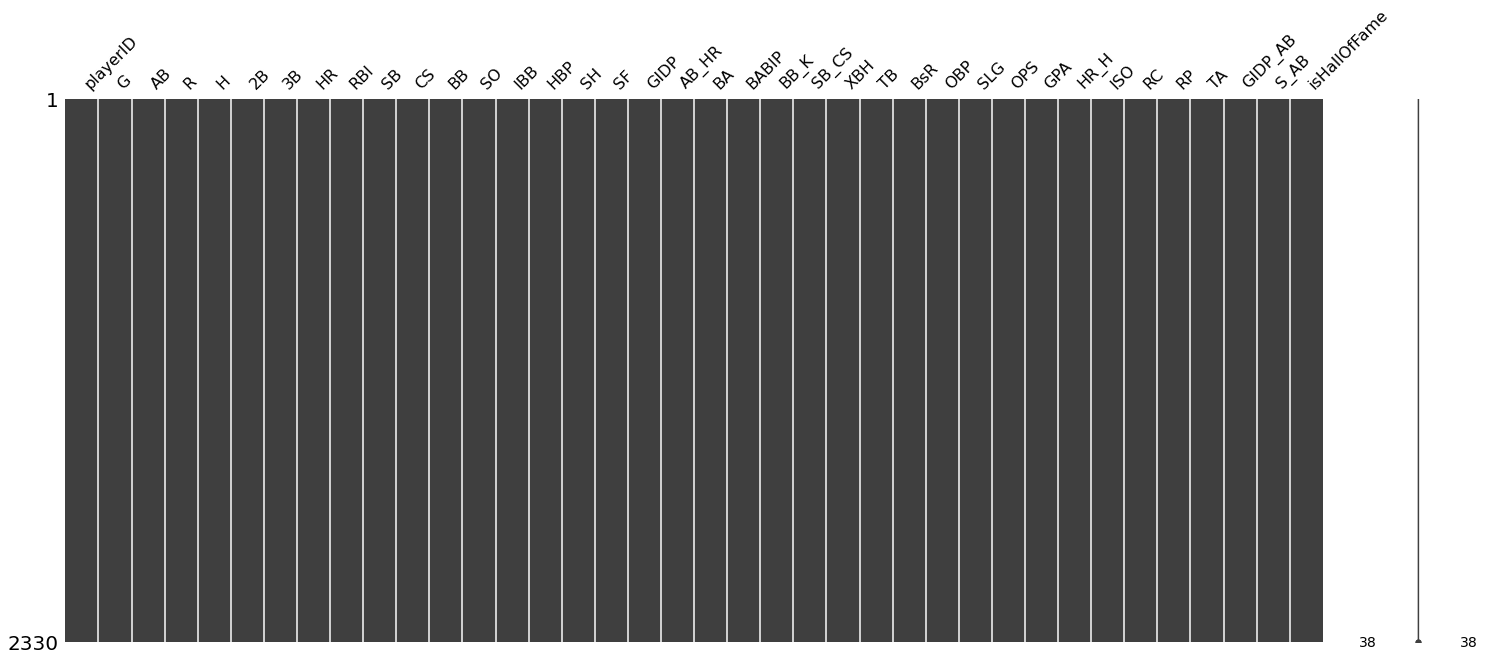

In [21]:
msno.matrix(batting_df)

It looks like we don't have any missing values here.

### Histograms

Now we will look at histograms for the data.

Text(0.5, 0.98, 'Games Played, At Bats, Runs, Runs Batted In')

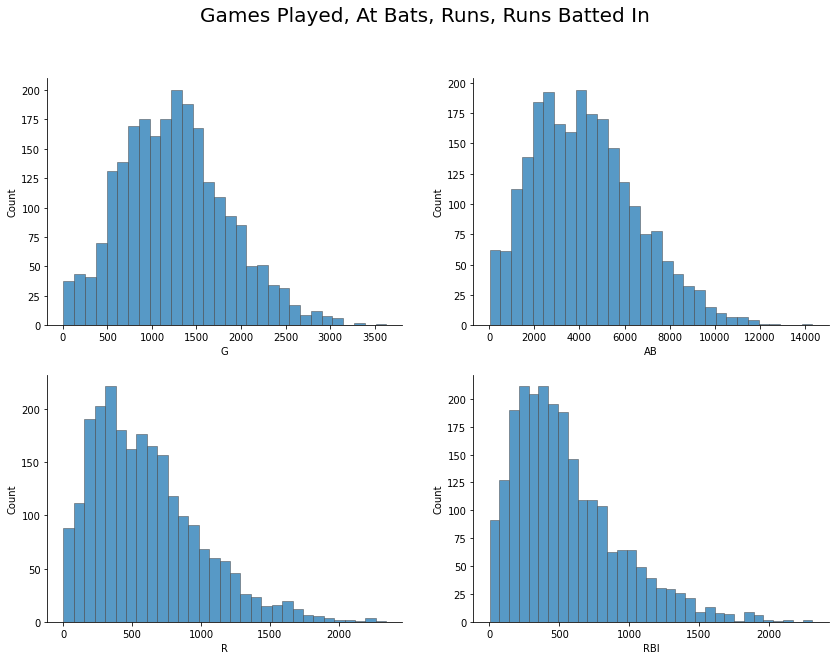

In [22]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(batting_df['G'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(batting_df['AB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(batting_df['R'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(batting_df['RBI'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Games Played, At Bats, Runs, Runs Batted In', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Hits, Doubles, Triples, Home Runs')

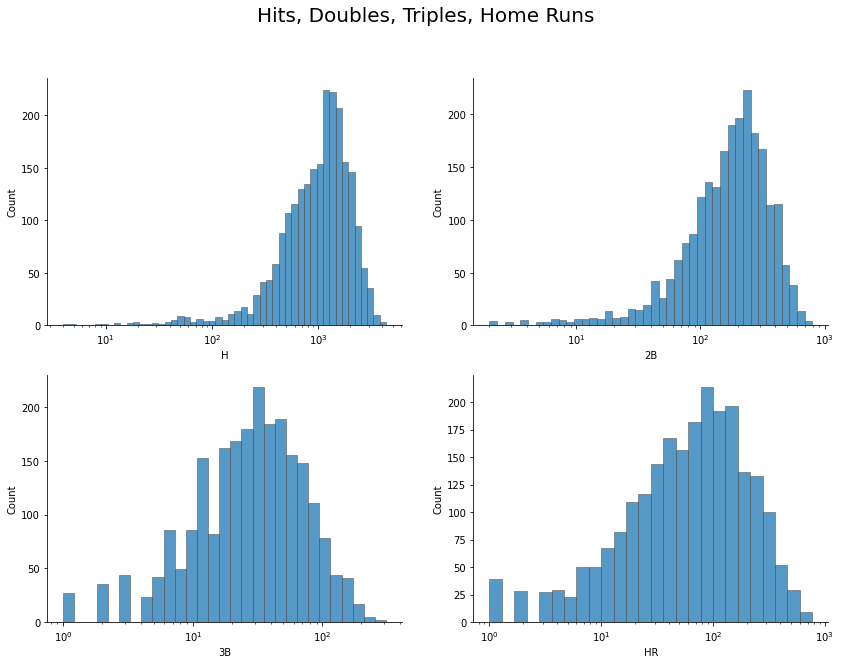

In [23]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(batting_df['H'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[0, 0])

sns.histplot(batting_df['2B'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[0, 1])

sns.histplot(batting_df['3B'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[1, 0])

sns.histplot(batting_df['HR'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[1, 1])

f.suptitle('Hits, Doubles, Triples, Home Runs', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Walks, Intentional Walks, Strike Outs, Hit by Pitch')

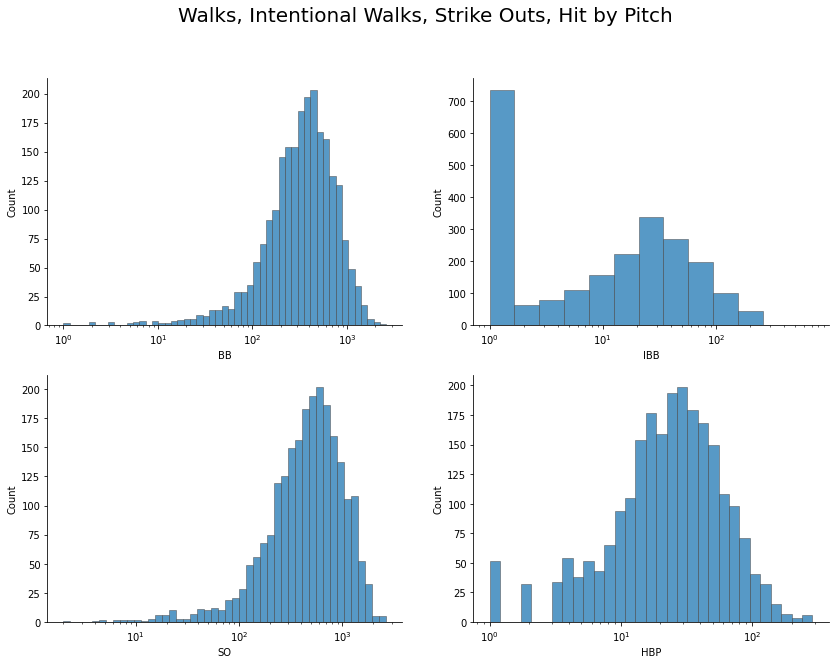

In [24]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(batting_df['BB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[0, 0])

sns.histplot(batting_df['IBB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[0, 1])

sns.histplot(batting_df['SO'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[1, 0])

sns.histplot(batting_df['HBP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[1, 1])

f.suptitle('Walks, Intentional Walks, Strike Outs, Hit by Pitch', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Stolen Bases, Caught Stealing')

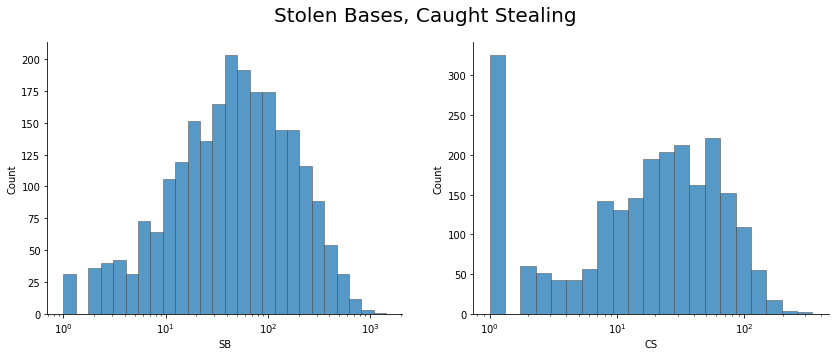

In [25]:
f, axs = plt.subplots(nrows=1, 
                      ncols=2, 
                      figsize=(14, 5))
sns.despine(f)

sns.histplot(batting_df['SB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[0])

sns.histplot(batting_df['CS'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[1])

f.suptitle('Stolen Bases, Caught Stealing', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Sacrifice Hits, Sacrifice Flies, Ground Into Double Play')

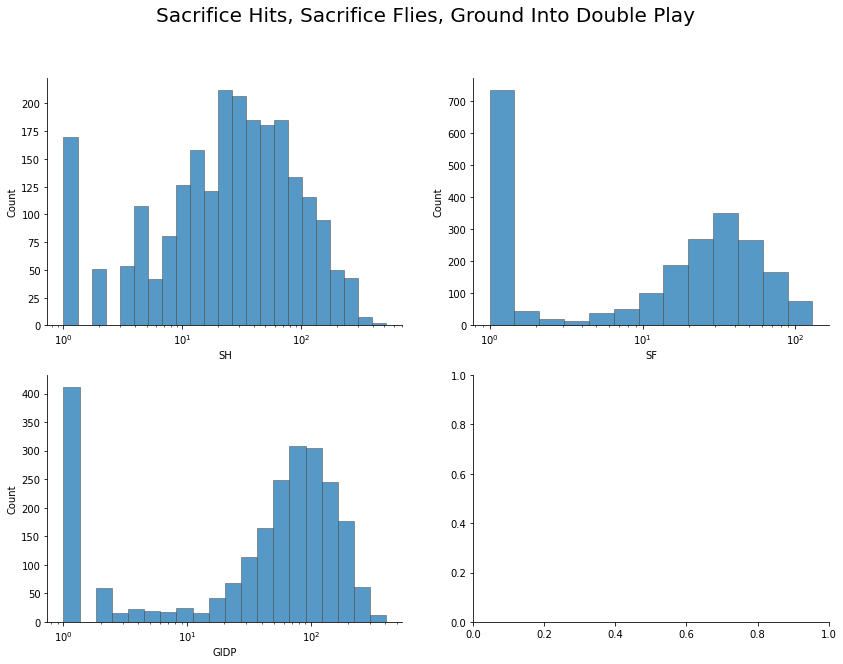

In [26]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(batting_df['SH'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[0, 0])

sns.histplot(batting_df['SF'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[0, 1])

sns.histplot(batting_df['GIDP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             log_scale=True,
             ax=axs[1, 0])

f.suptitle('Sacrifice Hits, Sacrifice Flies, Ground Into Double Play', fontsize=GLOBAL_TITLE_SIZE)

It's apparent that the majority of the batting data is pretty heavily right skewed. This means that there are some variables where there are some players who have a far larger number than average for the stat. This shifts the average higher than we would expect.  For our models, we want our data to be as Normally distributed and symmetrical as possible.

### Box Plots

We will also take a look at some box plots for the data.

Text(0.5, 0.98, 'Home Runs, On Base Percentage, Stolen Bases, Batting Average')

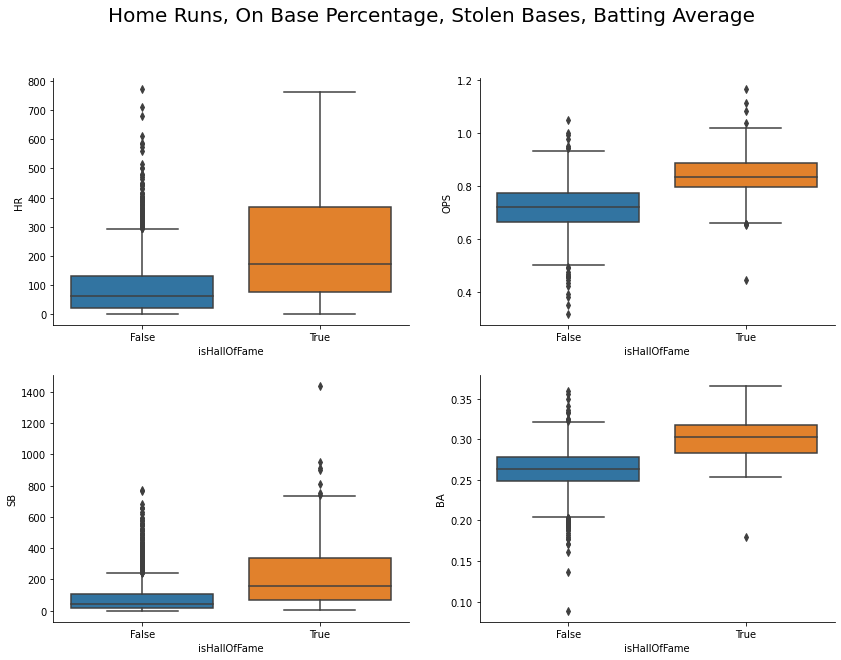

In [27]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.boxplot(data=batting_df,
             x='isHallOfFame',
             y='HR',
             ax=axs[0, 0])

sns.boxplot(data=batting_df,
             x='isHallOfFame',
             y='OPS',
             ax=axs[0, 1])

sns.boxplot(data=batting_df,
             x='isHallOfFame',
             y='SB',
             ax=axs[1, 0])

sns.boxplot(data=batting_df,
             x='isHallOfFame',
             y='BA',
             ax=axs[1, 1])

f.suptitle('Home Runs, On Base Percentage, Stolen Bases, Batting Average', fontsize=GLOBAL_TITLE_SIZE)

You can also see that the data is heteroskedastic across some variables.  This means that the variance of some stats for the players in the Hall of Fame is not the same as the variance for the players not in the Hall of Fame.  This will also be an issue moving forward, as some of our models will assume that the variances are equal.

## Box-Cox Transformation

In order to attempt to correct the skew in the data and make it so that the variance is equal between Hall of Famers and non Hall of Famers, we will transform the data using the Box-Cox transformation.  We will transform the data using a value that maximizes the log-likelihood function. However, this means that we will lose interpretability in our features.  So, we will also make a transformation that uses lambda values that can be more easily interpreted.

In [28]:
def box_cox_column(c, lmbda=None):
    if min(c) < 0:
        raise ValueError('Negative Values Exist in the Data Set', min(c))
    bc_lambda = None
    if min(c) == 0:
        if lmbda is None:
            box_cox, bc_lambda = stats.boxcox(c.apply(lambda r: r + 1), lmbda)
        else:
            box_cox = stats.boxcox(c.apply(lambda r: r + 1), lmbda)
    else:
        if lmbda is None:
            box_cox, bc_lambda = stats.boxcox(c, lmbda)
        else:
            box_cox = stats.boxcox(c, lmbda)
    return box_cox, bc_lambda

batting_df_box_cox = batting_df.copy()
batting_df_box_cox = batting_df_box_cox.drop(columns=['playerID', 'isHallOfFame'])

batting_df_box_cox_lambdas = batting_df_box_cox.apply(lambda c: box_cox_column(c)[1]).to_frame()
batting_df_box_cox_lambdas = batting_df_box_cox_lambdas.rename(columns={0: 'True'})
batting_df_box_cox_lambdas['Rounded'] = batting_df_box_cox_lambdas.apply(lambda r: round(r['True'] * 2.0) / 2.0, 
                                                                         axis=1)

batting_df_box_cox_rounded = batting_df_box_cox.apply(lambda c: box_cox_column(c, batting_df_box_cox_lambdas.at[c.name, 'Rounded'])[0])
batting_df_box_cox = batting_df_box_cox.apply(lambda c: box_cox_column(c)[0])

batting_df_box_cox_rounded_z = batting_df_box_cox_rounded.copy()
batting_df_box_cox_rounded_z = batting_df_box_cox_rounded_z.apply(lambda c: stats.zscore(c))
batting_df_box_cox_z = batting_df_box_cox.copy()
batting_df_box_cox_z = batting_df_box_cox_z.apply(lambda c: stats.zscore(c))

batting_df_box_cox_z['isHallOfFame'] = batting_df['isHallOfFame']
batting_df_box_cox_z

G        AB         R  ...   GIDP_AB      S_AB  isHallOfFame
1      2.939870  2.785482  2.794016  ...  0.844325 -0.527683          True
7     -0.613059 -0.419986 -0.499051  ... -1.454988  1.367614         False
34     1.826649  1.652815  1.817287  ...  0.145405 -0.615669         False
37    -0.417951 -0.076089  0.006147  ...  1.393502 -0.831540         False
49    -1.037471 -0.889003 -0.834363  ... -0.523009 -0.607624         False
...         ...       ...       ...  ...       ...       ...           ...
19874  0.809500  0.978125  0.941562  ...  1.353719 -0.639371         False
19883  0.404691  0.481204  0.388056  ...  0.862585 -0.819179         False
19885 -1.528240 -1.594097 -1.102718  ... -1.454988  1.894123         False
19887  0.796074  0.832917  0.887251  ...  0.315213  0.003894         False
19896 -0.861930 -0.805542 -0.885674  ...  0.105039 -0.893467         False

[2330 rows x 37 columns]

Text(0.5, 0.98, 'Games Played, At Bats, Runs, Runs Batted In')

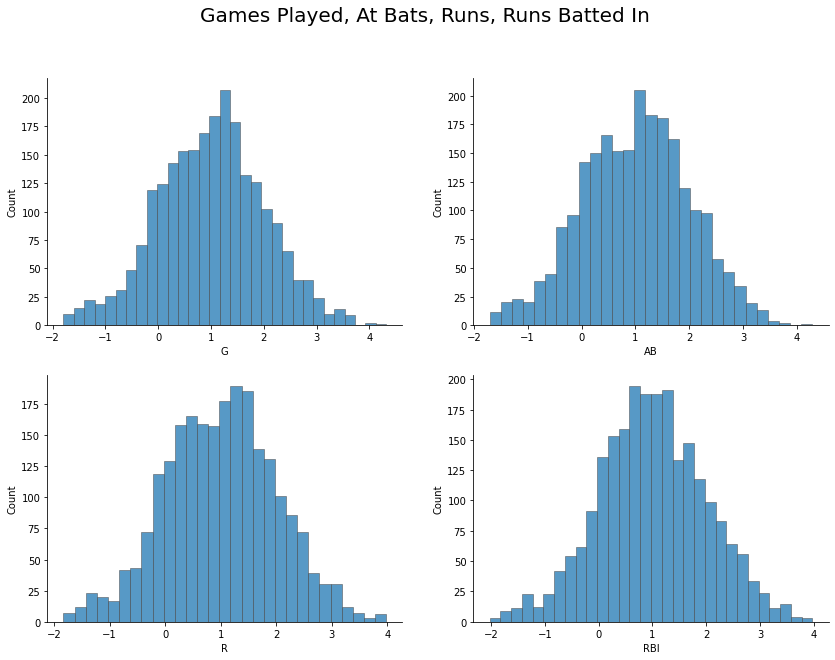

In [29]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(batting_df_box_cox_z['G'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(batting_df_box_cox_z['AB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(batting_df_box_cox_z['R'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(batting_df_box_cox_z['RBI'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Games Played, At Bats, Runs, Runs Batted In', fontsize=GLOBAL_TITLE_SIZE)

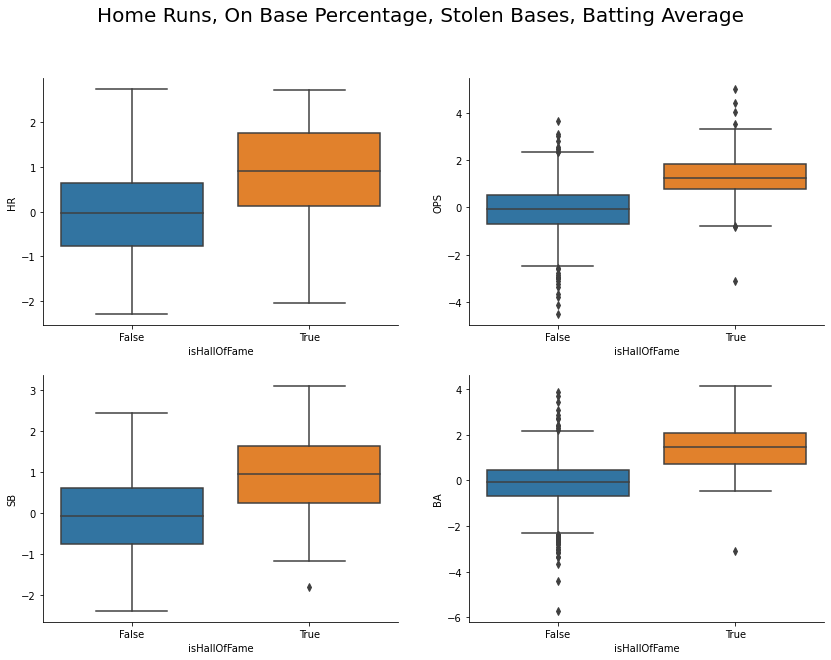

In [30]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.boxplot(data=batting_df_box_cox_z,
             x='isHallOfFame',
             y='HR',
             ax=axs[0, 0])

sns.boxplot(data=batting_df_box_cox_z,
             x='isHallOfFame',
             y='OPS',
             ax=axs[0, 1])

sns.boxplot(data=batting_df_box_cox_z,
             x='isHallOfFame',
             y='SB',
             ax=axs[1, 0])

sns.boxplot(data=batting_df_box_cox_z,
             x='isHallOfFame',
             y='BA',
             ax=axs[1, 1])

f.suptitle('Home Runs, On Base Percentage, Stolen Bases, Batting Average', fontsize=GLOBAL_TITLE_SIZE)

batting_df_box_cox_z = batting_df_box_cox_z.drop(columns=['isHallOfFame'])

Using a Box-Cox transformation helps to satisfy our Normality assumption as well as our homoskedasticity assumption.

## Correlation Matrix

We can now look at the correlation matrix for these variables to see how related they are with each other.

Text(0.5, 1.0, 'Correlation of Batting Features')

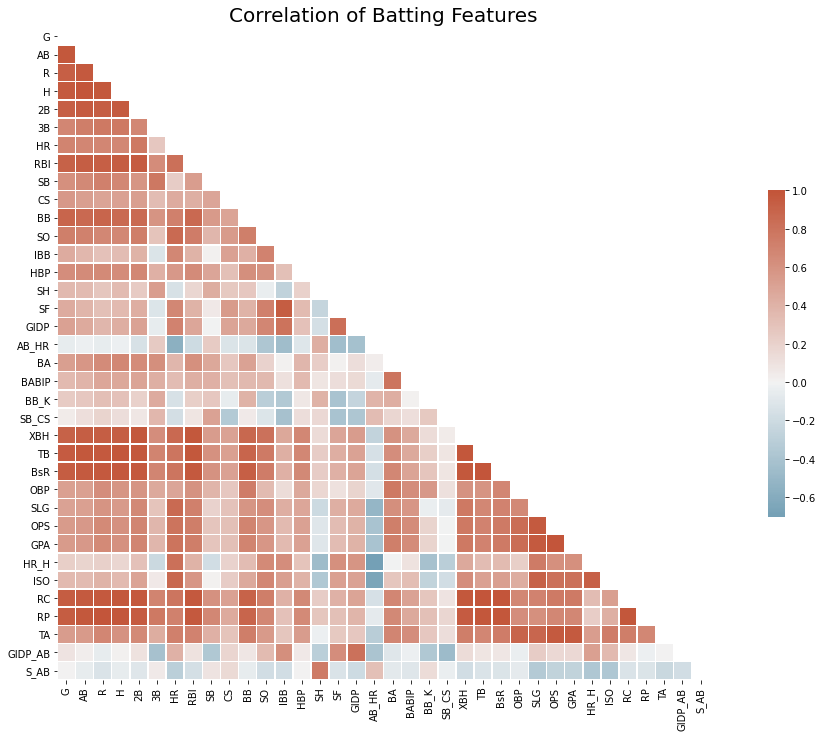

In [31]:
batting_corr = batting_df_box_cox_z.corr()
batting_corr
mask = np.triu(np.ones_like(batting_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(batting_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=False, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Batting Features', fontsize=GLOBAL_TITLE_SIZE)

Since GPA is a linear combination of OPS and BsR with RC, they will be perfectly correlated and, therefore, provide no new information, GPA nad BsR should also be removed.

In [32]:
batting_columns_to_drop = ['GPA', 'BsR']
batting_df_box_cox_z = batting_df_box_cox_z.drop(columns=batting_columns_to_drop)
batting_df_box_cox_rounded_z = batting_df_box_cox_rounded_z.drop(columns=batting_columns_to_drop)
batting_corr = batting_df_box_cox_z.corr()

Perhaps a more interpretable diagram is the dendrogram.  This is a plot of heirarchical clustering of the feature correlations, using Ward's linkage on the distance of 1 - the correlation.  Essentially, this plot shows which variables are most closely related with each other. Drawing an imaginary horizontal line anywhere on this plot would show that all variables connected below that line are members of the same "group" and, therefore, are too closely correlated for our criteria.

Text(0.5, 1.0, 'Dendrogram of Batting Feature Correlations')

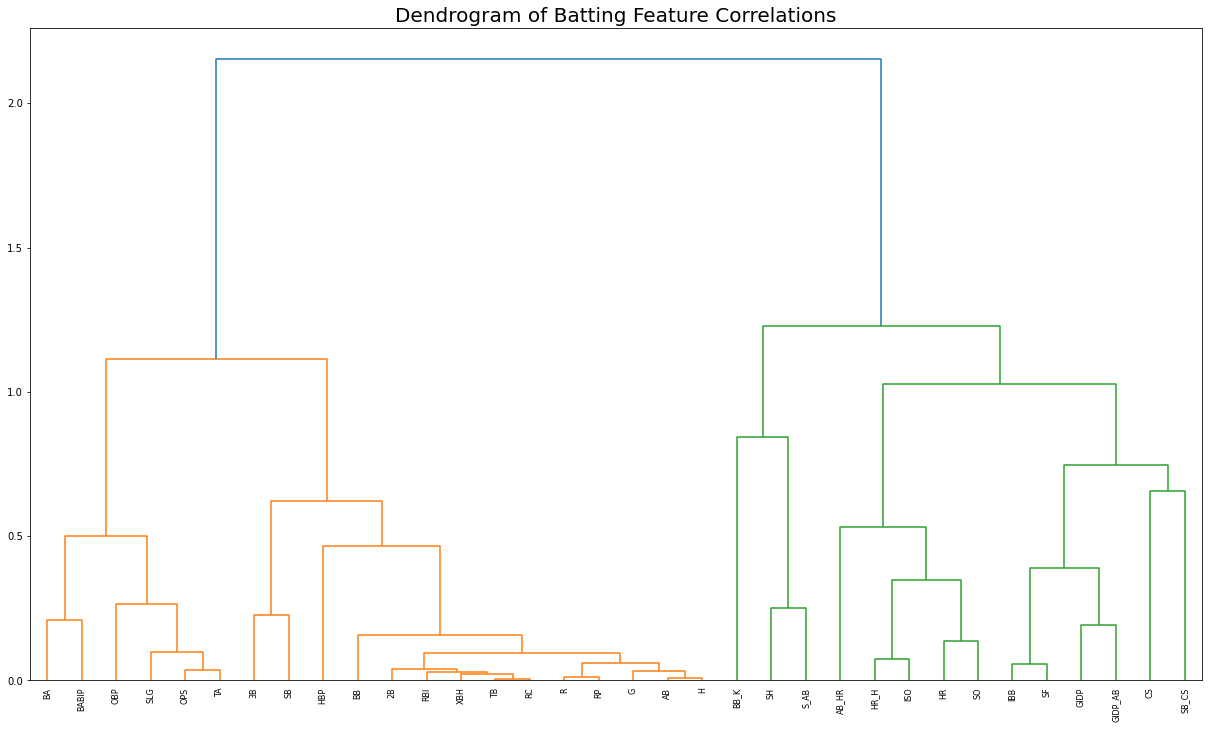

In [33]:
distance_matrix = 1 - np.abs(batting_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
distance_matrix

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(batting_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Batting Feature Correlations', fontsize=GLOBAL_TITLE_SIZE)

For some variables, the correlation is very high which makes sense.  For example, the more at bats a player has, the more times he will hit the ball.  Having high collinearity between variables can cause issues for us.  However, there are other variables that should hopefully tell us the same information without this issue, such as batting average.  Since a longer career leads to more games, which in turn will lead to a higher value of all the core stats, these core stats should all be removed.  

Only baseball stats that are rates and ratios should remain.

Text(0.5, 1.0, 'Correlation of Batting Features')

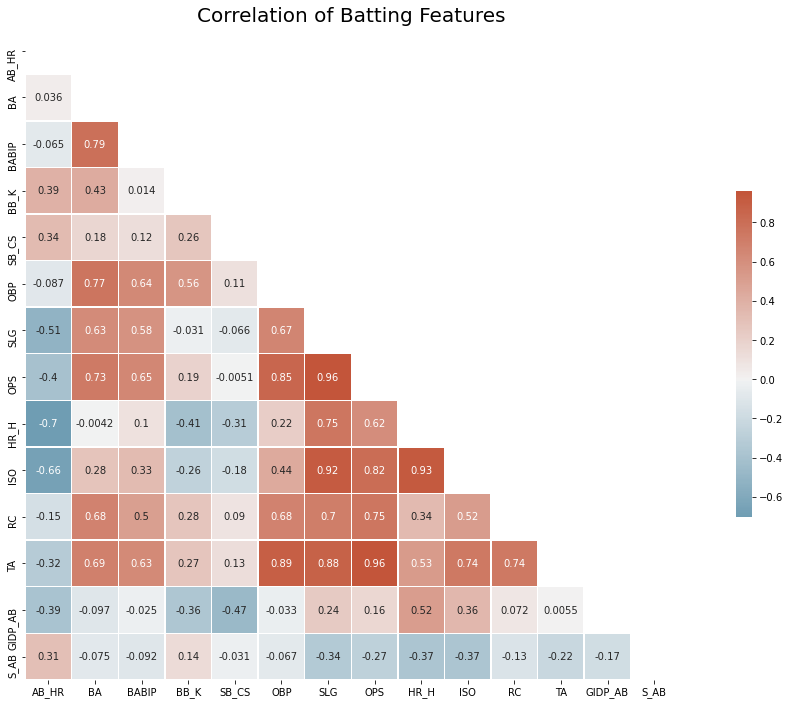

In [34]:
batting_columns_to_drop = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
                           'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
                           'XBH', 'TB', 'RP']
batting_df_box_cox_z = batting_df_box_cox_z.drop(columns=batting_columns_to_drop)
batting_df_box_cox_rounded_z = batting_df_box_cox_rounded_z.drop(columns=batting_columns_to_drop)

batting_corr = batting_df_box_cox_z.corr()
batting_corr
mask = np.triu(np.ones_like(batting_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(batting_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Batting Features', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Batting Feature Correlations')

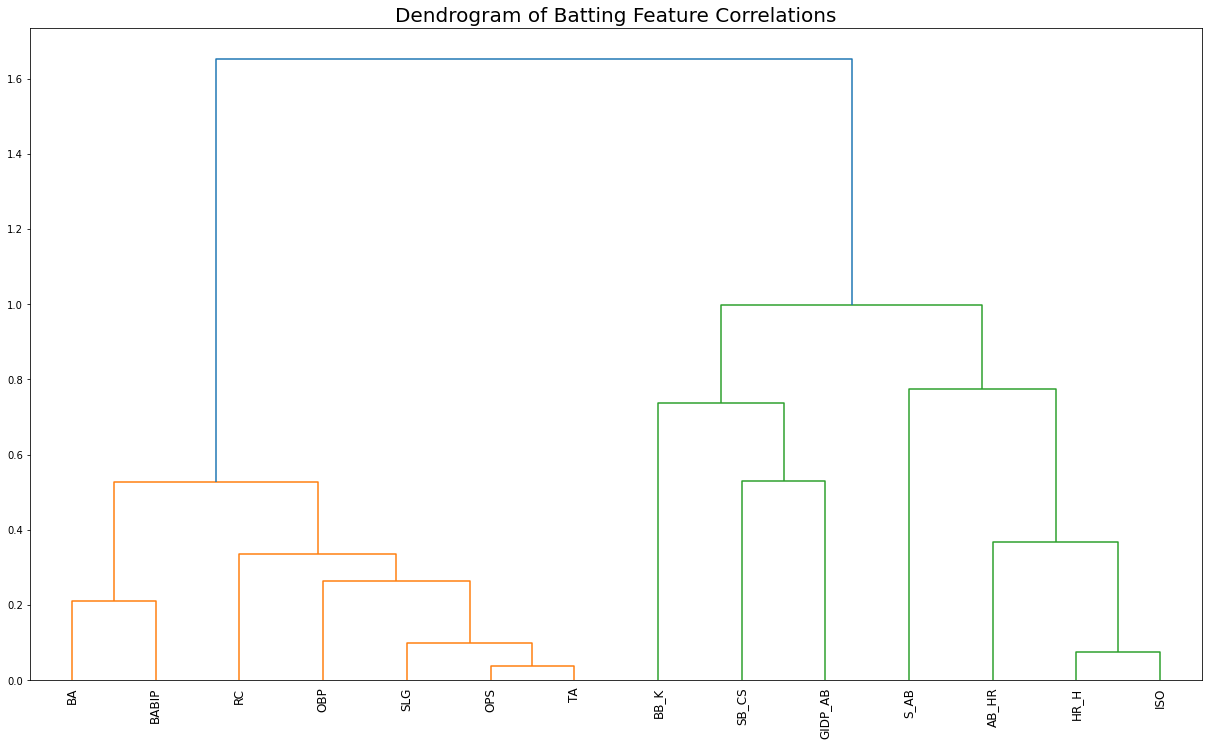

In [35]:
distance_matrix = 1 - np.abs(batting_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(batting_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Batting Feature Correlations', fontsize=GLOBAL_TITLE_SIZE)

We can see here that if our cut point were to be .2, then batting average and batting average on balls in play would be members of the same cluster.  This implies that they are too highly correlated.  Since we want to only have one feature within each cluster we will remove one of them.  We will also do the same on all clusters that are larger than size 1.

In [36]:
batting_columns_to_drop = ['BABIP', 'TA', 'SLG', 'HR_H']
batting_df_box_cox_z = batting_df_box_cox_z.drop(columns=batting_columns_to_drop)
batting_df_box_cox_rounded_z = batting_df_box_cox_rounded_z.drop(columns=batting_columns_to_drop)

## Principal Component Analysis

Additionally, to assist with this correlation issue, we will use principal components analysis (PCA). PCA will take a combination of these variables and give them to us such that:
1) All the new variables are independent of each other;
2) These new variables are sorted so that the one that gives us the most information is first.

This will make our data better fit our assumptions. It will also reduce the number of features that are necessary for the model.  However, we will lose all interpretability into what baseball statistics are important.

In [37]:
batting_pca = PCA()
batting_principle_components = batting_pca.fit_transform(batting_df_box_cox_z)
batting_pca_df = pd.DataFrame(data=batting_principle_components, 
                              columns=['PC ' + str(i+1) for i in range(len(batting_df_box_cox_z.columns))])

batting_pca_df

PC 1      PC 2      PC 3  ...      PC 8      PC 9     PC 10
0     4.840646  0.351466  0.105603  ...  0.370486 -0.413519  0.162042
1    -1.880640 -2.649710  0.332869  ... -0.269324  0.086613  0.027290
2     3.521442 -0.176199  0.276577  ... -0.009117  0.719265 -0.021455
3     2.516671  2.124922  0.433237  ... -0.064151 -0.103849  0.129094
4    -1.395914  0.796674  1.109043  ... -0.204396  0.037251 -0.064393
...        ...       ...       ...  ...       ...       ...       ...
2325  2.064089  1.491790  0.355431  ...  0.150768 -0.050690  0.040389
2326  2.098945  1.567063 -0.631727  ...  0.085073  0.028045  0.006560
2327 -2.027169 -2.515163 -0.728305  ... -0.502140 -0.038721  0.061421
2328  1.361602  0.190734 -0.102472  ... -0.104508  0.173762 -0.039779
2329 -2.043653  3.707020  0.723355  ... -0.942446 -0.117697 -0.046675

[2330 rows x 10 columns]

### Scree Plot

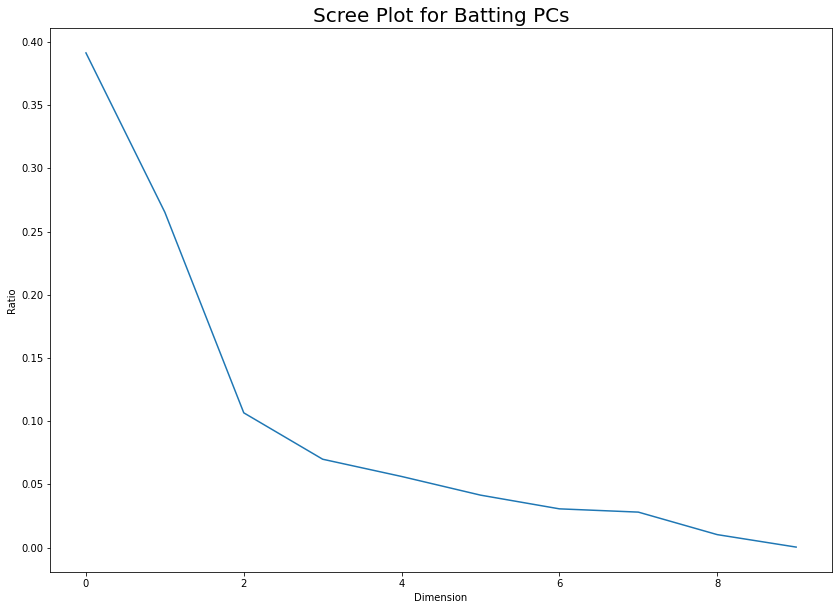

[0.39125486 0.65645871 0.76304465 0.83292683 0.88917048 0.93065926
 0.96129762 0.98935317 0.99960792 1.        ]


In [38]:
ratio = batting_pca.explained_variance_ratio_

f, ax = plt.subplots(figsize=SMALL_FIG_SIZE)
plt.plot(ratio)
plt.xlabel('Dimension')
plt.ylabel('Ratio')
ax.set_title('Scree Plot for Batting PCs', fontsize=GLOBAL_TITLE_SIZE)
plt.show()

print(np.cumsum(ratio))

There's a clear dropoff in the variance explained after the first 2 PCs

- 90% variance explained after the first 6 PCs
- 95% variance explained after the first 7 PCs
- 99% variance explained after the first 9 PCs

In [39]:
batting_pca_df = batting_pca_df.drop(columns=['PC ' + str(i+1) for i in range(6, len(batting_df_box_cox_z.columns))])    
batting_pca_df['playerID'] = batting_df['playerID'].reset_index(drop=True)
batting_pca_df.columns = ['Batting ' + col for col in batting_pca_df.columns]
batting_pca_df = batting_pca_df.rename(columns={'Batting playerID': 'playerID'})
batting_pca_df

Batting PC 1  Batting PC 2  Batting PC 3  ...  Batting PC 5  \
0         4.840646      0.351466      0.105603  ...     -0.731564   
1        -1.880640     -2.649710      0.332869  ...     -0.184954   
2         3.521442     -0.176199      0.276577  ...     -0.189653   
3         2.516671      2.124922      0.433237  ...     -0.883645   
4        -1.395914      0.796674      1.109043  ...      0.395037   
...            ...           ...           ...  ...           ...   
2325      2.064089      1.491790      0.355431  ...     -1.031928   
2326      2.098945      1.567063     -0.631727  ...      0.206954   
2327     -2.027169     -2.515163     -0.728305  ...      0.344980   
2328      1.361602      0.190734     -0.102472  ...     -0.040935   
2329     -2.043653      3.707020      0.723355  ...      0.734464   

      Batting PC 6   playerID  
0         0.187357  aaronha01  
1         0.453299  abbated01  
2         0.074177  abreubo01  
3        -0.161240  abreujo02  
4        -0.127119  ackledu01  
...            ...        ...  
2325      0.238161  zimmery01  
2326     -0.710797   ziskri01  
2327      0.009615  zitzmbi01  
2328      0.442085  zobribe01  
2329     -0.773037  zuninmi01  

[2330 rows x 7 columns]

# Pitching Data

The next major category that pitchers are evaluated on is their pitching. Here, we will largely do the same thing for pitching as we did for batting; get all player's core pitching numbers over their career and then create a couple of other commonly used statistics to evaluate pitchers.

In [40]:
# Combine the regular season and post season data
pitching_regular_df = pd.read_csv('baseballdatabank-master/core/Pitching.csv')
pitching_post_df = pd.read_csv('baseballdatabank-master/core/PitchingPost.csv')
pitching_df = pd.concat([pitching_regular_df, pitching_post_df])

# Remove yearID, stint, teamID and lgID from each player
pitching_df = pitching_df.drop(columns=['yearID', 'stint', 'teamID', 'lgID'])

pitching_keys = {'G':   'Games',
                 'W':   'Wins',
                 'L': 'Losses',
                 'GS': 'Games Started',
                 'CG': 'Complete Games',
                 'SHO': 'Shutouts',
                 'SV': 'Saves',
                 'IPOuts': 'Outs Pitched',
                 'H': 'Hits Allowed',
                 'ER': 'Earned Runs',
                 'HR': 'Home Runs Allowed',
                 'BB': 'Batters Walked',
                 'SO': 'Batters Struck Out',
                 'BAOpp': 'Opponent Batting Average',
                 'ERA': 'Earned Run Average',
                 'IBB': 'Batters Intentionally Walked',
                 'WP': 'Wild Pitches',
                 'HBP': 'Batters Hit By Pitch',
                 'BFP': 'Batters Faced By Pitcher',
                 'BK': 'Balks',
                 'GF': 'Games Finished',
                 'R': 'Runs Allowed',
                 'SH': 'Sacrifice Hits By Opposing Batters',
                 'SF': 'Sacrifice Flies By Opposing Batters',
                 'GIDP': 'Grounded Into Double Plays By Opposing Batters'}

For manipulation of the data, we will only work with players who are eligible for the Hall of Fame or players who are currently active and have played at least 500 games.  We also will only work with any pitchers here.

In [41]:
# Players are listed multiple times, once per season, group them and get their careers as a whole
pitching_df = pitching_df.groupby(by='playerID', as_index=False).sum()

# We only want the eligible players or active players with at least 500 games
pitching_df = pitching_df.loc[(pitching_df['playerID'].isin(eligible_pitchers['playerID'])) | 
                              (pitching_df['playerID'].isin(active_pitchers500['playerID']))]
pitching_df = pitching_df.drop_duplicates()

# ERA Has some infinite values
pitching_df['ERA'] = pitching_df.apply(lambda r: 9*r['ER'] / (r['IPouts'] / 3) 
                                       if r['ERA'] == np.inf or r['ERA'] == np.nan
                                       else r['ERA'], axis=1)

pitching_df

playerID    W    L  ...     SH    SF   GIDP
0     aardsda01   16   18  ...   17.0  11.0   21.0
1      aasedo01   67   60  ...   50.0  35.0  106.0
6     abbotgl01   62   83  ...   60.0  39.0  111.0
7     abbotji01   87  108  ...   70.0  47.0  200.0
9     abbotpa01   44   38  ...   20.0  23.0   52.0
...         ...  ...  ...  ...    ...   ...    ...
9954  zambrca01  132   93  ...  101.0  45.0  176.0
9974  zieglbr01   37   38  ...   19.0  21.0  138.0
9980  zimmejo02   95   92  ...   54.0  41.0  112.0
9986   zitoba01  171  146  ...  106.0  73.0  224.0
9990  zuberbi01   43   42  ...    0.0   0.0    1.0

[1331 rows x 26 columns]

It's unfortunate that we don't have access to some noteworthy values, such as a pitchers number of "No Hitters" and "Perfect Games" but there is nothing we can do about it.

## Calculated Statistics

In [42]:
# Innings Pitched
pitching_df['IP'] = pitching_df.apply(lambda r: r['IPouts'] / 3, axis=1)
pitching_keys['IP'] = 'Innings Pitched'

# Walks per 9 Innings Pitched
pitching_df['BB_9'] = pitching_df.apply(lambda r: r['BB'] / (9 * r['IP']), axis=1)
pitching_keys['BB_9'] = 'Walks per 9 Innings Pitched'

# Component ERA
def component_era(r):
    ptb = .89 * (1.255 * (r['H'] - r['HR']) + 4 * r['HR']) + .56 * (r['BB'] + r['HBP'] - r['IBB'])
    n = (r['H'] + r['BB'] + r['HBP']) * ptb
    d = r['BFP'] * r['IP']
    return 9 * (n / d) - .56
pitching_df['CERA'] = pitching_df.apply(lambda r: component_era(r), axis=1)
pitching_keys['CERA'] = 'Component ERA'

# Defense Independent Component ERA
def dice(r):
    n = 13 * r['HR'] + 3 * (r['BB'] + r['HBP']) - 2 * r['SO'] 
    return 3 + (n / r['IP'])
pitching_df['DICE'] = pitching_df.apply(lambda r: dice(r), axis=1)
pitching_keys['DICE'] = 'Defense Independent Component ERA'

# Hits per 9 Innings Pitched
pitching_df['H_9'] = pitching_df.apply(lambda r: r['H'] / (9 * r['IP']), axis=1)
pitching_keys['H_9'] = 'Hits per 9 Innings Pitched'

# Strike Outs per 9 Innings Pitched
pitching_df['K_9'] = pitching_df.apply(lambda r: r['SO'] / (9 * r['IP']), axis=1)
pitching_keys['K_9'] = 'Strike Outs per 9 Innings Pitched'

# Power Finesse Ratio
pitching_df['PFR'] = pitching_df.apply(lambda r: (r['SO'] + r['BB']) / r['IP'], axis=1)
pitching_keys['PFR'] = 'Power Finesse Ratio'

# Walks Plus Hits per Inning Pitched
pitching_df['WHIP'] = pitching_df.apply(lambda r: (r['H'] + r['BB']) / r['IP'], axis=1)
pitching_keys['WHIP'] = 'Walks Plus Hits per Inning Pitched'

# Home Runs Allowed Per Inning Pitched
pitching_df['HR_IP'] = pitching_df.apply(lambda r: r['HR'] / r['IP'], axis=1)
pitching_keys['HR_IP'] = 'Home Runs Allowed Per Inning Pitched'

# Wild Pitches Per Inning Pitched
pitching_df['WP_IP'] = pitching_df.apply(lambda r: r['WP'] / r['IP'], axis=1)
pitching_keys['WP_IP'] = 'Wild Pitches Per Inning Pitched'

# Batters Hit By Pitch Per Inning Pitched
pitching_df['HBP_IP'] = pitching_df.apply(lambda r: r['HBP'] / r['IP'], axis=1)
pitching_keys['HBP_IP'] = 'Batters Hit By Pitch Per Inning Pitched'

# Balks Per Inning Pitched
pitching_df['BK_IP'] = pitching_df.apply(lambda r: r['BK'] / r['IP'], axis=1)
pitching_keys['BK_IP'] = 'Balks Per Inning Pitched'

# Win Percentage
pitching_df['W_G'] = pitching_df.apply(lambda r: r['W'] / r['G'], axis=1)
pitching_keys['W_G'] = 'Win Percentage'

# Shutout Percentage
pitching_df['SHO_G'] = pitching_df.apply(lambda r: r['SHO'] / r['G'], axis=1)
pitching_keys['SHO_G'] = 'Shutout Percentage'

# Save Percentage
pitching_df['SV_G'] = pitching_df.apply(lambda r: r['SV'] / r['G'], axis=1)
pitching_keys['SV_G'] = 'Save Percentage'

# Grounded Into Double Play Per Inning Pitched
pitching_df['GIDP_IP'] = pitching_df.apply(lambda r: r['GIDP'] / r['IP'], axis=1)
pitching_keys['GIDP_IP'] = 'Grounded Into Double Play Per Inning Pitched'

# Sacrifices Per Inning Pitched
pitching_df['S_IP'] = pitching_df.apply(lambda r: (r['SH'] + r['SF']) / r['IP'], axis=1)
pitching_keys['S_IP'] = 'Sacrifices Per Inning Pitched'

pitching_df['isHallOfFame'] = pitching_df.apply(lambda r: is_hall_of_fame_player(r), axis=1)
pitching_df = pitching_df.drop(columns=['IPouts'])
pitching_df

playerID    W    L  ...   GIDP_IP      S_IP  isHallOfFame
0     aardsda01   16   18  ...  0.062315  0.083086         False
1      aasedo01   67   60  ...  0.095124  0.076279         False
6     abbotgl01   62   83  ...  0.086247  0.076923         False
7     abbotji01   87  108  ...  0.119474  0.069892         False
9     abbotpa01   44   38  ...  0.070334  0.058161         False
...         ...  ...  ...  ...       ...       ...           ...
9954  zambrca01  132   93  ...  0.088531  0.073441         False
9974  zieglbr01   37   38  ...  0.192111  0.055684         False
9980  zimmejo02   95   92  ...  0.069093  0.058606         False
9986   zitoba01  171  146  ...  0.084945  0.067880         False
9990  zuberbi01   43   42  ...  0.001269  0.000000         False

[1331 rows x 43 columns]

## Exploratory Data Analysis

Once again, we need to ensure that the data is in a good state to use for our models.

### Missing Data

<AxesSubplot:>

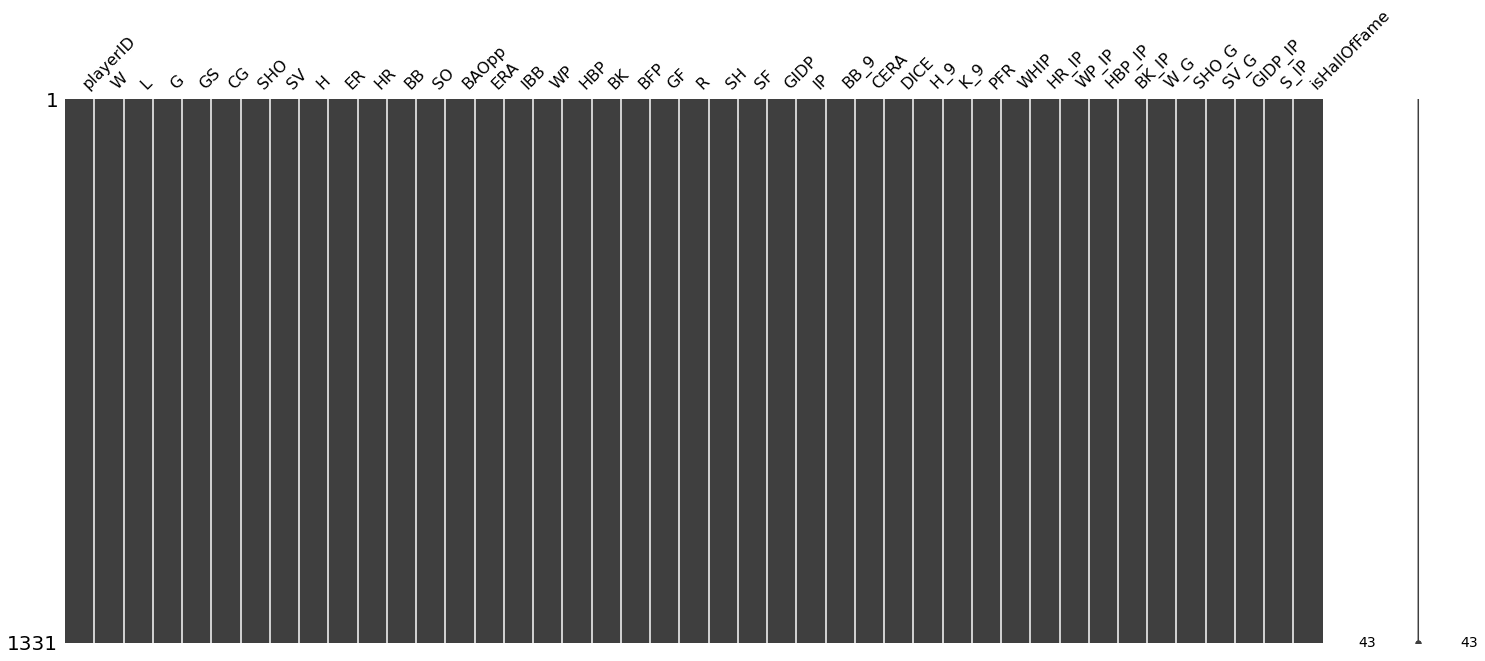

In [43]:
msno.matrix(pitching_df)

There aren't any missing values in the pitching data either.

### Histograms

We will look at some histograms for the pitching data as well.

Text(0.5, 0.98, 'Wins, Losses')

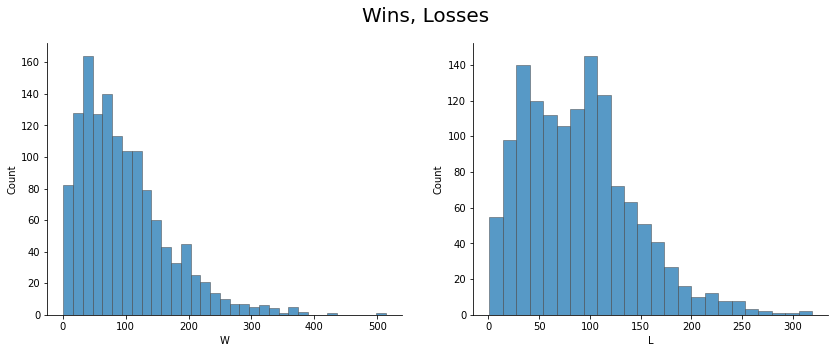

In [44]:
f, axs = plt.subplots(nrows=1, 
                      ncols=2, 
                      figsize=(14, 5))
sns.despine(f)

sns.histplot(pitching_df['W'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0])

sns.histplot(pitching_df['L'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1])

f.suptitle('Wins, Losses', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Games, Games Started, Games Finished, Complete Game')

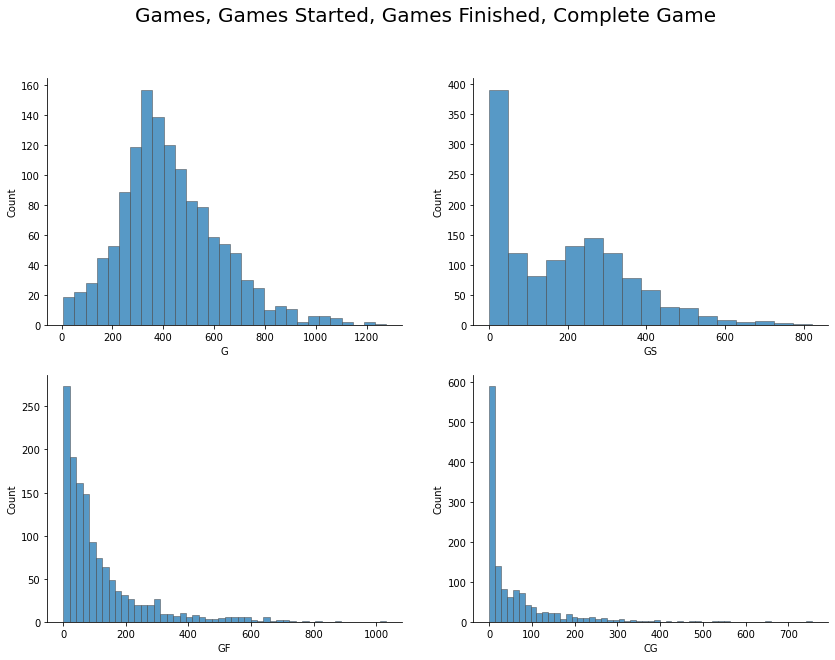

In [45]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(pitching_df['G'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(pitching_df['GS'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(pitching_df['GF'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(pitching_df['CG'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Games, Games Started, Games Finished, Complete Game', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Runs Allowed, Earned Runs, Earned Run Average, Outs Pitched')

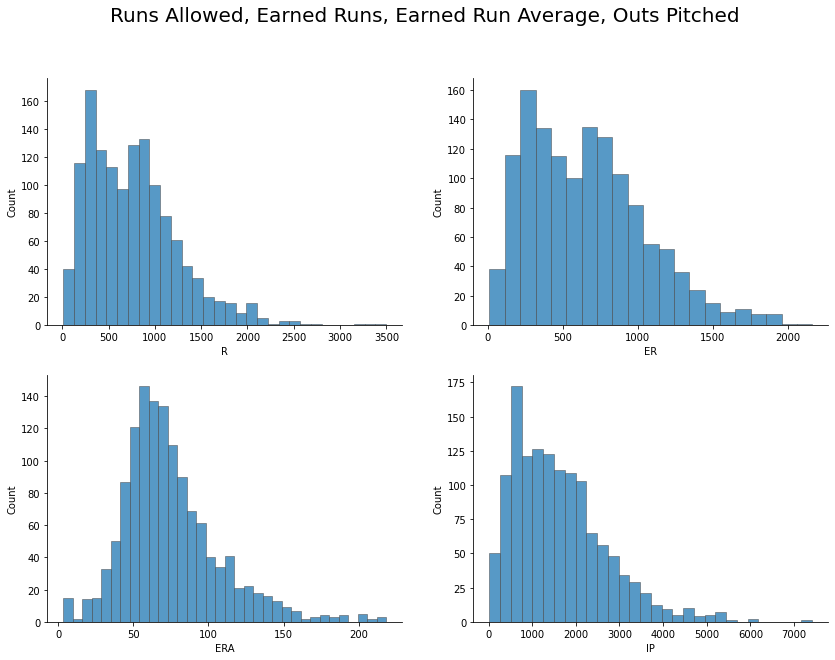

In [46]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(pitching_df['R'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(pitching_df['ER'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(pitching_df['ERA'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(pitching_df['IP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Runs Allowed, Earned Runs, Earned Run Average, Outs Pitched', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Hits Allowed, Home Runs Allowed, Walks, Strikeouts')

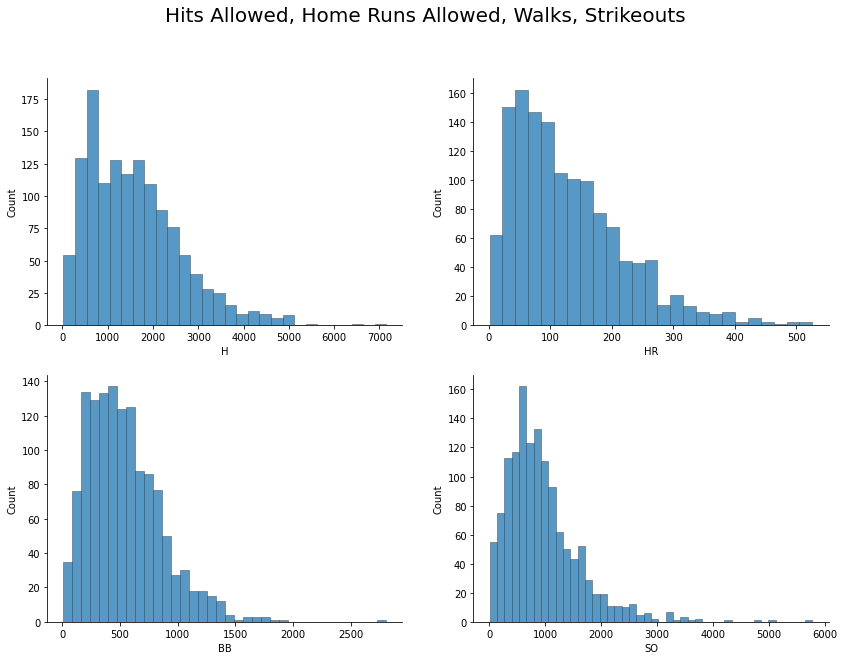

In [47]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(pitching_df['H'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(pitching_df['HR'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(pitching_df['BB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(pitching_df['SO'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Hits Allowed, Home Runs Allowed, Walks, Strikeouts', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Sacrifice Hits, Sacrifice Flies, Ground into Double Plays, Batters Faced')

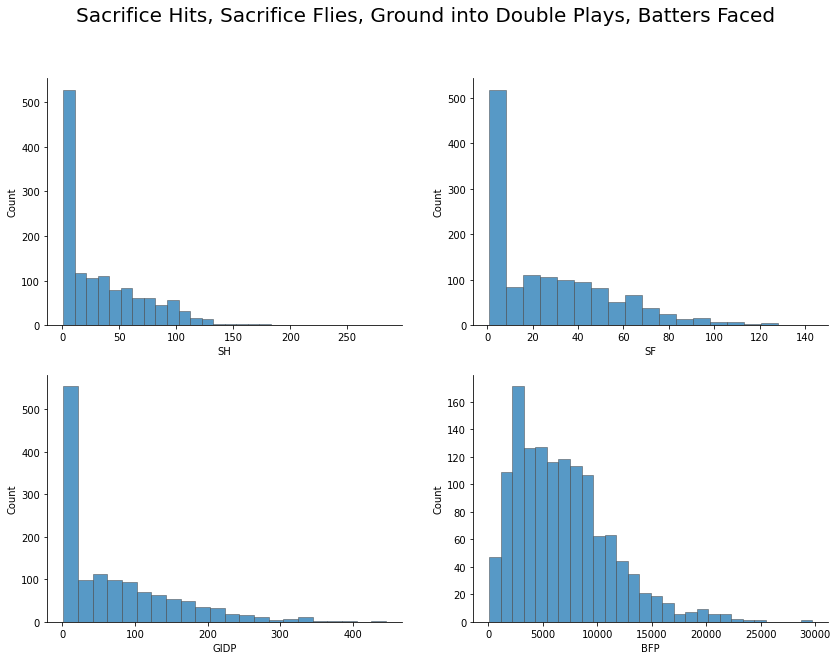

In [48]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(pitching_df['SH'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(pitching_df['SF'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(pitching_df['GIDP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(pitching_df['BFP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Sacrifice Hits, Sacrifice Flies, Ground into Double Plays, Batters Faced', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Wild Pitches, Batters Hit by Pitch, Balks, Intentional Walks')

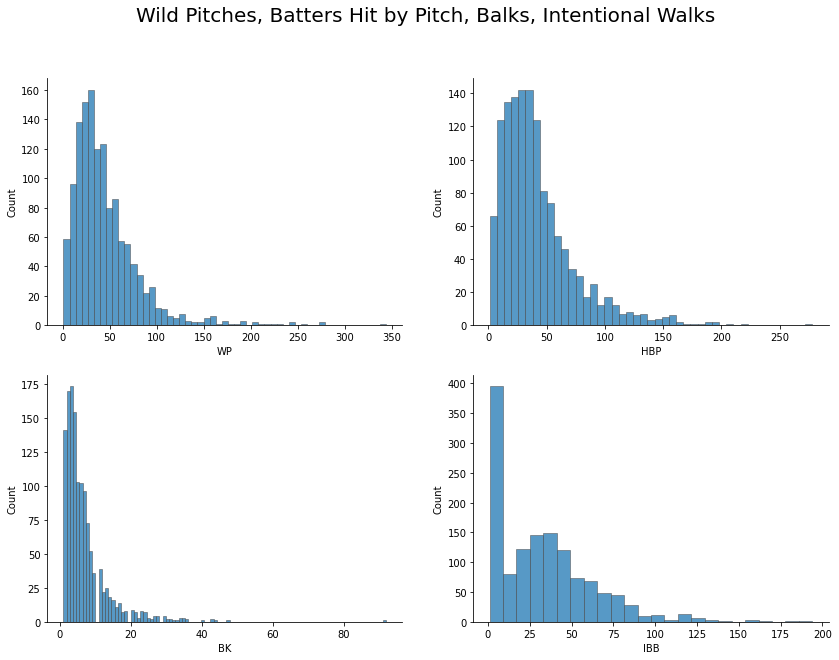

In [49]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(pitching_df['WP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(pitching_df['HBP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(pitching_df['BK'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(pitching_df['IBB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Wild Pitches, Batters Hit by Pitch, Balks, Intentional Walks', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Shutouts, Saves')

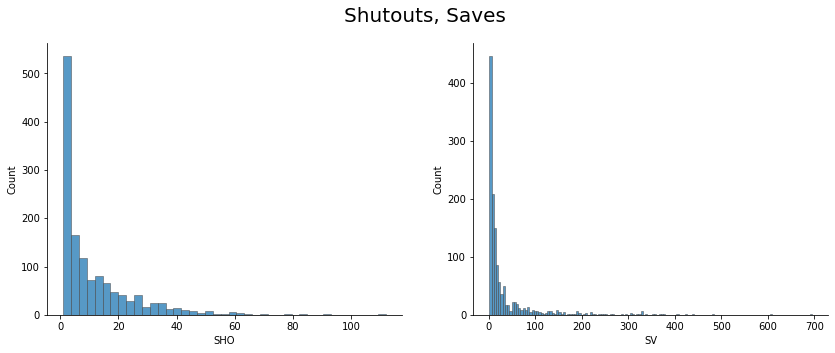

In [50]:
f, axs = plt.subplots(nrows=1, 
                      ncols=2, 
                      figsize=(14, 5))
sns.despine(f)

sns.histplot(pitching_df['SHO'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0])

sns.histplot(pitching_df['SV'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1])

f.suptitle('Shutouts, Saves', fontsize=GLOBAL_TITLE_SIZE)

It's clear that the majority of the pitching data is also pretty heavily right skewed.

### Box Plots

Box plots for the pitching data.

Text(0.5, 0.98, 'Home Runs Allowed, Earned Run Average, Hits Allowed, Wins')

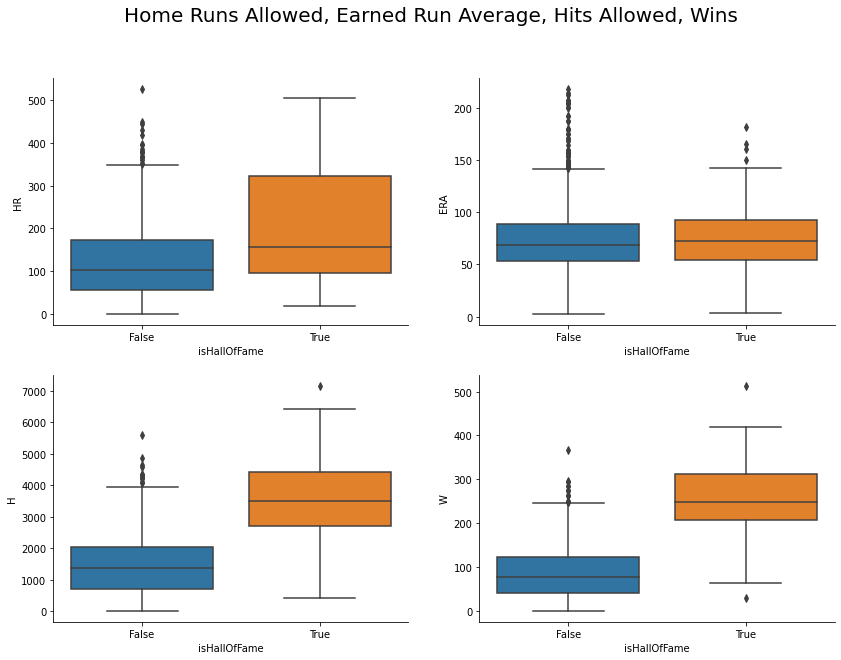

In [51]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.boxplot(data=pitching_df,
             x='isHallOfFame',
             y='HR',
             ax=axs[0, 0])

sns.boxplot(data=pitching_df,
             x='isHallOfFame',
             y='ERA',
             ax=axs[0, 1])

sns.boxplot(data=pitching_df,
             x='isHallOfFame',
             y='H',
             ax=axs[1, 0])

sns.boxplot(data=pitching_df,
             x='isHallOfFame',
             y='W',
             ax=axs[1, 1])

f.suptitle('Home Runs Allowed, Earned Run Average, Hits Allowed, Wins', fontsize=GLOBAL_TITLE_SIZE)

## Box-Cox Transformation

Once again, we will do another Box-Cox transformation on the data to correct issues.

In [52]:
pitching_df_box_cox = pitching_df.copy()
pitching_df_box_cox = pitching_df_box_cox.drop(columns=['playerID', 'isHallOfFame'])

pitching_df_box_cox_lambdas = pitching_df_box_cox.apply(lambda c: box_cox_column(c)[1]).to_frame()
pitching_df_box_cox_lambdas = pitching_df_box_cox_lambdas.rename(columns={0: 'True'})
pitching_df_box_cox_lambdas['Rounded'] = pitching_df_box_cox_lambdas.apply(lambda r: round(r['True'] * 2.0) / 2.0, 
                                                                         axis=1)

pitching_df_box_cox_rounded = pitching_df_box_cox.apply(lambda c: box_cox_column(c, pitching_df_box_cox_lambdas.at[c.name, 'Rounded'])[0])
pitching_df_box_cox = pitching_df_box_cox.apply(lambda c: box_cox_column(c)[0])

pitching_df_box_cox_rounded_z = pitching_df_box_cox_rounded.copy()
pitching_df_box_cox_rounded_z = pitching_df_box_cox_rounded_z.apply(lambda c: stats.zscore(c))
pitching_df_box_cox_z = pitching_df_box_cox.copy()
pitching_df_box_cox_z = pitching_df_box_cox_z.apply(lambda c: stats.zscore(c))

pitching_df_box_cox_z['isHallOfFame'] = pitching_df['isHallOfFame']
pitching_df_box_cox_z

W         L         G  ...   GIDP_IP      S_IP  isHallOfFame
0    -1.527594 -1.556783 -0.411249  ...  0.369172  1.074869         False
1    -0.222088 -0.378959  0.202673  ...  1.041228  0.892148         False
6    -0.312058  0.081575 -0.883083  ...  0.866766  0.909469         False
7     0.100439  0.514279 -0.798882  ...  1.493919  0.720149         False
9    -0.680457 -0.912162 -1.424172  ...  0.540490  0.402703         False
...        ...       ...       ...  ...       ...       ...           ...
9954  0.683208  0.261572 -0.260339  ...  0.912159  0.815780         False
9974 -0.849510 -0.912162  1.496251  ...  2.649393  0.335459         False
9980  0.216165  0.244023 -0.698823  ...  0.514299  0.414787         False
9986  1.091977  1.084809  0.168364  ...  0.840732  0.665836         False
9990 -0.703520 -0.805617 -1.031603  ... -1.107374 -1.200324         False

[1331 rows x 42 columns]

Text(0.5, 0.98, 'Hits Allowed, Home Runs Allowed, Walks, Strikeouts')

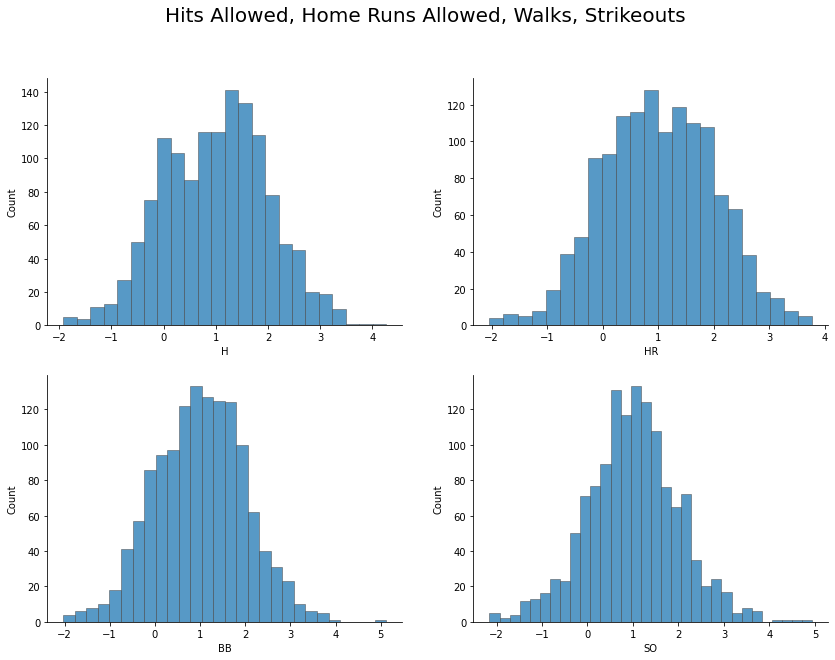

In [53]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(pitching_df_box_cox_z['H'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(pitching_df_box_cox_z['HR'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(pitching_df_box_cox_z['BB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(pitching_df_box_cox_z['SO'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Hits Allowed, Home Runs Allowed, Walks, Strikeouts', fontsize=GLOBAL_TITLE_SIZE)

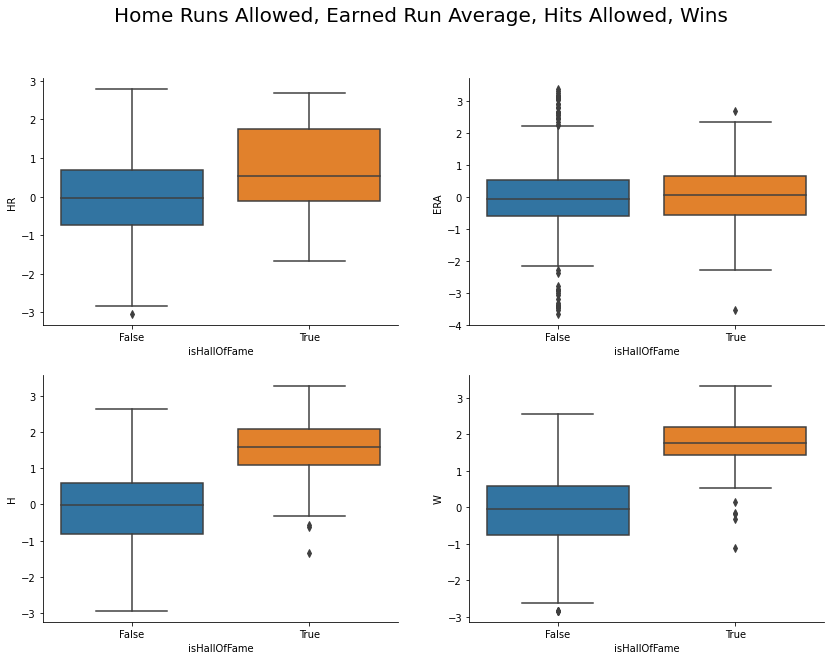

In [54]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.boxplot(data=pitching_df_box_cox_z,
             x='isHallOfFame',
             y='HR',
             ax=axs[0, 0])

sns.boxplot(data=pitching_df_box_cox_z,
             x='isHallOfFame',
             y='ERA',
             ax=axs[0, 1])

sns.boxplot(data=pitching_df_box_cox_z,
             x='isHallOfFame',
             y='H',
             ax=axs[1, 0])

sns.boxplot(data=pitching_df_box_cox_z,
             x='isHallOfFame',
             y='W',
             ax=axs[1, 1])

f.suptitle('Home Runs Allowed, Earned Run Average, Hits Allowed, Wins', fontsize=GLOBAL_TITLE_SIZE)

pitching_df_box_cox_z = pitching_df_box_cox_z.drop(columns=['isHallOfFame'])

Using a Box-Cox transformation here helped to satisfy our Normality assumption, but it didn't do as much for our homoskedasticity assumption.

## Correlation Matrix

Text(0.5, 1.0, 'Correlation of Pitching Features')

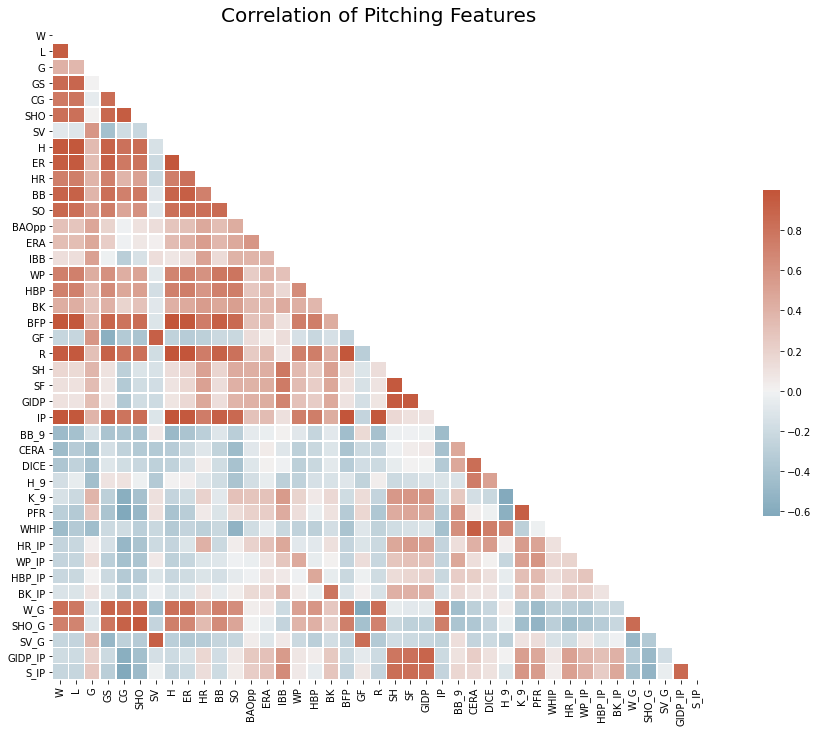

In [55]:
pitching_corr = pitching_df_box_cox_z.corr()
pitching_corr
mask = np.triu(np.ones_like(pitching_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pitching_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=False, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Pitching Features', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Pitching Feature Correlations')

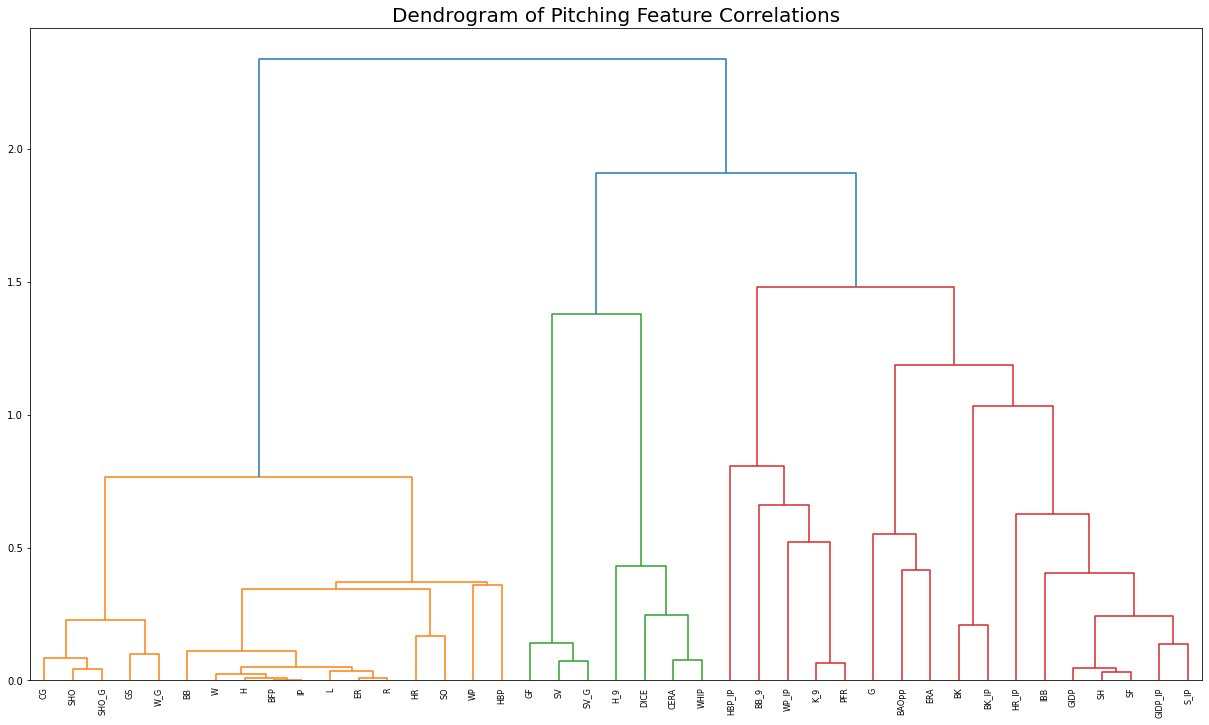

In [56]:
distance_matrix = 1 - np.abs(pitching_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(pitching_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Pitching Feature Correlations', fontsize=GLOBAL_TITLE_SIZE)

Once again, we need to remove variables that are highly correlated with the length of a player's career, so that only rates and ratios remain.

Text(0.5, 1.0, 'Correlation of Pitching Features')

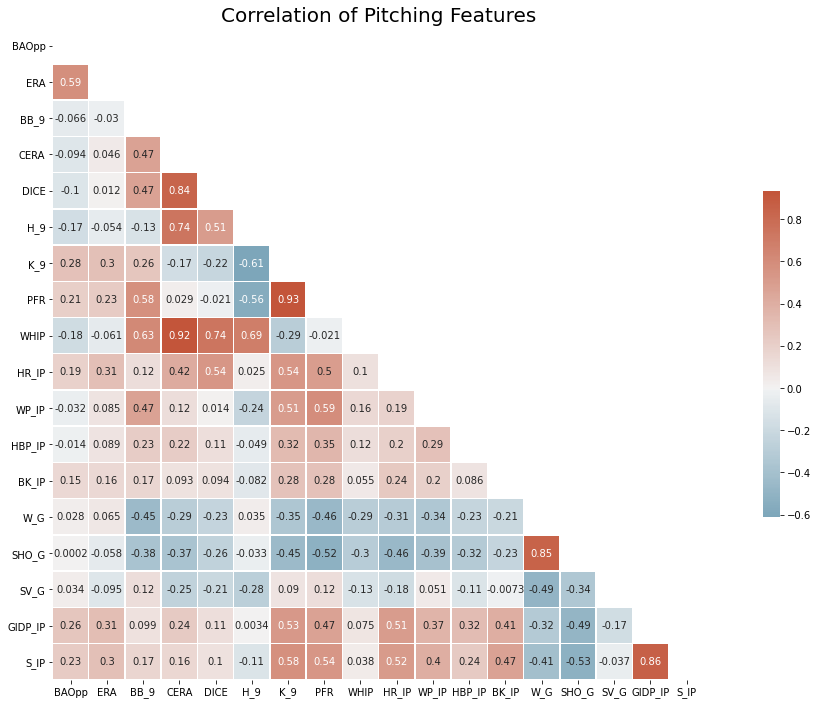

In [57]:
pitching_columns_to_drop = ['G', 'W', 'L', 'GS', 'GF', 'ER', 'R', 'SHO', 'SV',
                            'H', 'HR', 'BB', 'SO', 'WP', 'HBP', 'BFP', 'IP', 
                            'CG', 'BK', 'IBB', 'SH', 'SF', 'GIDP']
pitching_df_box_cox_z = pitching_df_box_cox_z.drop(columns=pitching_columns_to_drop)
pitching_df_box_cox_rounded_z = pitching_df_box_cox_rounded_z.drop(columns=pitching_columns_to_drop)

pitching_corr = pitching_df_box_cox_z.corr()
pitching_corr
mask = np.triu(np.ones_like(pitching_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pitching_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Pitching Features', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Pitching Feature Correlations')

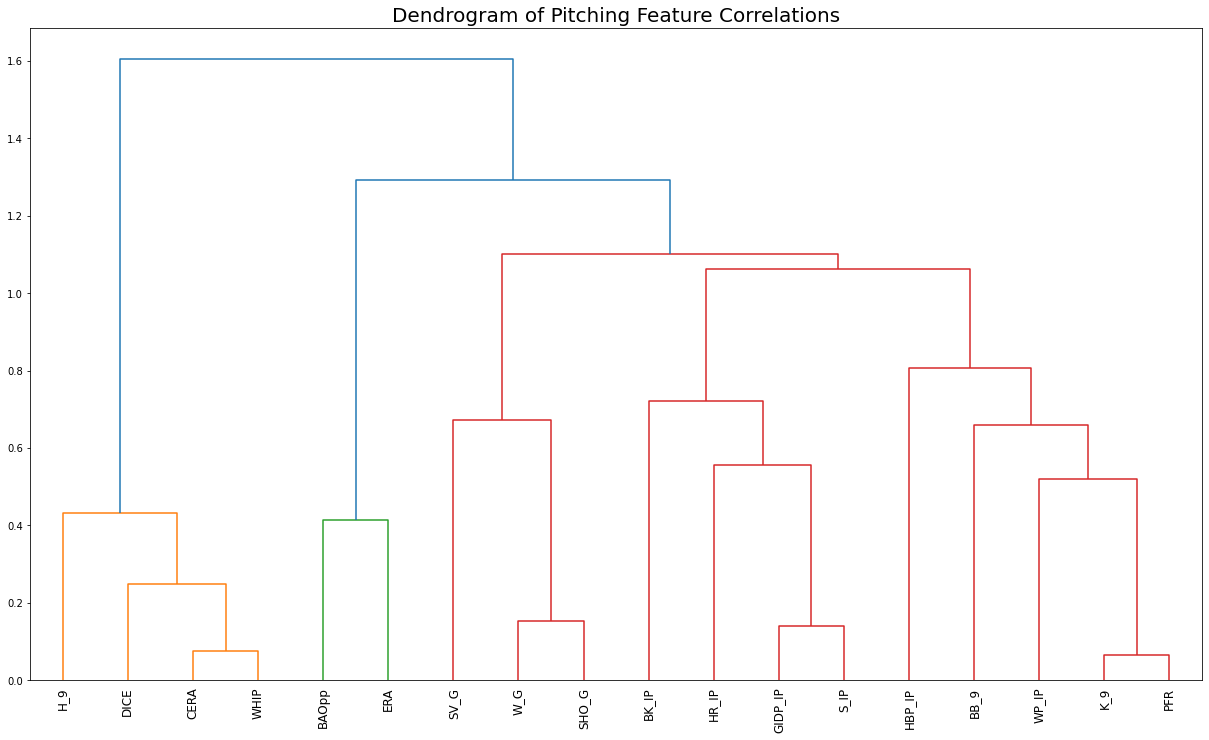

In [58]:
distance_matrix = 1 - np.abs(pitching_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(pitching_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Pitching Feature Correlations', fontsize=GLOBAL_TITLE_SIZE)

We can see that there are still some highly correlated features.

In [59]:
pitching_columns_to_drop = ['CERA', 'W_G', 'S_IP', 'PFR']
pitching_df_box_cox_z = pitching_df_box_cox_z.drop(columns=pitching_columns_to_drop)
pitching_df_box_cox_rounded_z = pitching_df_box_cox_rounded_z.drop(columns=pitching_columns_to_drop)

## Principal Component Analysis

Just as we did with the batting data, we will also use principal components analysis on the pitching data.

In [60]:
pitching_pca = PCA()
pitching_principle_components = pitching_pca.fit_transform(pitching_df_box_cox_z)
pitching_pca_df = pd.DataFrame(data=pitching_principle_components, 
                               columns=['PC ' + str(i+1) for i in range(len(pitching_df_box_cox_z.columns))])

pitching_pca_df

PC 1      PC 2      PC 3  ...     PC 12     PC 13     PC 14
0    -2.581884  0.147365  2.673930  ...  0.816452  0.060525  0.097934
1     0.156847  0.282815  0.980468  ...  0.446327 -0.029234 -0.013979
2     0.189590  1.863880 -1.839280  ... -0.400652  0.090942  0.032797
3    -0.644306  1.339632 -0.630143  ...  0.096953  0.030882 -0.016491
4    -2.906534  2.105486  0.003534  ... -1.004971 -0.069087  0.034249
...        ...       ...       ...  ...       ...       ...       ...
1326 -1.504314 -0.624493  0.313936  ... -0.250027 -0.009180  0.032265
1327 -0.896530 -2.000214 -0.347414  ... -0.158643 -0.049405 -0.032302
1328  0.136891 -0.809629 -1.559939  ...  0.359786 -0.058563  0.066047
1329 -1.547346 -0.249485 -1.202398  ... -0.504167 -0.006350  0.006630
1330  0.478036  1.983920  1.461993  ... -0.502079 -0.151643  0.024023

[1331 rows x 14 columns]

### Scree Plot

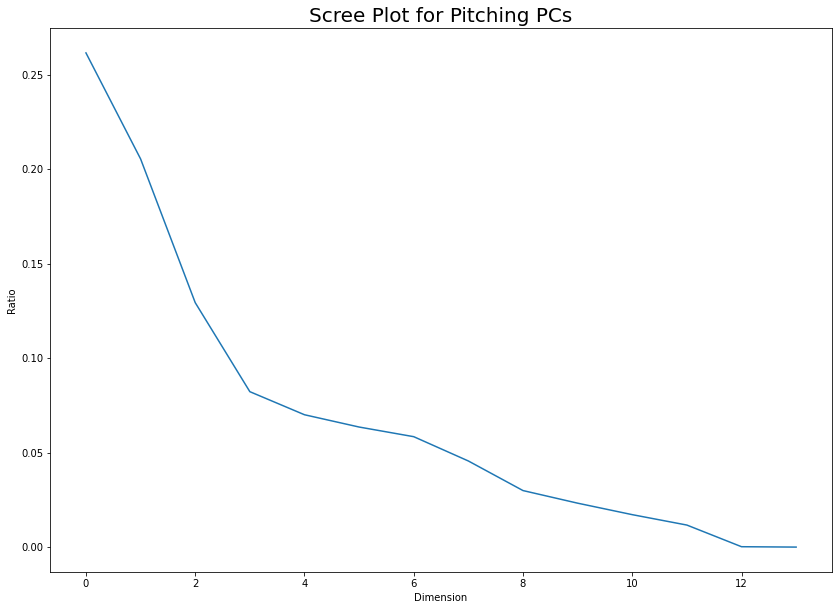

[0.26157917 0.46708198 0.59654584 0.67891077 0.7490717  0.81273052
 0.87128422 0.91698002 0.9470279  0.97040775 0.98771134 0.99951045
 0.99985523 1.        ]


In [61]:
ratio = pitching_pca.explained_variance_ratio_

f, axs = plt.subplots(figsize=SMALL_FIG_SIZE)
plt.plot(ratio)
plt.xlabel('Dimension')
plt.ylabel('Ratio')
axs.set_title('Scree Plot for Pitching PCs', fontsize=GLOBAL_TITLE_SIZE)
plt.show()

print(np.cumsum(ratio))

There's a clear dropoff in the variance explained after the first 3 PCs

- 90% variance explained after the first 8 PCs
- 95% variance explained after the first 10 PCs
- 99% variance explained after the first 12 PCs

In [62]:
pitching_pca_df = pitching_pca_df.drop(columns=['PC ' + str(i+1) for i in range(8, len(pitching_df_box_cox_z.columns))])   
pitching_pca_df['playerID'] = pitching_df['playerID'].reset_index(drop=True)
pitching_pca_df.columns = ['Pitching ' + col for col in pitching_pca_df.columns]
pitching_pca_df = pitching_pca_df.rename(columns={'Pitching playerID': 'playerID'})
pitching_pca_df

Pitching PC 1  Pitching PC 2  Pitching PC 3  ...  Pitching PC 7  \
0         -2.581884       0.147365       2.673930  ...       0.710434   
1          0.156847       0.282815       0.980468  ...       0.543727   
2          0.189590       1.863880      -1.839280  ...       0.568749   
3         -0.644306       1.339632      -0.630143  ...       0.086098   
4         -2.906534       2.105486       0.003534  ...       1.766109   
...             ...            ...            ...  ...            ...   
1326      -1.504314      -0.624493       0.313936  ...      -0.013005   
1327      -0.896530      -2.000214      -0.347414  ...      -2.250899   
1328       0.136891      -0.809629      -1.559939  ...       0.000597   
1329      -1.547346      -0.249485      -1.202398  ...       0.398765   
1330       0.478036       1.983920       1.461993  ...       1.088588   

      Pitching PC 8   playerID  
0         -0.945776  aardsda01  
1          0.806846   aasedo01  
2         -0.398700  abbotgl01  
3          0.605412  abbotji01  
4          0.676611  abbotpa01  
...             ...        ...  
1326      -0.612982  zambrca01  
1327      -0.188276  zieglbr01  
1328       0.038639  zimmejo02  
1329      -0.757420   zitoba01  
1330       1.186282  zuberbi01  

[1331 rows x 9 columns]

# Fielding Data

The final major category that players are evaluated on is their fielding. Once again, we will do the same thing here that we have done for batting and pitching.

In [63]:
# Combine the regular season and post season data
fielding_regular_df = pd.read_csv('baseballdatabank-master/core/Fielding.csv')
fielding_post_df = pd.read_csv('baseballdatabank-master/core/FieldingPost.csv')
fielding_df = pd.concat([fielding_regular_df, fielding_post_df])

# Remove yearID, stint, teamID and lgID from each player
fielding_df = fielding_df.drop(columns=['yearID', 'stint', 'teamID', 'lgID', 'ZR'])

fielding_keys = {'G': 'Games',
                 'GS': 'Games Started',
                 'InnOuts': 'Time Played in the Field Expressed as Outs',
                 'PO': 'Putouts',
                 'A': 'Assists',
                 'E': 'Errors',
                 'DP': 'Double Plays',
                 'TP': 'Triple Plays',
                 'PB': 'Passed Balls',
                 'WP': 'Wild Pitches',
                 'SB': 'Opponent Stolen Bases',
                 'CS': 'Opponents Caught Stealing',
                 'ZR': 'Zone Rating'}

For manipulation of the data, we will only work with players who are eligible for the Hall of Fame or players who are currently active and have played at least 500 games.  This will be done on all players, though there are some stats which will only apply to certain positions. 

In [64]:
# Players are listed multiple times, once per season, group them and get their careers as a whole
fielding_df = fielding_df.groupby(by='playerID', as_index=False).sum()

# We only want the eligible players
fielding_df = fielding_df.loc[(fielding_df['playerID'].isin(eligible_players['playerID'])) | 
                              (fielding_df['playerID'].isin(active_players500['playerID']))]
fielding_df = fielding_df.drop_duplicates()
fielding_df

playerID     G      GS  ...     SB     CS   TP
0      aardsda01   331     0.0  ...    0.0    0.0  0.0
1      aaronha01  3038  2994.0  ...    0.0    0.0  0.0
3       aasedo01   450    91.0  ...    0.0    0.0  0.0
7      abbated01   830   664.0  ...    0.0    0.0  0.0
12     abbotgl01   249   206.0  ...    0.0    0.0  0.0
...          ...   ...     ...  ...    ...    ...  ...
19683   zitoba01   443   431.0  ...    0.0    0.0  0.0
19684  zitzmbi01   307     0.0  ...    0.0    0.0  0.0
19686  zobribe01  1918  1559.0  ...    0.0    0.0  0.0
19690  zuberbi01   225     0.0  ...    0.0    0.0  0.0
19695  zuninmi01   711   656.0  ...  286.0  119.0  0.0

[3661 rows x 13 columns]

Catchers have different stats that they are evaluated on, such as "passed balls" and players caught stealing. So, they must be treated differently here.

In [65]:
catchers = appearances_df.loc[appearances_df['isCatcher']]
catchers_fielding_df = fielding_df.loc[fielding_df['playerID'].isin(catchers['playerID'])]
catchers_fielding_df = catchers_fielding_df.drop(columns=['TP']) # No catchers have Triple Plays, removing so Box-Cox Transformation is possible
catchers_fielding_df

playerID     G      GS  ...   WP      SB      CS
138    ainsmed01   996    27.0  ...  0.0    43.0    33.0
248    allisdo01   345   131.0  ...  0.0     0.0     0.0
268    alomasa02  1374  1250.0  ...  0.0   758.0   328.0
455    archeji01   808   185.0  ...  0.0   124.0   141.0
526    ashbyal01  1316  1202.0  ...  0.0  1112.0   445.0
...          ...   ...     ...  ...  ...     ...     ...
19476  wynegbu01  1249  1164.0  ...  0.0   708.0   478.0
19512  yeagest01  1268  1085.0  ...  0.0   595.0   365.0
19633   zaungr01  1073   910.0  ...  0.0   651.0   209.0
19663  zimmech01  1273     0.0  ...  0.0  1562.0  1208.0
19695  zuninmi01   711   656.0  ...  0.0   286.0   119.0

[402 rows x 12 columns]

Additionally, pitchers will also be evaluated differently from the other position players when it comes to fielding.

In [66]:
pitchers = appearances_df.loc[appearances_df['isPitcher']]
pitchers_fielding_df = fielding_df.loc[fielding_df['playerID'].isin(pitchers['playerID'])]
pitchers_fielding_df = pitchers_fielding_df.drop(columns=['PB', 'WP', 'SB', 'CS', 'TP']) # No pitchers have Triple Plays, removing so Box-Cox Transformation is possible
pitchers_fielding_df

playerID    G     GS  ...    A     E  DP
0      aardsda01  331    0.0  ...   29   3.0   2
3       aasedo01  450   91.0  ...  136  13.0  10
12     abbotgl01  249  206.0  ...  187  17.0  12
14     abbotji01  263  254.0  ...  300   9.0  16
18     abbotpa01  166  115.0  ...   80   6.0   8
...          ...  ...    ...  ...  ...   ...  ..
19619  zambrca01  359  307.0  ...  296  25.0  29
19654  zieglbr01  742    0.0  ...  165  14.0  15
19670  zimmejo02  280  277.0  ...  196  14.0   8
19683   zitoba01  443  431.0  ...  328  15.0  17
19690  zuberbi01  225    0.0  ...  107   5.0   9

[1331 rows x 8 columns]

We should now have three separated data sets to keep track of player fielding: one for pitchers, one for catchers, and one for everyone else.

In [67]:
fielding_df = fielding_df.loc[~fielding_df['playerID'].isin(catchers['playerID'])]
fielding_df = fielding_df.loc[~fielding_df['playerID'].isin(pitchers['playerID'])]
fielding_df = fielding_df.drop(columns=['PB', 'WP', 'SB', 'CS'])
fielding_df

playerID     G      GS  ...      E   DP   TP
1      aaronha01  3038  2994.0  ...  144.0  218  0.0
7      abbated01   830   664.0  ...  315.0  247  0.0
34     abreubo01  2155  2105.0  ...   74.0   24  0.0
37     abreujo02   811   810.0  ...   56.0  715  0.0
49     ackledu01   610   545.0  ...   18.0  190  0.0
...          ...   ...     ...  ...    ...  ...  ...
19664  zimmedo01  1005   843.0  ...  158.0  421  0.0
19673  zimmery01  1666  1632.0  ...  166.0  565  0.0
19682   ziskri01   910   887.0  ...   33.0   20  0.0
19684  zitzmbi01   307     0.0  ...   32.0    3  0.0
19686  zobribe01  1918  1559.0  ...   88.0  623  0.0

[1928 rows x 9 columns]

## Calculated Statistics

In [68]:
# Total Chances
fielding_df['TC'] = fielding_df.apply(lambda r: r['PO'] + r['A'] + r['E'], axis=1)
catchers_fielding_df['TC'] = catchers_fielding_df.apply(lambda r: r['PO'] + r['A'] + r['E'], axis=1)
pitchers_fielding_df['TC'] = pitchers_fielding_df.apply(lambda r: r['PO'] + r['A'] + r['E'], axis=1)
fielding_keys['TC'] = 'Total Chances'

# Fielding Percentage
fielding_df['FP'] = fielding_df.apply(lambda r: (r['PO'] + r['A']) / r['TC'], axis=1)
catchers_fielding_df['FP'] = catchers_fielding_df.apply(lambda r: (r['PO'] + r['A']) / r['TC'], axis=1)
pitchers_fielding_df['FP'] = pitchers_fielding_df.apply(lambda r: (r['PO'] + r['A']) / r['TC'], axis=1)
fielding_keys['FP'] = 'Fielding Percentage'

# Range Factor
def range_factor(r):
    innings_played = r['InnOuts'] / 3
    if innings_played == 0:
        return 0
    return (9 * (r['PO'] + r['A'])) / innings_played
fielding_df['RF'] = fielding_df.apply(lambda r: range_factor(r), axis=1)
catchers_fielding_df['RF'] = catchers_fielding_df.apply(lambda r: range_factor(r), axis=1)
pitchers_fielding_df['RF'] = pitchers_fielding_df.apply(lambda r: range_factor(r), axis=1)
fielding_keys['RF'] = 'Range Factor'

# Passed Balls per Wild Pitch
def pb_to_wp_ratio(r):
    if r['WP'] == 0:
        return 0
    return r['PB'] / r['WP']
catchers_fielding_df['PB_WP'] = catchers_fielding_df.apply(lambda r: pb_to_wp_ratio(r), axis=1)
fielding_keys['PB_WP'] = 'Passed Balls per Wild Pitch'

# Stolen Bases to Caught Stealing Ratio
def sb_to_cs_ratio(r):
    if r['SB'] + r['CS'] == 0:
        return 0
    return r['SB'] / (r['SB'] + r['CS'])
catchers_fielding_df['SB_CS'] = catchers_fielding_df.apply(lambda r: sb_to_cs_ratio(r), axis=1)
fielding_keys['SB_CS'] = 'Stolen Bases Percentage'

# Double Plays Per Game
fielding_df['DP_G'] = fielding_df.apply(lambda r: r['DP'] / r['G'], axis=1)
catchers_fielding_df['DP_G'] = catchers_fielding_df.apply(lambda r: r['DP'] / r['G'], axis=1)
pitchers_fielding_df['DP_G'] = pitchers_fielding_df.apply(lambda r: r['DP'] / r['G'], axis=1)
fielding_keys['DP_G'] = 'Double Plays Per Game'

# Triple Plays Per Game
fielding_df['TP_G'] = fielding_df.apply(lambda r: r['TP'] / r['G'], axis=1)
fielding_keys['TP_G'] = 'Triple Plays Per Game'

fielding_df['isHallOfFame'] = fielding_df.apply(lambda r: is_hall_of_fame_player(r), axis=1)
catchers_fielding_df['isHallOfFame'] = catchers_fielding_df.apply(lambda r: is_hall_of_fame_player(r), axis=1)
pitchers_fielding_df['isHallOfFame'] = pitchers_fielding_df.apply(lambda r: is_hall_of_fame_player(r), axis=1)
fielding_df

playerID     G      GS  ...      DP_G  TP_G  isHallOfFame
1      aaronha01  3038  2994.0  ...  0.071758   0.0          True
7      abbated01   830   664.0  ...  0.297590   0.0         False
34     abreubo01  2155  2105.0  ...  0.011137   0.0         False
37     abreujo02   811   810.0  ...  0.881628   0.0         False
49     ackledu01   610   545.0  ...  0.311475   0.0         False
...          ...   ...     ...  ...       ...   ...           ...
19664  zimmedo01  1005   843.0  ...  0.418905   0.0         False
19673  zimmery01  1666  1632.0  ...  0.339136   0.0         False
19682   ziskri01   910   887.0  ...  0.021978   0.0         False
19684  zitzmbi01   307     0.0  ...  0.009772   0.0         False
19686  zobribe01  1918  1559.0  ...  0.324818   0.0         False

[1928 rows x 15 columns]

## Exploratory Data Analysis

### Missing Data

<AxesSubplot:>

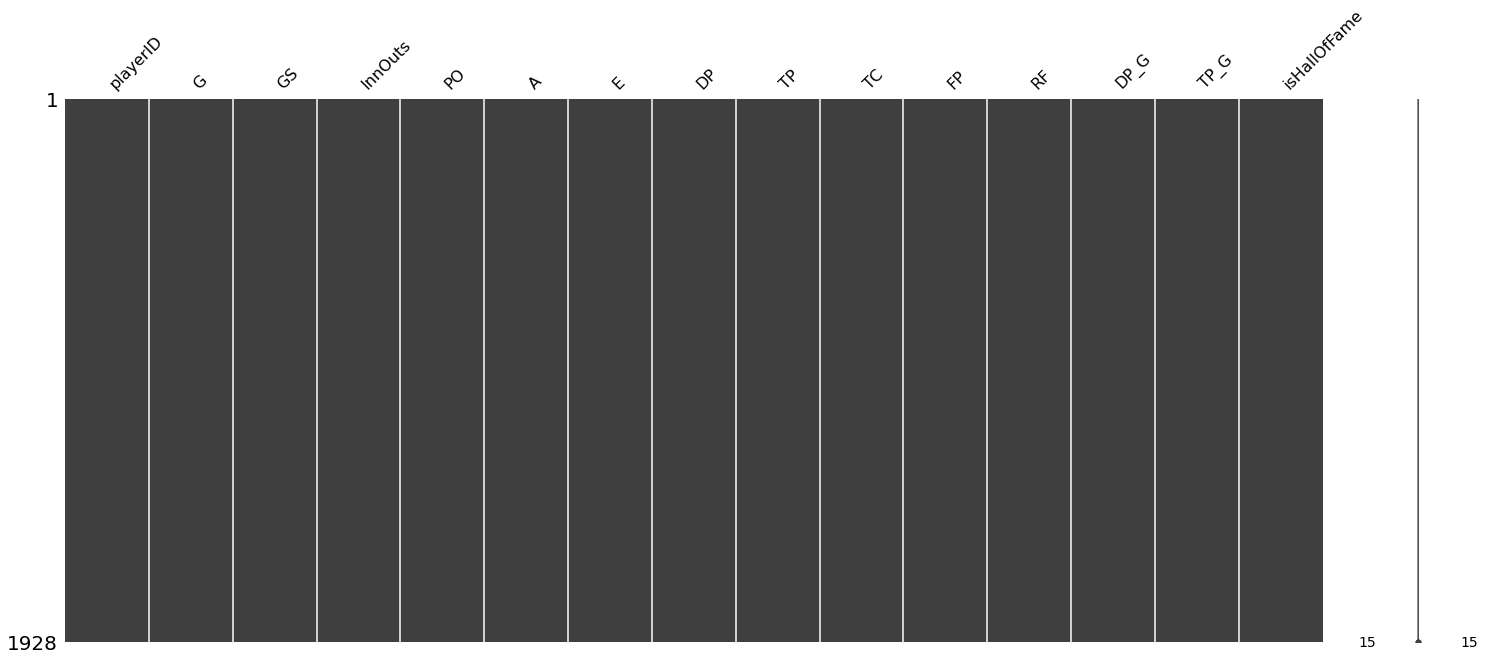

In [69]:
msno.matrix(fielding_df)

<AxesSubplot:>

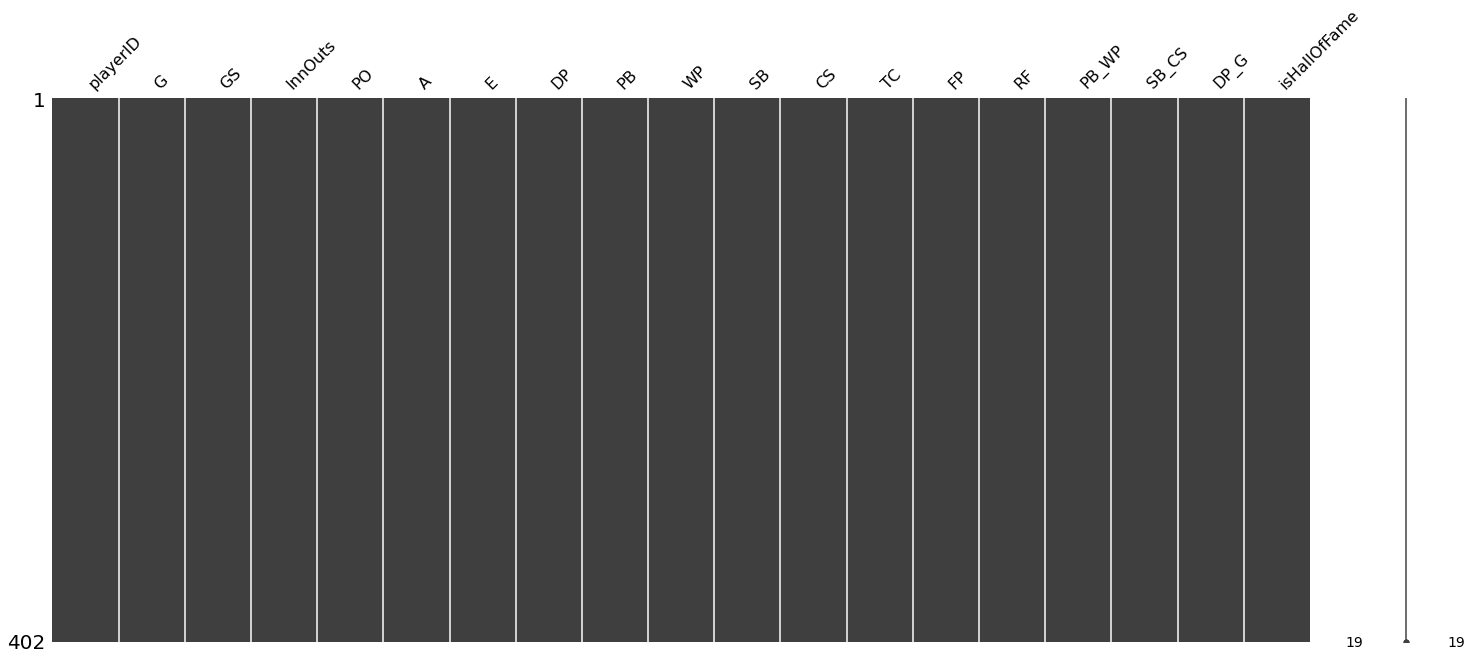

In [70]:
msno.matrix(catchers_fielding_df)

<AxesSubplot:>

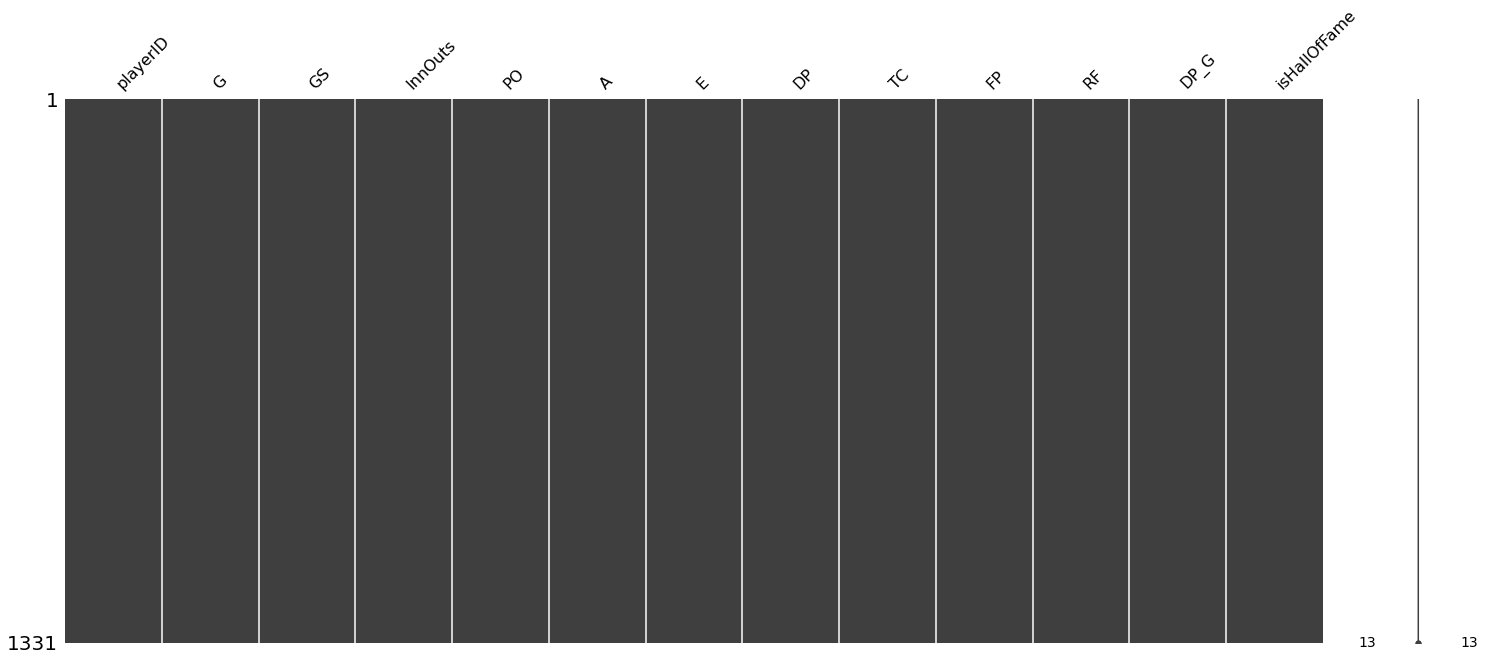

In [71]:
msno.matrix(pitchers_fielding_df)

There doesn't appear to be any missing values for fielding for any of the three position categories.

### Histograms

Text(0.5, 0.98, 'Games, Games Started, Outs Played, Putouts')

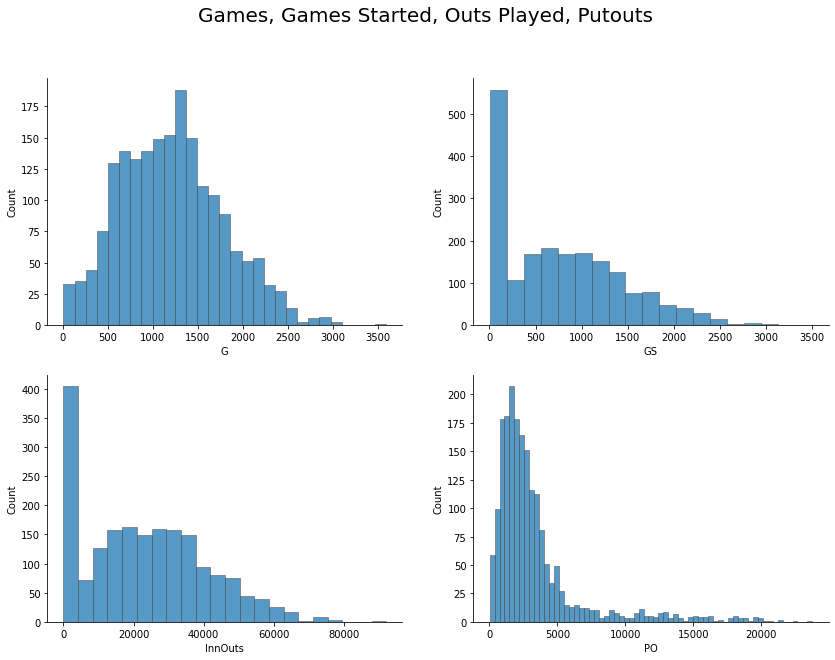

In [72]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(fielding_df['G'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(fielding_df['GS'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(fielding_df['InnOuts'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(fielding_df['PO'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Games, Games Started, Outs Played, Putouts', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Assists, Errors, Double Plays, Triple Plays')

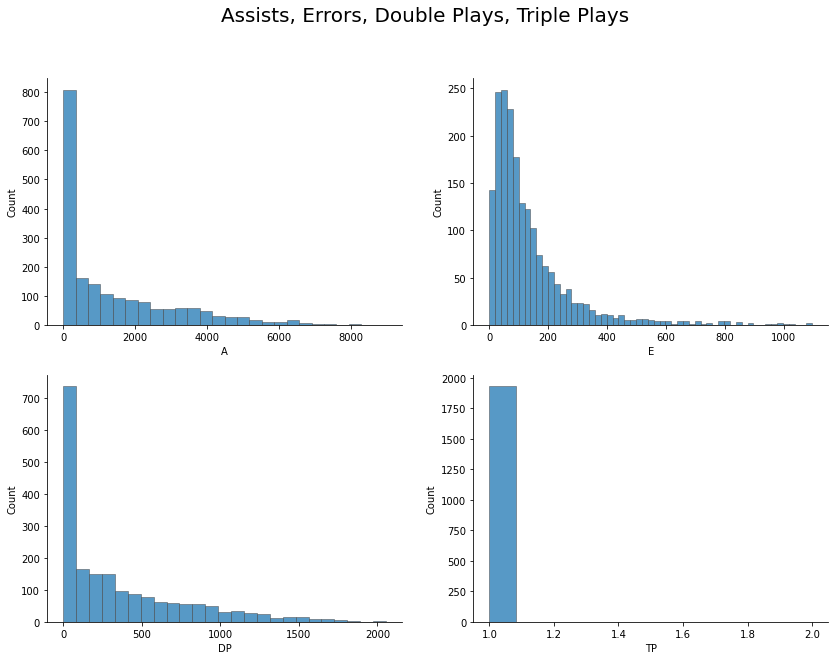

In [73]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(fielding_df['A'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(fielding_df['E'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(fielding_df['DP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(fielding_df['TP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Assists, Errors, Double Plays, Triple Plays', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 0.98, 'Passed Balls, Wild Pitches, Stolen Bases Allowed, Players Caught Stealing')

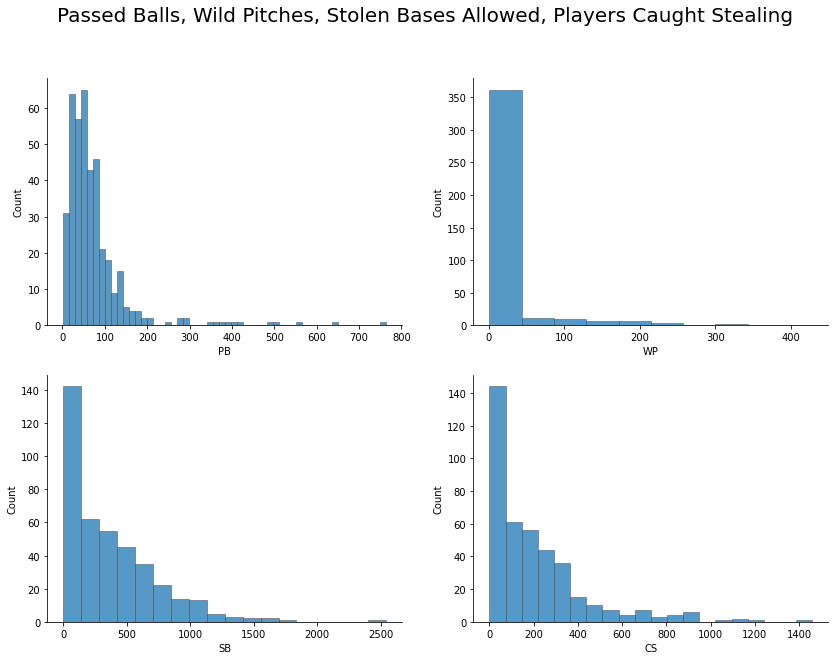

In [74]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(catchers_fielding_df['PB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(catchers_fielding_df['WP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(catchers_fielding_df['SB'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(catchers_fielding_df['CS'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Passed Balls, Wild Pitches, Stolen Bases Allowed, Players Caught Stealing', fontsize=GLOBAL_TITLE_SIZE)

Once again, it's pretty clear there is more skew here.

### Box Plots

Text(0.5, 0.98, 'Putouts, Errors, Players Caught Stealing, Fielding Percentage')

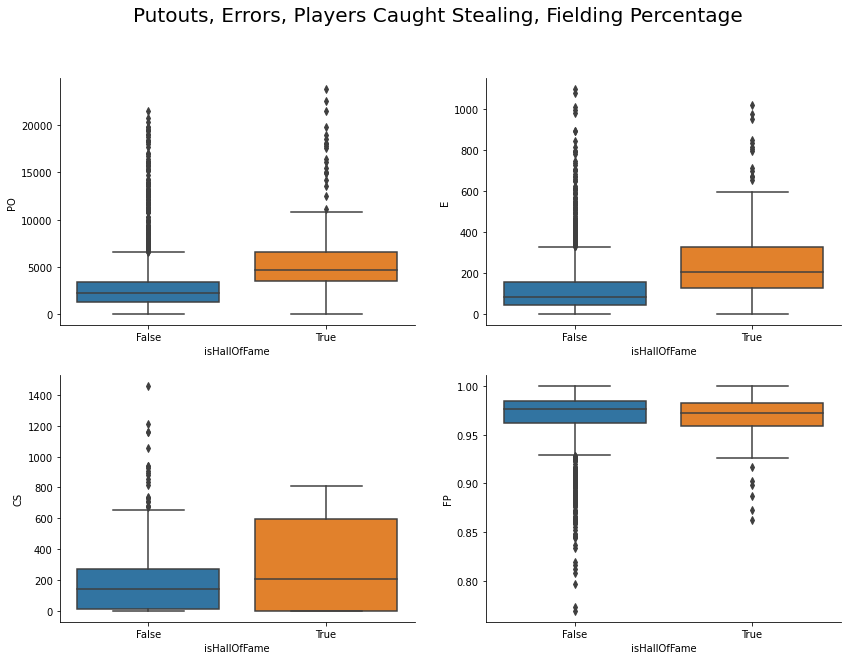

In [75]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.boxplot(data=fielding_df,
             x='isHallOfFame',
             y='PO',
             ax=axs[0, 0])

sns.boxplot(data=fielding_df,
             x='isHallOfFame',
             y='E',
             ax=axs[0, 1])

sns.boxplot(data=catchers_fielding_df,
             x='isHallOfFame',
             y='CS',
             ax=axs[1, 0])

sns.boxplot(data=fielding_df,
             x='isHallOfFame',
             y='FP',
             ax=axs[1, 1])

f.suptitle('Putouts, Errors, Players Caught Stealing, Fielding Percentage', fontsize=GLOBAL_TITLE_SIZE)

Heteroskedasticity seems like it may be an issue here again also.

## Box-Cox Transformation

Just as we did with the batting and pitching data, we will use the Box-Cox transformation on each of the three data sets.

In [76]:
fielding_df_box_cox = fielding_df.copy()
fielding_df_box_cox = fielding_df_box_cox.drop(columns=['playerID', 'isHallOfFame'])

fielding_df_box_cox_lambdas = fielding_df_box_cox.apply(lambda c: box_cox_column(c)[1]).to_frame()
fielding_df_box_cox_lambdas = fielding_df_box_cox_lambdas.rename(columns={0: 'True'})
fielding_df_box_cox_lambdas['Rounded'] = fielding_df_box_cox_lambdas.apply(lambda r: round(r['True'] * 2.0) / 2.0, 
                                                                         axis=1)

fielding_df_box_cox_rounded = fielding_df_box_cox.apply(lambda c: box_cox_column(c, fielding_df_box_cox_lambdas.at[c.name, 'Rounded'])[0])
fielding_df_box_cox = fielding_df_box_cox.apply(lambda c: box_cox_column(c)[0])

fielding_df_box_cox_rounded_z = fielding_df_box_cox_rounded.copy()
fielding_df_box_cox_rounded_z = fielding_df_box_cox_rounded_z.apply(lambda c: stats.zscore(c))
fielding_df_box_cox_z = fielding_df_box_cox.copy()
fielding_df_box_cox_z = fielding_df_box_cox_z.apply(lambda c: stats.zscore(c))

fielding_df_box_cox_z['isHallOfFame'] = fielding_df['isHallOfFame']
fielding_df_box_cox_z

G        GS   InnOuts  ...      DP_G     TP_G  isHallOfFame
1      2.742230  1.788297  1.834402  ... -0.796425 -0.02278          True
7     -0.603947  0.255618  0.237030  ...  0.314968 -0.02278         False
34     1.540539  1.351833  1.306543  ... -1.198901 -0.02278         False
37    -0.640089  0.413411  0.223218  ...  1.779065 -0.02278         False
49    -1.039355  0.109667 -0.097341  ...  0.368456 -0.02278         False
...         ...       ...       ...  ...       ...      ...           ...
19664 -0.281579  0.446506  0.284670  ...  0.740110 -0.02278         False
19673  0.813209  1.069325  0.978613  ...  0.471038 -0.02278         False
19682 -0.454338  0.489370  0.299875  ... -1.122686 -0.02278         False
19684 -1.727461 -1.666343 -1.950014  ... -1.208637 -0.02278         False
19686  1.194833  1.021226  0.935961  ...  0.418582 -0.02278         False

[1928 rows x 14 columns]

In [77]:
catchers_fielding_df_box_cox = catchers_fielding_df.copy()
catchers_fielding_df_box_cox = catchers_fielding_df_box_cox.drop(columns=['playerID', 'isHallOfFame'])

catchers_fielding_df_box_cox_lambdas = catchers_fielding_df_box_cox.apply(lambda c: box_cox_column(c)[1]).to_frame()
catchers_fielding_df_box_cox_lambdas = catchers_fielding_df_box_cox_lambdas.rename(columns={0: 'True'})
catchers_fielding_df_box_cox_lambdas['Rounded'] = catchers_fielding_df_box_cox_lambdas.apply(lambda r: round(r['True'] * 2.0) / 2.0, 
                                                                         axis=1)

catchers_fielding_df_box_cox_rounded = catchers_fielding_df_box_cox.apply(lambda c: box_cox_column(c, catchers_fielding_df_box_cox_lambdas.at[c.name, 'Rounded'])[0])
catchers_fielding_df_box_cox = catchers_fielding_df_box_cox.apply(lambda c: box_cox_column(c)[0])

catchers_fielding_df_box_cox_rounded_z = catchers_fielding_df_box_cox_rounded.copy()
catchers_fielding_df_box_cox_rounded_z = catchers_fielding_df_box_cox_rounded_z.apply(lambda c: stats.zscore(c))
catchers_fielding_df_box_cox_z = catchers_fielding_df_box_cox.copy()
catchers_fielding_df_box_cox_z = catchers_fielding_df_box_cox_z.apply(lambda c: stats.zscore(c))

catchers_fielding_df_box_cox_z['isHallOfFame'] = catchers_fielding_df['isHallOfFame']
catchers_fielding_df_box_cox_z

G        GS   InnOuts  ...     SB_CS      DP_G  isHallOfFame
138    0.406902 -0.834546 -0.996472  ... -0.029019  0.699096         False
248   -1.098065 -0.253473 -0.002803  ... -1.596981 -0.159630         False
268    1.069638  1.150762  1.046691  ...  0.817733 -0.909032         False
455    0.035614 -0.089452 -0.279390  ... -0.502722  1.639842         False
526    0.973743  1.118511  1.010399  ...  0.940508 -0.710402         False
...         ...       ...       ...  ...       ...       ...           ...
19476  0.860609  1.092301  1.000932  ...  0.147601 -0.125142         False
19512  0.892958  1.035731  0.928256  ...  0.285553 -0.569269         False
19633  0.549888  0.898698  0.786567  ...  1.286344 -0.763958         False
19663  0.901436 -1.505588  1.031175  ... -0.039307  1.119474         False
19695 -0.170934  0.660143  0.516264  ...  0.879235 -1.389013         False

[402 rows x 18 columns]

In [78]:
pitchers_fielding_df_box_cox = pitchers_fielding_df.copy()
pitchers_fielding_df_box_cox = pitchers_fielding_df_box_cox.drop(columns=['playerID', 'isHallOfFame'])

pitchers_fielding_df_box_cox_lambdas = pitchers_fielding_df_box_cox.apply(lambda c: box_cox_column(c)[1]).to_frame()
pitchers_fielding_df_box_cox_lambdas = pitchers_fielding_df_box_cox_lambdas.rename(columns={0: 'True'})
pitchers_fielding_df_box_cox_lambdas['Rounded'] = pitchers_fielding_df_box_cox_lambdas.apply(lambda r: round(r['True'] * 2.0) / 2.0, 
                                                                         axis=1)

pitchers_fielding_df_box_cox_rounded = pitchers_fielding_df_box_cox.apply(lambda c: box_cox_column(c, pitchers_fielding_df_box_cox_lambdas.at[c.name, 'Rounded'])[0])
pitchers_fielding_df_box_cox = pitchers_fielding_df_box_cox.apply(lambda c: box_cox_column(c)[0])

pitchers_fielding_df_box_cox_rounded_z = pitchers_fielding_df_box_cox_rounded.copy()
pitchers_fielding_df_box_cox_rounded_z = pitchers_fielding_df_box_cox_rounded_z.apply(lambda c: stats.zscore(c))
pitchers_fielding_df_box_cox_z = pitchers_fielding_df_box_cox.copy()
pitchers_fielding_df_box_cox_z = pitchers_fielding_df_box_cox_z.apply(lambda c: stats.zscore(c))

pitchers_fielding_df_box_cox_z['isHallOfFame'] = pitchers_fielding_df['isHallOfFame']
pitchers_fielding_df_box_cox_z

G        GS   InnOuts  ...        RF      DP_G  isHallOfFame
0     -0.426740 -1.307830 -0.509924  ... -0.581092 -1.487750         False
3      0.186083  0.455135  0.277046  ... -0.195787 -0.663118         False
12    -0.897040  0.870394  0.397065  ...  0.028292  0.369599         False
14    -0.813162  0.983064  0.632978  ... -0.014947  0.769683         False
18    -1.435462  0.570225 -0.032238  ... -0.154023  0.369599         False
...         ...       ...       ...  ...       ...       ...           ...
19619 -0.276187  1.087251  0.799895  ...  0.029455  1.293895         False
19654  1.479977 -1.307830 -0.052276  ...  0.230343 -0.756907         False
19670 -0.713458  1.030452  0.602883  ... -0.175337 -0.380692         False
19683  0.151812  1.279197  1.097899  ... -0.328895  0.015750         False
19690 -1.044933 -1.307830 -1.719219  ...  2.165957  0.077168         False

[1331 rows x 12 columns]

Text(0.5, 0.98, 'Assists, Errors, Double Plays, Putouts')

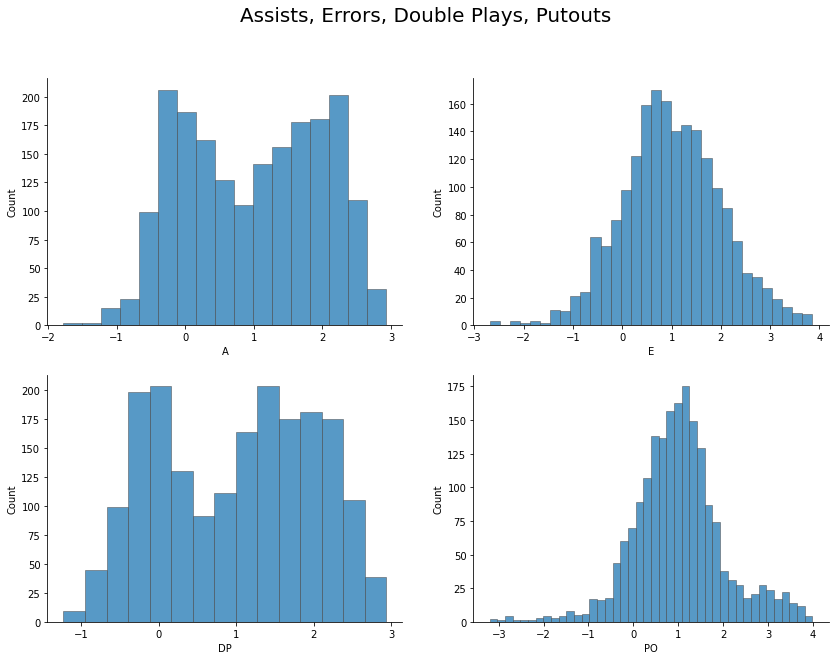

In [79]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.histplot(fielding_df_box_cox_z['A'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 0])

sns.histplot(fielding_df_box_cox_z['E'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[0, 1])

sns.histplot(fielding_df_box_cox_z['DP'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 0])

sns.histplot(fielding_df_box_cox_z['PO'].apply(lambda r: r+1),
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             ax=axs[1, 1])

f.suptitle('Assists, Errors, Double Plays, Putouts', fontsize=GLOBAL_TITLE_SIZE)

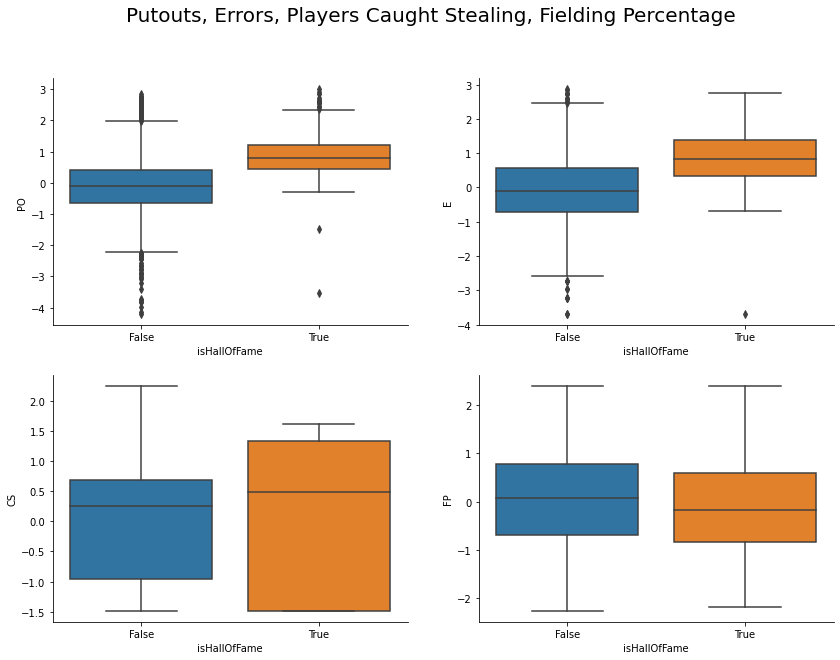

In [80]:
f, axs = plt.subplots(nrows=2, 
                      ncols=2, 
                      figsize=SMALL_FIG_SIZE)
sns.despine(f)

sns.boxplot(data=fielding_df_box_cox_z,
             x='isHallOfFame',
             y='PO',
             ax=axs[0, 0])

sns.boxplot(data=fielding_df_box_cox_z,
             x='isHallOfFame',
             y='E',
             ax=axs[0, 1])

sns.boxplot(data=catchers_fielding_df_box_cox_z,
             x='isHallOfFame',
             y='CS',
             ax=axs[1, 0])

sns.boxplot(data=fielding_df_box_cox_z,
             x='isHallOfFame',
             y='FP',
             ax=axs[1, 1])

f.suptitle('Putouts, Errors, Players Caught Stealing, Fielding Percentage', fontsize=GLOBAL_TITLE_SIZE)

fielding_df_box_cox_z = fielding_df_box_cox_z.drop(columns=['isHallOfFame'])
catchers_fielding_df_box_cox_z = catchers_fielding_df_box_cox_z.drop(columns=['isHallOfFame'])
pitchers_fielding_df_box_cox_z = pitchers_fielding_df_box_cox_z.drop(columns=['isHallOfFame'])

Using a Box-Cox transformation here helped to satisfy our Normality assumption but didn't do as much for our homoskedasticity assumption.

## Correlation Matrix

Text(0.5, 1.0, 'Correlation of Fielding Features')

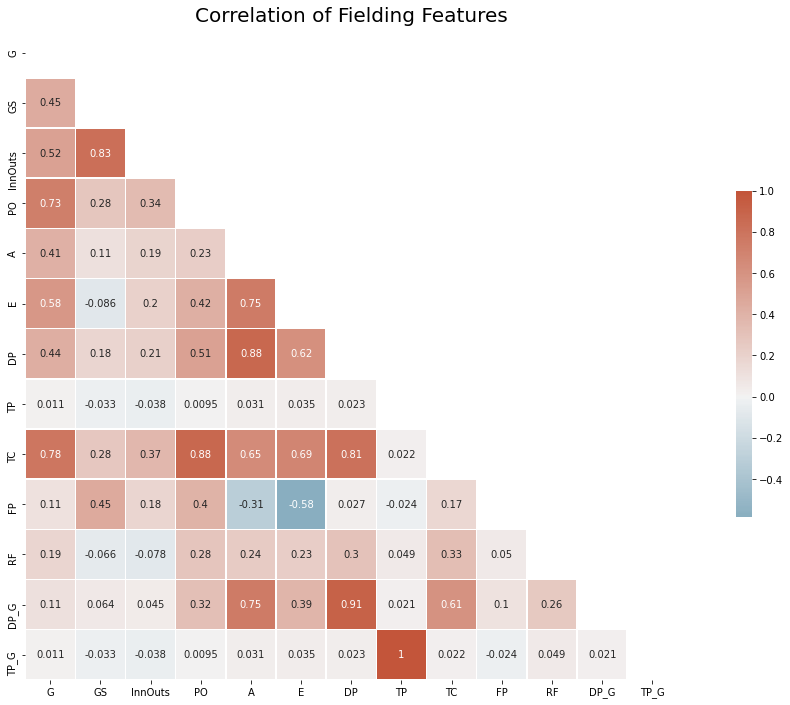

In [81]:
fielding_corr = fielding_df_box_cox_z.corr()
fielding_corr
mask = np.triu(np.ones_like(fielding_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(fielding_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Fielding Features', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Fielding Feature Correlations')

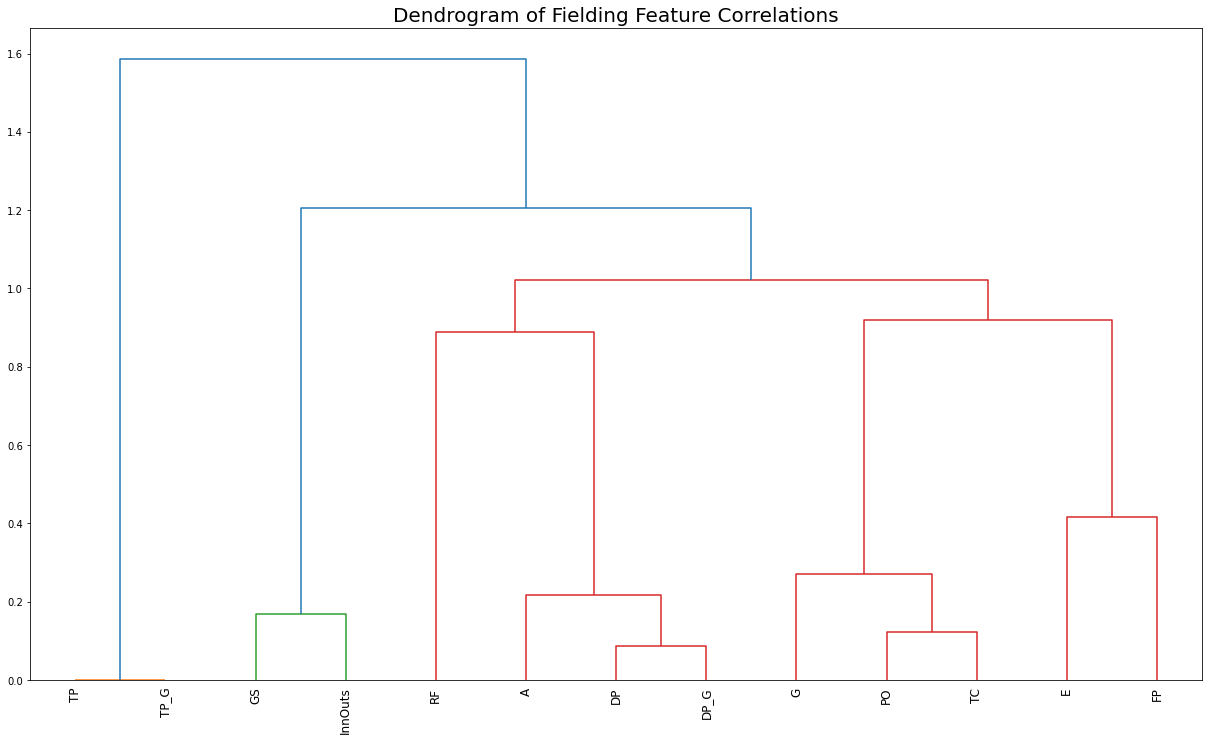

In [82]:
distance_matrix = 1 - np.abs(fielding_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(fielding_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Fielding Feature Correlations', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Correlation of Fielding Features for Catchers')

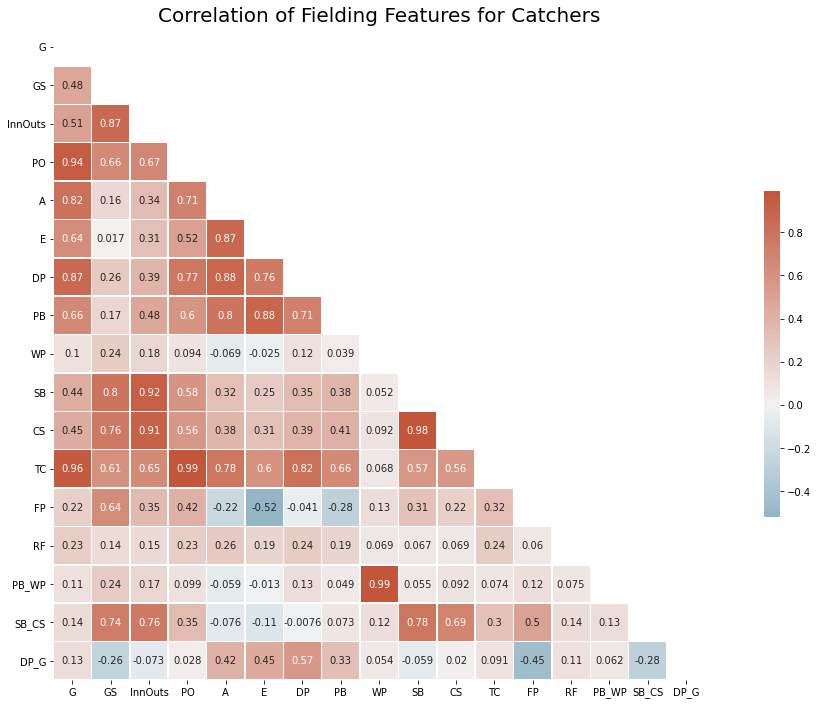

In [83]:
catchers_fielding_corr = catchers_fielding_df_box_cox_z.corr()
catchers_fielding_corr
mask = np.triu(np.ones_like(catchers_fielding_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(catchers_fielding_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Fielding Features for Catchers', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Fielding Feature Correlations for Catchers')

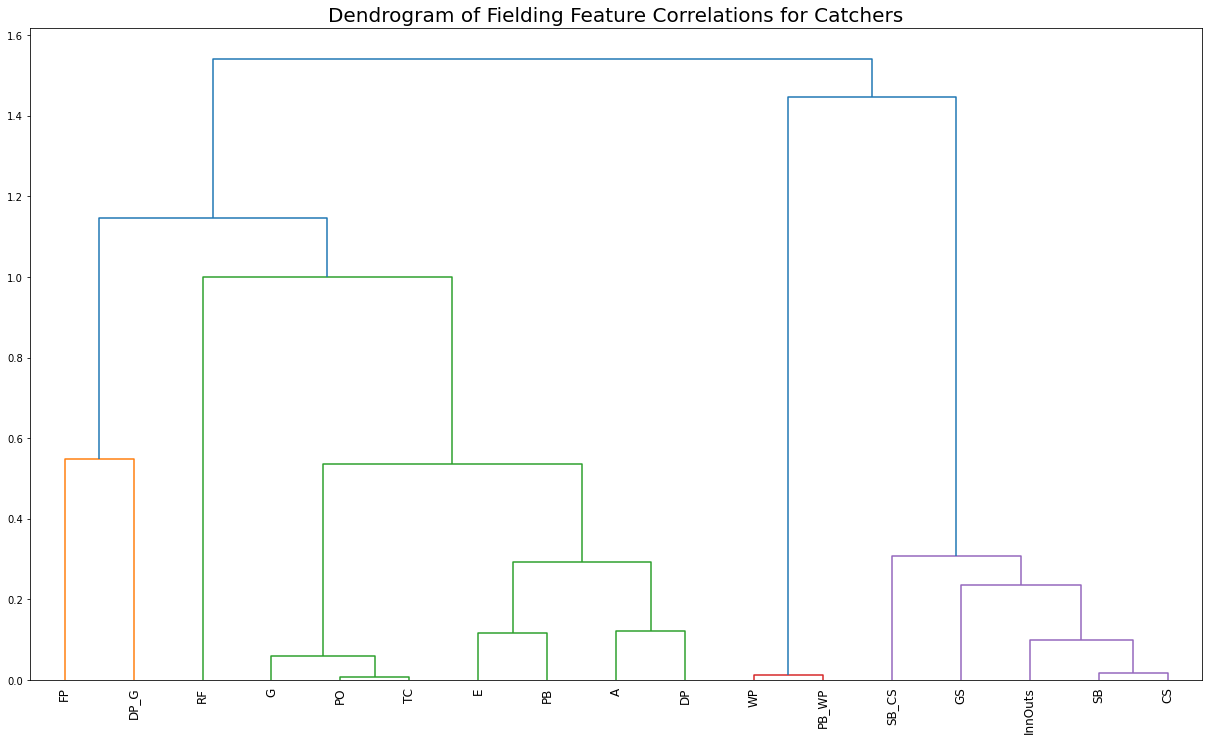

In [84]:
distance_matrix = 1 - np.abs(catchers_fielding_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(catchers_fielding_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Fielding Feature Correlations for Catchers', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Correlation of Fielding Features for Pitchers')

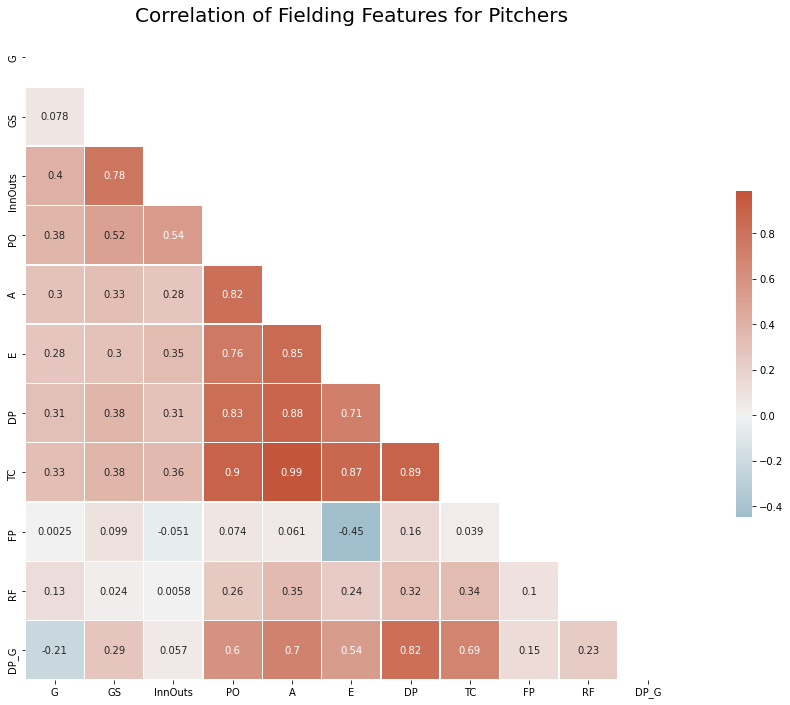

In [85]:
pitchers_fielding_corr = pitchers_fielding_df_box_cox_z.corr()
pitchers_fielding_corr
mask = np.triu(np.ones_like(pitchers_fielding_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pitchers_fielding_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Fielding Features for Pitchers', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Fielding Feature Correlations for Pitchers')

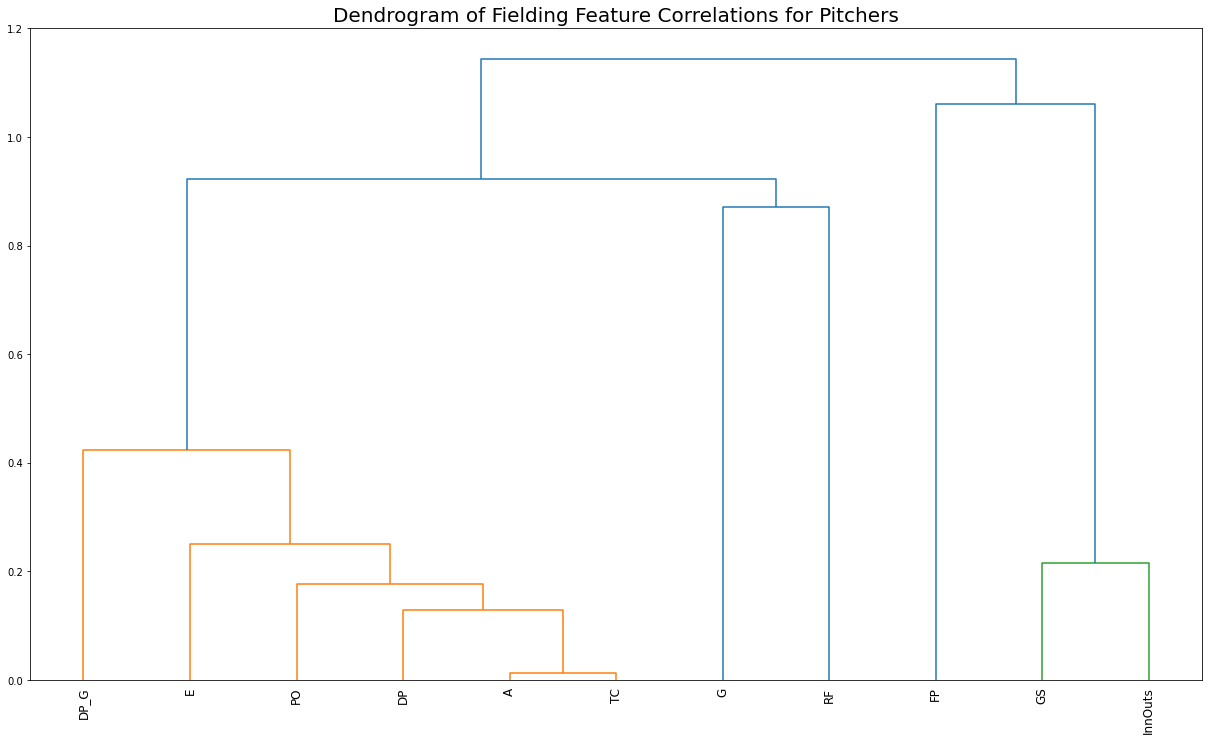

In [86]:
distance_matrix = 1 - np.abs(pitchers_fielding_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(pitchers_fielding_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Fielding Feature Correlations for Pitchers', fontsize=GLOBAL_TITLE_SIZE)

Once again, we need to remove variables that are highly correlated with the length of a players career, so that only rates and ratios remain.

In [87]:
fielding_columns_to_drop = ['G', 'GS', 'InnOuts', 'PO', 'A', 'E', 'TC', 'DP']

fielding_df_box_cox_z = fielding_df_box_cox_z.drop(columns=fielding_columns_to_drop + ['TP'])
catchers_fielding_df_box_cox_z = catchers_fielding_df_box_cox_z.drop(columns=fielding_columns_to_drop + ['PB', 'WP', 'SB', 'CS'])
pitchers_fielding_df_box_cox_z = pitchers_fielding_df_box_cox_z.drop(columns=fielding_columns_to_drop)

fielding_df_box_cox_rounded_z = fielding_df_box_cox_rounded_z.drop(columns=fielding_columns_to_drop + ['TP'])
catchers_fielding_df_box_cox_rounded_z = catchers_fielding_df_box_cox_rounded_z.drop(columns=fielding_columns_to_drop + ['PB', 'WP', 'SB', 'CS'])
pitchers_fielding_df_box_cox_rounded_z = pitchers_fielding_df_box_cox_rounded_z.drop(columns=fielding_columns_to_drop)

Text(0.5, 1.0, 'Correlation of Fielding Features')

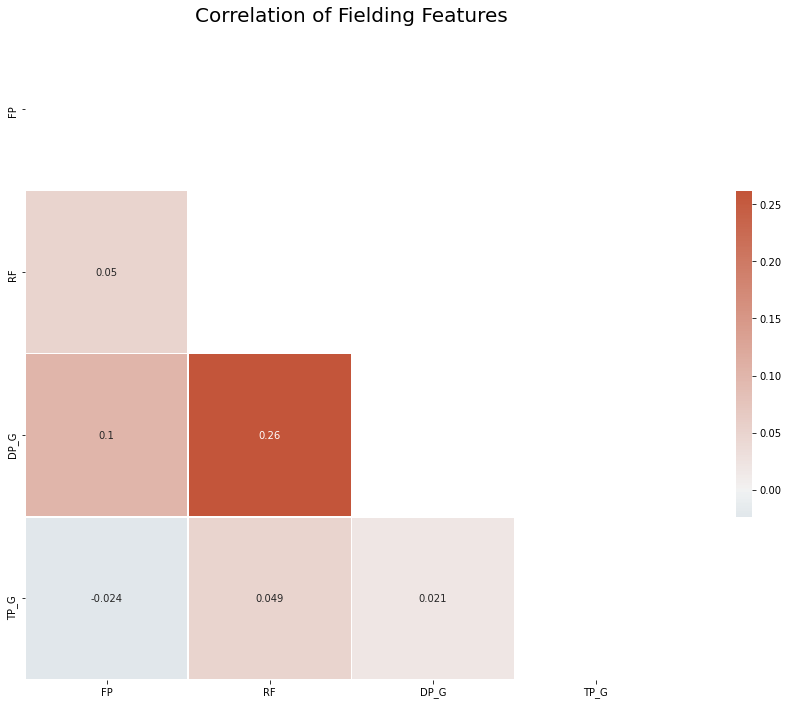

In [88]:
fielding_corr = fielding_df_box_cox_z.corr()
fielding_corr
mask = np.triu(np.ones_like(fielding_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(fielding_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Fielding Features', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Fielding Feature Correlations')

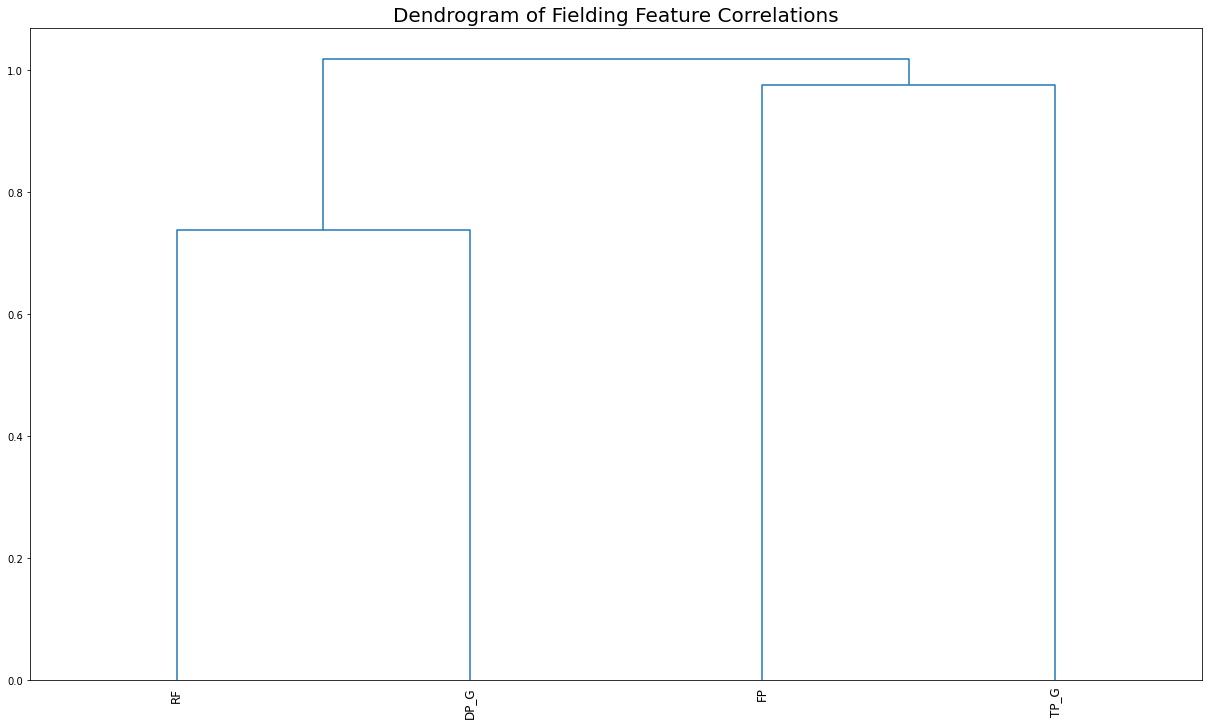

In [89]:
distance_matrix = 1 - np.abs(fielding_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(fielding_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Fielding Feature Correlations', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Correlation of Fielding Features for Catchers')

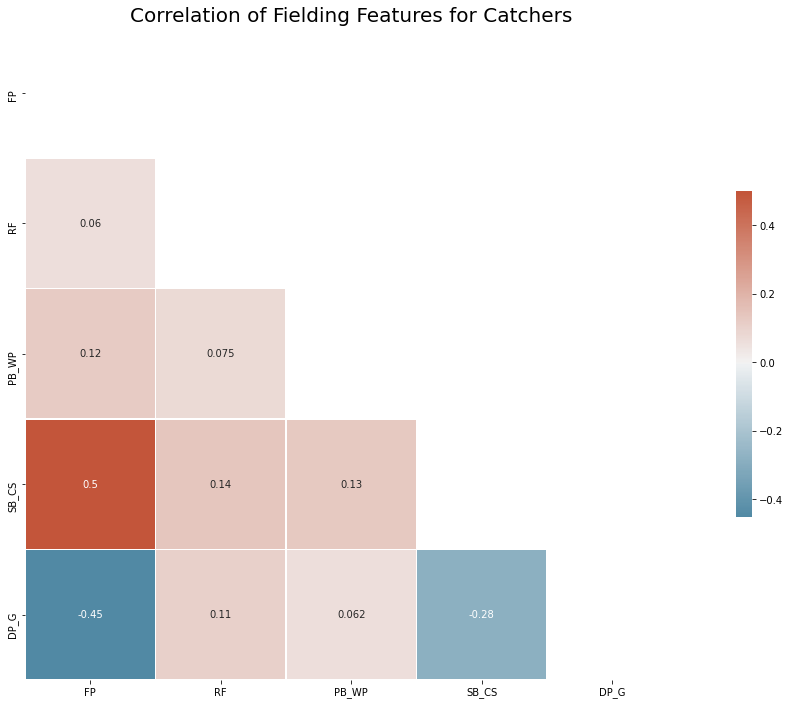

In [90]:
catchers_fielding_corr = catchers_fielding_df_box_cox_z.corr()
catchers_fielding_corr
mask = np.triu(np.ones_like(catchers_fielding_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(catchers_fielding_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Fielding Features for Catchers', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Fielding Feature Correlations for Catchers')

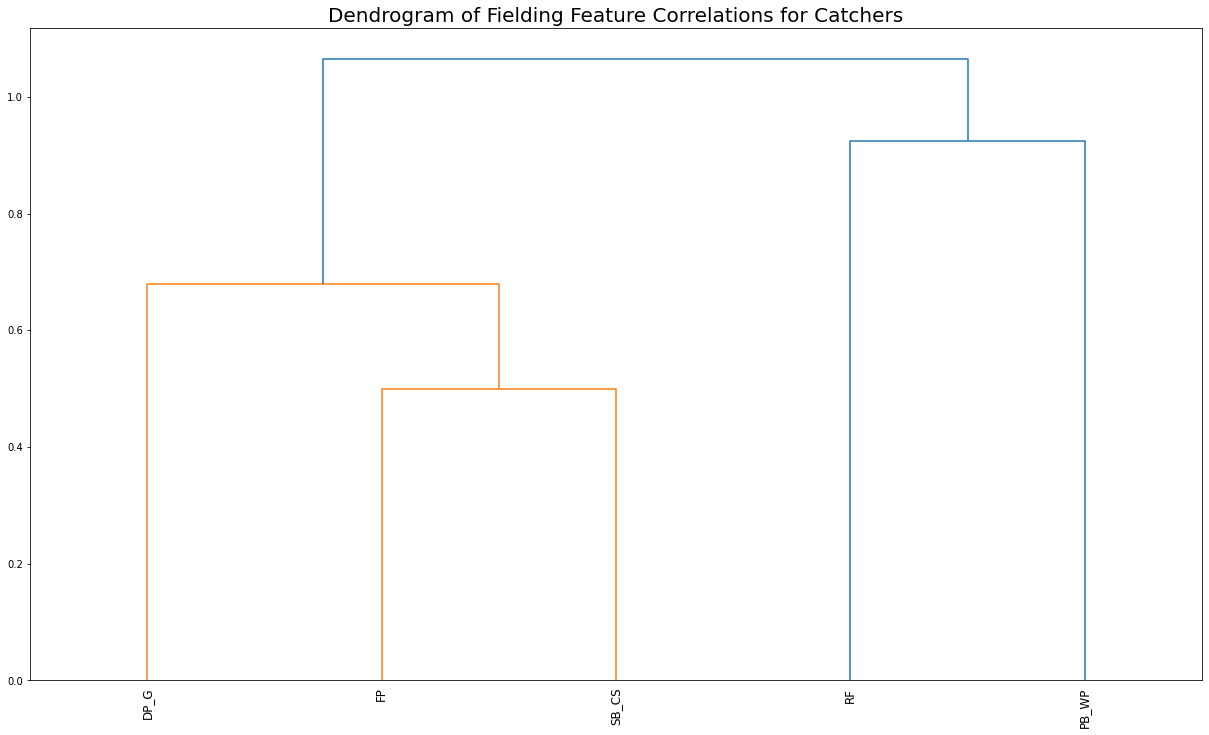

In [91]:
distance_matrix = 1 - np.abs(catchers_fielding_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(catchers_fielding_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Fielding Feature Correlations for Catchers', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Correlation of Fielding Features for Pitchers')

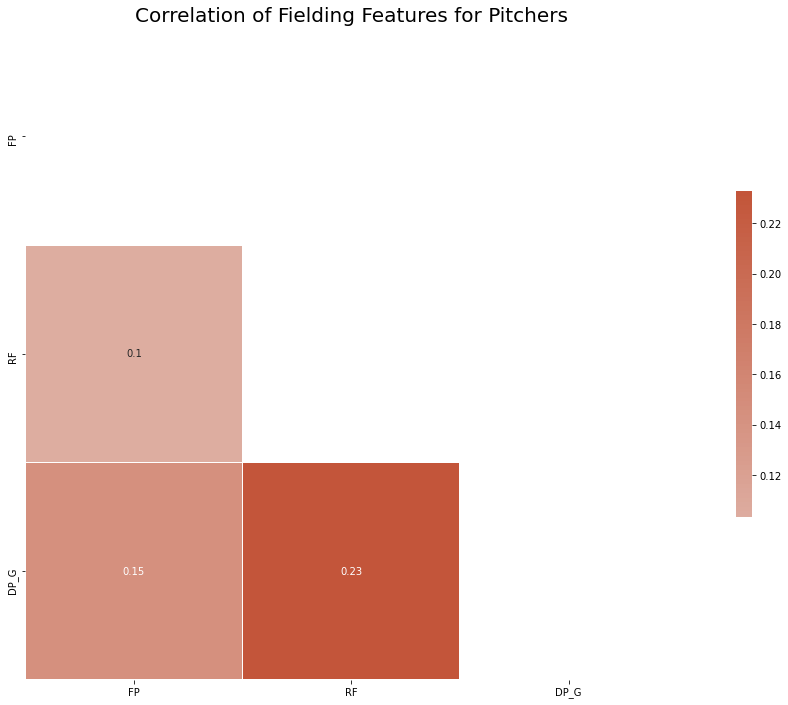

In [92]:
pitchers_fielding_corr = pitchers_fielding_df_box_cox_z.corr()
pitchers_fielding_corr
mask = np.triu(np.ones_like(pitchers_fielding_corr, dtype=bool))
f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pitchers_fielding_corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation of Fielding Features for Pitchers', fontsize=GLOBAL_TITLE_SIZE)

Text(0.5, 1.0, 'Dendrogram of Fielding Feature Correlations for Pitchers')

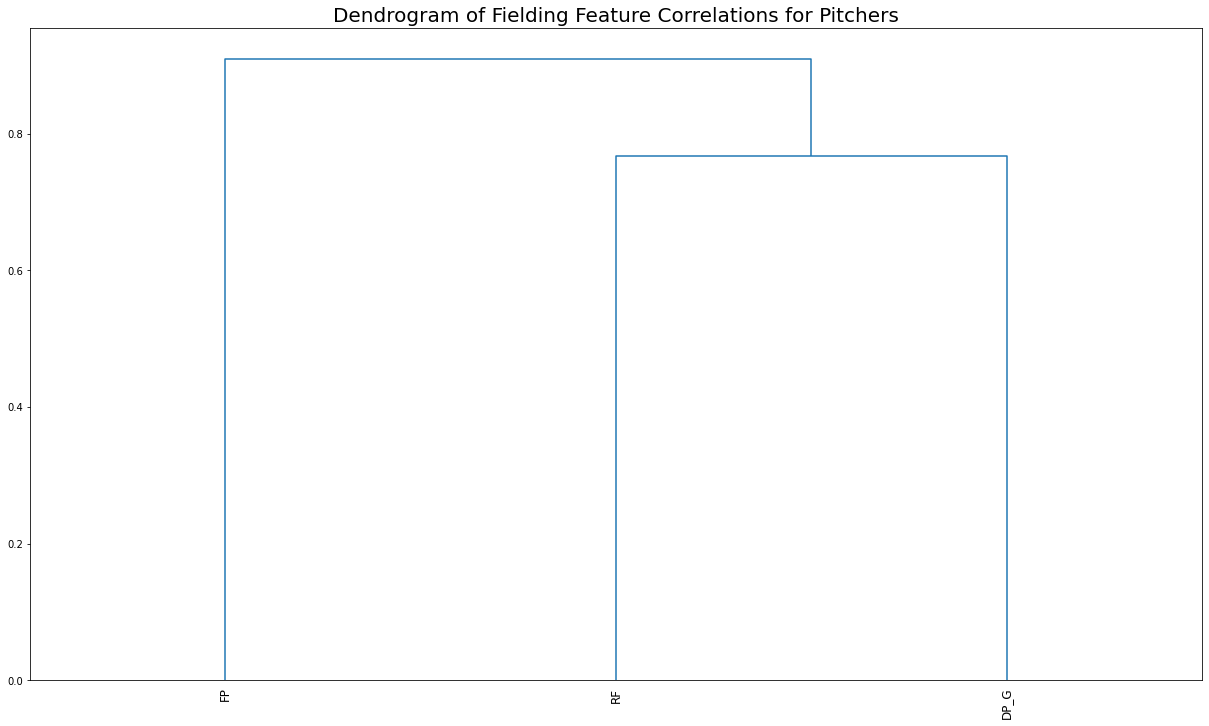

In [93]:
distance_matrix = 1 - np.abs(pitchers_fielding_corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
dendro = hierarchy.dendrogram(dist_linkage, labels=list(pitchers_fielding_df_box_cox_z.columns), ax=ax, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title('Dendrogram of Fielding Feature Correlations for Pitchers', fontsize=GLOBAL_TITLE_SIZE)

## Principal Component Analysis

And finally, we will do PCA one more time on the three data sets.

In [94]:
fielding_pca = PCA()
fielding_principle_components = fielding_pca.fit_transform(fielding_df_box_cox_z)
fielding_pca_df = pd.DataFrame(data=fielding_principle_components, 
                               columns=['PC ' + str(i+1) for i in range(len(fielding_df_box_cox_z.columns))])

fielding_pca_df

PC 1      PC 2      PC 3      PC 4
0    -0.615949 -0.359798  0.641358 -0.385857
1    -0.214536  0.930210 -1.337313  0.344997
2    -1.040519 -0.397949  0.800964 -0.509358
3     2.029718 -0.824920  0.606052  0.690532
4     0.576415 -0.810916  0.957639  0.178686
...        ...       ...       ...       ...
1923  0.287282  0.394414 -0.718622  0.599442
1924  0.361652 -0.105812 -0.001664  0.312636
1925 -0.998867 -0.362674  0.736833 -0.456761
1926 -2.706096  0.304514  0.038345  0.886735
1927  0.425284 -0.471442  0.501526  0.290724

[1928 rows x 4 columns]

In [95]:
catchers_fielding_pca = PCA()
catchers_fielding_principle_components = catchers_fielding_pca.fit_transform(catchers_fielding_df_box_cox_z)
catchers_fielding_pca_df = pd.DataFrame(data=catchers_fielding_principle_components, 
                                        columns=['PC ' + str(i+1) for i in range(len(catchers_fielding_df_box_cox_z.columns))])

catchers_fielding_pca_df

PC 1      PC 2      PC 3      PC 4      PC 5
0    1.096837 -1.176777 -1.376238  0.058445  0.704614
1    2.308597  0.644065 -0.113499  0.971102  1.018789
2   -1.219111  0.532070 -0.434902 -0.088274  0.255353
3    1.719904 -0.949353 -0.777937 -0.501156 -0.173993
4   -0.928332  0.426608 -0.429279 -0.300397  0.547224
..        ...       ...       ...       ...       ...
397 -0.438569  0.369629 -0.289059 -0.164888 -0.386457
398 -0.604644  0.493210 -0.354893  0.038530  0.039635
399 -1.230408  0.364743 -0.489282 -0.478690  0.636333
400  1.760365 -0.192201 -0.235300 -0.825809  0.816902
401 -2.083333  0.649709 -0.551626  0.227728 -0.218835

[402 rows x 5 columns]

### Scree Plot

In [96]:
pitchers_fielding_pca = PCA()
pitchers_fielding_principle_components = pitchers_fielding_pca.fit_transform(pitchers_fielding_df_box_cox_z)
pitchers_fielding_pca_df = pd.DataFrame(data=pitchers_fielding_principle_components, 
                                        columns=['PC ' + str(i+1) for i in range(len(pitchers_fielding_df_box_cox_z.columns))])

pitchers_fielding_pca_df

PC 1      PC 2      PC 3
0    -1.807652 -0.343995 -0.542694
1    -0.885204 -0.396587 -0.240833
2     0.036344 -0.484504  0.333064
3     1.026323  0.836025  0.385031
4     0.209708  0.115322  0.350052
...        ...       ...       ...
1326  0.679747 -0.582250  0.998219
1327 -0.729019 -0.648531 -0.572628
1328 -0.365998  0.129222 -0.161901
1329  0.028477  0.543236  0.147774
1330  1.560158 -0.645298 -1.423989

[1331 rows x 3 columns]

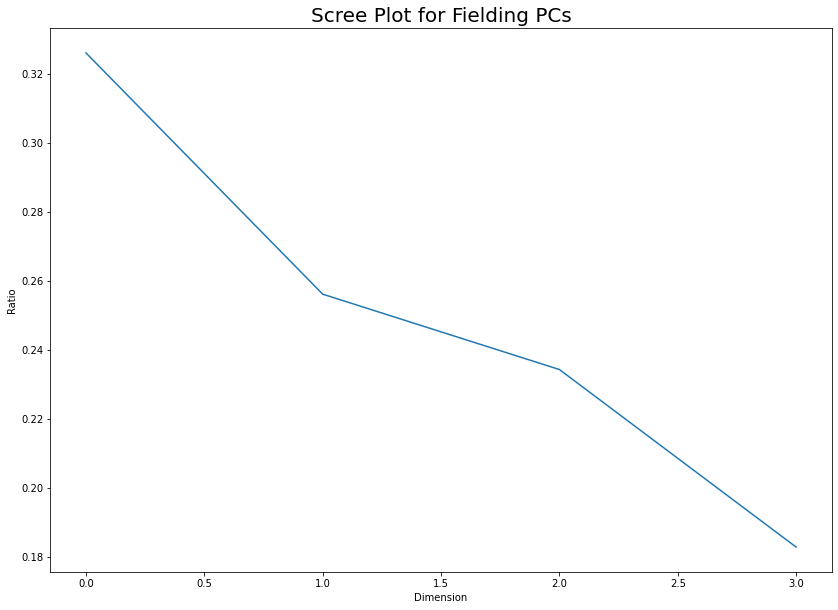

[0.32625735 0.58256667 0.81702485 1.        ]


In [97]:
ratio = fielding_pca.explained_variance_ratio_

f, axs = plt.subplots(figsize=SMALL_FIG_SIZE)
plt.plot(ratio)
plt.xlabel('Dimension')
plt.ylabel('Ratio')
axs.set_title('Scree Plot for Fielding PCs', fontsize=GLOBAL_TITLE_SIZE)
plt.show()

print(np.cumsum(ratio))

There isn't much of a drop off in variance explained since there are so few variables.

- 90% variance explained after the first 4 PCs
- 95% variance explained after the first 4 PCs
- 99% variance explained after the first 4 PCs

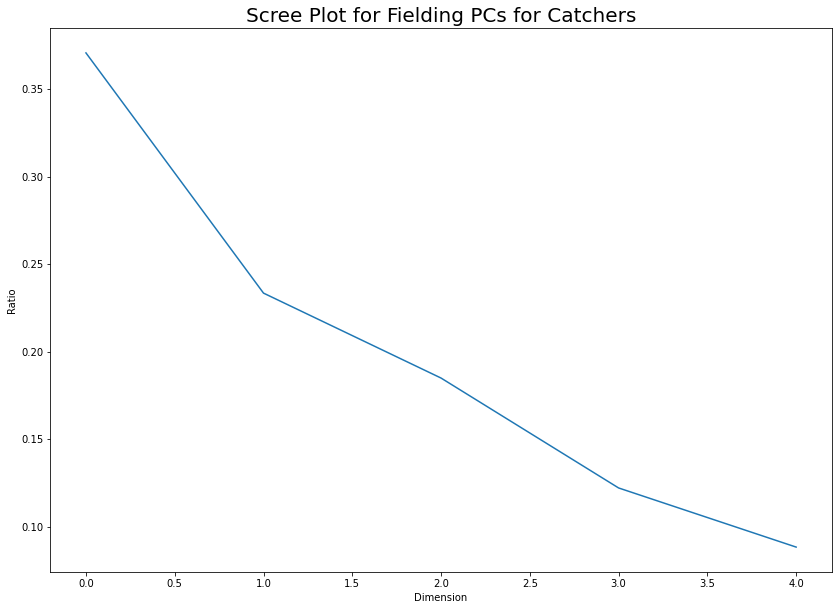

[0.37052267 0.60401837 0.7890525  0.91139459 1.        ]


In [98]:
ratio = catchers_fielding_pca.explained_variance_ratio_

f, axs = plt.subplots(figsize=SMALL_FIG_SIZE)
plt.plot(ratio)
plt.xlabel('Dimension')
plt.ylabel('Ratio')
axs.set_title('Scree Plot for Fielding PCs for Catchers', fontsize=GLOBAL_TITLE_SIZE)
plt.show()

print(np.cumsum(ratio))

There isn't much of a drop off in variance explained since there are so few variables.

- 90% variance explained after the first 4 PCs
- 95% variance explained after the first 5 PCs
- 99% variance explained after the first 5 PCs

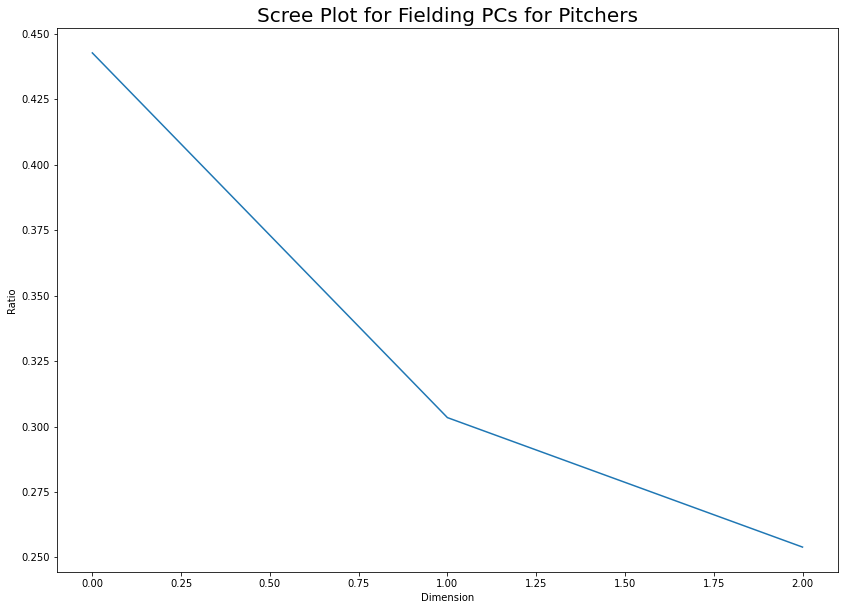

[0.44263072 0.74603056 1.        ]


In [99]:
ratio = pitchers_fielding_pca.explained_variance_ratio_

f, axs = plt.subplots(figsize=SMALL_FIG_SIZE)
plt.plot(ratio)
plt.xlabel('Dimension')
plt.ylabel('Ratio')
axs.set_title('Scree Plot for Fielding PCs for Pitchers', fontsize=GLOBAL_TITLE_SIZE)
plt.show()

print(np.cumsum(ratio))

There isn't much of a drop off in variance explained since there are so few variables.

- 90% variance explained after the first 3 PCs
- 95% variance explained after the first 3 PCs
- 99% variance explained after the first 3 PCs

In [100]:
fielding_pca_df = fielding_pca_df.drop(columns=['PC ' + str(i+1) for i in range(4, len(fielding_df_box_cox_z.columns))])    
fielding_pca_df['playerID'] = fielding_df['playerID'].reset_index(drop=True)
fielding_pca_df.columns = ['Fielding ' + col for col in fielding_pca_df.columns]
fielding_pca_df = fielding_pca_df.rename(columns={'Fielding playerID': 'playerID'})
fielding_pca_df

Fielding PC 1  Fielding PC 2  Fielding PC 3  Fielding PC 4   playerID
0         -0.615949      -0.359798       0.641358      -0.385857  aaronha01
1         -0.214536       0.930210      -1.337313       0.344997  abbated01
2         -1.040519      -0.397949       0.800964      -0.509358  abreubo01
3          2.029718      -0.824920       0.606052       0.690532  abreujo02
4          0.576415      -0.810916       0.957639       0.178686  ackledu01
...             ...            ...            ...            ...        ...
1923       0.287282       0.394414      -0.718622       0.599442  zimmedo01
1924       0.361652      -0.105812      -0.001664       0.312636  zimmery01
1925      -0.998867      -0.362674       0.736833      -0.456761   ziskri01
1926      -2.706096       0.304514       0.038345       0.886735  zitzmbi01
1927       0.425284      -0.471442       0.501526       0.290724  zobribe01

[1928 rows x 5 columns]

In [101]:
catchers_fielding_pca_df = catchers_fielding_pca_df.drop(columns=['PC ' + str(i+1) for i in range(4, len(catchers_fielding_df_box_cox_z.columns))])  
catchers_fielding_pca_df['playerID'] = catchers_fielding_df['playerID'].reset_index(drop=True)
catchers_fielding_pca_df.columns = ['Catcher Fielding ' + col for col in catchers_fielding_pca_df.columns]
catchers_fielding_pca_df = catchers_fielding_pca_df.rename(columns={'Catcher Fielding playerID': 'playerID'})
catchers_fielding_pca_df

Catcher Fielding PC 1  Catcher Fielding PC 2  Catcher Fielding PC 3  \
0                 1.096837              -1.176777              -1.376238   
1                 2.308597               0.644065              -0.113499   
2                -1.219111               0.532070              -0.434902   
3                 1.719904              -0.949353              -0.777937   
4                -0.928332               0.426608              -0.429279   
..                     ...                    ...                    ...   
397              -0.438569               0.369629              -0.289059   
398              -0.604644               0.493210              -0.354893   
399              -1.230408               0.364743              -0.489282   
400               1.760365              -0.192201              -0.235300   
401              -2.083333               0.649709              -0.551626   

     Catcher Fielding PC 4   playerID  
0                 0.058445  ainsmed01  
1                 0.971102  allisdo01  
2                -0.088274  alomasa02  
3                -0.501156  archeji01  
4                -0.300397  ashbyal01  
..                     ...        ...  
397              -0.164888  wynegbu01  
398               0.038530  yeagest01  
399              -0.478690   zaungr01  
400              -0.825809  zimmech01  
401               0.227728  zuninmi01  

[402 rows x 5 columns]

In [102]:
pitchers_fielding_pca_df = pitchers_fielding_pca_df.drop(columns=['PC ' + str(i+1) for i in range(3, len(pitchers_fielding_df_box_cox_z.columns))])  
pitchers_fielding_pca_df['playerID'] = pitchers_fielding_df['playerID'].reset_index(drop=True)
pitchers_fielding_pca_df.columns = ['Pitcher Fielding ' + col for col in pitchers_fielding_pca_df.columns]
pitchers_fielding_pca_df = pitchers_fielding_pca_df.rename(columns={'Pitcher Fielding playerID': 'playerID'})
pitchers_fielding_pca_df

Pitcher Fielding PC 1  Pitcher Fielding PC 2  Pitcher Fielding PC 3  \
0                 -1.807652              -0.343995              -0.542694   
1                 -0.885204              -0.396587              -0.240833   
2                  0.036344              -0.484504               0.333064   
3                  1.026323               0.836025               0.385031   
4                  0.209708               0.115322               0.350052   
...                     ...                    ...                    ...   
1326               0.679747              -0.582250               0.998219   
1327              -0.729019              -0.648531              -0.572628   
1328              -0.365998               0.129222              -0.161901   
1329               0.028477               0.543236               0.147774   
1330               1.560158              -0.645298              -1.423989   

       playerID  
0     aardsda01  
1      aasedo01  
2     abbotgl01  
3     abbotji01  
4     abbotpa01  
...         ...  
1326  zambrca01  
1327  zieglbr01  
1328  zimmejo02  
1329   zitoba01  
1330  zuberbi01  

[1331 rows x 4 columns]

# Combine Data

To evaluate the players as a whole, and not just the individual components of their game, these data sets now need to be combined. Pitchers will be evaluated on thier pitching and their respective fielding data. All other position players will be evaluated on thier batting and their respective fielding data.

## PCA Data

When it comes to building a model that helps to predict whether a player should or shouldn't be a member of the Hall of Fame, we will use the PCA data.  This data should be best suited for our models, and therefore, should make the best predictions.

In [103]:
position_pca_df = fielding_pca_df.join(batting_pca_df, how='left', lsuffix='_fielding', rsuffix='_batting')
position_pca_df = position_pca_df.drop(columns=['playerID_batting'])
position_pca_df = position_pca_df.rename(columns={'playerID_fielding': 'playerID'})
position_pca_df

Fielding PC 1  Fielding PC 2  Fielding PC 3  ...  Batting PC 4  \
0         -0.615949      -0.359798       0.641358  ...      0.365831   
1         -0.214536       0.930210      -1.337313  ...      0.944844   
2         -1.040519      -0.397949       0.800964  ...      0.145588   
3          2.029718      -0.824920       0.606052  ...      0.252235   
4          0.576415      -0.810916       0.957639  ...      0.198742   
...             ...            ...            ...  ...           ...   
1923       0.287282       0.394414      -0.718622  ...      0.297317   
1924       0.361652      -0.105812      -0.001664  ...      0.291866   
1925      -0.998867      -0.362674       0.736833  ...     -0.839135   
1926      -2.706096       0.304514       0.038345  ...     -0.174993   
1927       0.425284      -0.471442       0.501526  ...     -0.406109   

     Batting PC 5  Batting PC 6  
0       -0.731564      0.187357  
1       -0.184954      0.453299  
2       -0.189653      0.074177  
3       -0.883645     -0.161240  
4        0.395037     -0.127119  
...           ...           ...  
1923    -0.737043      0.730161  
1924     0.412557     -0.204459  
1925    -0.685050      0.440006  
1926     0.176463     -0.030642  
1927    -0.817567     -0.347786  

[1928 rows x 11 columns]

<AxesSubplot:>

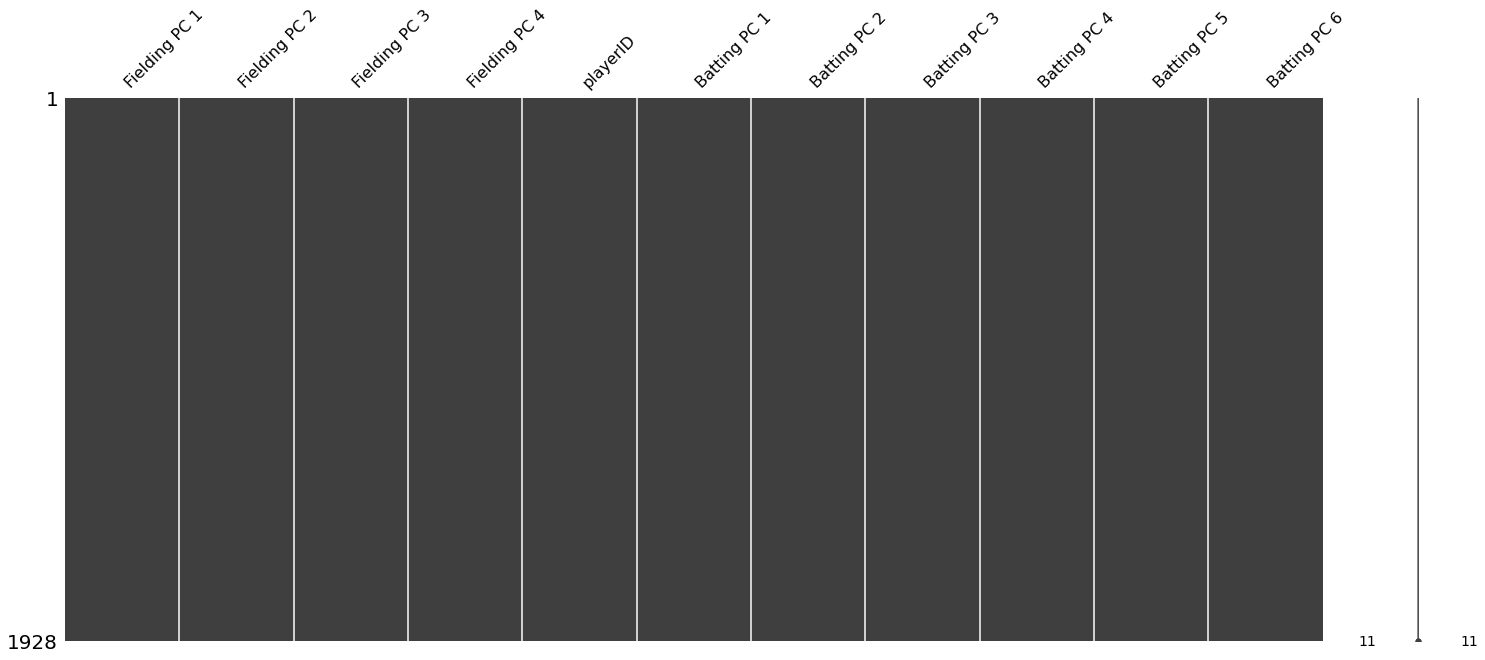

In [104]:
msno.matrix(position_pca_df)

In [105]:
catching_pca_df = catchers_fielding_pca_df.join(batting_pca_df, how='left', lsuffix='_catching', rsuffix='_batting')
catching_pca_df = catching_pca_df.drop(columns=['playerID_batting'])
catching_pca_df = catching_pca_df.rename(columns={'playerID_catching': 'playerID'})
catching_pca_df

Catcher Fielding PC 1  Catcher Fielding PC 2  Catcher Fielding PC 3  ...  \
0                 1.096837              -1.176777              -1.376238  ...   
1                 2.308597               0.644065              -0.113499  ...   
2                -1.219111               0.532070              -0.434902  ...   
3                 1.719904              -0.949353              -0.777937  ...   
4                -0.928332               0.426608              -0.429279  ...   
..                     ...                    ...                    ...  ...   
397              -0.438569               0.369629              -0.289059  ...   
398              -0.604644               0.493210              -0.354893  ...   
399              -1.230408               0.364743              -0.489282  ...   
400               1.760365              -0.192201              -0.235300  ...   
401              -2.083333               0.649709              -0.551626  ...   

     Batting PC 4 Batting PC 5  Batting PC 6  
0        0.365831    -0.731564      0.187357  
1        0.944844    -0.184954      0.453299  
2        0.145588    -0.189653      0.074177  
3        0.252235    -0.883645     -0.161240  
4        0.198742     0.395037     -0.127119  
..            ...          ...           ...  
397      0.762170    -0.010456      0.165628  
398      0.406372     0.001360      0.641710  
399      1.498673    -0.351435     -0.928603  
400     -0.629303     1.210312     -0.949780  
401     -1.541674     0.048303     -0.381352  

[402 rows x 11 columns]

<AxesSubplot:>

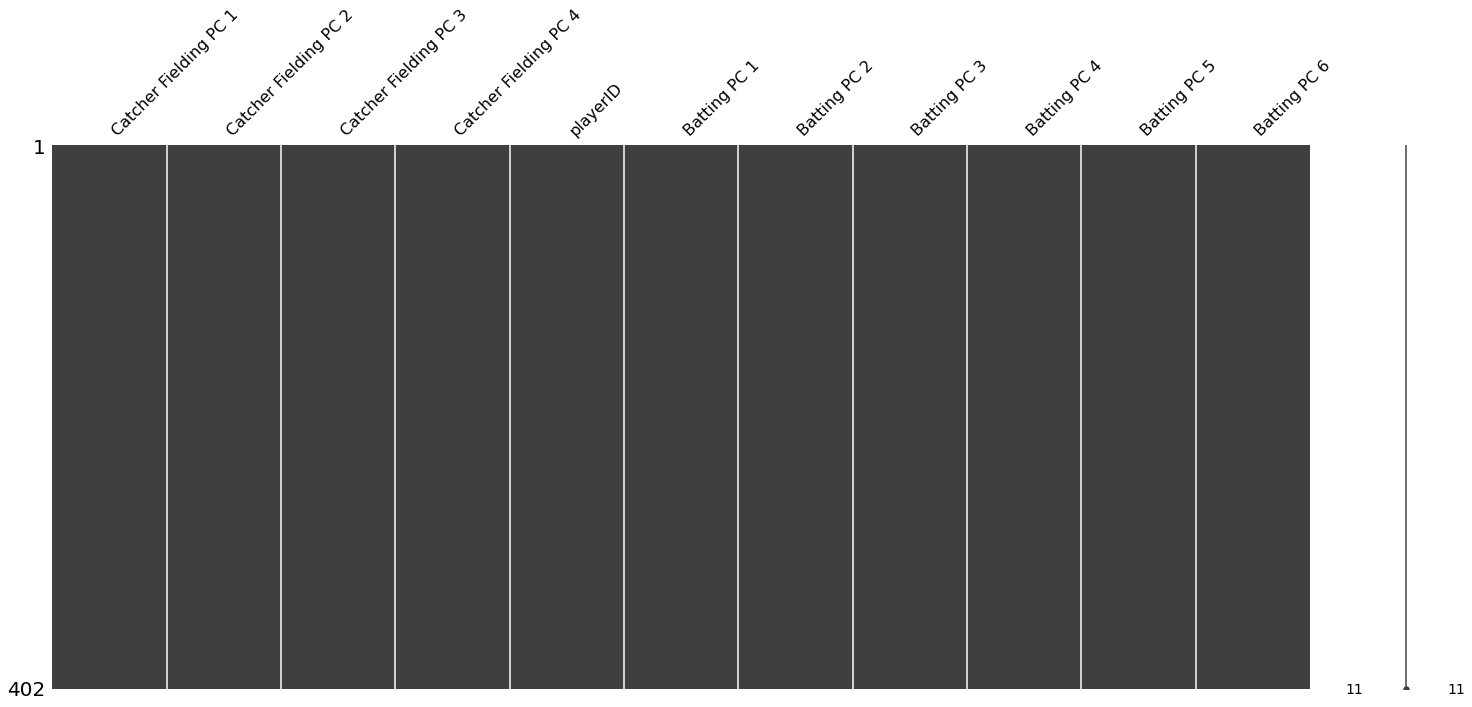

In [106]:
msno.matrix(catching_pca_df)

In [107]:
pitcher_pca_df = pitching_pca_df.join(pitchers_fielding_pca_df, how='left', lsuffix='_pitching', rsuffix='_fielding')
pitcher_pca_df = pitcher_pca_df.drop(columns='playerID_fielding')
pitcher_pca_df = pitcher_pca_df.rename(columns={'playerID_pitching': 'playerID'})
pitcher_pca_df

Pitching PC 1  Pitching PC 2  Pitching PC 3  ...  Pitcher Fielding PC 1  \
0         -2.581884       0.147365       2.673930  ...              -1.807652   
1          0.156847       0.282815       0.980468  ...              -0.885204   
2          0.189590       1.863880      -1.839280  ...               0.036344   
3         -0.644306       1.339632      -0.630143  ...               1.026323   
4         -2.906534       2.105486       0.003534  ...               0.209708   
...             ...            ...            ...  ...                    ...   
1326      -1.504314      -0.624493       0.313936  ...               0.679747   
1327      -0.896530      -2.000214      -0.347414  ...              -0.729019   
1328       0.136891      -0.809629      -1.559939  ...              -0.365998   
1329      -1.547346      -0.249485      -1.202398  ...               0.028477   
1330       0.478036       1.983920       1.461993  ...               1.560158   

      Pitcher Fielding PC 2  Pitcher Fielding PC 3  
0                 -0.343995              -0.542694  
1                 -0.396587              -0.240833  
2                 -0.484504               0.333064  
3                  0.836025               0.385031  
4                  0.115322               0.350052  
...                     ...                    ...  
1326              -0.582250               0.998219  
1327              -0.648531              -0.572628  
1328               0.129222              -0.161901  
1329               0.543236               0.147774  
1330              -0.645298              -1.423989  

[1331 rows x 12 columns]

<AxesSubplot:>

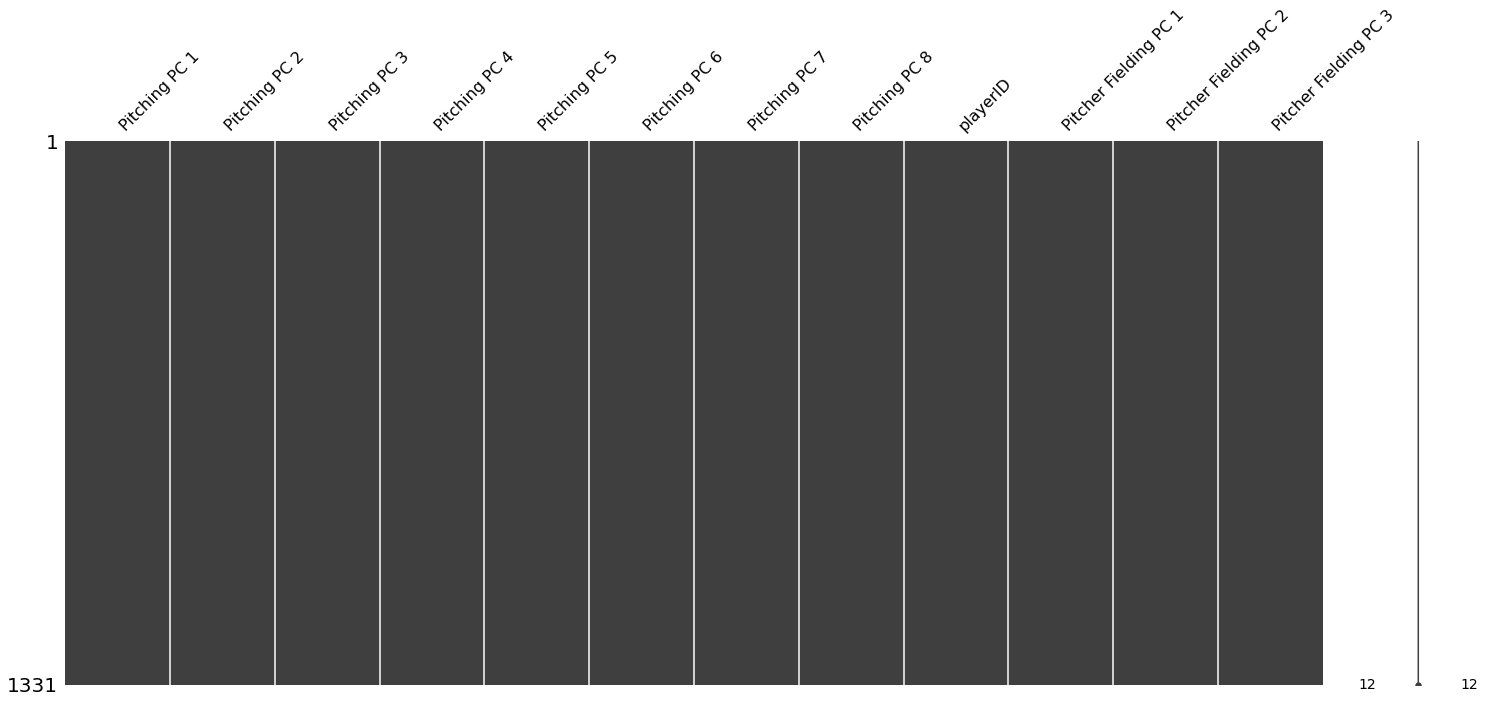

In [108]:
msno.matrix(pitcher_pca_df)

In [109]:
def is_HOF(r):
    matching_player = people_df.loc[people_df['playerID'] == r['playerID']]
    is_hof = matching_player['isHallOfFame'].squeeze()
    return 1 if is_hof else 0

position_pca_df['isHallOfFame'] = position_pca_df.apply(lambda r: is_HOF(r), axis=1)
position_pca_df['isHallOfFame'].value_counts()

0    1779
1     149
Name: isHallOfFame, dtype: int64

In [110]:
catching_pca_df['isHallOfFame'] = catching_pca_df.apply(lambda r: is_HOF(r), axis=1)
catching_pca_df['isHallOfFame'].value_counts()

0    387
1     15
Name: isHallOfFame, dtype: int64

In [111]:
pitcher_pca_df['isHallOfFame'] = pitcher_pca_df.apply(lambda r: is_HOF(r), axis=1)
pitcher_pca_df['isHallOfFame'].value_counts()

0    1256
1      75
Name: isHallOfFame, dtype: int64

## Raw Data

However, since we lose all interpretability from the PCA data, we won't be able to use that data to tell what the most important baseball stats for making it into the Hall of Fame are.  Therefore, we will also have a second set of data that includes the data that isn't transformed using principal components analysis.

In [112]:
batting_df_box_cox_rounded_z['playerID'] = batting_df['playerID']
fielding_df_box_cox_rounded_z['playerID'] = fielding_df['playerID']

position_df = fielding_df_box_cox_rounded_z.merge(batting_df_box_cox_rounded_z, on='playerID',
                                                 how='left', suffixes=('_fielding', '_batting'))

fielding_df_box_cox_rounded_z = fielding_df_box_cox_rounded_z.drop(columns=['playerID'])

position_df

FP        RF      DP_G  ...        RC   GIDP_AB      S_AB
0     0.538709 -0.339543 -0.794672  ...  3.292190  0.844126 -0.527713
1    -1.643517  0.216069  0.323067  ... -0.606466 -1.453948  1.367648
2     0.559925 -0.601106 -1.203778  ...  2.016135  0.144457 -0.615693
3     1.472378  0.598814  1.760984  ...  0.352883  1.394497 -0.831547
4     1.331345 -0.098716  0.376363  ... -0.881238 -0.523794 -0.607649
...        ...       ...       ...  ...       ...       ...       ...
1923 -0.748181  0.105414  0.745251  ... -0.484394  1.206611  0.012371
1924  0.133498  0.062688  0.478435  ...  1.135207  1.354611 -0.639394
1925  0.498391 -0.584510 -1.126147  ...  0.737036  0.862416 -0.819187
1926 -1.136800 -2.554226 -1.213699  ... -1.465830 -1.453948  1.894260
1927  0.737524 -0.087980  0.426263  ...  0.871992  0.314364  0.003843

[1928 rows x 15 columns]

<AxesSubplot:>

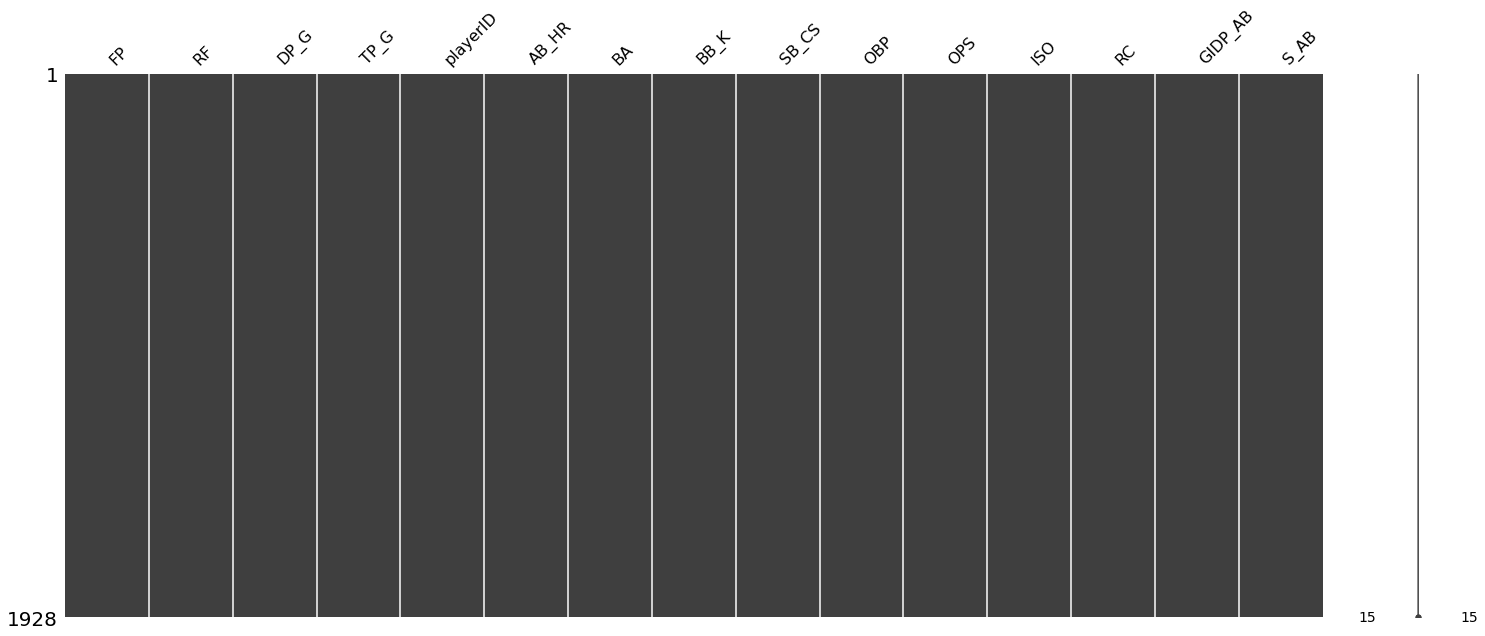

In [113]:
msno.matrix(position_df)

In [114]:
catchers_fielding_df_box_cox_rounded_z['playerID'] = catchers_fielding_df['playerID']

catching_df = catchers_fielding_df_box_cox_rounded_z.merge(batting_df_box_cox_rounded_z, on='playerID',
                                                           how='left', suffixes=('_catching', '_batting'))

catchers_fielding_df_box_cox_rounded_z = catchers_fielding_df_box_cox_rounded_z.drop(columns=['playerID'])

catching_df

FP        RF     PB_WP  ...        RC   GIDP_AB      S_AB
0   -1.280883  1.283898 -0.447595  ... -0.691956 -1.453948  1.503167
1   -2.221552 -0.008695 -0.447595  ... -1.361005 -1.131781 -2.356891
2    0.579384  0.162645 -0.447595  ...  0.130329  1.131199  0.242986
3   -0.980185  0.816748 -0.447595  ... -0.834610 -1.453948  1.665048
4    0.166089  0.141481 -0.447595  ... -0.118035  1.227950  0.759356
..        ...       ...       ...  ...       ...       ...       ...
397  0.584057  0.061031 -0.447595  ... -0.002601  0.939473  0.633262
398  0.361001  0.122940 -0.447595  ... -0.371301  0.736417  0.156498
399  0.283705  0.184876 -0.447595  ... -0.164531  0.682211 -0.337639
400 -1.751325  0.025564 -0.447595  ...  0.065961 -1.453948 -0.562169
401  1.494423  0.314601 -0.447595  ... -0.919405  0.104075 -0.893468

[402 rows x 16 columns]

<AxesSubplot:>

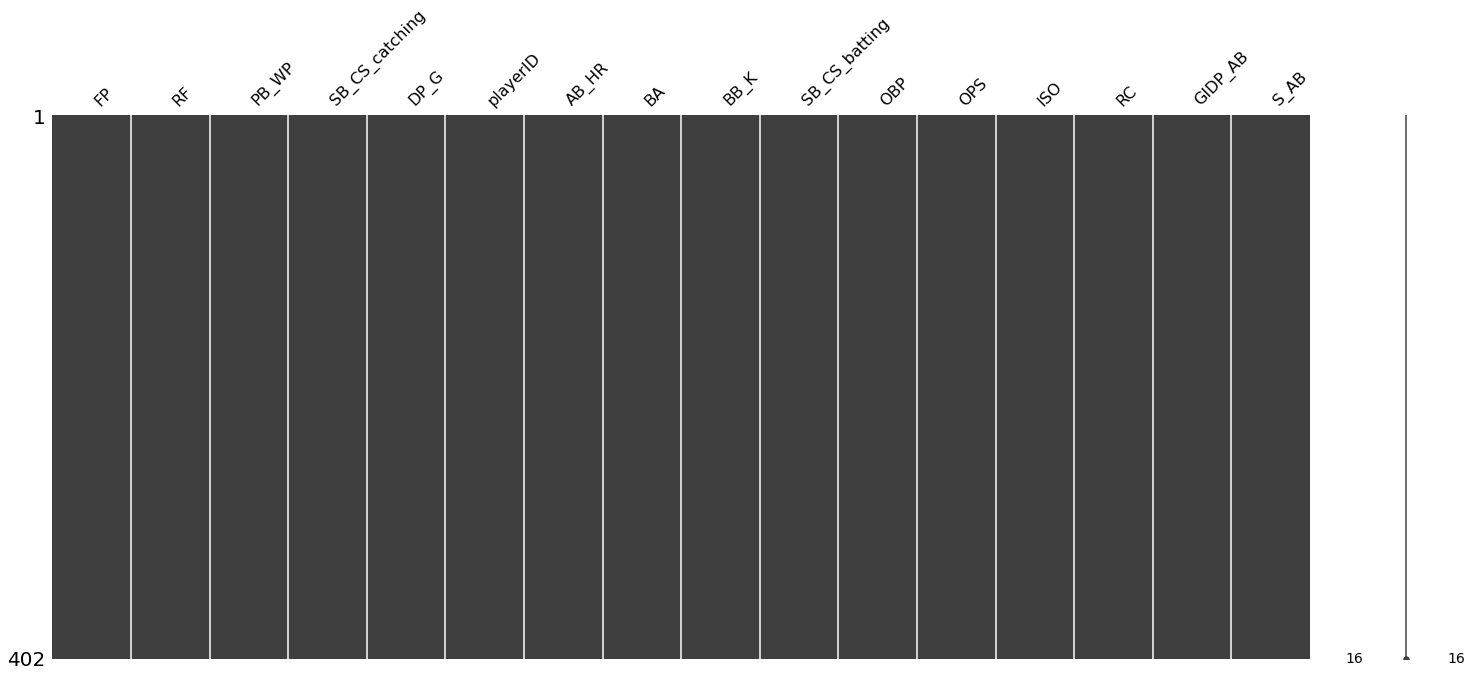

In [115]:
msno.matrix(catching_df)

In [116]:
pitching_df_box_cox_rounded_z['playerID'] = pitching_df['playerID']
pitchers_fielding_df_box_cox_rounded_z['playerID'] = pitchers_fielding_df['playerID']

pitcher_df = pitching_df_box_cox_rounded_z.merge(pitchers_fielding_df_box_cox_rounded_z, on='playerID',
                                                 how='left', suffixes=('_pitching', '_fielding'))

pitchers_fielding_df_box_cox_rounded_z = pitchers_fielding_df_box_cox_rounded_z.drop(columns=['playerID'])

pitcher_df

BAOpp       ERA      BB_9  ...        FP        RF      DP_G
0    -0.933503 -0.816713  1.839603  ... -1.063099 -0.588210 -1.484455
1    -0.327779 -0.798878  0.608306  ... -0.723106 -0.231494 -0.664093
2    -0.401472 -0.618826 -0.930054  ... -0.459685 -0.019889  0.367181
3    -0.529245 -0.712867  0.178241  ...  1.144649 -0.060981  0.768136
4    -0.055620  0.787382  1.963816  ...  0.137789 -0.192302  0.367181
...        ...       ...       ...  ...       ...       ...       ...
1326 -0.049338  0.058196  1.039204  ... -0.351937 -0.018783  1.294984
1327  0.031122  1.980574 -0.047848  ... -0.809921  0.173899 -0.757523
1328 -0.150000 -0.072121 -1.728085  ... -0.036543 -0.212317 -0.382533
1329  0.733455  0.883836  0.611386  ...  0.456283 -0.355691  0.013272
1330 -0.261909 -0.040942  2.287225  ...  0.424028  2.338349  0.074656

[1331 rows x 18 columns]

<AxesSubplot:>

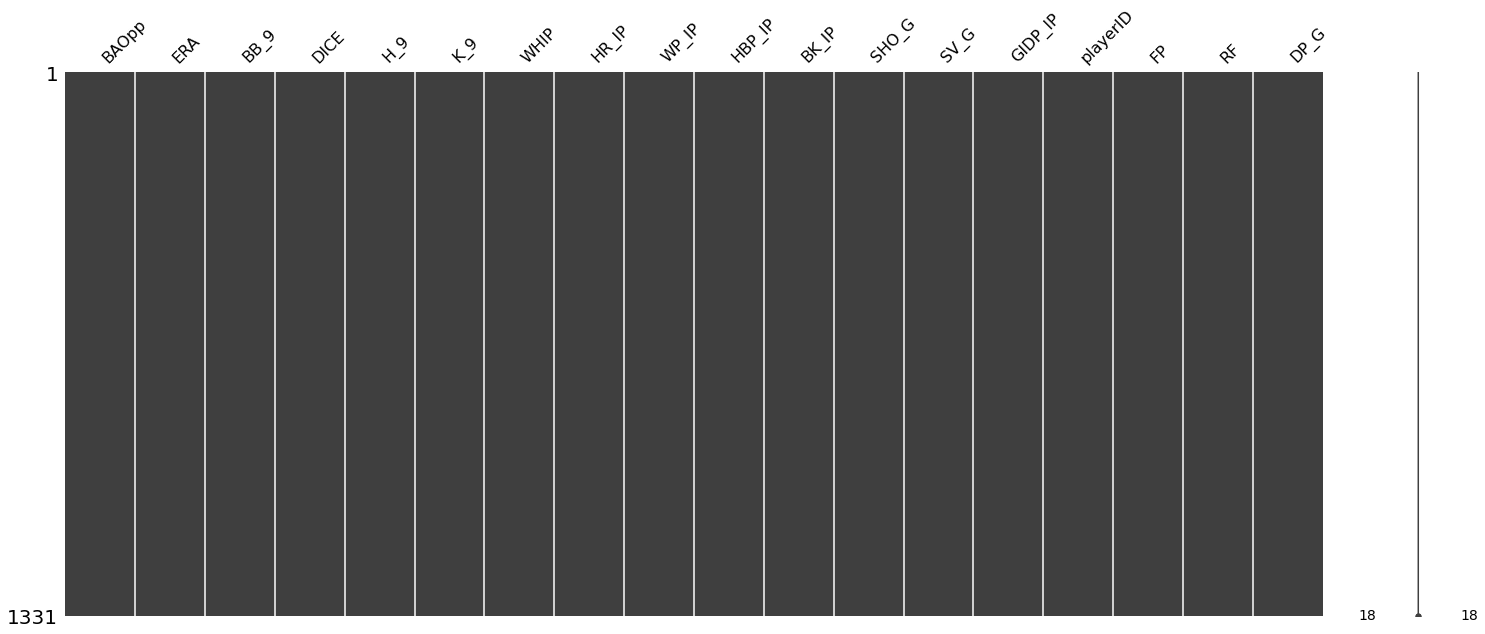

In [117]:
msno.matrix(pitcher_df)

In [118]:
position_df['isHallOfFame'] = position_df.apply(lambda r: is_HOF(r), axis=1)
position_df['isHallOfFame'].value_counts()

0    1779
1     149
Name: isHallOfFame, dtype: int64

In [119]:
catching_df['isHallOfFame'] = catching_df.apply(lambda r: is_HOF(r), axis=1)
catching_df['isHallOfFame'].value_counts()

0    387
1     15
Name: isHallOfFame, dtype: int64

In [120]:
pitcher_df['isHallOfFame'] = pitcher_df.apply(lambda r: is_HOF(r), axis=1)
pitcher_df['isHallOfFame'].value_counts()

0    1256
1      75
Name: isHallOfFame, dtype: int64

In [121]:
dill.dump_session('notebook_env.db')

In [122]:
# dill.load_session('notebook_env.db')

# Model Fitting

In [124]:
# We won't use these players in train or test so we can take a closer look at them later
holdout_players = ['bondsba01', # Barry Bonds
                   'jeterde01', # Derek Jeter
                   'mcgwima01', # Mark McGwire
                   'palmera01', # Rafael Palmeiro
                   'rosepe01',  # Pete Rose
                   'ruthba01',  # Babe Ruth
                   'suzukic01', # Ichiro Suzuki
                  ]

# Remove the holdout players from the position pca df
position_pca_df_holdout = position_pca_df[position_pca_df['playerID'].isin(holdout_players)]
position_pca_df = position_pca_df[~position_pca_df['playerID'].isin(holdout_players)]

# Remove the active players from the position pca df
active_position_pca_df = position_pca_df[position_pca_df['playerID'].isin(active_players['playerID'])]
position_pca_df = position_pca_df[~position_pca_df['playerID'].isin(active_players['playerID'])]

y_position_pca = position_pca_df['isHallOfFame'].values
X_position_pca = position_pca_df.drop(columns=['isHallOfFame', 'playerID']).values
X_position_pca_train, X_position_pca_test, y_position_pca_train, y_position_pca_test = train_test_split(X_position_pca, 
                                                                                                        y_position_pca, 
                                                                                                        test_size=0.2, 
                                                                                                        random_state=42)

# Remove the active players from the catcher pca df
active_catching_pca_df = catching_pca_df[catching_pca_df['playerID'].isin(active_players['playerID'])]
catching_pca_df = catching_pca_df[~catching_pca_df['playerID'].isin(active_players['playerID'])]

y_catching_pca = catching_pca_df['isHallOfFame'].values
X_catching_pca = catching_pca_df.drop(columns=['isHallOfFame', 'playerID']).values
X_catching_pca_train, X_catching_pca_test, y_catching_pca_train, y_catching_pca_test = train_test_split(X_catching_pca, 
                                                                                                        y_catching_pca, 
                                                                                                        test_size=0.2, 
                                                                                                        random_state=42)

# Remove the active players from the pitcher pca df
active_pitcher_pca_df = pitcher_pca_df[pitcher_pca_df['playerID'].isin(active_players['playerID'])]
pitcher_pca_df = pitcher_pca_df[~pitcher_pca_df['playerID'].isin(active_players['playerID'])]

y_pitching_pca = pitcher_pca_df['isHallOfFame'].values
X_pitching_pca = pitcher_pca_df.drop(columns=['isHallOfFame', 'playerID']).values
X_pitching_pca_train, X_pitching_pca_test, y_pitching_pca_train, y_pitching_pca_test = train_test_split(X_pitching_pca, 
                                                                                                        y_pitching_pca, 
                                                                                                        test_size=0.2, 
                                                                                                        random_state=42)

k = 10
skf = StratifiedKFold(n_splits=k)
scoring_metrics = {'Brier Loss': 'neg_brier_score',
                   'Logistic Loss': 'neg_log_loss',
                   'F1 Score': 'f1',
                   'Accuracy': 'balanced_accuracy',
                   'AUC': 'roc_auc',
                   'Kappa Score': make_scorer(cohen_kappa_score),
                   'Sensitivity': 'recall'}

## Logistic Regression

In [1040]:
logistic_regression_parameters = [{'penalty': ['l2'],
                                   'tol': np.logspace(-2, -6, num=5),
                                   'C': np.logspace(-4, 4, 9, base=10),
                                   'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                                   'max_iter': [10000],
                                   'class_weight': [None, 'balanced'],
                                   'random_state': [42]},
                                  {'penalty': ['elasticnet'],
                                   'tol': np.logspace(-2, -6, num=5),
                                   'C': np.logspace(-4, 4, 9, base=10),
                                   'solver': ['saga'],
                                   'max_iter': [10000],
                                   'l1_ratio': np.linspace(0, 1, 11),
                                   'class_weight': [None, 'balanced'],
                                   'random_state': [42]},
                                  {'penalty': ['l1'],
                                   'tol': np.logspace(-2, -6, num=5),
                                   'C': np.logspace(-4, 4, 9, base=10),
                                   'solver': ['liblinear', 'saga'],
                                   'max_iter': [10000],
                                   'class_weight': [None, 'balanced'],
                                   'random_state': [42]}]

lr_clf = GridSearchCV(LogisticRegression(),
                     logistic_regression_parameters,
                     cv=skf,
                     scoring=scoring_metrics,
                     refit='F1 Score',
                     return_train_score=True,
                     n_jobs=-1,
                     verbose=1)

### Position Players

In [1041]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_clf.fit(X_position_pca_train, y_position_pca_train.ravel())
    
lr_results = lr_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lr_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lr_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lr_results['mean_test_%s' % scorer][best_index] ,
                                        lr_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lr_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1530 candidates, totalling 15300 fits
AUC
0.61207 (+/-0.060) for {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.9, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001}

Accuracy
0.60358 (+/-0.032) for {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001}

Brier Loss
-0.08293 (+/-0.002) for {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.6000000000000001, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

F1 Score
0.22076 (+/-0.023) for {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001}

Kappa Score
0.08450 (+/-0.025) for {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001

In [1042]:
def plot_cv_param(param, results, log_scale=False):
    warnings.filterwarnings(action='once')
    plt.figure(figsize=GLOBAL_FIG_SIZE)
    plt.title("GridSearchCV evaluating parameter '" + param + "' using multiple scorers simultaneously", fontsize=GLOBAL_TITLE_SIZE)

    plt.xlabel(param, fontsize=GLOBAL_LABEL_SIZE)
    plt.ylabel("Score", fontsize=GLOBAL_LABEL_SIZE)

    results_df = pd.DataFrame(results)
    results_df = results_df.groupby(by='param_%s' % param).mean().dropna()

    ax = plt.gca()
    ax.set_xlim(min(results_df.index), max(results_df.index))
    ax.set_ylim(-1, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results_df.index, dtype=float)
    results_df = results_df.reset_index()
    for scorer, color in zip(sorted(scoring_metrics), ['g', 'r', 'b', 'c', 'm', 'y', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results_df['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results_df['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, 
                            sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, 
                            color=color)
            ax.plot(X_axis, 
                    sample_score_mean, 
                    style, 
                    color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = results_df.loc[results_df['rank_test_%s' % scorer] == min(results_df['rank_test_%s' % scorer])].index.tolist()[0]
        best_score = results_df.loc[results_df['rank_test_%s' % scorer] == min(results_df['rank_test_%s' % scorer])]['mean_test_%s' % scorer].tolist()[0]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2,
                [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
        if log_scale:
            ax.set_xscale('log')

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

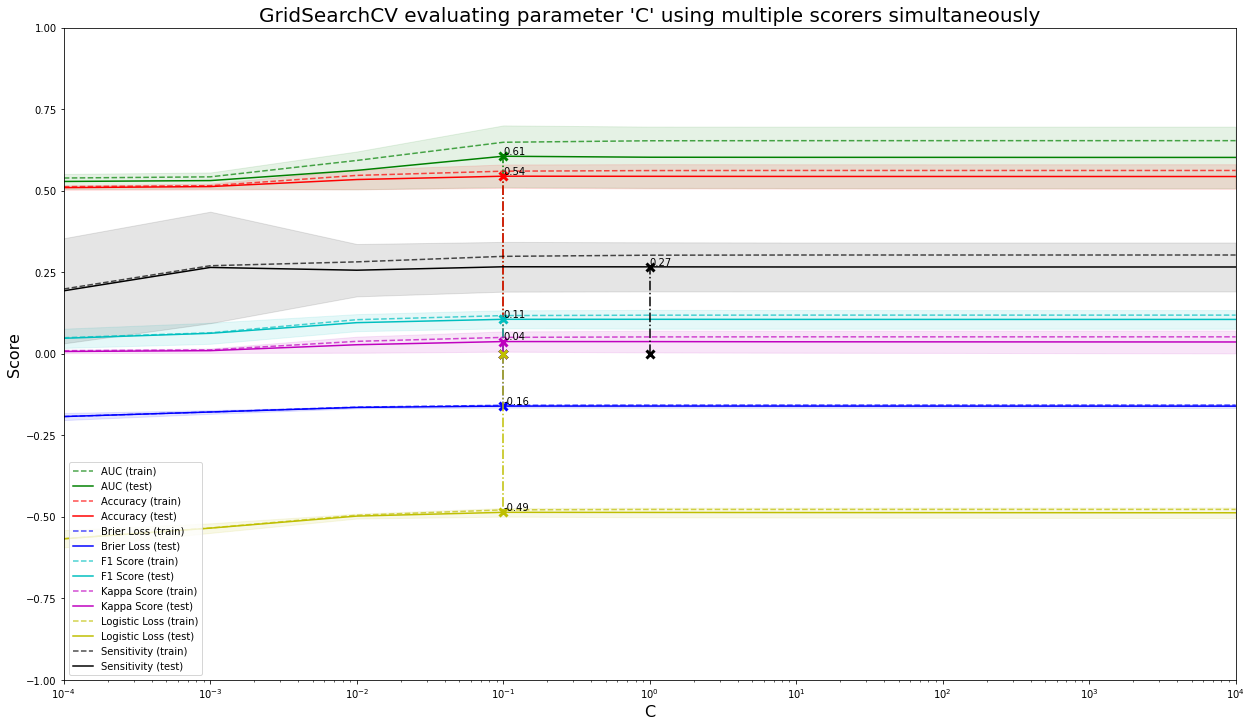

In [1043]:
plot_cv_param('C', lr_results, log_scale=True)

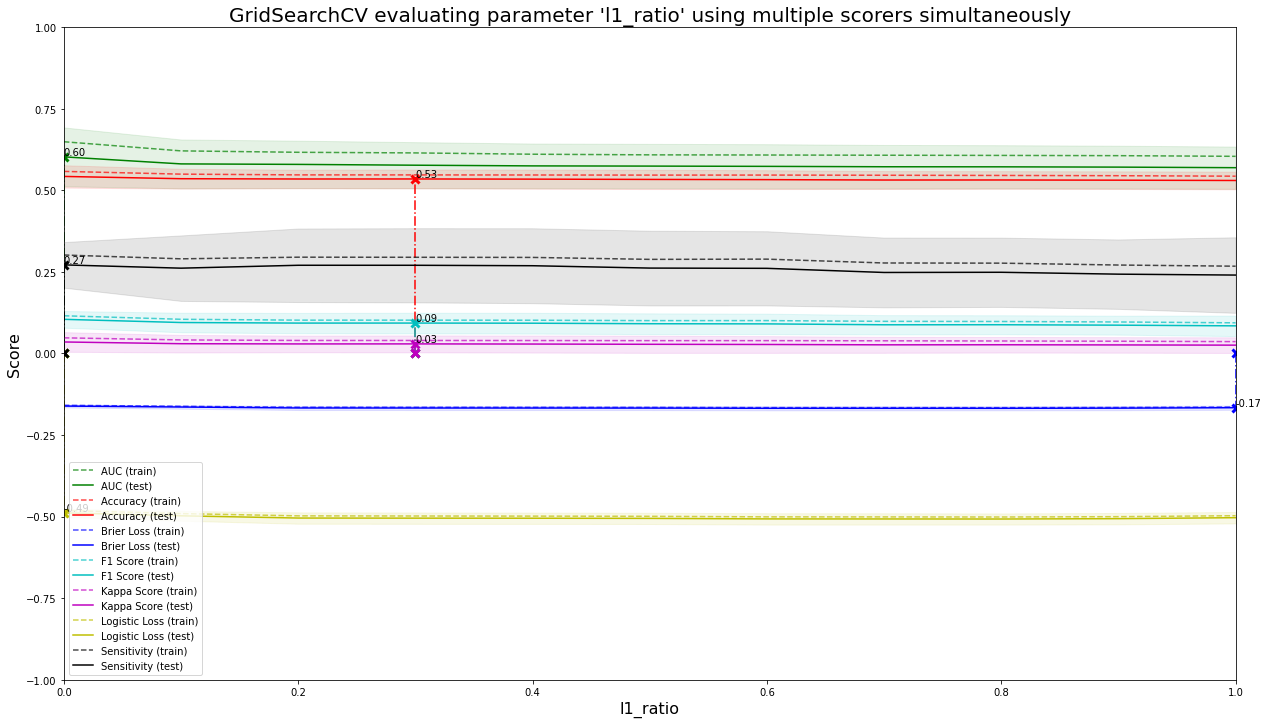

In [1044]:
plot_cv_param('l1_ratio', lr_results, log_scale=False)

<AxesSubplot:title={'center':'F1 Score for C by L1 Ratio'}, xlabel='param_l1_ratio', ylabel='param_C'>

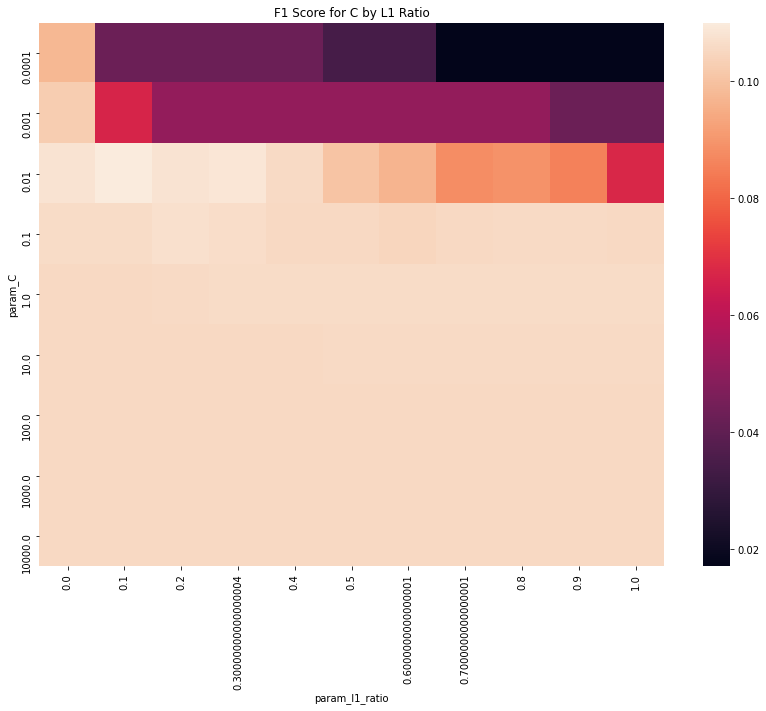

In [1045]:
f, ax = plt.subplots(figsize=SMALL_FIG_SIZE)
ax.set_title('F1 Score for C by L1 Ratio')
pvt = pd.pivot_table(pd.DataFrame(lr_results), 
                     values='mean_test_F1 Score', 
                     index='param_C', 
                     columns='param_l1_ratio')
sns.heatmap(pvt, ax=ax)

In [1046]:
best_lr_position = LogisticRegression(C=.01,
                                      class_weight='balanced',
                                      max_iter=10000,
                                      penalty='elasticnet',
                                      random_state=42,
                                      l1_ratio=.1,
                                      solver='saga',
                                      tol=0.0001)

best_lr_position.fit(X_position_pca_train, y_position_pca_train.ravel())

LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.1,
                   max_iter=10000, penalty='elasticnet', random_state=42,
                   solver='saga')

In [1047]:
def print_confusion_matrix_details(tn, fp, fn, tp):
    recall    = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = stats.hmean([precision, recall]) if tp + fp > 0 else np.nan
    print('False Negatives:', fn)
    print('True Positives: ', tp)
    print('False Positives:', fp)
    print('True Negatives: ', tn)
    print()
    print('Sensitivity:    ', round(recall, 3))
    print('Specificity:    ', round(tn / (tn + fp), 3))
    print()
    print('Precision:      ', round(precision, 3))
    print('Accuracy:       ', round((tp + tn) / (tp + tn + fp + fn), 3))
    print()
    print('F1 Score:       ', round(f1, 3))

In [1048]:
tn, fp, fn, tp = confusion_matrix(y_position_pca_test, best_lr_position.predict(X_position_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 12
True Positives:  17
False Positives: 104
True Negatives:  186

Sensitivity:     0.586
Specificity:     0.641

Precision:       0.14
Accuracy:        0.636

F1 Score:        0.227


This logistic regression model has a very high number of false positives.  This makes sense though, since there are potentially a large number of Hall of Fame caliber players that were not admitted due to the fact that there are only a certain number of ballots that can be cast for any given year and that players are only considered for the Hall of Fame for 10 years after their first year of eligibility.

In [1049]:
def get_roc(model, X, y):
    scores = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, scores[:,1])
    return fpr, tpr, thresholds

In [1050]:
def plot_roc(fpr, tpr, thresholds, title):
    f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
    ax.set_title(title, fontsize=GLOBAL_TITLE_SIZE)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
    ax.axline([0, 0], [1, 1], alpha=.3, color='black', ls='--')

In [1051]:
def get_best_threshold(fprs, tprs, thresholds):
    distances = dict()
    for fpr, tpr, threshold in zip(fprs, tprs, thresholds):
        distance = math.sqrt(math.pow(1 - tpr, 2) + math.pow(fpr, 2))
        distances[threshold] = distance
    distances = dict(sorted(distances.items(), key=lambda item: item[1]))
    return list(distances.items())[0][0]

0.48344355952363066


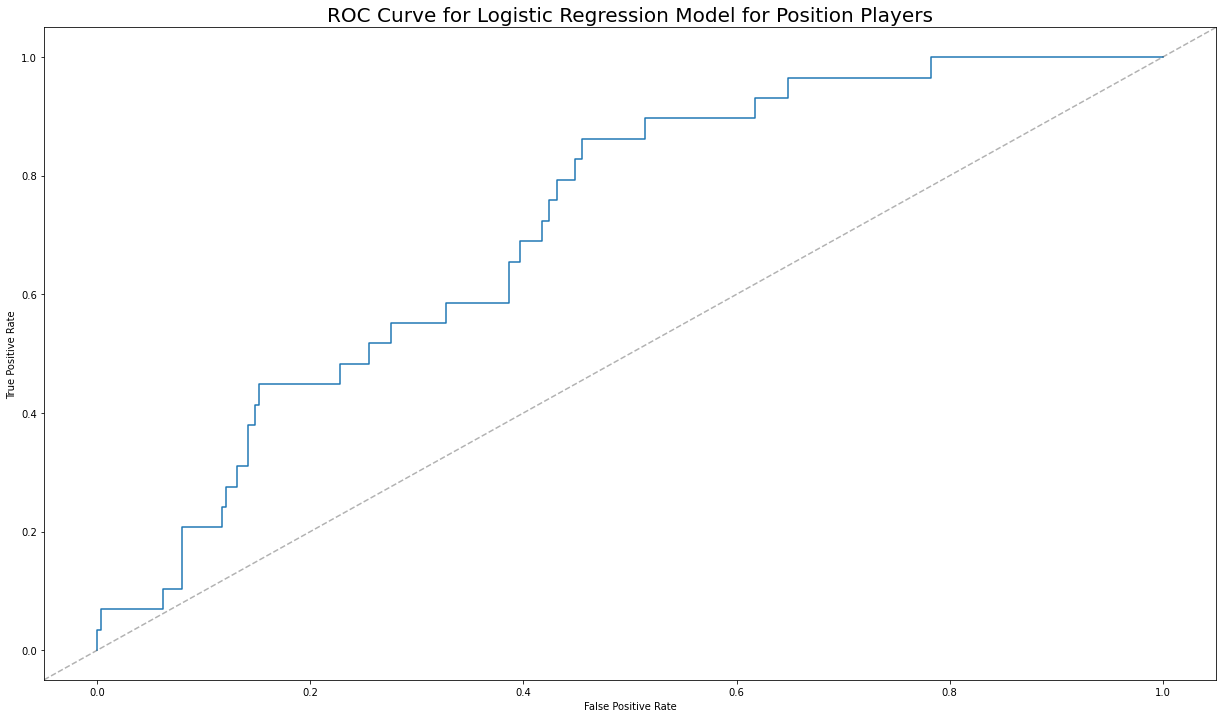

In [1052]:
fpr, tpr, thresholds = get_roc(best_lr_position, X_position_pca_test, y_position_pca_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Logistic Regression Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

### Catchers

In [1053]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_clf.fit(X_catching_pca_train, y_catching_pca_train.ravel())

lr_results = lr_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lr_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lr_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lr_results['mean_test_%s' % scorer][best_index] ,
                                        lr_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lr_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1530 candidates, totalling 15300 fits
AUC
0.73466 (+/-0.120) for {'C': 1.0, 'class_weight': None, 'l1_ratio': 0.7000000000000001, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01}

Accuracy
0.68849 (+/-0.128) for {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.01}

Brier Loss
-0.04228 (+/-0.009) for {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

F1 Score
0.18351 (+/-0.088) for {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.001}

Kappa Score
0.11826 (+/-0.091) for {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.001}

Logistic Loss
-0.17248 (+/-0.029) for {'C': 0.1, 'class_weight': None, 'l1_rat

In [1054]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_lr_catching = LogisticRegression(C=.1,
                                      class_weight='balanced',
                                      max_iter=10000,
                                      penalty='l2',
                                      random_state=42,
                                      solver='sag',
                                      tol=0.001)

    best_lr_catching.fit(X_catching_pca_train, y_catching_pca_train.ravel())

In [1055]:
tn, fp, fn, tp = confusion_matrix(y_catching_pca_test, best_lr_catching.predict(X_catching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 0
True Positives:  2
False Positives: 28
True Negatives:  42

Sensitivity:     1.0
Specificity:     0.6

Precision:       0.067
Accuracy:        0.611

F1 Score:        0.125


### Pitchers

In [1056]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_clf.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())

lr_results = lr_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lr_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lr_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lr_results['mean_test_%s' % scorer][best_index] ,
                                        lr_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lr_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1530 candidates, totalling 15300 fits
AUC
0.93796 (+/-0.016) for {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01}

Accuracy
0.88255 (+/-0.037) for {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.2, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01}

Brier Loss
-0.04485 (+/-0.007) for {'C': 0.1, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'tol': 0.01}

F1 Score
0.49444 (+/-0.158) for {'C': 1000.0, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.01}

Kappa Score
0.47258 (+/-0.162) for {'C': 1000.0, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.01}

Logistic Loss
-0.15053 (+/-0.020) for {'C': 1.0, 'class_weight': None, 'max_iter': 10000, 'penalty'

In [1057]:
best_lr_pitching = LogisticRegression(C=1000,
                                      class_weight=None,
                                      max_iter=10000,
                                      penalty='l2',
                                      random_state=42,
                                      solver='sag',
                                      tol=.01)

best_lr_pitching.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())

LogisticRegression(C=1000, max_iter=10000, random_state=42, solver='sag',
                   tol=0.01)

In [1058]:
tn, fp, fn, tp = confusion_matrix(y_pitching_pca_test, best_lr_pitching.predict(X_pitching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 7
True Positives:  6
False Positives: 3
True Negatives:  218

Sensitivity:     0.462
Specificity:     0.986

Precision:       0.667
Accuracy:        0.957

F1 Score:        0.545


## Linear Discriminant Analysis

In [1059]:
lda_parameters = [{'solver': ['lsqr', 'eigen'],
                   'shrinkage': np.linspace(0, 1, 11),
                   'tol': np.logspace(1, -8, num=10)},
                  {'solver': ['lsqr', 'eigen'],
                   'shrinkage': ['auto', None],
                   'tol': np.logspace(1, -8, num=10)},
                  {'solver': ['svd'],
                   'shrinkage': [None],
                   'tol': np.logspace(1, -8, num=10)}]

lda_clf = GridSearchCV(LinearDiscriminantAnalysis(),
                       lda_parameters,
                       cv=skf,
                       scoring=scoring_metrics,
                       refit='F1 Score',
                       return_train_score=True,
                       n_jobs=-1,
                       verbose=1)

### Position Players

In [1060]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lda_clf.fit(X_position_pca_train, y_position_pca_train.ravel())
    
lda_results = lda_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lda_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lda_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lda_results['mean_test_%s' % scorer][best_index] ,
                                        lda_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lda_results['params'][best_index]))
    print()

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
AUC
0.61054 (+/-0.058) for {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 10.0}

Accuracy
0.50000 (+/-0.000) for {'shrinkage': 0.0, 'solver': 'lsqr', 'tol': 10.0}

Brier Loss
-0.08306 (+/-0.002) for {'shrinkage': 0.4, 'solver': 'lsqr', 'tol': 10.0}

F1 Score
0.00000 (+/-0.000) for {'shrinkage': 0.0, 'solver': 'lsqr', 'tol': 10.0}

Kappa Score
0.00000 (+/-0.000) for {'shrinkage': 0.0, 'solver': 'lsqr', 'tol': 10.0}

Logistic Loss
-0.30445 (+/-0.009) for {'shrinkage': 0.4, 'solver': 'lsqr', 'tol': 10.0}

Sensitivity
0.00000 (+/-0.000) for {'shrinkage': 0.0, 'solver': 'lsqr', 'tol': 10.0}



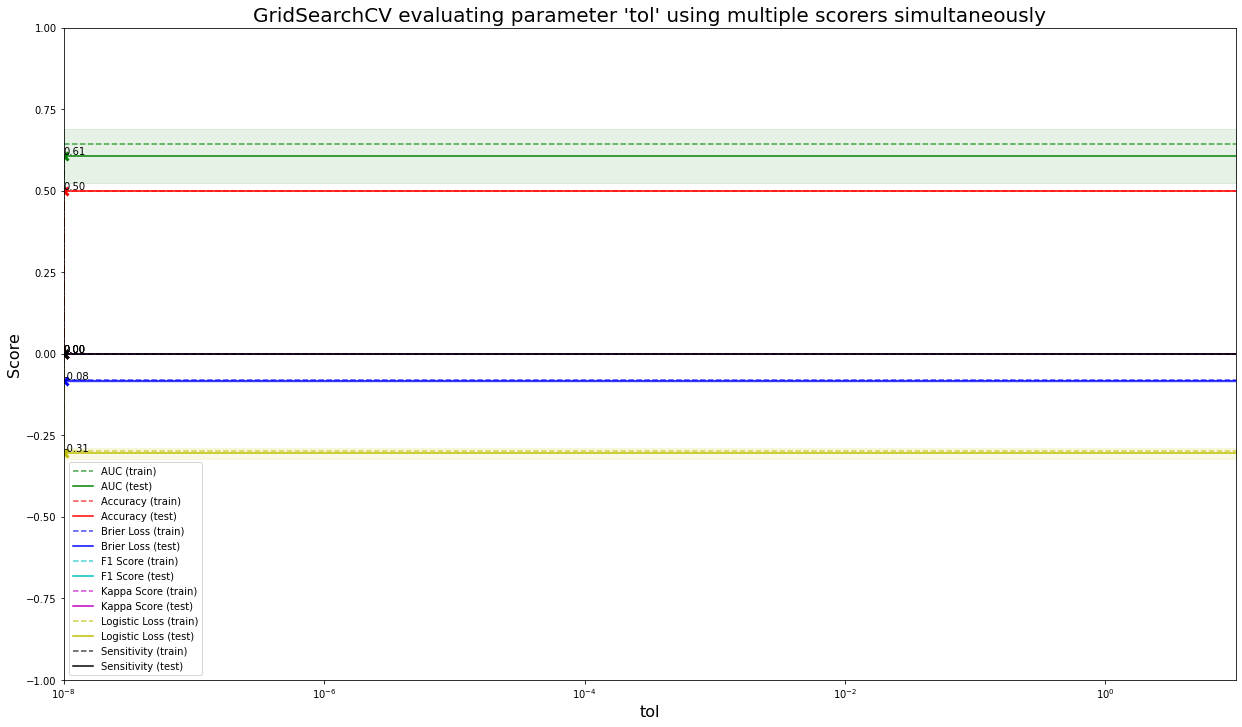

In [1061]:
lda_results_df = pd.DataFrame(lda_results)
lda_results_df = lda_results_df[~lda_results_df['param_shrinkage'].astype(str).str.isalpha()]
plot_cv_param('tol', lda_results_df, log_scale=True)

<AxesSubplot:title={'center':'F1 Score for Shrinkage by Tolerance'}, xlabel='param_tol', ylabel='param_shrinkage'>

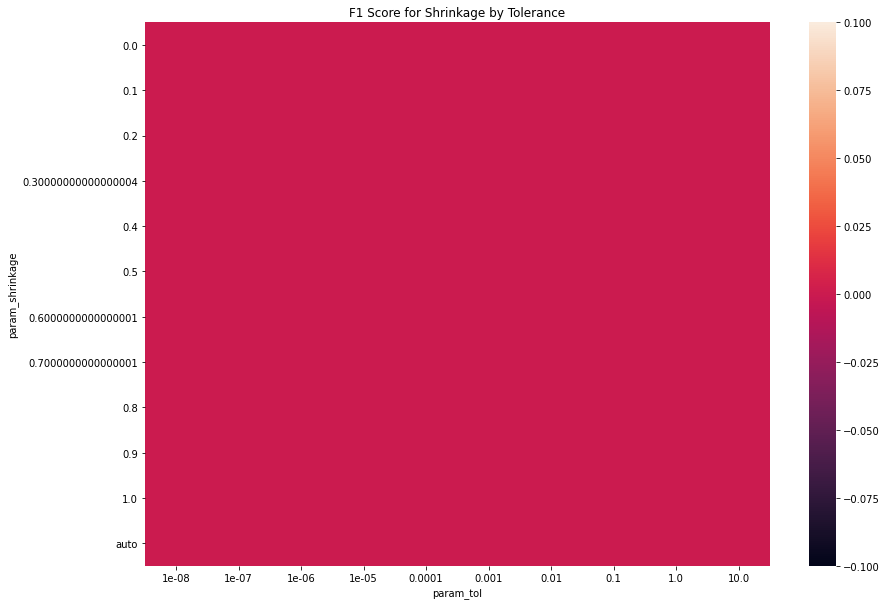

In [1062]:
f, ax = plt.subplots(figsize=SMALL_FIG_SIZE)
ax.set_title('F1 Score for Shrinkage by Tolerance')
pvt = pd.pivot_table(pd.DataFrame(lda_results), 
                     values='mean_test_F1 Score', 
                     index='param_shrinkage', 
                     columns='param_tol')
sns.heatmap(pvt, ax=ax)

In [1063]:
best_lda_position = LinearDiscriminantAnalysis(shrinkage=0,
                                               solver='lsqr',
                                               tol=1e-4)

best_lda_position.fit(X_position_pca_train, y_position_pca_train.ravel())

LinearDiscriminantAnalysis(shrinkage=0, solver='lsqr')

In [1064]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tn, fp, fn, tp = confusion_matrix(y_position_pca_test, best_lda_position.predict(X_position_pca_test)).ravel()
    print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 29
True Positives:  0
False Positives: 0
True Negatives:  290

Sensitivity:     0.0
Specificity:     1.0

Precision:       nan
Accuracy:        0.909

F1 Score:        nan


0.09287377212535647


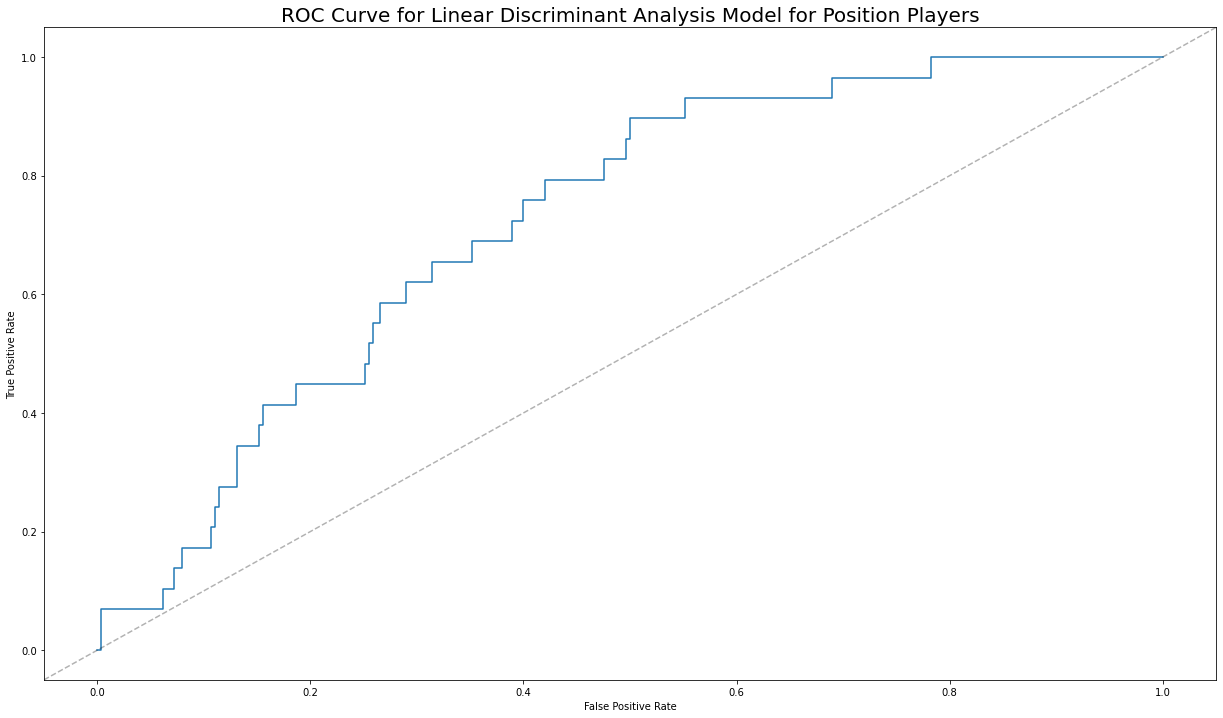

In [1065]:
fpr, tpr, thresholds = get_roc(best_lda_position, X_position_pca_test, y_position_pca_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Linear Discriminant Analysis Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1066]:
tn, fp, fn, tp = confusion_matrix(y_position_pca_test, (best_lda_position.predict_proba(X_position_pca_test)[:,1] >= best_threshold).astype(bool)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 10
True Positives:  19
False Positives: 91
True Negatives:  199

Sensitivity:     0.655
Specificity:     0.686

Precision:       0.173
Accuracy:        0.683

F1 Score:        0.273


### Catchers

In [1067]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lda_clf.fit(X_catching_pca_train, y_catching_pca_train.ravel())

lda_results = lda_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lda_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lda_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lda_results['mean_test_%s' % scorer][best_index] ,
                                        lda_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lda_results['params'][best_index]))
    print()

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
AUC
0.70410 (+/-0.117) for {'shrinkage': 0.2, 'solver': 'lsqr', 'tol': 10.0}

Accuracy
0.50000 (+/-0.000) for {'shrinkage': None, 'solver': 'svd', 'tol': 1.0}

Brier Loss
-0.04321 (+/-0.009) for {'shrinkage': None, 'solver': 'svd', 'tol': 1.0}

F1 Score
0.00000 (+/-0.000) for {'shrinkage': 0.0, 'solver': 'lsqr', 'tol': 10.0}

Kappa Score
0.00000 (+/-0.000) for {'shrinkage': None, 'solver': 'svd', 'tol': 1.0}

Logistic Loss
-0.18394 (+/-0.041) for {'shrinkage': 0.5, 'solver': 'eigen', 'tol': 10.0}

Sensitivity
0.00000 (+/-0.000) for {'shrinkage': 0.0, 'solver': 'lsqr', 'tol': 10.0}



In [1068]:
best_lda_catching = LinearDiscriminantAnalysis(shrinkage=0.0,
                                               solver='lsqr',
                                               tol=1.0)


best_lda_catching.fit(X_catching_pca_train, y_catching_pca_train.ravel())

LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr', tol=1.0)

In [1069]:
tn, fp, fn, tp = confusion_matrix(y_catching_pca_test, best_lda_catching.predict(X_catching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 1
True Positives:  1
False Positives: 3
True Negatives:  67

Sensitivity:     0.5
Specificity:     0.957

Precision:       0.25
Accuracy:        0.944

F1 Score:        0.333


### Pitchers

In [1070]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lda_clf.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())

lda_results = lda_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lda_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lda_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lda_results['mean_test_%s' % scorer][best_index] ,
                                        lda_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lda_results['params'][best_index]))
    print()

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
AUC
0.93426 (+/-0.014) for {'shrinkage': 0.5, 'solver': 'lsqr', 'tol': 10.0}

Accuracy
0.72020 (+/-0.053) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}

Brier Loss
-0.04726 (+/-0.007) for {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 10.0}

F1 Score
0.41201 (+/-0.083) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}

Kappa Score
0.36832 (+/-0.158) for {'shrinkage': 0.4, 'solver': 'lsqr', 'tol': 10.0}

Logistic Loss
-0.15553 (+/-0.019) for {'shrinkage': 0.30000000000000004, 'solver': 'eigen', 'tol': 10.0}

Sensitivity
0.50476 (+/-0.107) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}



In [1071]:
best_lda_pitching = LinearDiscriminantAnalysis(shrinkage=1.0,
                                               solver='lsqr',
                                               tol=0.01)


best_lda_pitching.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())

LinearDiscriminantAnalysis(shrinkage=1.0, solver='lsqr', tol=0.01)

In [1072]:
tn, fp, fn, tp = confusion_matrix(y_pitching_pca_test, best_lda_pitching.predict(X_pitching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 2
True Positives:  11
False Positives: 14
True Negatives:  207

Sensitivity:     0.846
Specificity:     0.937

Precision:       0.44
Accuracy:        0.932

F1 Score:        0.579


## K Nearest Neighbors

In [1073]:
knn_parameters = [{'n_neighbors': list(range(1, 5)) + list(range(5, 105, 5)),
                   'weights': ['uniform', 'distance'],
                   'algorithm': ['auto', 'brute'],
                   'p': [1, 2]},
                  {'n_neighbors': list(range(1, 5)) + list(range(5, 105, 5)),
                   'weights': ['uniform', 'distance'],
                   'algorithm': ['ball_tree', 'kd_tree'],
                   'leaf_size': range(10, 100, 10),
                   'p': [1, 2]}]

knn_clf = GridSearchCV(KNeighborsClassifier(),
                       knn_parameters,
                       cv=skf,
                       scoring=scoring_metrics,
                       refit='F1 Score',
                       return_train_score=True,
                       n_jobs=-1,
                       verbose=1)

### Position Players

In [1074]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    knn_clf.fit(X_position_pca_train, y_position_pca_train.ravel())
    
knn_results = knn_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(knn_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = knn_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (knn_results['mean_test_%s' % scorer][best_index] ,
                                        knn_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        knn_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
AUC
0.59215 (+/-0.037) for {'algorithm': 'auto', 'n_neighbors': 70, 'p': 2, 'weights': 'uniform'}

Accuracy
0.50000 (+/-0.000) for {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}

Brier Loss
-0.08327 (+/-0.001) for {'algorithm': 'auto', 'n_neighbors': 90, 'p': 2, 'weights': 'uniform'}

F1 Score
0.06291 (+/-0.026) for {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

Kappa Score
0.00000 (+/-0.000) for {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}

Logistic Loss
-0.30400 (+/-0.005) for {'algorithm': 'auto', 'n_neighbors': 90, 'p': 2, 'weights': 'uniform'}

Sensitivity
0.05985 (+/-0.024) for {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}



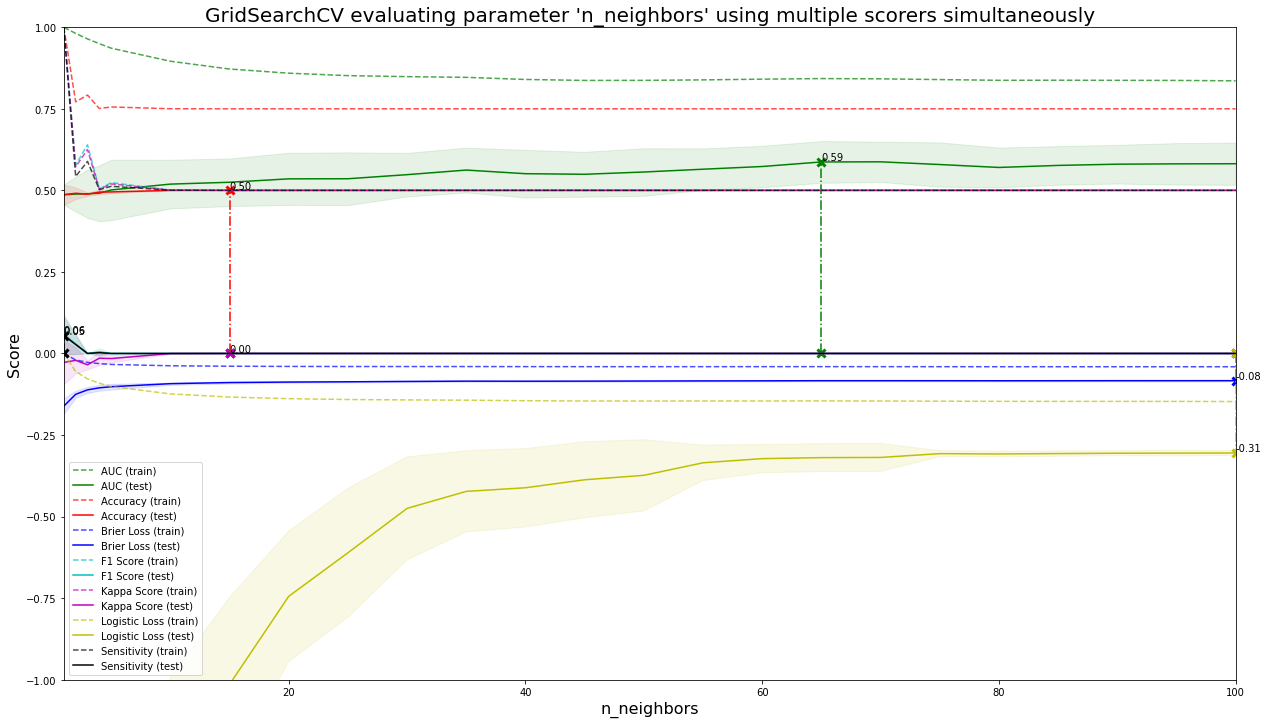

In [1075]:
plot_cv_param('n_neighbors', knn_results, log_scale=False)

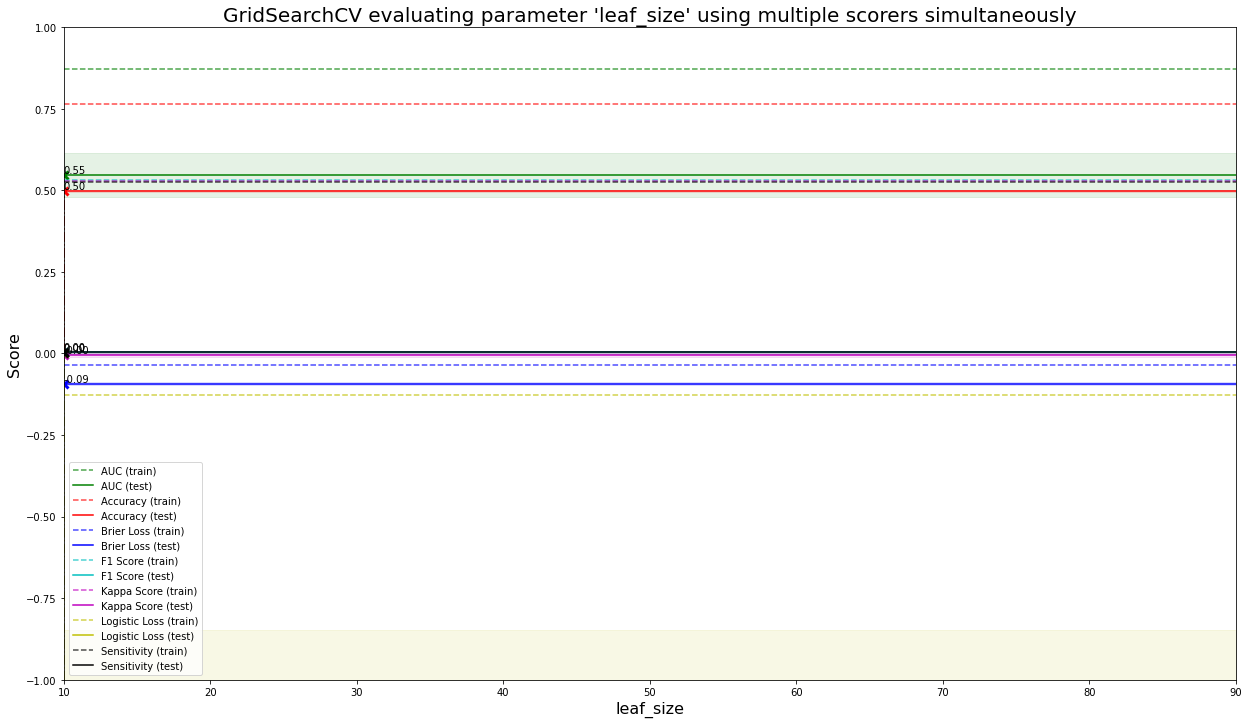

In [1076]:
plot_cv_param('leaf_size', knn_results, log_scale=False)

<AxesSubplot:title={'center':'F1 Score for N Neighbors by Leaf Size'}, xlabel='param_leaf_size', ylabel='param_n_neighbors'>

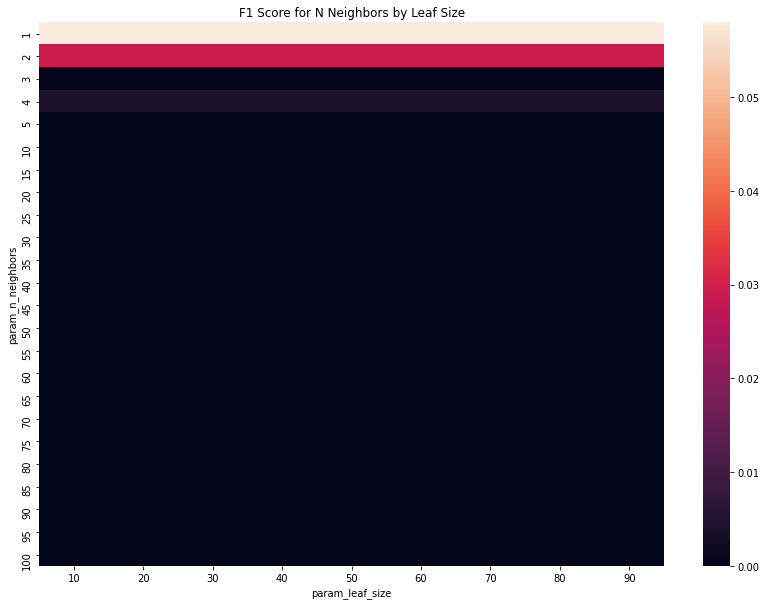

In [1077]:
f, ax = plt.subplots(figsize=SMALL_FIG_SIZE)
ax.set_title('F1 Score for N Neighbors by Leaf Size')
pvt = pd.pivot_table(pd.DataFrame(knn_results), 
                     values='mean_test_F1 Score', 
                     index='param_n_neighbors', 
                     columns='param_leaf_size')
sns.heatmap(pvt, ax=ax)

In [1078]:
best_knn_position = KNeighborsClassifier(algorithm='auto',
                                         n_neighbors=1,
                                         p=2,
                                         weights='uniform')

best_knn_position.fit(X_position_pca_train, y_position_pca_train.ravel())

KNeighborsClassifier(n_neighbors=1)

In [1079]:
tn, fp, fn, tp = confusion_matrix(y_position_pca_test, best_knn_position.predict(X_position_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 26
True Positives:  3
False Positives: 24
True Negatives:  266

Sensitivity:     0.103
Specificity:     0.917

Precision:       0.111
Accuracy:        0.843

F1 Score:        0.107


1.0


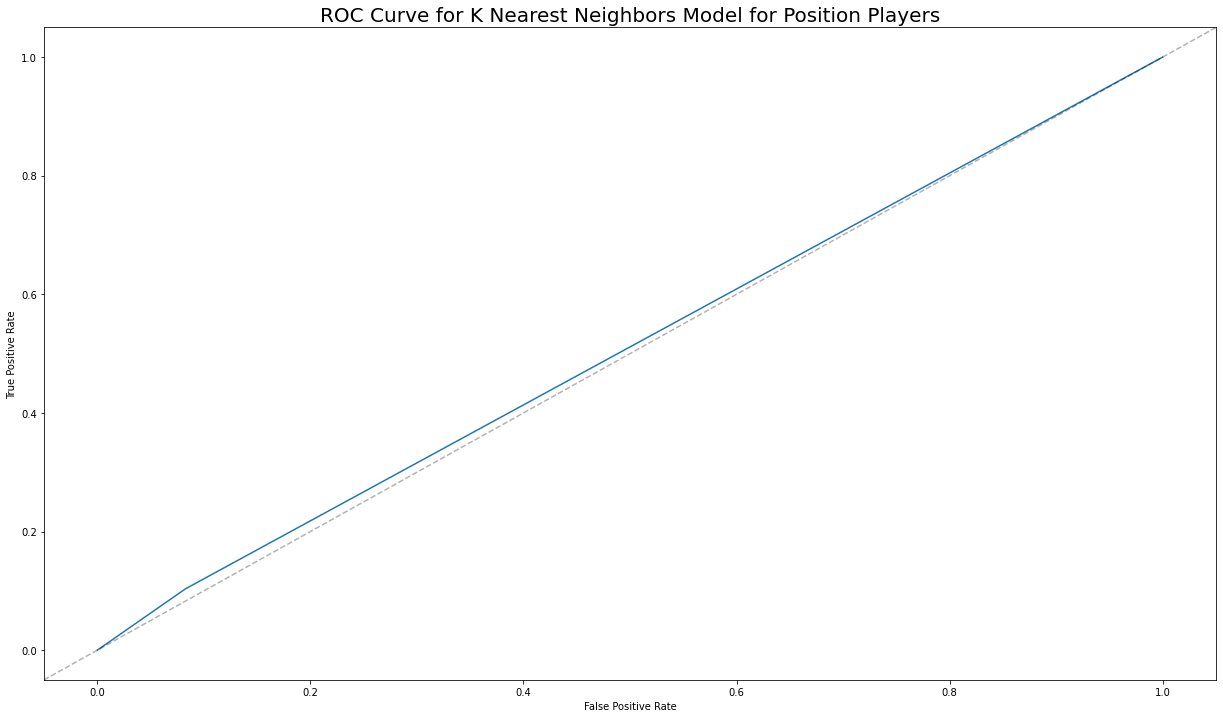

In [1080]:
fpr, tpr, thresholds = get_roc(best_knn_position, X_position_pca_test, y_position_pca_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for K Nearest Neighbors Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

### Catchers

In [1081]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    knn_clf.fit(X_catching_pca_train, y_catching_pca_train.ravel())
    
knn_results = knn_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(knn_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = knn_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (knn_results['mean_test_%s' % scorer][best_index] ,
                                        knn_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        knn_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
AUC
0.69444 (+/-0.148) for {'algorithm': 'auto', 'n_neighbors': 85, 'p': 1, 'weights': 'uniform'}

Accuracy
0.52321 (+/-0.047) for {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

Brier Loss
-0.04262 (+/-0.009) for {'algorithm': 'auto', 'n_neighbors': 85, 'p': 1, 'weights': 'uniform'}

F1 Score
0.06667 (+/-0.124) for {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

Kappa Score
0.06149 (+/-0.122) for {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

Logistic Loss
-0.17783 (+/-0.032) for {'algorithm': 'auto', 'n_neighbors': 85, 'p': 1, 'weights': 'distance'}

Sensitivity
0.05000 (+/-0.093) for {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}



In [1082]:
best_knn_catching = KNeighborsClassifier(algorithm='auto',
                                         n_neighbors=3,
                                         p=1,
                                         weights='uniform')

best_knn_catching.fit(X_catching_pca_train, y_catching_pca_train.ravel())

KNeighborsClassifier(n_neighbors=3, p=1)

In [1083]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tn, fp, fn, tp = confusion_matrix(y_catching_pca_test, best_knn_catching.predict(X_catching_pca_test)).ravel()
    print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 2
True Positives:  0
False Positives: 0
True Negatives:  70

Sensitivity:     0.0
Specificity:     1.0

Precision:       nan
Accuracy:        0.972

F1 Score:        nan


### Pitchers

In [1084]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    knn_clf.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())
    
knn_results = knn_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(knn_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = knn_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (knn_results['mean_test_%s' % scorer][best_index] ,
                                        knn_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        knn_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
AUC
0.93779 (+/-0.011) for {'algorithm': 'auto', 'n_neighbors': 30, 'p': 2, 'weights': 'distance'}

Accuracy
0.67319 (+/-0.059) for {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

Brier Loss
-0.04630 (+/-0.004) for {'algorithm': 'brute', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}

F1 Score
0.40220 (+/-0.104) for {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

Kappa Score
0.36626 (+/-0.109) for {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

Logistic Loss
-0.14372 (+/-0.011) for {'algorithm': 'brute', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}

Sensitivity
0.37857 (+/-0.117) for {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}



In [1085]:
best_knn_pitching = KNeighborsClassifier(algorithm='auto',
                                         n_neighbors=1,
                                         p=2,
                                         weights='uniform')

best_knn_pitching.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())

KNeighborsClassifier(n_neighbors=1)

In [1086]:
tn, fp, fn, tp = confusion_matrix(y_pitching_pca_test, best_knn_pitching.predict(X_pitching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 10
True Positives:  3
False Positives: 11
True Negatives:  210

Sensitivity:     0.231
Specificity:     0.95

Precision:       0.214
Accuracy:        0.91

F1 Score:        0.222


## Naive Bayes

In [1087]:
naive_bayes_parameters = [{'var_smoothing': np.logspace(-20, -1, num=20)}]

nb_clf = GridSearchCV(GaussianNB(),
                      naive_bayes_parameters,
                      cv=skf,
                      scoring=scoring_metrics,
                      refit='F1 Score',
                      return_train_score=True,
                      n_jobs=-1,
                      verbose=1)

### Position Players

In [1088]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    nb_clf.fit(X_position_pca_train, y_position_pca_train.ravel())
    
nb_results = nb_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(nb_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = nb_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (nb_results['mean_test_%s' % scorer][best_index] ,
                                        nb_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        nb_results['params'][best_index]))
    print()

Fitting 10 folds for each of 20 candidates, totalling 200 fits
AUC
0.62560 (+/-0.051) for {'var_smoothing': 0.1}

Accuracy
0.50230 (+/-0.011) for {'var_smoothing': 1e-20}

Brier Loss
-0.08552 (+/-0.002) for {'var_smoothing': 0.1}

F1 Score
0.02762 (+/-0.034) for {'var_smoothing': 1e-20}

Kappa Score
0.00747 (+/-0.033) for {'var_smoothing': 1e-20}

Logistic Loss
-0.31672 (+/-0.016) for {'var_smoothing': 0.1}

Sensitivity
0.01667 (+/-0.021) for {'var_smoothing': 1e-20}



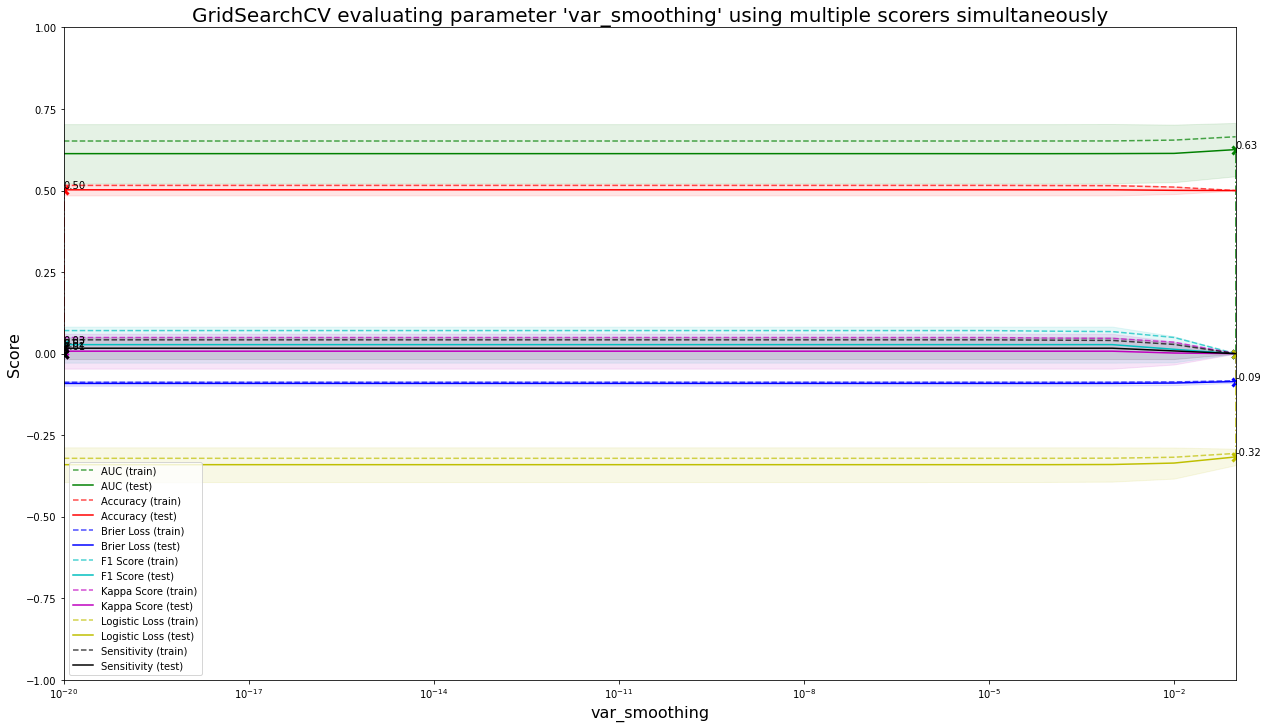

In [1089]:
plot_cv_param('var_smoothing', nb_results, log_scale=True)

In [1090]:
best_nb_position = GaussianNB(var_smoothing=.0001)

best_nb_position.fit(X_position_pca_train, y_position_pca_train.ravel())

GaussianNB(var_smoothing=0.0001)

In [1091]:
tn, fp, fn, tp = confusion_matrix(y_position_pca_test, best_nb_position.predict(X_position_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 28
True Positives:  1
False Positives: 3
True Negatives:  287

Sensitivity:     0.034
Specificity:     0.99

Precision:       0.25
Accuracy:        0.903

F1 Score:        0.061


0.14253953874725267


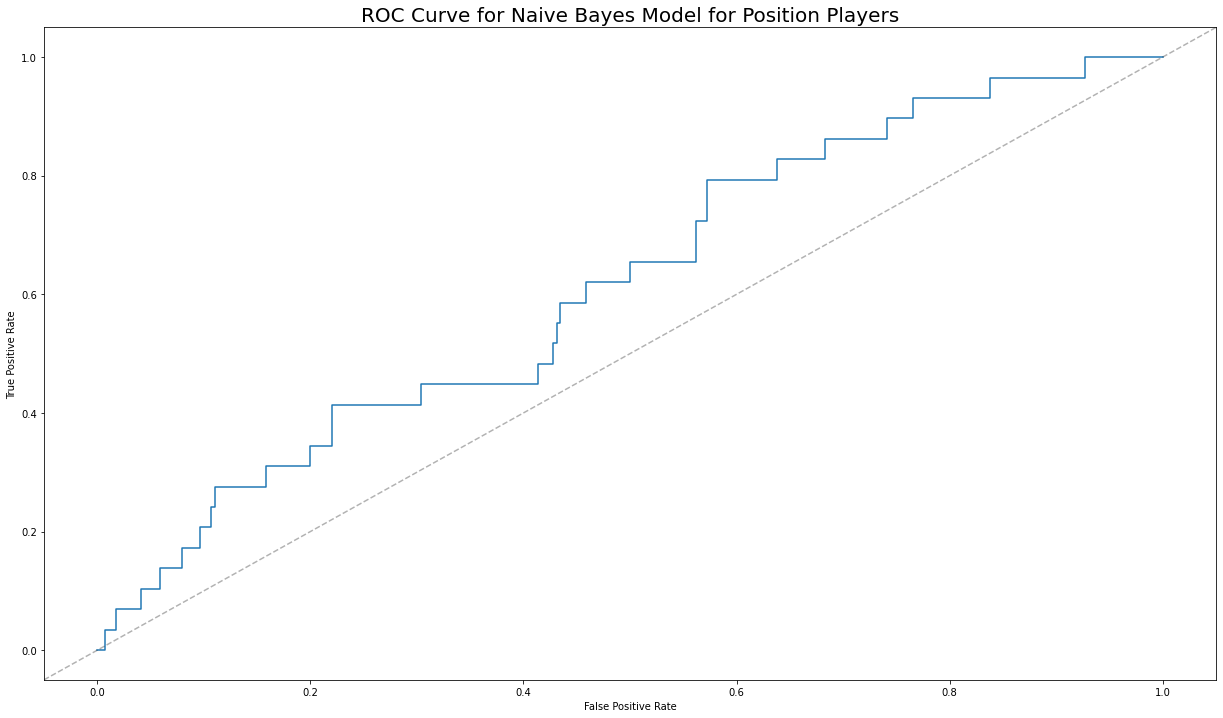

In [1092]:
fpr, tpr, thresholds = get_roc(best_nb_position, X_position_pca_test, y_position_pca_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Naive Bayes Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1093]:
tn, fp, fn, tp = confusion_matrix(y_position_pca_test, (best_nb_position.predict_proba(X_position_pca_test)[:,1] >= best_threshold).astype(bool)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 11
True Positives:  18
False Positives: 133
True Negatives:  157

Sensitivity:     0.621
Specificity:     0.541

Precision:       0.119
Accuracy:        0.549

F1 Score:        0.2


### Catchers

In [1094]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    nb_clf.fit(X_catching_pca_train, y_catching_pca_train.ravel())
    
nb_results = nb_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(nb_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = nb_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (nb_results['mean_test_%s' % scorer][best_index] ,
                                        nb_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        nb_results['params'][best_index]))
    print()

Fitting 10 folds for each of 20 candidates, totalling 200 fits
AUC
0.67077 (+/-0.170) for {'var_smoothing': 0.1}

Accuracy
0.49815 (+/-0.003) for {'var_smoothing': 0.1}

Brier Loss
-0.04755 (+/-0.011) for {'var_smoothing': 0.1}

F1 Score
0.00000 (+/-0.000) for {'var_smoothing': 1e-20}

Kappa Score
-0.00482 (+/-0.009) for {'var_smoothing': 0.1}

Logistic Loss
-0.20757 (+/-0.051) for {'var_smoothing': 0.1}

Sensitivity
0.00000 (+/-0.000) for {'var_smoothing': 1e-20}



In [1095]:
best_nb_catching = GaussianNB(var_smoothing=.1)

best_nb_catching.fit(X_catching_pca_train, y_catching_pca_train.ravel())

GaussianNB(var_smoothing=0.1)

In [1096]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tn, fp, fn, tp = confusion_matrix(y_catching_pca_test, best_nb_catching.predict(X_catching_pca_test)).ravel()
    print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 2
True Positives:  0
False Positives: 0
True Negatives:  70

Sensitivity:     0.0
Specificity:     1.0

Precision:       nan
Accuracy:        0.972

F1 Score:        nan


### Pitchers

In [1097]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    nb_clf.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())
    
nb_results = nb_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(nb_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = nb_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (nb_results['mean_test_%s' % scorer][best_index] ,
                                        nb_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        nb_results['params'][best_index]))
    print()

Fitting 10 folds for each of 20 candidates, totalling 200 fits
AUC
0.92417 (+/-0.014) for {'var_smoothing': 0.1}

Accuracy
0.63444 (+/-0.062) for {'var_smoothing': 0.01}

Brier Loss
-0.04820 (+/-0.006) for {'var_smoothing': 0.1}

F1 Score
0.33444 (+/-0.126) for {'var_smoothing': 0.01}

Kappa Score
0.29820 (+/-0.131) for {'var_smoothing': 0.01}

Logistic Loss
-0.15785 (+/-0.016) for {'var_smoothing': 0.1}

Sensitivity
0.29762 (+/-0.122) for {'var_smoothing': 1e-20}



In [1098]:
best_nb_pitching = GaussianNB(var_smoothing=.01)

best_nb_pitching.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())

GaussianNB(var_smoothing=0.01)

In [1099]:
tn, fp, fn, tp = confusion_matrix(y_pitching_pca_test, best_nb_pitching.predict(X_pitching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 7
True Positives:  6
False Positives: 7
True Negatives:  214

Sensitivity:     0.462
Specificity:     0.968

Precision:       0.462
Accuracy:        0.94

F1 Score:        0.462


## Random Forest

In [1100]:
rf_parameters = [{'n_estimators': [500, 1000],
                  'random_state': [42],
                  'max_features': range(1, 20),
                  'max_depth': range(1, 20)}]

rf_clf = GridSearchCV(RandomForestClassifier(),
                      rf_parameters,
                      cv=skf,
                      scoring=scoring_metrics,
                      refit='F1 Score',
                      return_train_score=True,
                      n_jobs=-1,
                      verbose=1)

### Position Players

In [1101]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf_clf.fit(X_position_pca_train, y_position_pca_train.ravel())
    
rf_results = rf_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(rf_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = rf_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (rf_results['mean_test_%s' % scorer][best_index] ,
                                        rf_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        rf_results['params'][best_index]))
    print()

Fitting 10 folds for each of 722 candidates, totalling 7220 fits
AUC
0.60001 (+/-0.031) for {'max_depth': 2, 'max_features': 2, 'n_estimators': 500, 'random_state': 42}

Accuracy
0.50115 (+/-0.008) for {'max_depth': 8, 'max_features': 10, 'n_estimators': 500, 'random_state': 42}

Brier Loss
-0.08340 (+/-0.001) for {'max_depth': 2, 'max_features': 2, 'n_estimators': 500, 'random_state': 42}

F1 Score
0.01429 (+/-0.027) for {'max_depth': 8, 'max_features': 10, 'n_estimators': 500, 'random_state': 42}

Kappa Score
0.00313 (+/-0.024) for {'max_depth': 8, 'max_features': 10, 'n_estimators': 500, 'random_state': 42}

Logistic Loss
-0.30469 (+/-0.006) for {'max_depth': 3, 'max_features': 6, 'n_estimators': 500, 'random_state': 42}

Sensitivity
0.00833 (+/-0.015) for {'max_depth': 8, 'max_features': 10, 'n_estimators': 500, 'random_state': 42}



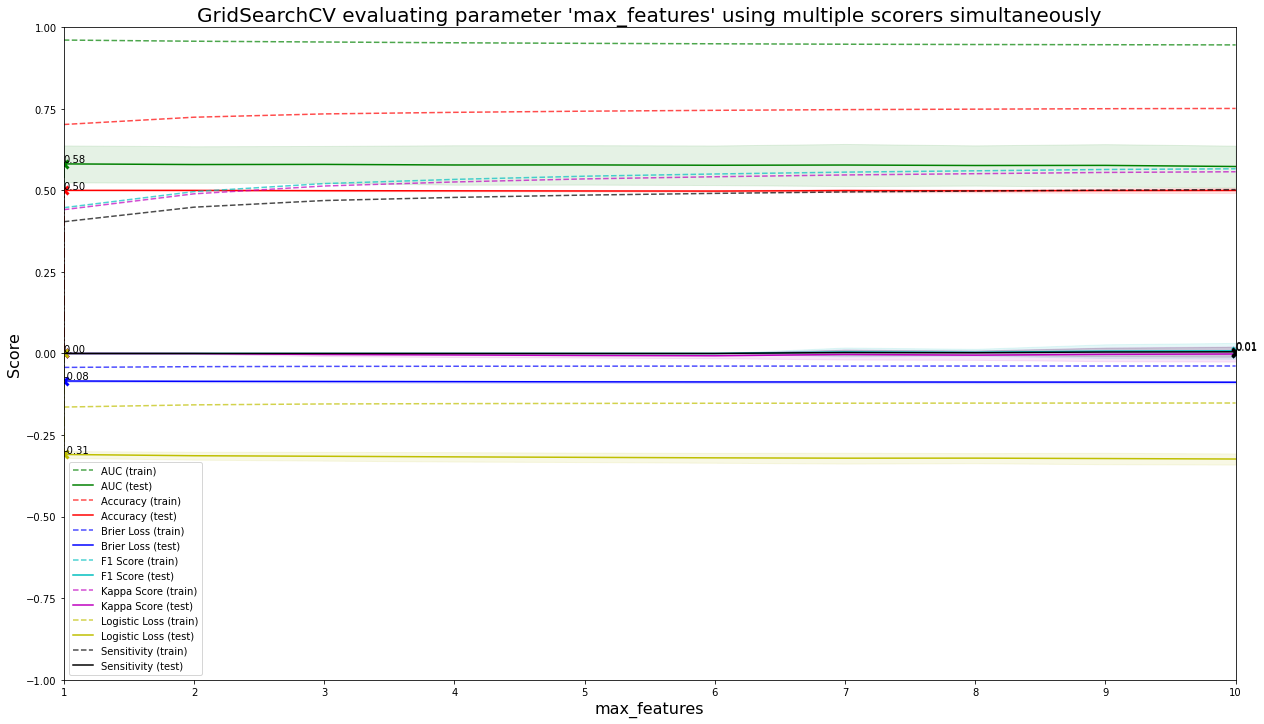

In [1102]:
plot_cv_param('max_features', rf_results, log_scale=False)

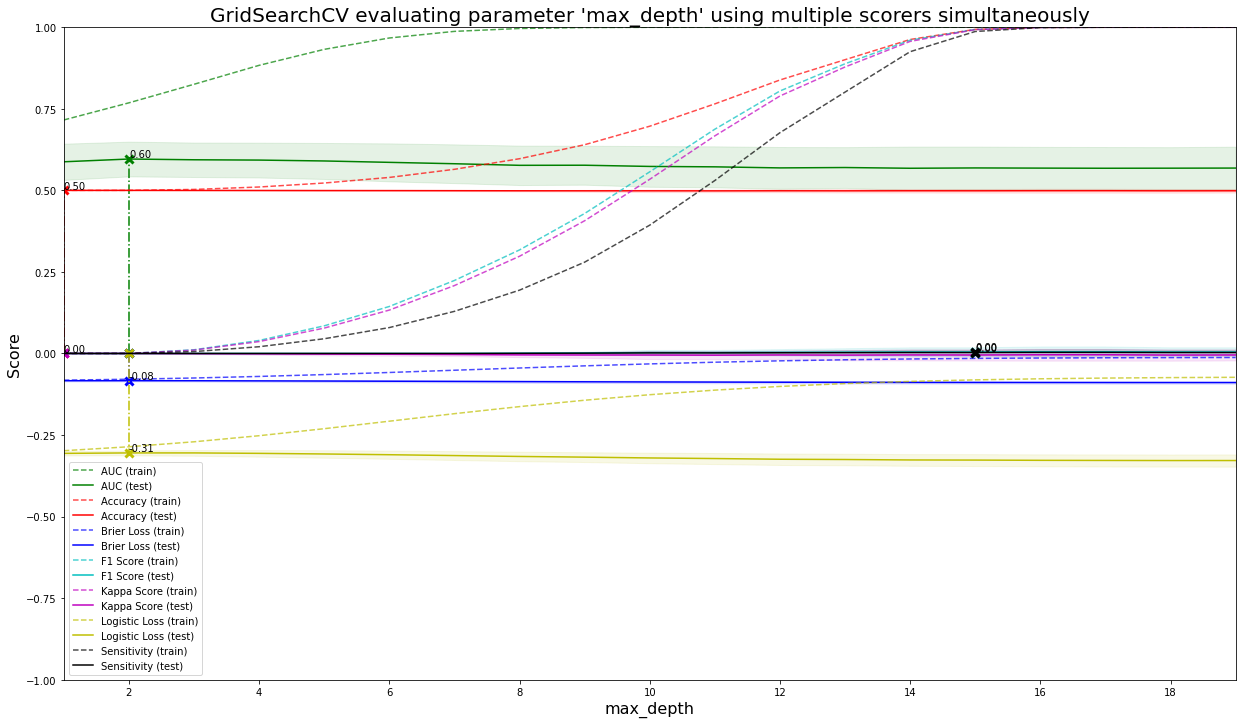

In [1103]:
plot_cv_param('max_depth', rf_results, log_scale=False)

<AxesSubplot:title={'center':'F1 Score for Max Depth by Max Features'}, xlabel='param_max_features', ylabel='param_max_depth'>

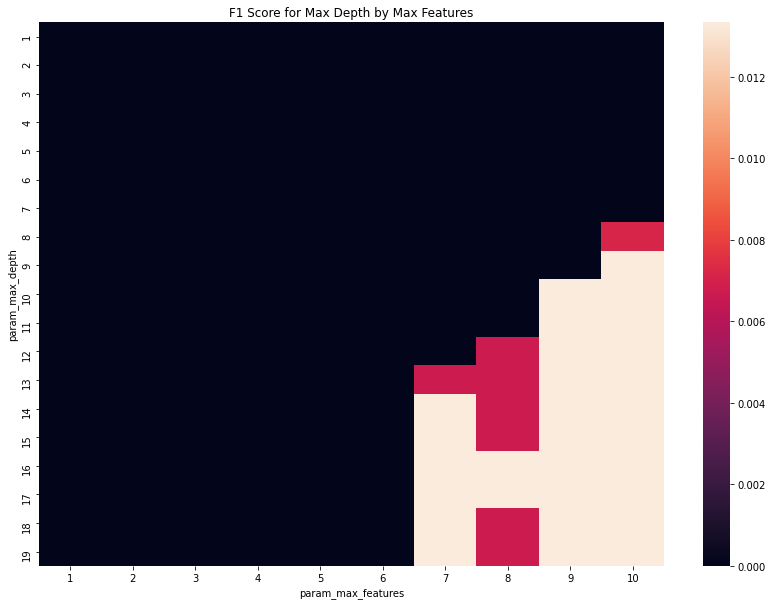

In [1104]:
f, ax = plt.subplots(figsize=SMALL_FIG_SIZE)
ax.set_title('F1 Score for Max Depth by Max Features')
pvt = pd.pivot_table(pd.DataFrame(rf_results), 
                     values='mean_test_F1 Score', 
                     index='param_max_depth', 
                     columns='param_max_features')
sns.heatmap(pvt, ax=ax)

In [1105]:
best_rf_position = RandomForestClassifier(n_estimators=500,
                                          max_depth=13,
                                          max_features=10,
                                          random_state=42)

best_rf_position.fit(X_position_pca_train, y_position_pca_train.ravel())

RandomForestClassifier(max_depth=13, max_features=10, n_estimators=500,
                       random_state=42)

In [1106]:
tn, fp, fn, tp = confusion_matrix(y_position_pca_test, best_rf_position.predict(X_position_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 28
True Positives:  1
False Positives: 1
True Negatives:  289

Sensitivity:     0.034
Specificity:     0.997

Precision:       0.5
Accuracy:        0.909

F1 Score:        0.065


0.12452090402075691


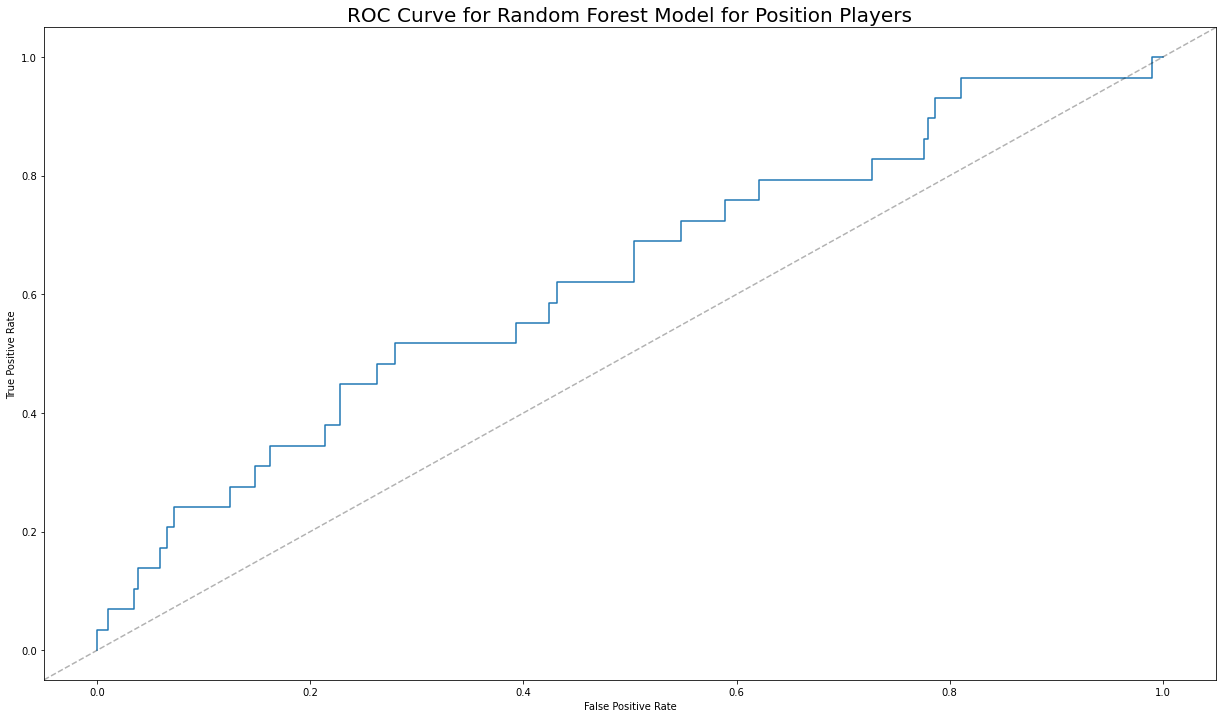

In [1107]:
fpr, tpr, thresholds = get_roc(best_rf_position, X_position_pca_test, y_position_pca_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Random Forest Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1108]:
tn, fp, fn, tp = confusion_matrix(y_position_pca_test, (best_rf_position.predict_proba(X_position_pca_test)[:,1] >= best_threshold).astype(bool)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 14
True Positives:  15
False Positives: 81
True Negatives:  209

Sensitivity:     0.517
Specificity:     0.721

Precision:       0.156
Accuracy:        0.702

F1 Score:        0.24


### Catchers

In [1109]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf_clf.fit(X_catching_pca_train, y_catching_pca_train.ravel())
    
rf_results = rf_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(rf_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = rf_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (rf_results['mean_test_%s' % scorer][best_index] ,
                                        rf_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        rf_results['params'][best_index]))
    print()

Fitting 10 folds for each of 722 candidates, totalling 7220 fits
AUC
0.78366 (+/-0.116) for {'max_depth': 6, 'max_features': 9, 'n_estimators': 500, 'random_state': 42}

Accuracy
0.50000 (+/-0.000) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 500, 'random_state': 42}

Brier Loss
-0.04166 (+/-0.008) for {'max_depth': 4, 'max_features': 1, 'n_estimators': 500, 'random_state': 42}

F1 Score
0.00000 (+/-0.000) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 500, 'random_state': 42}

Kappa Score
0.00000 (+/-0.000) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 500, 'random_state': 42}

Logistic Loss
-0.16666 (+/-0.031) for {'max_depth': 11, 'max_features': 1, 'n_estimators': 1000, 'random_state': 42}

Sensitivity
0.00000 (+/-0.000) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 500, 'random_state': 42}



In [1110]:
best_rf_catching = RandomForestClassifier(n_estimators=500,
                                          max_depth=6,
                                          max_features=9)

best_rf_catching.fit(X_catching_pca_train, y_catching_pca_train.ravel())

RandomForestClassifier(max_depth=6, max_features=9, n_estimators=500)

In [1111]:
tn, fp, fn, tp = confusion_matrix(y_catching_pca_test, best_rf_catching.predict(X_catching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 2
True Positives:  0
False Positives: 1
True Negatives:  69

Sensitivity:     0.0
Specificity:     0.986

Precision:       0.0
Accuracy:        0.958

F1 Score:        0.0


### Pitchers

In [1112]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf_clf.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())
    
rf_results = rf_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(rf_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = rf_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (rf_results['mean_test_%s' % scorer][best_index] ,
                                        rf_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        rf_results['params'][best_index]))
    print()

Fitting 10 folds for each of 722 candidates, totalling 7220 fits
AUC
0.93900 (+/-0.019) for {'max_depth': 9, 'max_features': 2, 'n_estimators': 1000, 'random_state': 42}

Accuracy
0.66999 (+/-0.065) for {'max_depth': 8, 'max_features': 11, 'n_estimators': 1000, 'random_state': 42}

Brier Loss
-0.04415 (+/-0.006) for {'max_depth': 13, 'max_features': 3, 'n_estimators': 500, 'random_state': 42}

F1 Score
0.42730 (+/-0.137) for {'max_depth': 8, 'max_features': 11, 'n_estimators': 1000, 'random_state': 42}

Kappa Score
0.39849 (+/-0.142) for {'max_depth': 8, 'max_features': 11, 'n_estimators': 1000, 'random_state': 42}

Logistic Loss
-0.14854 (+/-0.022) for {'max_depth': 10, 'max_features': 5, 'n_estimators': 500, 'random_state': 42}

Sensitivity
0.35952 (+/-0.127) for {'max_depth': 8, 'max_features': 11, 'n_estimators': 1000, 'random_state': 42}



In [1113]:
best_rf_pitching = RandomForestClassifier(n_estimators=1000,
                                          max_depth=8,
                                          max_features=11)

best_rf_pitching.fit(X_pitching_pca_train, y_pitching_pca_train.ravel())

RandomForestClassifier(max_depth=8, max_features=11, n_estimators=1000)

In [1114]:
tn, fp, fn, tp = confusion_matrix(y_pitching_pca_test, best_rf_pitching.predict(X_pitching_pca_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 8
True Positives:  5
False Positives: 3
True Negatives:  218

Sensitivity:     0.385
Specificity:     0.986

Precision:       0.625
Accuracy:        0.953

F1 Score:        0.476


In [1115]:
dill.dump_session('notebook_env.db')

# Most Important Features

Next we want to take a look at what baseball statistics are most important to making it into the Hall of Fame.  To do this, we will use the data that is not transformed by principal components analysis since we would lose interpretability.  We also won't use any "holdout" or active players here so that we can use these models for analysis later.

In [128]:
active_position_df = position_df[position_df['playerID'].isin(active_players['playerID'])]
position_df_holdout = position_df[position_df['playerID'].isin(holdout_players)]

# Remove the active players from the position df
position_df = position_df[~position_df['playerID'].isin(active_players['playerID'])]

# Remove the holdout players from the position df
position_df = position_df[~position_df['playerID'].isin(holdout_players)]

y_position = position_df['isHallOfFame'].values
X_position = position_df.drop(columns=['isHallOfFame', 'playerID']).values
X_position_train, X_position_test, y_position_train, y_position_test = train_test_split(X_position, y_position, test_size=0.2, random_state=42)

# Remove the active players from the catcher df
active_catching_df = catching_df[catching_df['playerID'].isin(active_players['playerID'])]
catching_df = catching_df[~catching_df['playerID'].isin(active_players['playerID'])]

y_catching = catching_df['isHallOfFame'].values
X_catching = catching_df.drop(columns=['isHallOfFame', 'playerID']).values
X_catching_train, X_catching_test, y_catching_train, y_catching_test = train_test_split(X_catching, y_catching, test_size=0.2, random_state=42)

# Remove the active players from the pitcher df
active_pitcher_df = pitcher_df[pitcher_df['playerID'].isin(active_players['playerID'])]
pitcher_df = pitcher_df[~pitcher_df['playerID'].isin(active_players['playerID'])]

y_pitching = pitcher_df['isHallOfFame'].values
X_pitching = pitcher_df.drop(columns=['isHallOfFame', 'playerID']).values
X_pitching_train, X_pitching_test, y_pitching_train, y_pitching_test = train_test_split(X_pitching, y_pitching, test_size=0.2, random_state=42)

Since, K Nearest Neighbors and Naive Bayes didn't perform as well on the PCA transformed data, we will not be including them in our analysis here.

## Position Players

### Logistic Regression

In [1299]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_clf.fit(X_position_train, y_position_train.ravel())
    
lr_results = lr_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lr_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lr_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lr_results['mean_test_%s' % scorer][best_index] ,
                                        lr_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lr_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1530 candidates, totalling 15300 fits
AUC
0.96168 (+/-0.025) for {'C': 1.0, 'class_weight': None, 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-05}

Accuracy
0.90599 (+/-0.033) for {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

Brier Loss
-0.03520 (+/-0.008) for {'C': 1.0, 'class_weight': None, 'l1_ratio': 1.0, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06}

F1 Score
0.70175 (+/-0.072) for {'C': 1000.0, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001}

Kappa Score
0.67601 (+/-0.078) for {'C': 1000.0, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001}

Logistic Loss
-0.13699 (+/-0.043) for {'C': 10.0, 'class_weight': None, 'l1_ratio': 1.0,

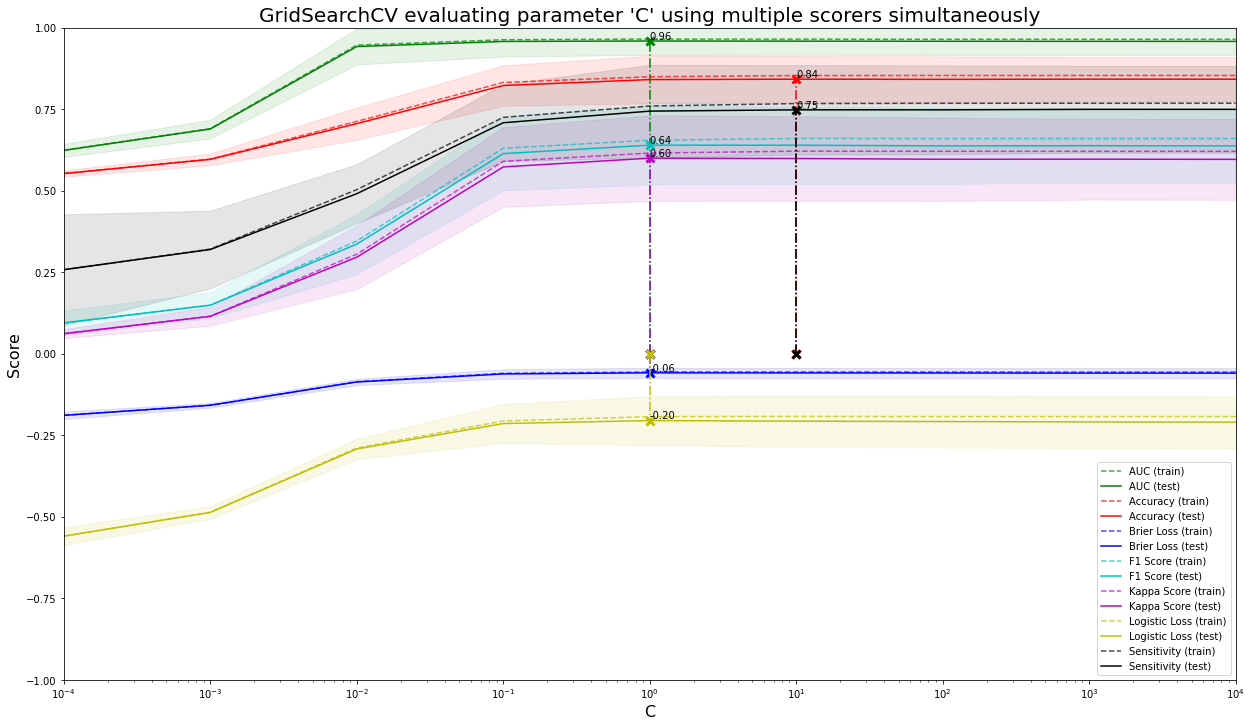

In [1300]:
plot_cv_param('C', lr_results, log_scale=True)

In [1301]:
best_lr_position = LogisticRegression(C=10.0,
                                      class_weight=None,
                                      max_iter=10000,
                                      penalty='l2',
                                      random_state=42,
                                      solver='newton-cg',
                                      tol=0.0001)

best_lr_position.fit(X_position_train, y_position_train.ravel())

LogisticRegression(C=10.0, max_iter=10000, random_state=42, solver='newton-cg')

In [1302]:
tn, fp, fn, tp = confusion_matrix(y_position_test, best_lr_position.predict(X_position_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 13
True Positives:  16
False Positives: 5
True Negatives:  285

Sensitivity:     0.552
Specificity:     0.983

Precision:       0.762
Accuracy:        0.944

F1 Score:        0.64


0.08717009041681052


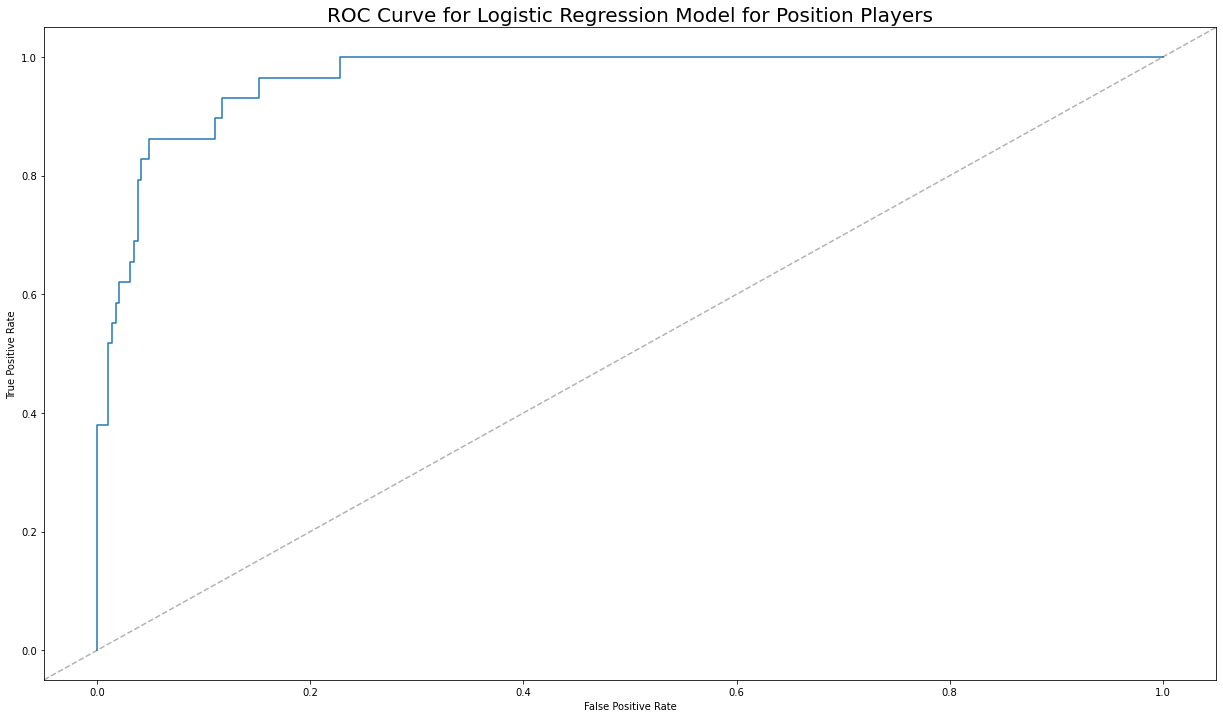

In [1303]:
fpr, tpr, thresholds = get_roc(best_lr_position, X_position_test, y_position_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Logistic Regression Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

Now that we have a model that is adequate and bases its prediction off an interpretable transformation of the original baseball statistics, we can permute to find the importance of these features.

In [1304]:
def get_perm_importance(model, X, y, df):
    perms_multi = permutation_importance(model, X, y, n_repeats=1000, 
                                   scoring=['f1', 'balanced_accuracy'], n_jobs=3, random_state=42)

    column_names = df.drop(columns=['isHallOfFame', 'playerID']).columns

    feature_indexes = dict()
    for metric in perms_multi:
        print(metric)
        perms = perms_multi[metric]
        for i in perms.importances_mean.argsort()[::-1]:
            if metric == 'f1':
                feature_indexes[column_names[i]] = i
            if perms.importances_mean[i] - 1.65 * perms.importances_std[i] > 0:
                print(f"{column_names[i]:<15}"
                      f"{perms.importances_mean[i]:.3f}"
                      f" +/- {perms.importances_std[i]:.3f}")
        print()
    return feature_indexes

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. Shuffling a feature destroys the relationship between that feature and making it into the Hall of Fame. Therefore, permuting (shuffling the feature) shows how much the model depends on that feature.  We will repeat this process 1000 times and then form a one-sided 95% confidence interval to determine which features show a value greater than 0 (have an affect on the model).

In [1305]:
feature_indexes = get_perm_importance(best_lr_position, X_position_test, y_position_test, position_df)

f1
RC             0.500 +/- 0.066
BA             0.131 +/- 0.067
ISO            0.106 +/- 0.043

balanced_accuracy
RC             0.237 +/- 0.031
BA             0.079 +/- 0.032
ISO            0.048 +/- 0.023



We've defined our scoring metrics here to be the F1 score (the harmonic mean of precision and recall) and the accuracy. The interpretation for the output for Runs Created, for example, is that with that feature included, the F1 score was .64 and without Runs Created used in the model the F1 score would decrease by about .5. Similarly the accuracy was .944 and would be expected to drop be about .237

Another way we can view feature importance is through partial dependence plots. A partial dependence plot for a feature shows the dependence between making it into the Hall of Fame and that particular feature, marginalizing over the values of all other features. The X axis represents the feature in question (keep in mind that these variables have been transformed to be Standard Normal). And the Y axis represents the predicted probability of making it into the Hall of Fame, all other things being equal.

In [1306]:
def show_partial_dependence(model, X, feature_indexes, feature_names, title):
    f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
    ax.set_title(title, fontsize=GLOBAL_TITLE_SIZE)
    PartialDependenceDisplay.from_estimator(model,
                                            X,
                                            [feature_indexes.get(k) for k in feature_names], 
                                            random_state=42,
                                            ax=ax)

Here I've made partial dependence plots for two important features to the model, runs created and batting average, and for comparison one less important feature, sacrifces per at bat.  The key thing to note here is the slope of the line.  A steep slope indicates a strong relationship, whereas a shallow slope indicates that having a far above or below average stat in this category won't make much of a difference in terms of making it to the Hall of Fame.

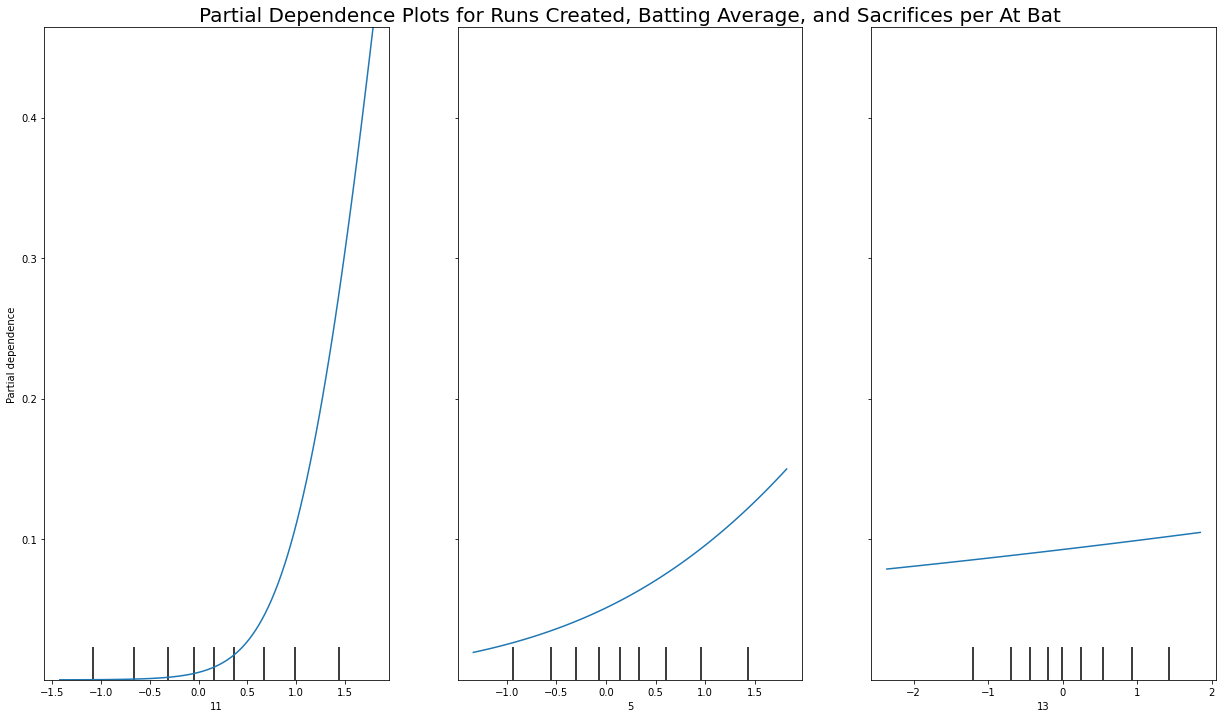

In [1307]:
show_partial_dependence(best_lr_position, X_position_train, feature_indexes, ['RC', 'BA', 'S_AB'], 'Partial Dependence Plots for Runs Created, Batting Average, and Sacrifices per At Bat')

Lastly, for logistic regression we can look at the coefficients used in the calculation for the probability after the data has been fit.

In [1308]:
def show_lr_coefs(model, df):
    cols = list(df.drop(columns=['isHallOfFame', 'playerID']).columns)
    coefs = list(model.coef_.ravel())
    zipped = list(zip(cols, coefs))
    for feature, coef in sorted(zipped, key=lambda x: x[1], reverse=True):
        print(feature.ljust(15), round(coef, 3))

In [1309]:
show_lr_coefs(best_lr_position, position_df)

RC              3.506
BA              1.181
ISO             0.945
BB_K            0.508
SB_CS           0.402
AB_HR           0.385
RF              0.374
DP_G            0.345
S_AB            0.166
GIDP_AB         -0.057
TP_G            -0.107
OBP             -0.166
FP              -0.612
OPS             -1.003


Logistic regression works by fitting the data to a logit function to find the log odds of a player being in the Hall of Fame. Therefore, the probability of making it into the Hall of Fame is defined as:

![title](logistic_regression.png)

Where each x is a value of a particular baseball statistic and each beta is that statistic's coefficient listed above. So a one unit increase in a stat above can be interpreted as an increase in the odds by e to the power of that stat's coefficient.

In [1310]:
batting_df_box_cox_lambdas[17:]

True  Rounded
AB_HR     0.017412      0.0
BA        1.412867      1.5
BABIP     1.903245      2.0
BB_K     -1.500924     -1.5
SB_CS     1.689535      1.5
XBH       0.423886      0.5
TB        0.481300      0.5
BsR       0.422712      0.5
OBP       1.295365      1.5
SLG       0.714772      0.5
OPS       1.049633      1.0
GPA       1.049633      1.0
HR_H     -5.936105     -6.0
ISO       0.433104      0.5
RC        0.416233      0.5
RP        0.459211      0.5
TA        0.558576      0.5
GIDP_AB  12.818689     13.0
S_AB    -31.511508    -31.5

Recall that we have used the Box-Cox transformations on these variables. For example, we are using the square root of runs created and the log of at bats per home run.  So as the square root of runs created for a player goes up by 1, and all other things remain equal, then that player's odds of making it into the Hall of Fame go up by e^3.506. 

So the larger the coefficient the more beneficial the baseball statistic is towards making it into the Hall of Fame, the smaller the more detremental the baseball statistic is, and a coefficient close to 0 would mean that the baseball statistic is unimportant.

### Linear Discriminant Analysis

In [1311]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lda_clf.fit(X_position_train, y_position_train.ravel())
    
lda_results = lda_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lda_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lda_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lda_results['mean_test_%s' % scorer][best_index] ,
                                        lda_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lda_results['params'][best_index]))
    print()

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
AUC
0.95723 (+/-0.029) for {'shrinkage': None, 'solver': 'svd', 'tol': 0.1}

Accuracy
0.83617 (+/-0.052) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}

Brier Loss
-0.04004 (+/-0.007) for {'shrinkage': None, 'solver': 'svd', 'tol': 0.1}

F1 Score
0.64974 (+/-0.072) for {'shrinkage': 0.7000000000000001, 'solver': 'lsqr', 'tol': 10.0}

Kappa Score
0.61464 (+/-0.078) for {'shrinkage': 0.7000000000000001, 'solver': 'lsqr', 'tol': 10.0}

Logistic Loss
-0.14917 (+/-0.039) for {'shrinkage': None, 'solver': 'svd', 'tol': 0.1}

Sensitivity
0.73712 (+/-0.102) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}



In [1313]:
best_lda_position = LinearDiscriminantAnalysis(shrinkage=0.7,
                                               solver='lsqr',
                                               tol=10)

best_lda_position.fit(X_position_train, y_position_train.ravel())

LinearDiscriminantAnalysis(shrinkage=0.7, solver='lsqr', tol=10)

In [1314]:
tn, fp, fn, tp = confusion_matrix(y_position_test, best_lda_position.predict(X_position_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 10
True Positives:  19
False Positives: 11
True Negatives:  279

Sensitivity:     0.655
Specificity:     0.962

Precision:       0.633
Accuracy:        0.934

F1 Score:        0.644


0.1312470755617279


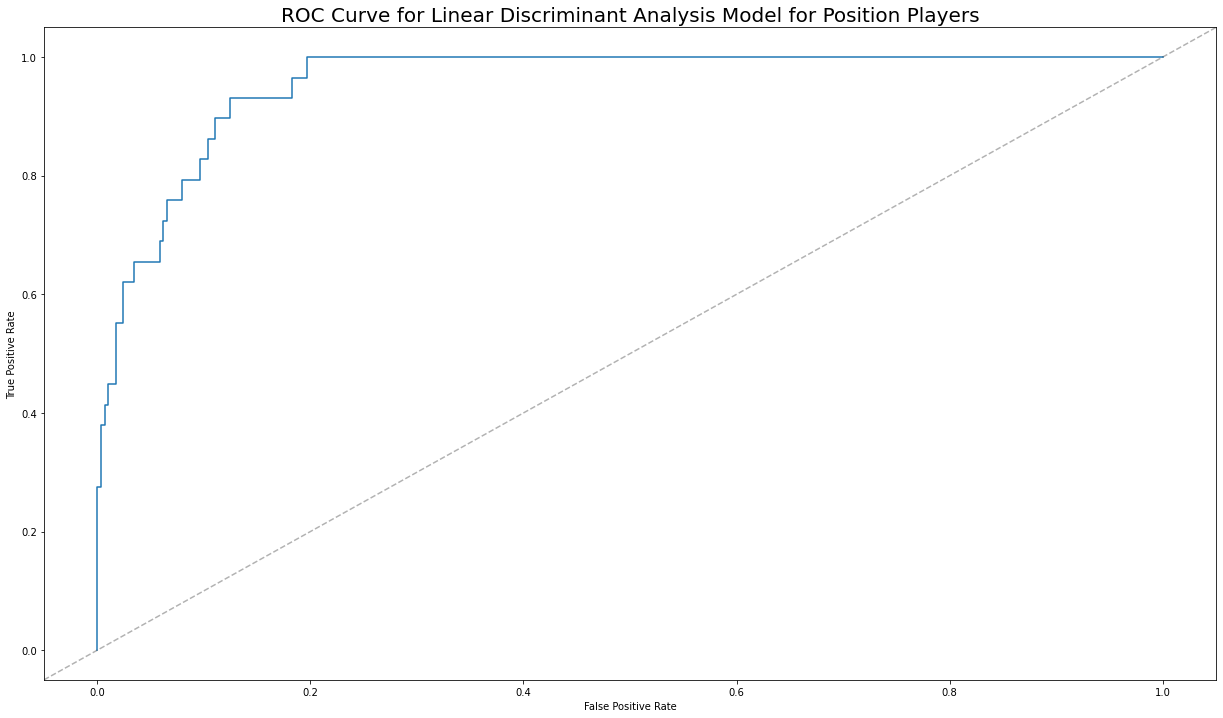

In [1315]:
fpr, tpr, thresholds = get_roc(best_lda_position, X_position_test, y_position_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Linear Discriminant Analysis Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1316]:
feature_indexes = get_perm_importance(best_lda_position, X_position_test, y_position_test, position_df)

f1
RC             0.161 +/- 0.056
OPS            0.074 +/- 0.042

balanced_accuracy
RC             0.122 +/- 0.028
OPS            0.074 +/- 0.023
BA             0.068 +/- 0.026
OBP            0.056 +/- 0.024
FP             0.016 +/- 0.009



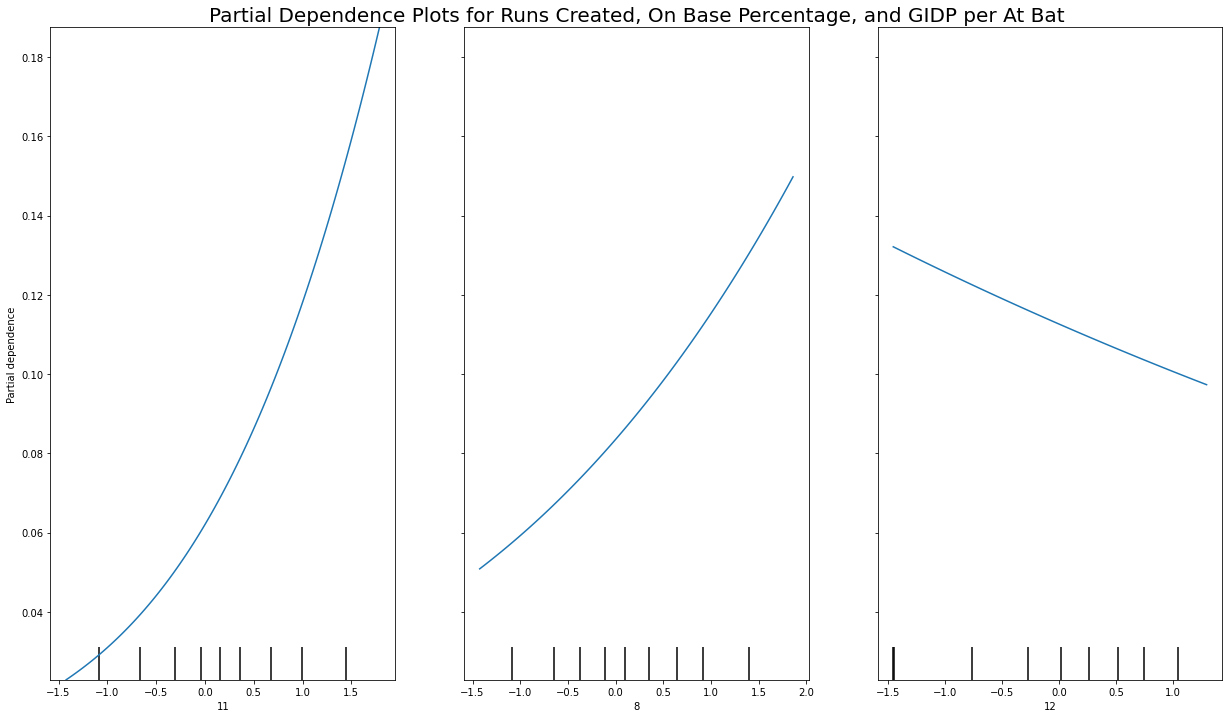

In [1317]:
show_partial_dependence(best_lda_position, X_position_train, feature_indexes, ['RC', 'OBP', 'GIDP_AB'], 'Partial Dependence Plots for Runs Created, On Base Percentage, and GIDP per At Bat')

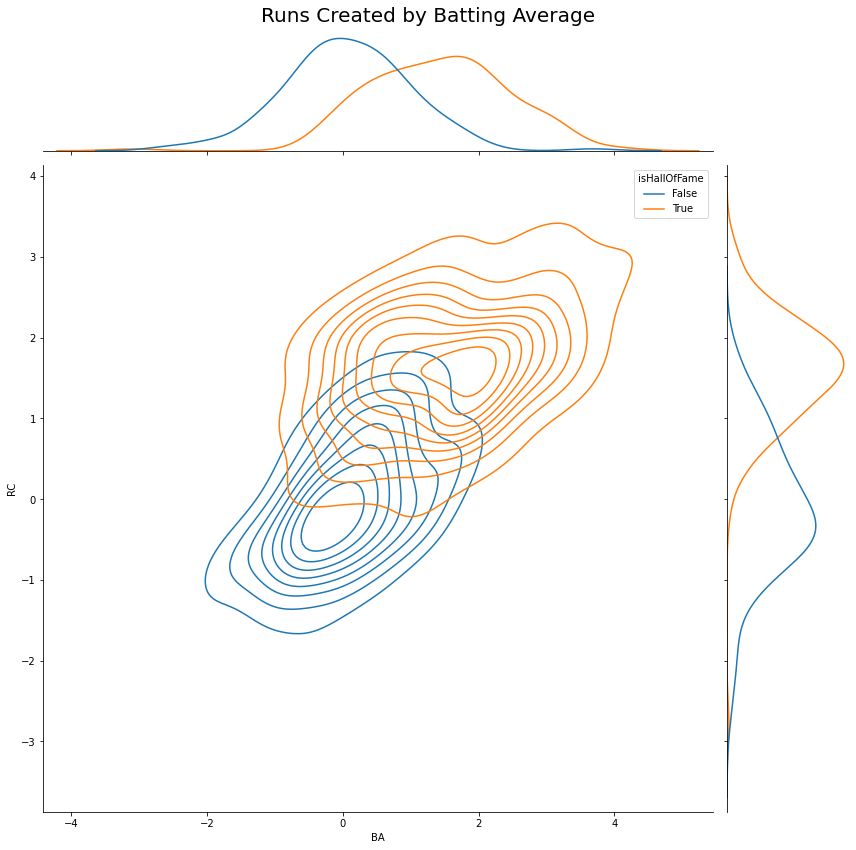

In [1318]:
batting_df_box_cox_z['isHallOfFame'] = batting_df['isHallOfFame']

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(batting_df_box_cox_z.drop(columns=['isHallOfFame']), 
                                batting_df_box_cox_z['isHallOfFame'])

p = sns.jointplot(x=X_res['BA'],
                  y=X_res['RC'],
                  hue=y_res,
                  kind='kde',
                  height=12)

p.fig.suptitle('Runs Created by Batting Average', fontsize=GLOBAL_TITLE_SIZE)
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

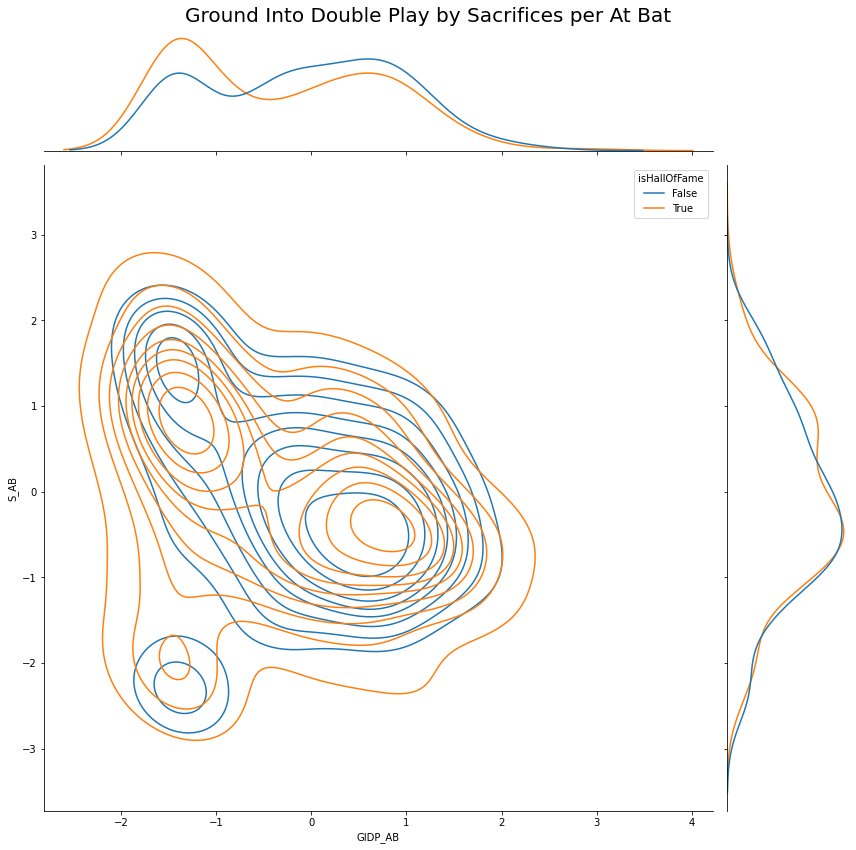

In [1319]:
p = sns.jointplot(x=X_res['GIDP_AB'],
                  y=X_res['S_AB'],
                  hue=y_res,
                  kind='kde',
                  height=12)

p.fig.suptitle('Ground Into Double Play by Sacrifices per At Bat', fontsize=GLOBAL_TITLE_SIZE)
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

### Random Forest

In [1320]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf_clf.fit(X_position_train, y_position_train.ravel())
    
rf_results = rf_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(rf_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = rf_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (rf_results['mean_test_%s' % scorer][best_index] ,
                                        rf_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        rf_results['params'][best_index]))
    print()

Fitting 10 folds for each of 722 candidates, totalling 7220 fits
AUC
0.95726 (+/-0.024) for {'max_depth': 9, 'max_features': 10, 'n_estimators': 500, 'random_state': 42}

Accuracy
0.82086 (+/-0.043) for {'max_depth': 10, 'max_features': 14, 'n_estimators': 1000, 'random_state': 42}

Brier Loss
-0.03672 (+/-0.006) for {'max_depth': 6, 'max_features': 10, 'n_estimators': 500, 'random_state': 42}

F1 Score
0.72512 (+/-0.053) for {'max_depth': 9, 'max_features': 8, 'n_estimators': 1000, 'random_state': 42}

Kappa Score
0.70231 (+/-0.056) for {'max_depth': 9, 'max_features': 8, 'n_estimators': 1000, 'random_state': 42}

Logistic Loss
-0.13441 (+/-0.027) for {'max_depth': 9, 'max_features': 5, 'n_estimators': 1000, 'random_state': 42}

Sensitivity
0.65985 (+/-0.088) for {'max_depth': 10, 'max_features': 14, 'n_estimators': 1000, 'random_state': 42}



In [1322]:
best_rf_position = RandomForestClassifier(n_estimators=1000,
                                          max_depth=9,
                                          max_features=8,
                                          random_state=42)

best_rf_position.fit(X_position_train, y_position_train.ravel())

RandomForestClassifier(max_depth=9, max_features=8, n_estimators=1000,
                       random_state=42)

In [1323]:
tn, fp, fn, tp = confusion_matrix(y_position_test, best_rf_position.predict(X_position_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 11
True Positives:  18
False Positives: 3
True Negatives:  287

Sensitivity:     0.621
Specificity:     0.99

Precision:       0.857
Accuracy:        0.956

F1 Score:        0.72


0.11685528976535495


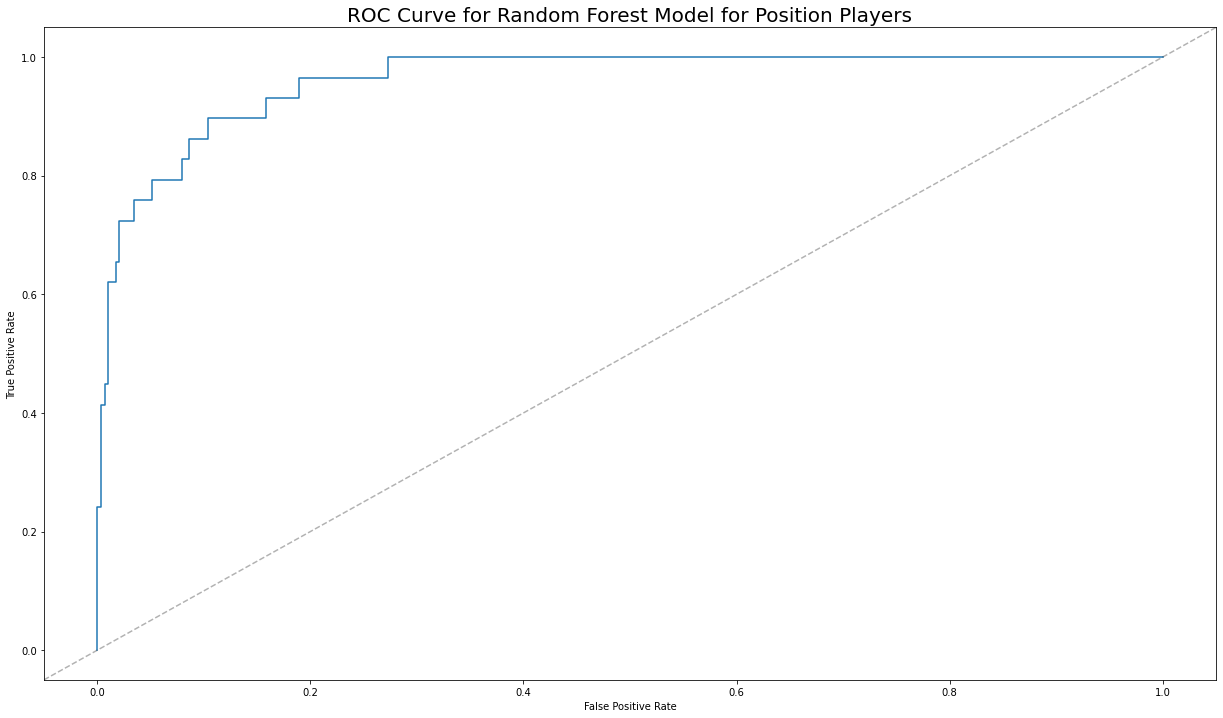

In [1324]:
fpr, tpr, thresholds = get_roc(best_rf_position, X_position_test, y_position_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Random Forest Model for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1325]:
feature_indexes = get_perm_importance(best_rf_position, X_position_test, y_position_test, position_df)

f1
RC             0.587 +/- 0.064
BA             0.072 +/- 0.024

balanced_accuracy
RC             0.279 +/- 0.031
BA             0.044 +/- 0.012



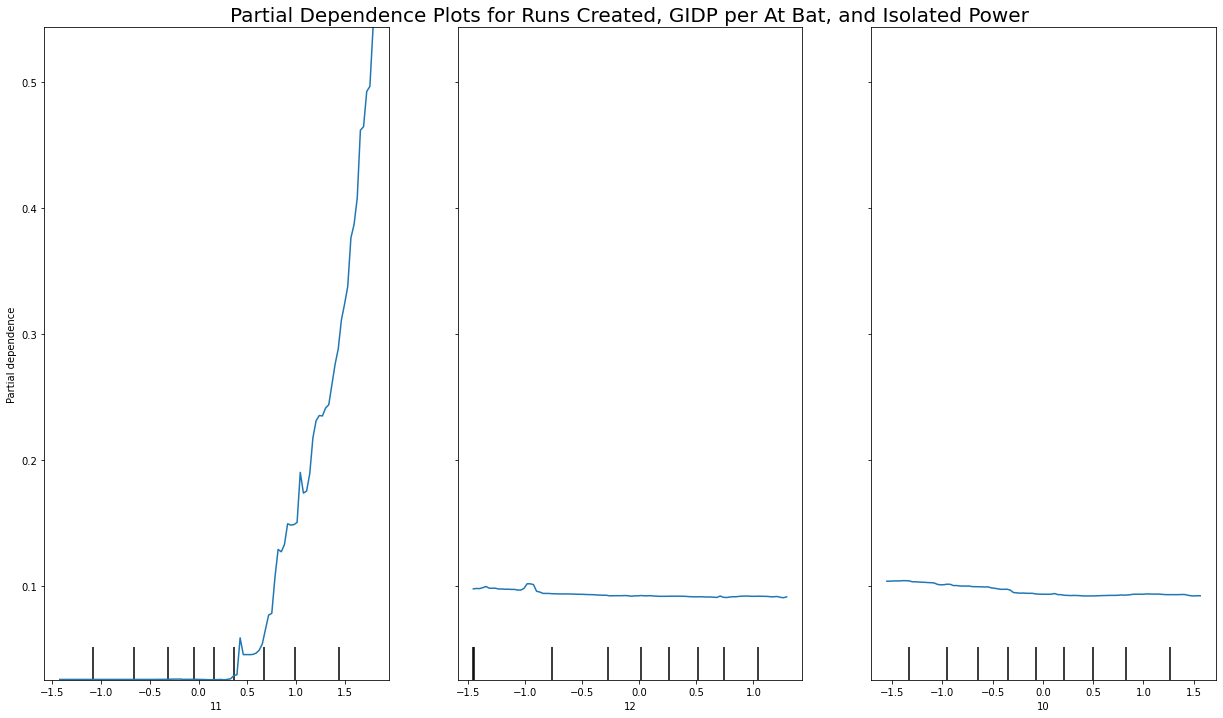

In [1326]:
show_partial_dependence(best_rf_position, X_position_train, feature_indexes, ['RC', 'GIDP_AB', 'ISO'], 'Partial Dependence Plots for Runs Created, GIDP per At Bat, and Isolated Power')

Text(0.5, 0, 'Importance')

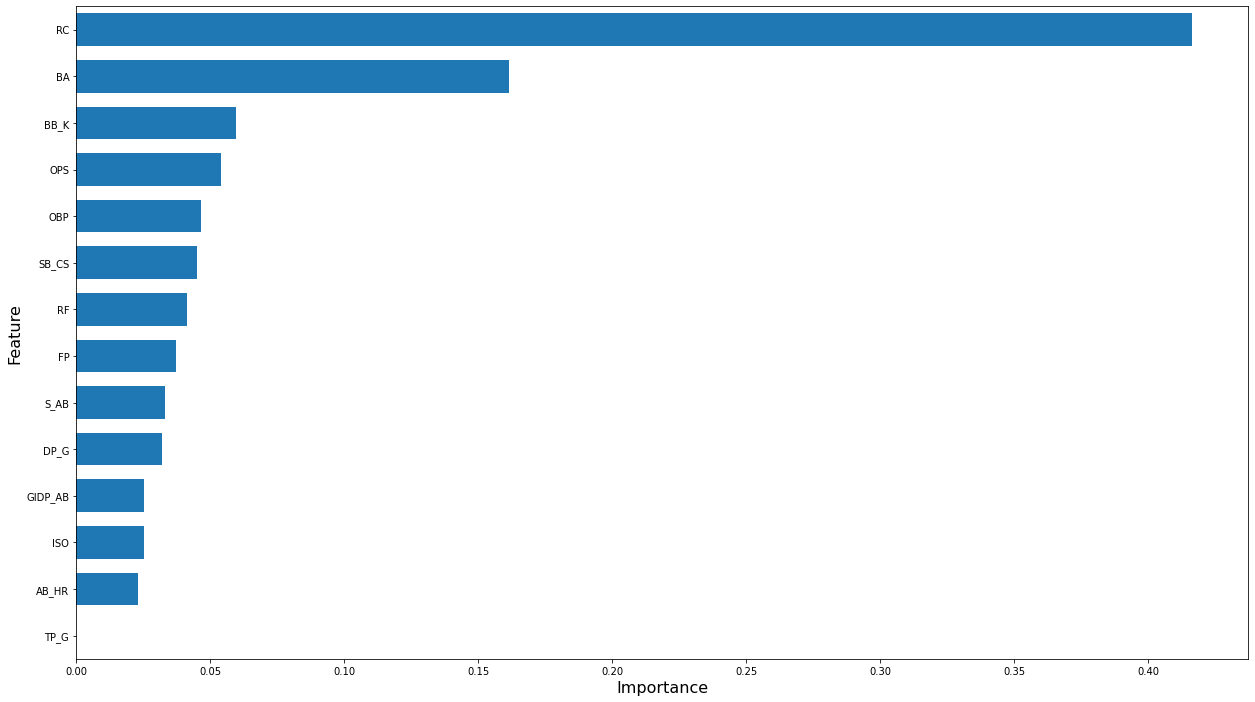

In [1327]:
tree_importance_sorted_idx = np.argsort(best_rf_position.feature_importances_)
tree_indices = np.arange(0, len(best_rf_position.feature_importances_)) + 0.5
column_names = position_df.drop(columns=['isHallOfFame', 'playerID']).columns

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
ax.barh(tree_indices, best_rf_position.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax.set_yticks(tree_indices)
ax.set_yticklabels(column_names[tree_importance_sorted_idx])
ax.set_ylim((0, len(best_rf_position.feature_importances_)))
ax.set_ylabel('Feature', fontsize=GLOBAL_LABEL_SIZE)
ax.set_xlabel('Importance', fontsize=GLOBAL_LABEL_SIZE)

## Catchers

### Logistic Regression

In [1328]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_clf.fit(X_catching_train, y_catching_train.ravel())

lr_results = lr_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lr_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lr_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lr_results['mean_test_%s' % scorer][best_index] ,
                                        lr_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lr_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1530 candidates, totalling 15300 fits
AUC
1.00000 (+/-0.000) for {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.30000000000000004, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

Accuracy
0.96892 (+/-0.017) for {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.8, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

Brier Loss
-0.01294 (+/-0.006) for {'C': 1.0, 'class_weight': None, 'l1_ratio': 1.0, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06}

F1 Score
0.70000 (+/-0.235) for {'C': 1.0, 'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

Kappa Score
0.69512 (+/-0.235) for {'C': 1.0, 'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

Logistic 

In [1330]:
best_lr_catching = LogisticRegression(C=1,
                                      class_weight=None,
                                      max_iter=10000,
                                      l1_ratio=.5,
                                      penalty='elasticnet',
                                      random_state=42,
                                      solver='saga',
                                      tol=.001)

best_lr_catching.fit(X_catching_train, y_catching_train.ravel())

LogisticRegression(C=1, l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.001)

In [1331]:
tn, fp, fn, tp = confusion_matrix(y_catching_test, best_lr_catching.predict(X_catching_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 1
True Positives:  1
False Positives: 1
True Negatives:  69

Sensitivity:     0.5
Specificity:     0.986

Precision:       0.5
Accuracy:        0.972

F1 Score:        0.5


0.03214657258042536


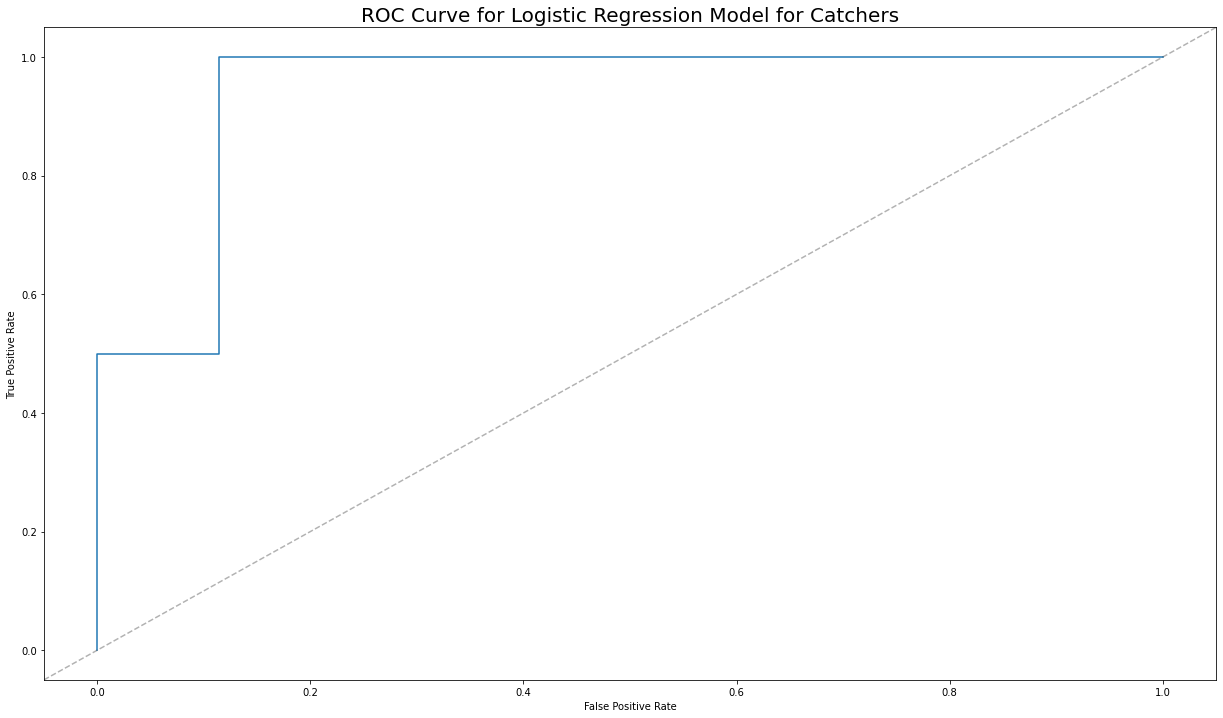

In [1332]:
fpr, tpr, thresholds = get_roc(best_lr_catching, X_catching_test, y_catching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Logistic Regression Model for Catchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1333]:
feature_indexes = get_perm_importance(best_lr_catching, X_catching_test, y_catching_test, catching_df)

f1
RC             0.489 +/- 0.083

balanced_accuracy
RC             0.240 +/- 0.033



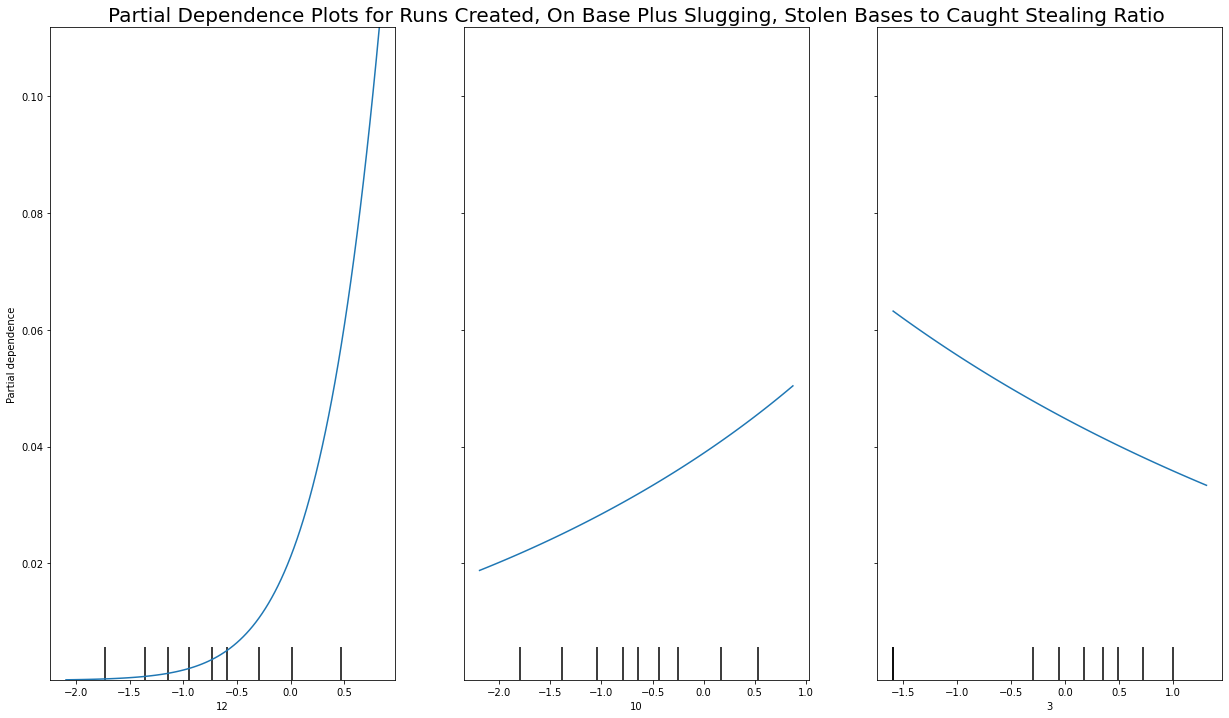

In [1334]:
show_partial_dependence(best_lr_catching, X_catching_train, feature_indexes, ['RC', 'OPS', 'SB_CS_catching'], 'Partial Dependence Plots for Runs Created, On Base Plus Slugging, Stolen Bases to Caught Stealing Ratio')

In [1335]:
show_lr_coefs(best_lr_catching, catching_df)

RC              2.779
BB_K            0.664
OPS             0.655
ISO             0.354
BA              0.302
OBP             0.252
PB_WP           0.076
S_AB            0.02
RF              0.0
DP_G            0.0
AB_HR           0.0
SB_CS_batting   0.0
GIDP_AB         0.0
FP              -0.09
SB_CS_catching  -0.544


### Linear Discriminant Analysis

In [1336]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lda_clf.fit(X_catching_train, y_catching_train.ravel())
    
lda_results = lda_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lda_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lda_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lda_results['mean_test_%s' % scorer][best_index] ,
                                        lda_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lda_results['params'][best_index]))
    print()

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
AUC
0.99259 (+/-0.009) for {'shrinkage': 0.30000000000000004, 'solver': 'lsqr', 'tol': 10.0}

Accuracy
0.89272 (+/-0.100) for {'shrinkage': 0.6000000000000001, 'solver': 'lsqr', 'tol': 10.0}

Brier Loss
-0.01568 (+/-0.008) for {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 10.0}

F1 Score
0.73333 (+/-0.241) for {'shrinkage': 0.30000000000000004, 'solver': 'lsqr', 'tol': 10.0}

Kappa Score
0.73006 (+/-0.241) for {'shrinkage': 0.30000000000000004, 'solver': 'lsqr', 'tol': 10.0}

Logistic Loss
-0.06814 (+/-0.038) for {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 10.0}

Sensitivity
0.80000 (+/-0.206) for {'shrinkage': 0.6000000000000001, 'solver': 'lsqr', 'tol': 10.0}



In [1338]:
best_lda_catching = LinearDiscriminantAnalysis(shrinkage=.3,
                                               solver='lsqr',
                                               tol=10)

best_lda_catching.fit(X_catching_train, y_catching_train.ravel())

LinearDiscriminantAnalysis(shrinkage=0.3, solver='lsqr', tol=10)

In [1339]:
tn, fp, fn, tp = confusion_matrix(y_catching_test, best_lda_catching.predict(X_catching_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 1
True Positives:  1
False Positives: 1
True Negatives:  69

Sensitivity:     0.5
Specificity:     0.986

Precision:       0.5
Accuracy:        0.972

F1 Score:        0.5


0.008452382329097627


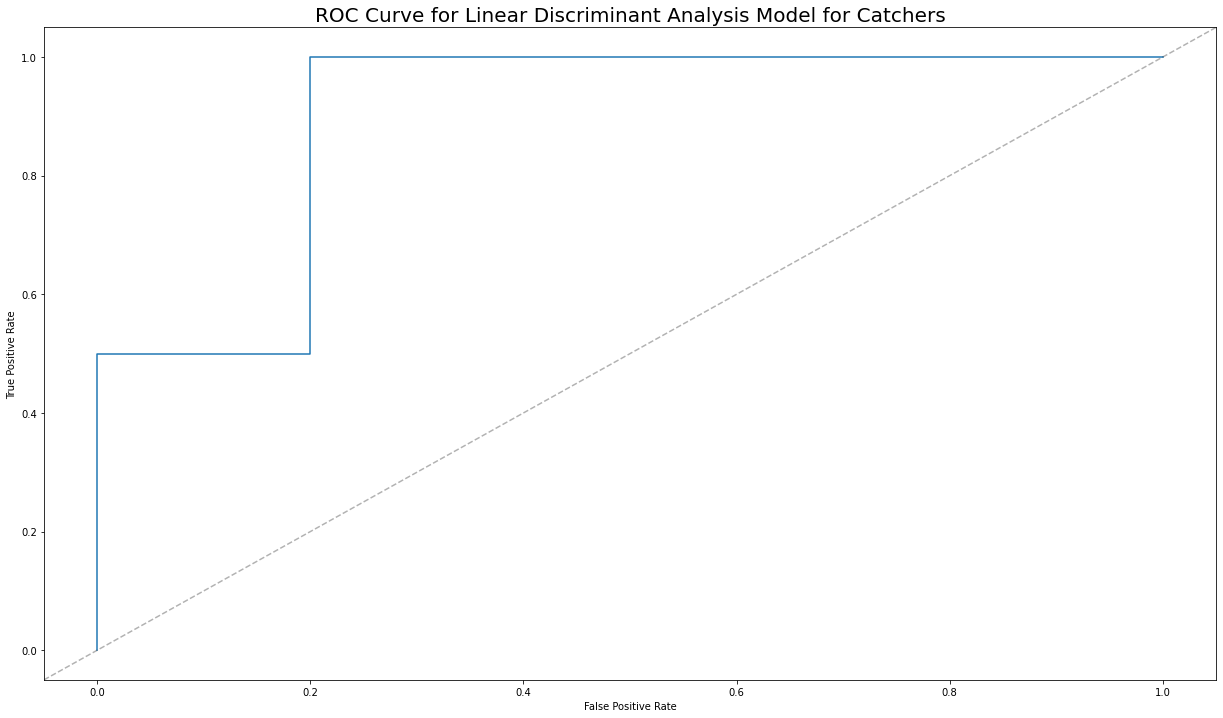

In [1340]:
fpr, tpr, thresholds = get_roc(best_lda_catching, X_catching_test, y_catching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Linear Discriminant Analysis Model for Catchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1341]:
feature_indexes = get_perm_importance(best_lda_catching, X_catching_test, y_catching_test, catching_df)

f1
RC             0.495 +/- 0.056

balanced_accuracy
RC             0.242 +/- 0.021



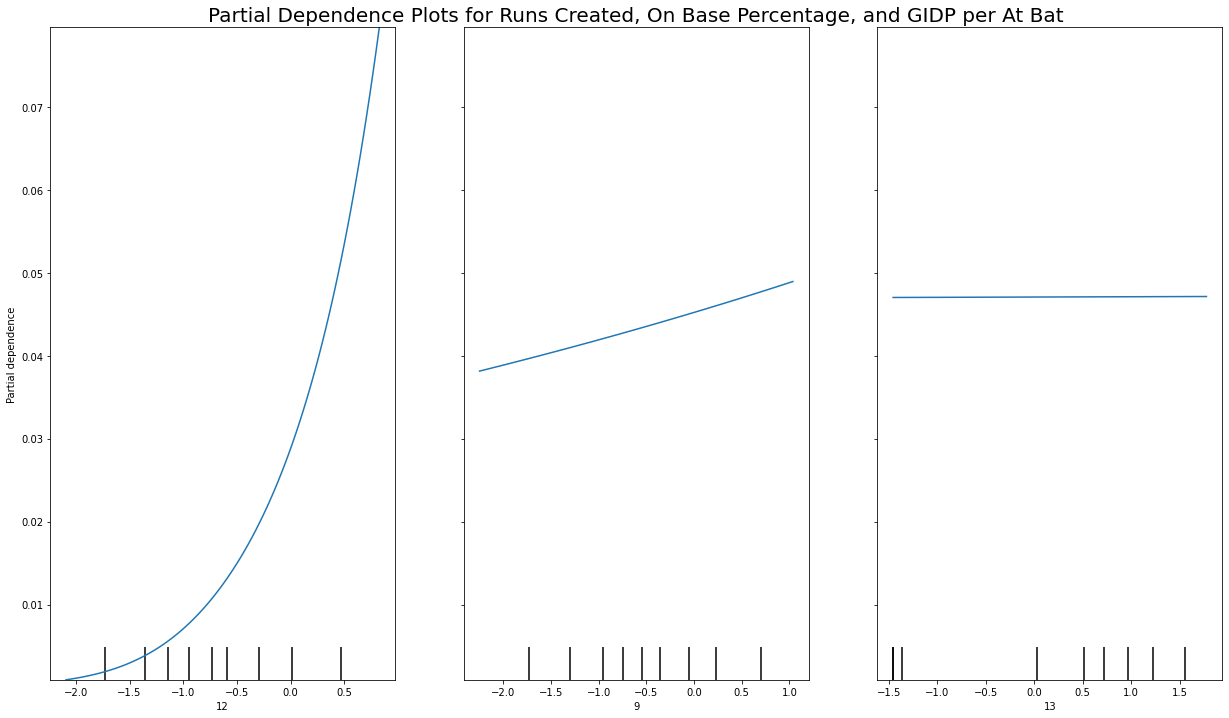

In [1342]:
show_partial_dependence(best_lda_catching, X_catching_train, feature_indexes, ['RC', 'OBP', 'GIDP_AB'], 'Partial Dependence Plots for Runs Created, On Base Percentage, and GIDP per At Bat')

### Random Forest

In [1343]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf_clf.fit(X_catching_train, y_catching_train.ravel())
    
rf_results = rf_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(rf_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = rf_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (rf_results['mean_test_%s' % scorer][best_index] ,
                                        rf_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        rf_results['params'][best_index]))
    print()

Fitting 10 folds for each of 722 candidates, totalling 7220 fits
AUC
0.99630 (+/-0.007) for {'max_depth': 1, 'max_features': 3, 'n_estimators': 500, 'random_state': 42}

Accuracy
0.81951 (+/-0.137) for {'max_depth': 2, 'max_features': 14, 'n_estimators': 500, 'random_state': 42}

Brier Loss
-0.01813 (+/-0.006) for {'max_depth': 6, 'max_features': 4, 'n_estimators': 500, 'random_state': 42}

F1 Score
0.60000 (+/-0.258) for {'max_depth': 2, 'max_features': 6, 'n_estimators': 1000, 'random_state': 42}

Kappa Score
0.59512 (+/-0.258) for {'max_depth': 2, 'max_features': 6, 'n_estimators': 1000, 'random_state': 42}

Logistic Loss
-0.05991 (+/-0.015) for {'max_depth': 6, 'max_features': 7, 'n_estimators': 500, 'random_state': 42}

Sensitivity
0.65000 (+/-0.279) for {'max_depth': 2, 'max_features': 14, 'n_estimators': 500, 'random_state': 42}



In [1345]:
best_rf_catching = RandomForestClassifier(n_estimators=1000,
                                          max_depth=2,
                                          max_features=6,
                                          random_state=42)

best_rf_catching.fit(X_catching_train, y_catching_train.ravel())

RandomForestClassifier(max_depth=2, max_features=6, n_estimators=1000,
                       random_state=42)

In [1346]:
tn, fp, fn, tp = confusion_matrix(y_catching_test, best_rf_catching.predict(X_catching_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 1
True Positives:  1
False Positives: 0
True Negatives:  70

Sensitivity:     0.5
Specificity:     1.0

Precision:       1.0
Accuracy:        0.986

F1 Score:        0.667


0.011398299655529874


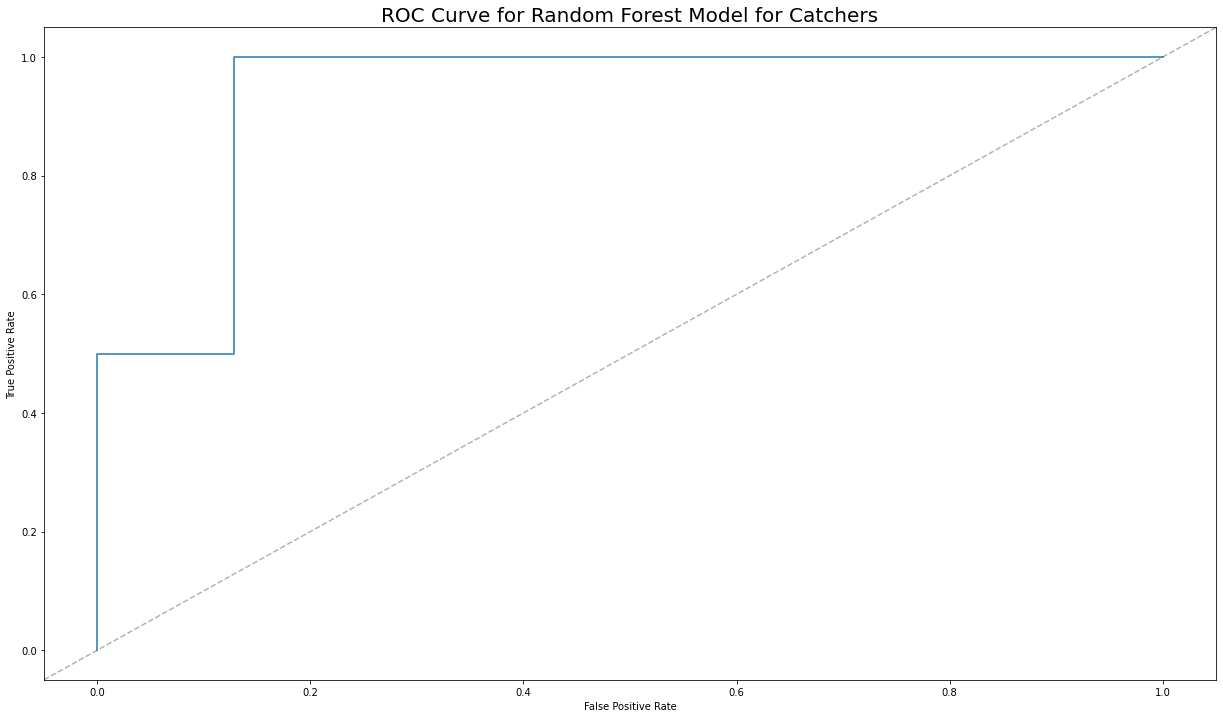

In [1347]:
fpr, tpr, thresholds = get_roc(best_rf_catching, X_catching_test, y_catching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Random Forest Model for Catchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1348]:
feature_indexes = get_perm_importance(best_rf_catching, X_catching_test, y_catching_test, catching_df)

f1
RC             0.655 +/- 0.086

balanced_accuracy
RC             0.249 +/- 0.033



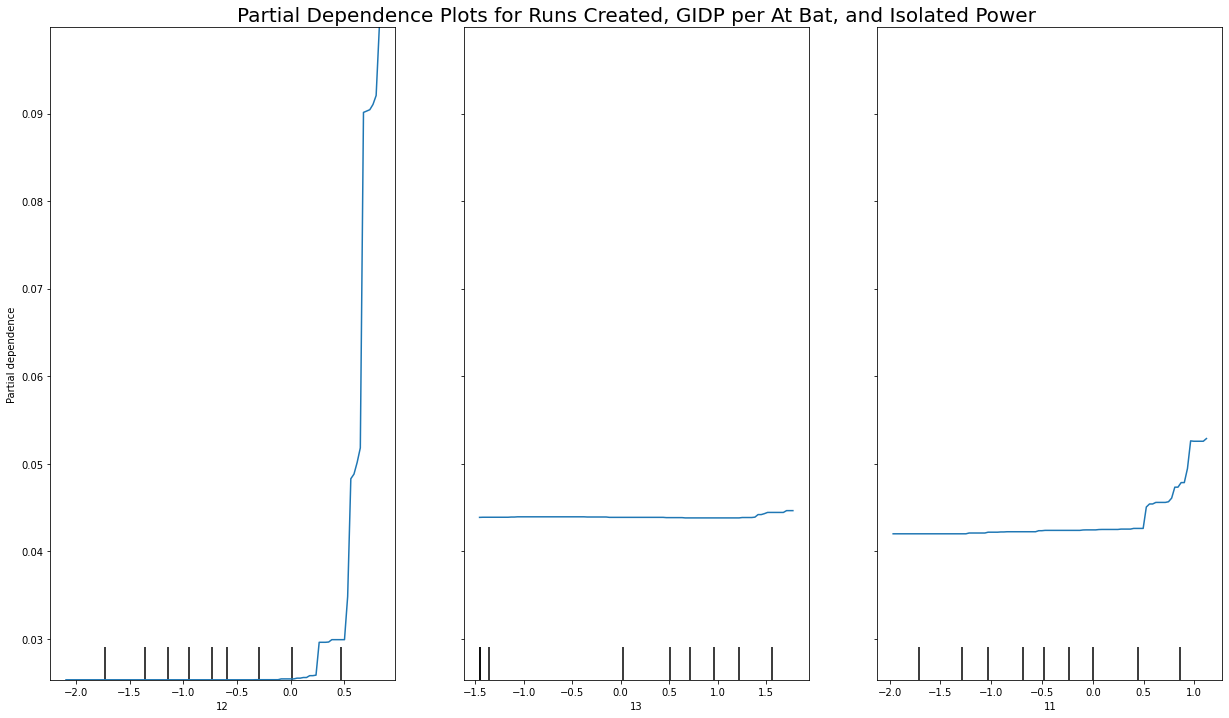

In [1349]:
show_partial_dependence(best_rf_catching, X_catching_train, feature_indexes, ['RC', 'GIDP_AB', 'ISO'], 'Partial Dependence Plots for Runs Created, GIDP per At Bat, and Isolated Power')

Text(0.5, 0, 'Importance')

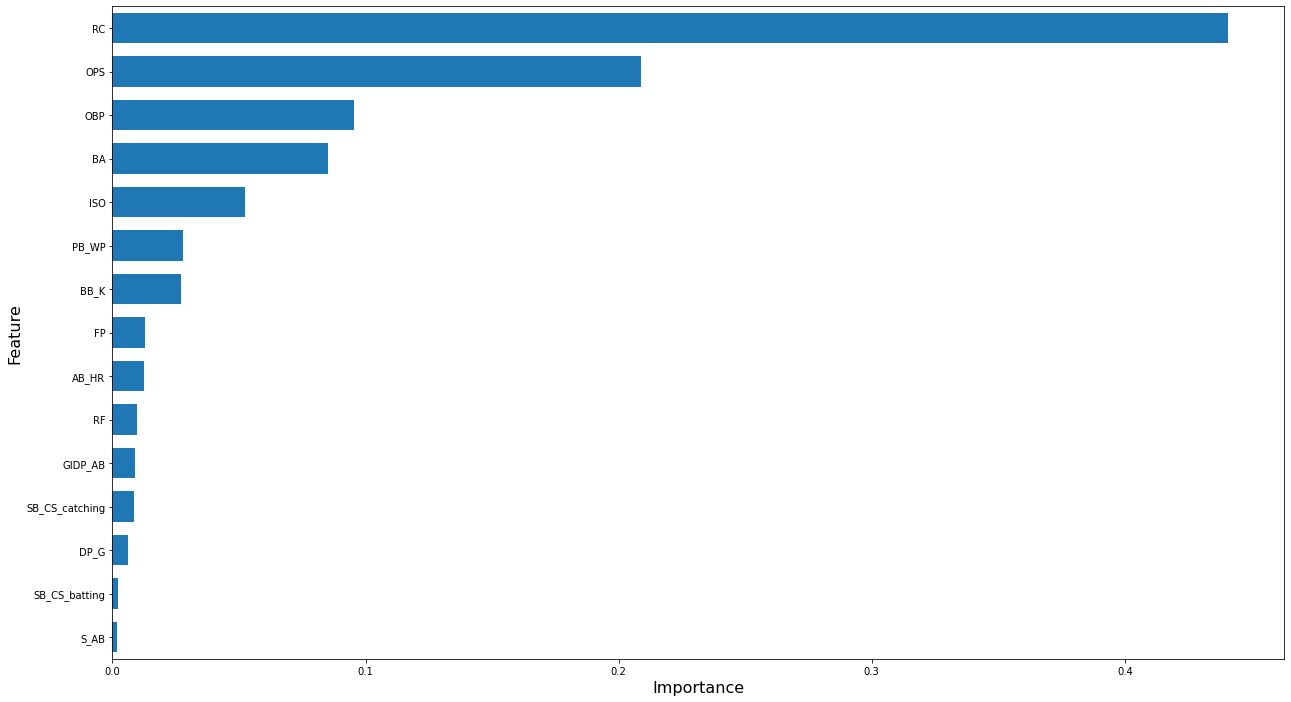

In [1350]:
tree_importance_sorted_idx = np.argsort(best_rf_catching.feature_importances_)
tree_indices = np.arange(0, len(best_rf_catching.feature_importances_)) + 0.5
column_names = catching_df.drop(columns=['isHallOfFame', 'playerID']).columns

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
ax.barh(tree_indices, best_rf_catching.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax.set_yticks(tree_indices)
ax.set_yticklabels(column_names[tree_importance_sorted_idx])
ax.set_ylim((0, len(best_rf_catching.feature_importances_)))
ax.set_ylabel('Feature', fontsize=GLOBAL_LABEL_SIZE)
ax.set_xlabel('Importance', fontsize=GLOBAL_LABEL_SIZE)

## Pitchers

### Logistic Regression

In [1351]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_clf.fit(X_pitching_train, y_pitching_train.ravel())

lr_results = lr_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lr_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lr_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lr_results['mean_test_%s' % scorer][best_index] ,
                                        lr_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lr_results['params'][best_index]))
    print()

Fitting 10 folds for each of 1530 candidates, totalling 15300 fits
AUC
0.93790 (+/-0.015) for {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.001}

Accuracy
0.87167 (+/-0.027) for {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.01}

Brier Loss
-0.04405 (+/-0.006) for {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.2, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01}

F1 Score
0.46348 (+/-0.168) for {'C': 1.0, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.001}

Kappa Score
0.44304 (+/-0.170) for {'C': 1.0, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.001}

Logistic Loss
-0.14873 (+/-0.017) for {'C': 0.1, 'class_weight': None, 'l1_ratio': 

In [1353]:
best_lr_pitching = LogisticRegression(C=1.0,
                                      class_weight=None,
                                      max_iter=10000,
                                      penalty='l1',
                                      random_state=42,
                                      solver='liblinear',
                                      tol=.001)

best_lr_pitching.fit(X_pitching_train, y_pitching_train.ravel())

LogisticRegression(max_iter=10000, penalty='l1', random_state=42,
                   solver='liblinear', tol=0.001)

In [1354]:
tn, fp, fn, tp = confusion_matrix(y_pitching_test, best_lr_pitching.predict(X_pitching_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 6
True Positives:  7
False Positives: 2
True Negatives:  219

Sensitivity:     0.538
Specificity:     0.991

Precision:       0.778
Accuracy:        0.966

F1 Score:        0.636


0.30521472726726473


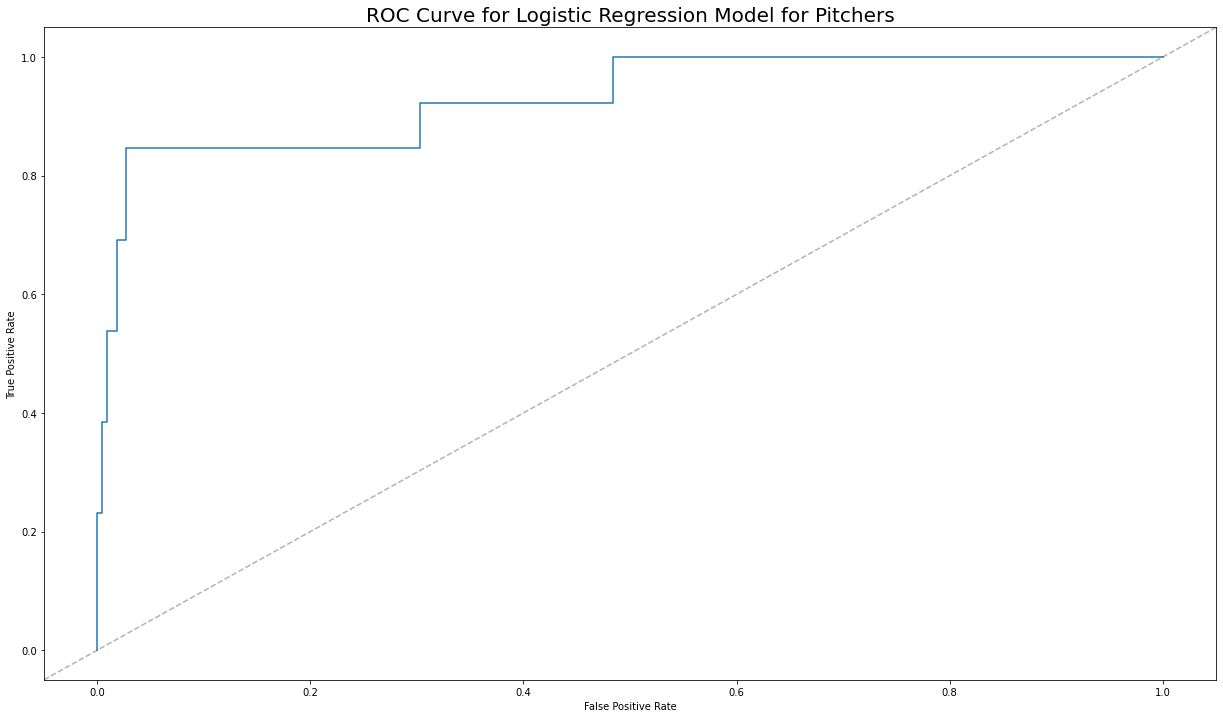

In [1355]:
fpr, tpr, thresholds = get_roc(best_lr_pitching, X_pitching_test, y_pitching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Logistic Regression Model for Pitchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1356]:
feature_indexes = get_perm_importance(best_lr_pitching, X_pitching_test, y_pitching_test, pitcher_df)

f1
WHIP           0.463 +/- 0.126
SHO_G          0.421 +/- 0.115
DICE           0.383 +/- 0.120
DP_G           0.191 +/- 0.075
BK_IP          0.146 +/- 0.079
GIDP_IP        0.127 +/- 0.075
HBP_IP         0.125 +/- 0.063
RF             0.087 +/- 0.052

balanced_accuracy
WHIP           0.214 +/- 0.040
SHO_G          0.197 +/- 0.042
DICE           0.188 +/- 0.041
DP_G           0.098 +/- 0.036
BK_IP          0.082 +/- 0.038
HBP_IP         0.073 +/- 0.032
GIDP_IP        0.071 +/- 0.037
RF             0.049 +/- 0.027



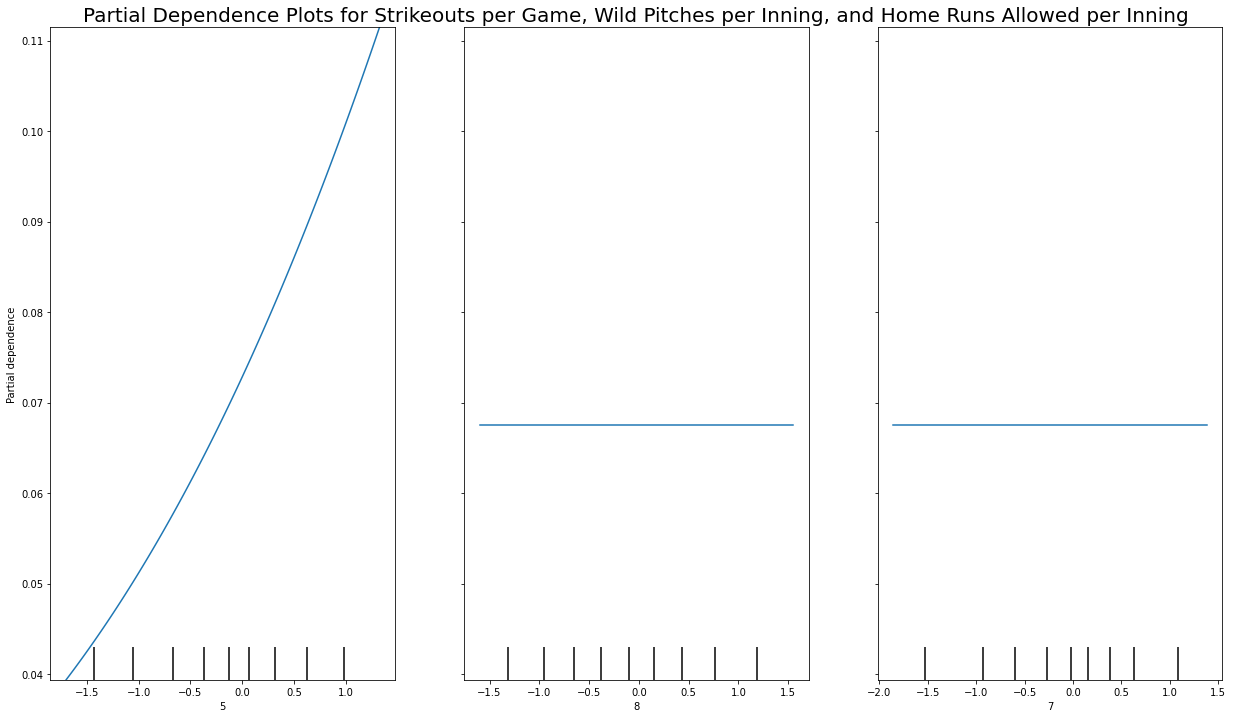

In [1357]:
show_partial_dependence(best_lr_pitching, X_pitching_train, feature_indexes, ['K_9', 'WP_IP', 'HR_IP'], 'Partial Dependence Plots for Strikeouts per Game, Wild Pitches per Inning, and Home Runs Allowed per Inning')

In [1358]:
show_lr_coefs(best_lr_pitching, pitcher_df)

SHO_G           0.796
ERA             0.721
K_9             0.551
DP_G            0.531
SV_G            0.236
RF              0.141
BB_9            0.0
HR_IP           0.0
WP_IP           0.0
BAOpp           -0.031
FP              -0.039
H_9             -0.202
HBP_IP          -0.205
BK_IP           -0.249
GIDP_IP         -0.25
DICE            -0.727
WHIP            -1.008


### Linear Discriminant Analysis

In [1359]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lda_clf.fit(X_pitching_train, y_pitching_train.ravel())
    
lda_results = lda_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(lda_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = lda_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (lda_results['mean_test_%s' % scorer][best_index] ,
                                        lda_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        lda_results['params'][best_index]))
    print()

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
AUC
0.93311 (+/-0.014) for {'shrinkage': 0.7000000000000001, 'solver': 'lsqr', 'tol': 10.0}

Accuracy
0.80575 (+/-0.042) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}

Brier Loss
-0.04639 (+/-0.008) for {'shrinkage': None, 'solver': 'svd', 'tol': 0.01}

F1 Score
0.47565 (+/-0.044) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}

Kappa Score
0.42628 (+/-0.048) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}

Logistic Loss
-0.15922 (+/-0.021) for {'shrinkage': 0.2, 'solver': 'lsqr', 'tol': 10.0}

Sensitivity
0.70000 (+/-0.092) for {'shrinkage': 1.0, 'solver': 'lsqr', 'tol': 10.0}



In [1361]:
best_lda_pitching = LinearDiscriminantAnalysis(shrinkage=1.0,
                                               solver='lsqr',
                                               tol=10)

best_lda_pitching.fit(X_pitching_train, y_pitching_train.ravel())

LinearDiscriminantAnalysis(shrinkage=1.0, solver='lsqr', tol=10)

In [1362]:
tn, fp, fn, tp = confusion_matrix(y_pitching_test, best_lda_pitching.predict(X_pitching_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 2
True Positives:  11
False Positives: 19
True Negatives:  202

Sensitivity:     0.846
Specificity:     0.914

Precision:       0.367
Accuracy:        0.91

F1 Score:        0.512


0.9219301186795766


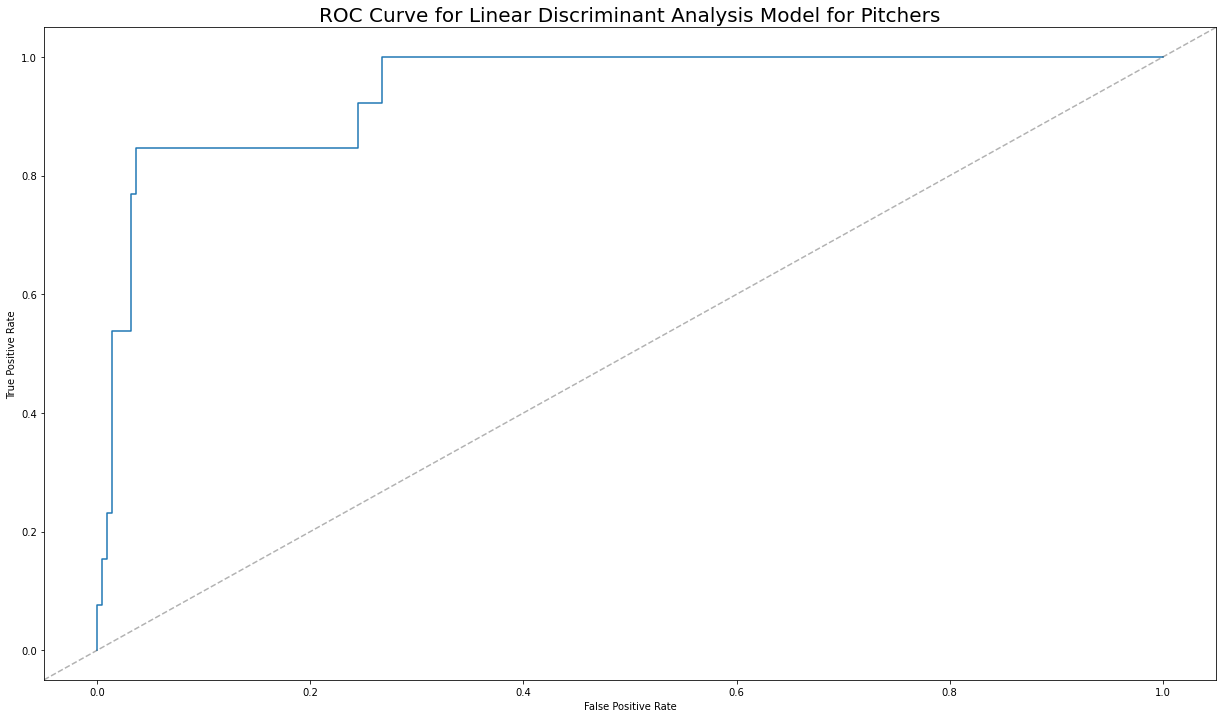

In [1363]:
fpr, tpr, thresholds = get_roc(best_lda_pitching, X_pitching_test, y_pitching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Linear Discriminant Analysis Model for Pitchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1364]:
feature_indexes = get_perm_importance(best_lda_pitching, X_pitching_test, y_pitching_test, pitcher_df)

f1
ERA            0.028 +/- 0.011
K_9            0.022 +/- 0.010

balanced_accuracy
ERA            0.006 +/- 0.002
K_9            0.004 +/- 0.002



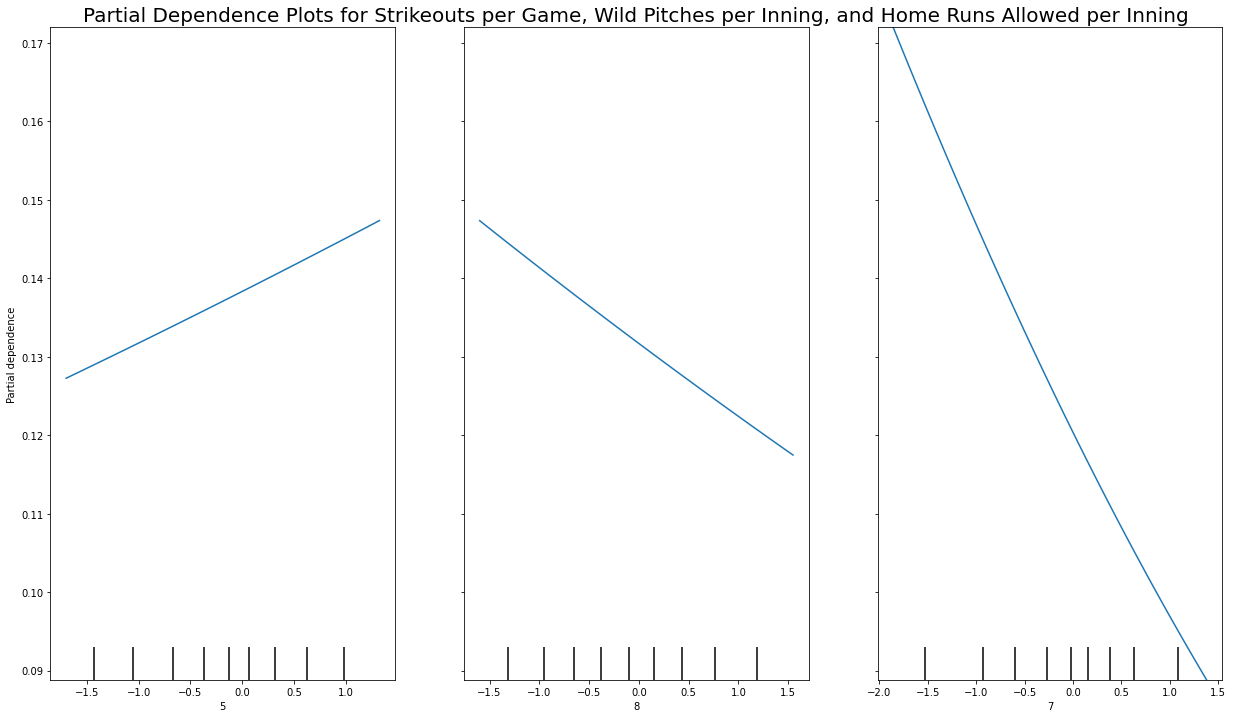

In [1365]:
show_partial_dependence(best_lda_pitching, X_pitching_train, feature_indexes, ['K_9', 'WP_IP', 'HR_IP'], 'Partial Dependence Plots for Strikeouts per Game, Wild Pitches per Inning, and Home Runs Allowed per Inning')

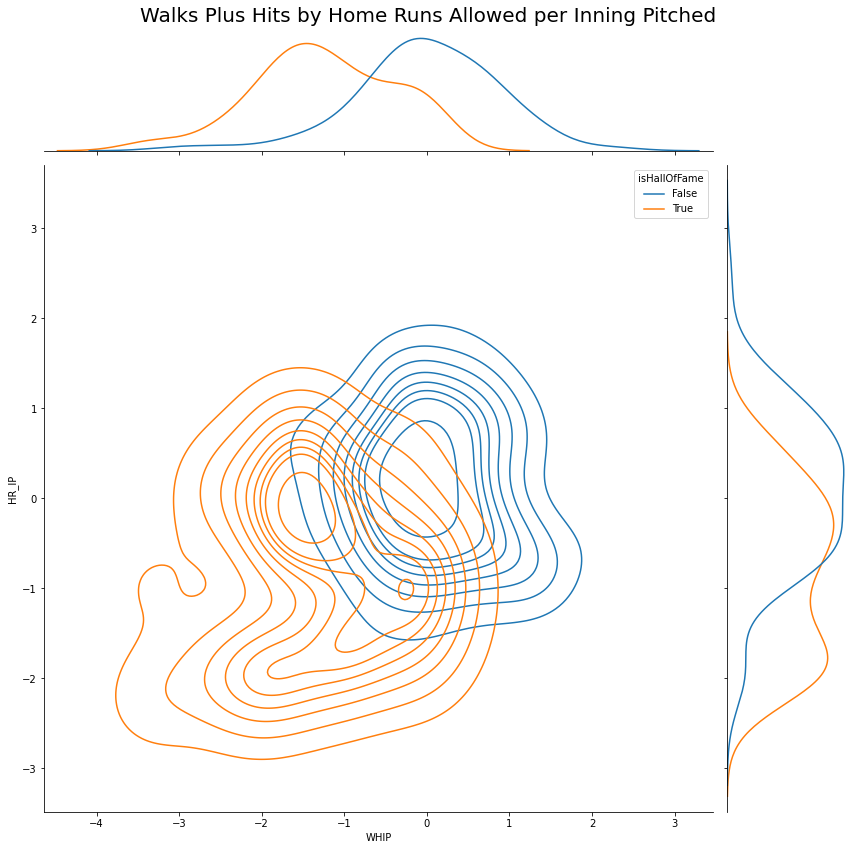

In [1366]:
pitching_df_box_cox_z['isHallOfFame'] = pitching_df['isHallOfFame']

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(pitching_df_box_cox_z.drop(columns=['isHallOfFame']), 
                                pitching_df_box_cox_z['isHallOfFame'])

p = sns.jointplot(x=X_res['WHIP'],
                  y=X_res['HR_IP'],
                  hue=y_res,
                  kind='kde',
                  height=12)

p.fig.suptitle('Walks Plus Hits by Home Runs Allowed per Inning Pitched', fontsize=GLOBAL_TITLE_SIZE)
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

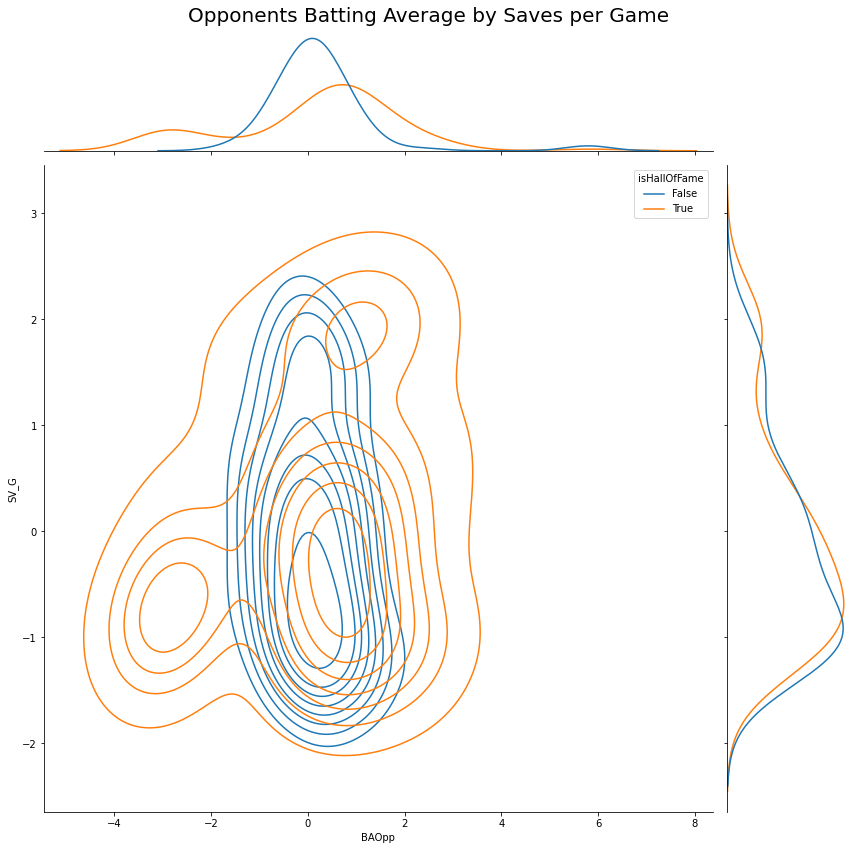

In [1367]:
p = sns.jointplot(x=X_res['BAOpp'],
                  y=X_res['SV_G'],
                  hue=y_res,
                  kind='kde',
                  height=12)

p.fig.suptitle('Opponents Batting Average by Saves per Game', fontsize=GLOBAL_TITLE_SIZE)
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

### Random Forest

In [1368]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rf_clf.fit(X_pitching_train, y_pitching_train.ravel())
    
rf_results = rf_clf.cv_results_
for scorer in sorted(scoring_metrics):
    best_index = np.nonzero(rf_results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = rf_results['mean_test_%s' % scorer][best_index]
    print(scorer)
    print('%0.5f (+/-%0.03f) for %r' % (rf_results['mean_test_%s' % scorer][best_index] ,
                                        rf_results['std_test_%s' % scorer][best_index] * 1.96 / math.sqrt(k),
                                        rf_results['params'][best_index]))
    print()

Fitting 10 folds for each of 722 candidates, totalling 7220 fits
AUC
0.95244 (+/-0.016) for {'max_depth': 10, 'max_features': 2, 'n_estimators': 500, 'random_state': 42}

Accuracy
0.69257 (+/-0.059) for {'max_depth': 9, 'max_features': 17, 'n_estimators': 500, 'random_state': 42}

Brier Loss
-0.04060 (+/-0.005) for {'max_depth': 9, 'max_features': 2, 'n_estimators': 500, 'random_state': 42}

F1 Score
0.47937 (+/-0.126) for {'max_depth': 6, 'max_features': 13, 'n_estimators': 500, 'random_state': 42}

Kappa Score
0.45618 (+/-0.130) for {'max_depth': 6, 'max_features': 13, 'n_estimators': 500, 'random_state': 42}

Logistic Loss
-0.13488 (+/-0.014) for {'max_depth': 11, 'max_features': 8, 'n_estimators': 500, 'random_state': 42}

Sensitivity
0.40238 (+/-0.122) for {'max_depth': 9, 'max_features': 17, 'n_estimators': 500, 'random_state': 42}



In [1370]:
best_rf_pitching = RandomForestClassifier(n_estimators=500,
                                          max_depth=6,
                                          max_features=13,
                                          random_state=42)

best_rf_pitching.fit(X_pitching_train, y_pitching_train.ravel())

RandomForestClassifier(max_depth=6, max_features=13, n_estimators=500,
                       random_state=42)

In [1371]:
tn, fp, fn, tp = confusion_matrix(y_pitching_test, best_rf_pitching.predict(X_pitching_test)).ravel()
print_confusion_matrix_details(tn, fp, fn, tp)

False Negatives: 9
True Positives:  4
False Positives: 3
True Negatives:  218

Sensitivity:     0.308
Specificity:     0.986

Precision:       0.571
Accuracy:        0.949

F1 Score:        0.4


0.03802161282738677


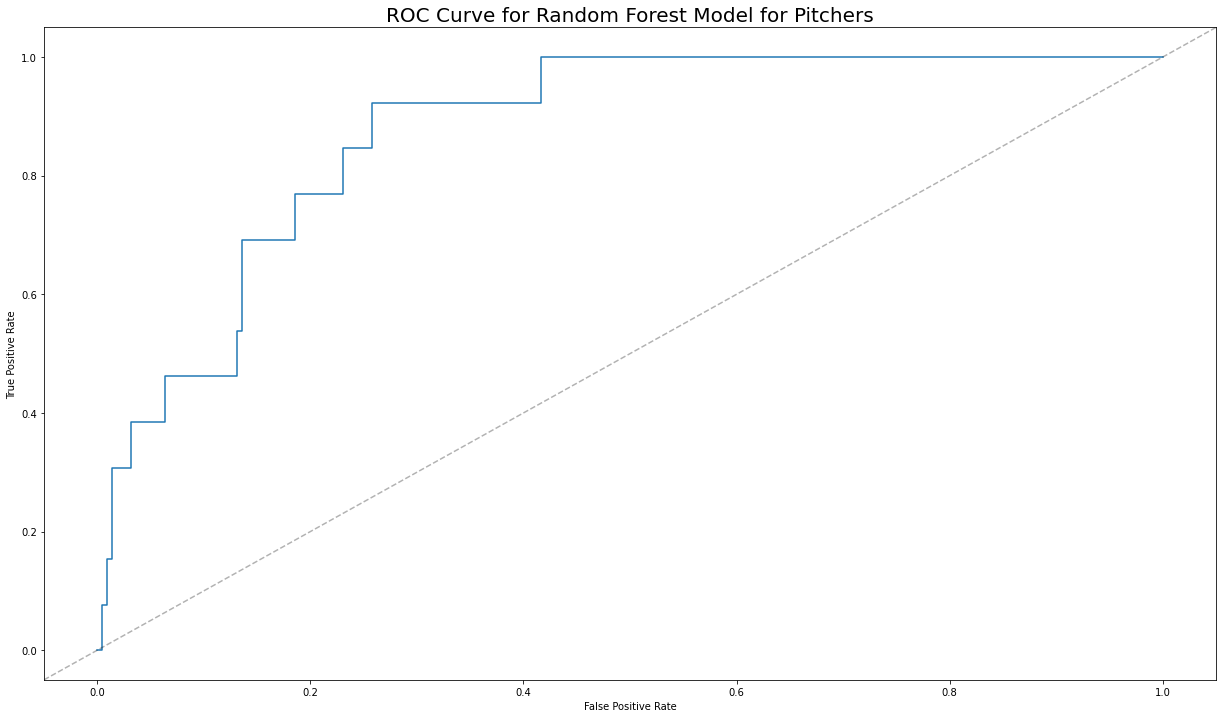

In [1372]:
fpr, tpr, thresholds = get_roc(best_rf_pitching, X_pitching_test, y_pitching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Random Forest Model for Pitchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1373]:
feature_indexes = get_perm_importance(best_rf_pitching, X_pitching_test, y_pitching_test, pitcher_df)

f1
WHIP           0.342 +/- 0.071
DP_G           0.128 +/- 0.066
SHO_G          0.101 +/- 0.016
BAOpp          0.077 +/- 0.029
BB_9           0.064 +/- 0.036

balanced_accuracy
WHIP           0.138 +/- 0.029
DP_G           0.050 +/- 0.030
SHO_G          0.041 +/- 0.004
BAOpp          0.036 +/- 0.011
BB_9           0.029 +/- 0.016



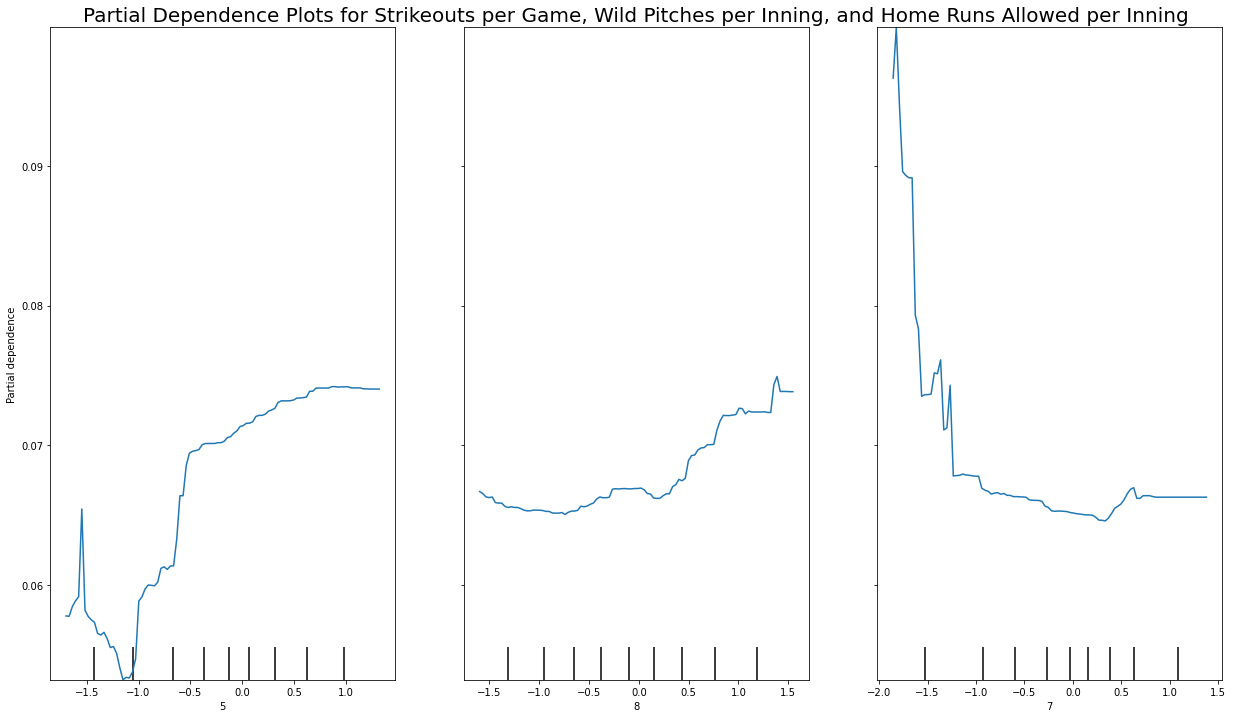

In [1374]:
show_partial_dependence(best_rf_pitching, X_pitching_train, feature_indexes, ['K_9', 'WP_IP', 'HR_IP'], 'Partial Dependence Plots for Strikeouts per Game, Wild Pitches per Inning, and Home Runs Allowed per Inning')

Text(0.5, 0, 'Importance')

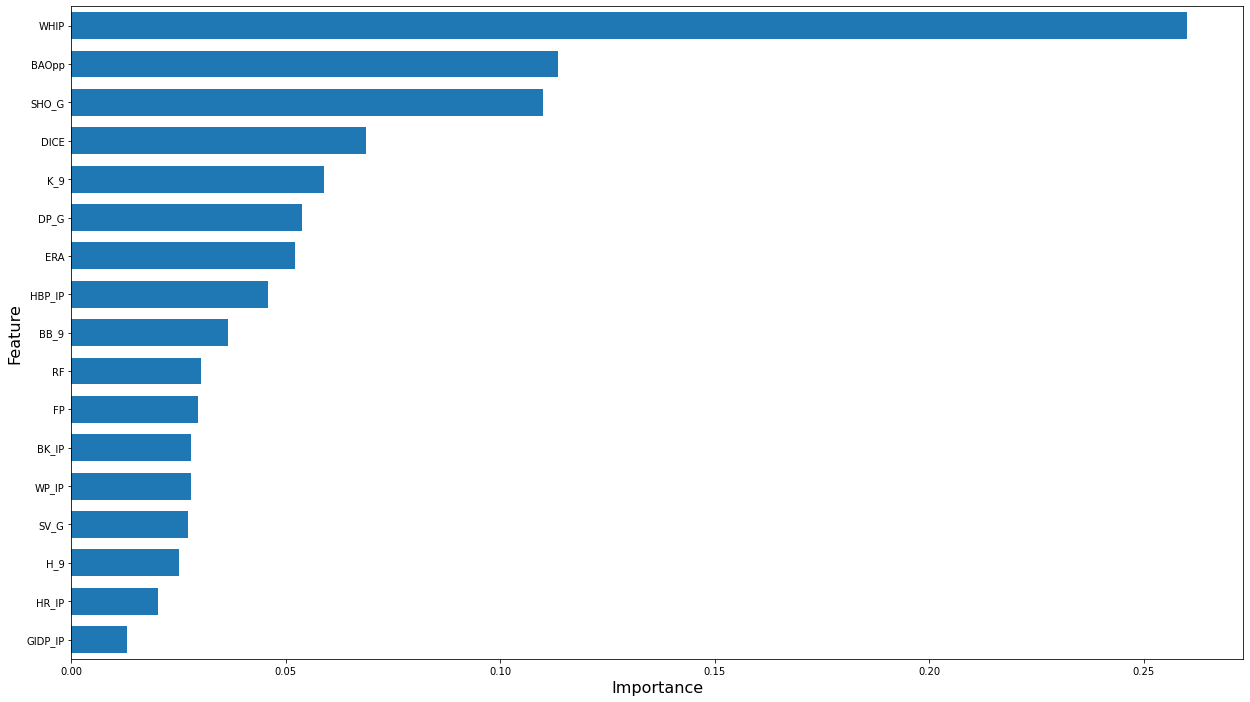

In [1375]:
tree_importance_sorted_idx = np.argsort(best_rf_pitching.feature_importances_)
tree_indices = np.arange(0, len(best_rf_pitching.feature_importances_)) + 0.5
column_names = pitcher_df.drop(columns=['isHallOfFame', 'playerID']).columns

f, ax = plt.subplots(figsize=GLOBAL_FIG_SIZE)
ax.barh(tree_indices, best_rf_pitching.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax.set_yticks(tree_indices)
ax.set_yticklabels(column_names[tree_importance_sorted_idx])
ax.set_ylim((0, len(best_rf_pitching.feature_importances_)))
ax.set_ylabel('Feature', fontsize=GLOBAL_LABEL_SIZE)
ax.set_xlabel('Importance', fontsize=GLOBAL_LABEL_SIZE)

## Results

These are multiple techniques that give us insight into what baseball statistics are more important in terms of making it into the Hall of Fame.  It's important to note that each model values somewhat different stats and how much value is place on each stat varies. Additionally, it's worth noting that misuse of the data, highly correlated features for example, can cause misleading results here.

However, there are some common themes amongst these models and these techniques:

For position players, all models and all techniques showed that **runs created** followed by **batting average** were the two most important stats.  Various other stats were also considered to be important depending on the model and technique, but **isolated power, on-base plus slugging and walk to strikeout ratio** were common stats that were also highly valued.

For catchers, **runs created** was once again the most important stat according to all models and all techniques, with **isolated power, on-base plus slugging and walk to strikeout ratio** once again being shown as important.

For pitchers, all models and all techniques showed that **walks plus hits per inning pitched** was the most important stat.  **Home runs allowed per inning pitched, average shutouts per game, strikeouts per nine innings pitched, and earned run average** were also commonly present amongst the most important stats.

# Analysis

We will now take the models that we have created in the previous section and use them to evaluate some select players, as well as, determine who might be a good candidate for the Hall of Fame in the future.

## Voting Classifier

We can take these individual classifiers and combine them into one "voting classifier" where each individual model makes a prediction and then their predictions are combined to form a final prediction.

In [1634]:
y_position_holdout = position_df_holdout['isHallOfFame'].values
X_position_holdout = position_df_holdout.drop(columns=['isHallOfFame', 'playerID']).values

estimator_names = ['LR', 'LDA', 'RF']
# Thresholds from best threshold from ROC curves in 8.1
thresholds = [.0872, .1312, .1169]

voting_clf_position = VotingClassifier(estimators=list(zip(estimator_names,
                                                           [best_lr_position, 
                                                            best_lda_position,
                                                            best_rf_position])),
                                       voting='soft',
                                       flatten_transform=False)
voting_clf_position.fit(X_position_train, y_position_train.ravel())

voting_transform = voting_clf_position.transform(X_position_holdout)
voting_probs = voting_clf_position.predict_proba(X_position_holdout)

### Holdouts

Here we are using the logistic regression, linear discriminant analysis, and random forest classifiers to make our predictions on 7 players that we have held out.  Barry Bonds, Derek Jeter, Mark McGwire, Rafael Palmeiro, Pete Rose, Babe Ruth and Ichiro Suzuki were all chosen for specific reasons.

- Babe Ruth is one of the most famous baseball players of all time and one of the first 5 members ever inducted. 
- Barry Bonds, Mark McGwire, Rafael Palmeiro, and Pete Rose are somewhat controversial players. Despite having exceptional batting records, none of these players were admitted to the Hall of Fame; largely due to steroid usage.
- Derek Jeter and Ichiro Suzuki have seemingly similar stats, though Jeter is currently a member while Suzuki is not.

We can first look at the batting stats for all of these players

In [125]:
# pd.set_option("display.max_columns", None)
batting_df.loc[batting_df['playerID'].isin(holdout_players)]

playerID     G     AB  ...   GIDP_AB      S_AB  isHallOfFame
1643   bondsba01  3034   9998  ...  0.016603  0.009902         False
8814   jeterde01  2905  11845  ...  0.025412  0.014183          True
11709  mcgwima01  1916   6316  ...  0.023908  0.013141         False
13629  palmera01  2853  10554  ...  0.022077  0.012791         False
15474   rosepe01  3629  14321  ...  0.017457  0.009566         False
15624   ruthba01  2544   8527  ...  0.000586  0.013604          True
17523  suzukic01  2672  10012  ...  0.009189  0.009888         False

[7 rows x 38 columns]

Comparing Jeter and Suzuki (second and seventh rows) based off their raw numbers, both players had a similar number of games and, therefore, at bats, a similar number of hits, OBP and OPS.  Notable differences are that Jeter has almost twice as many home runs, but also almost twice as many strikeouts.   Using the raw numbers for comparison can be misleading though, since we don't always know what an average value looks like or how spread out the values are.  For example, are Jeter's isolated power of .13 and Suzuki's isolated power of .09 close? Are those good numbers compared to the rest of the players?

In [126]:
batting_df_analysis = batting_df.drop(columns=['playerID', 'isHallOfFame'])
batting_df_analysis = batting_df_analysis.apply(lambda c: stats.zscore(c))
batting_df_analysis['playerID'] = batting_df['playerID']
batting_df_analysis.loc[batting_df_analysis['playerID'].isin(holdout_players)]

G        AB         R  ...   GIDP_AB      S_AB   playerID
1643   2.991731  2.477863  4.239347  ... -0.035495 -0.729455  bondsba01
8814   2.774833  3.274936  3.662805  ...  0.751326 -0.293515  jeterde01
11709  1.111946  0.888895  1.484192  ...  0.616975 -0.399615  mcgwima01
13629  2.687401  2.717805  2.749522  ...  0.453451 -0.435241  palmera01
15474  3.992153  4.343455  4.073527  ...  0.040752 -0.763629   rosepe01
15624  2.167854  1.843053  4.114345  ... -1.466254 -0.352508   ruthba01
17523  2.383071  2.483905  2.121959  ... -0.697803 -0.730865  suzukic01

[7 rows x 37 columns]

Taking the Z score of each column will center and scale all the baseball stats so that 0 is always average, and about 95% of the values will be between -2 and 2.  Though its no longer in the true units, this makes it a little easier to tell how players compare to each other.  We can now see that Jeter and Suzuki's on base percentage aren't actually as close as they originally appeared.  We can also see that all 7 players are above average in most categories.

In [129]:
# pd.set_option("display.max_columns", 6)
position_df_holdout

FP        RF      DP_G  ...   GIDP_AB      S_AB  isHallOfFame
157   0.641002 -0.541661 -1.222568  ... -0.101848 -0.733948             0
881   0.109648  0.006557  1.067651  ...  0.730864 -0.177611             1
1146  1.527771  0.616212  1.603940  ...  0.582511 -0.306058             0
1331  1.666623  0.581974  1.555367  ...  0.405439 -0.350159             0
1492  0.938998  0.125706  0.354702  ... -0.024878 -0.780882             0
1504 -0.406653  1.671428 -1.034737  ... -1.410619 -0.248500             1
1680  1.505353 -0.480204 -1.199511  ... -0.738732 -0.735874             0

[7 rows x 16 columns]

Now let's take a look at the Z scores for these players, but only look at the metrics that are being used in our model. 

In [1638]:
for index, clf in enumerate(zip(estimator_names, thresholds)):
    estimator, threshold = clf
    print(estimator)
    probs = [prob[1] for prob in voting_transform[index]]
    predictions = [prob >= threshold for prob in probs]
    zipped = list(zip(holdout_players, probs, predictions))
    for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True):
        player_name = id_to_name_dict.get(player)
        print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
    print()

LR
Babe Ruth            0.999 True
Barry Bonds          0.987 True
Pete Rose            0.972 True
Derek Jeter          0.951 True
Rafael Palmeiro      0.926 True
Ichiro Suzuki        0.263 True
Mark McGwire         0.130 True

LDA
Babe Ruth            1.000 True
Barry Bonds          0.999 True
Rafael Palmeiro      0.869 True
Pete Rose            0.773 True
Derek Jeter          0.758 True
Mark McGwire         0.750 True
Ichiro Suzuki        0.185 True

RF
Babe Ruth            0.894 True
Derek Jeter          0.862 True
Pete Rose            0.788 True
Rafael Palmeiro      0.641 True
Ichiro Suzuki        0.636 True
Barry Bonds          0.630 True
Mark McGwire         0.238 True



0.15114932361925495


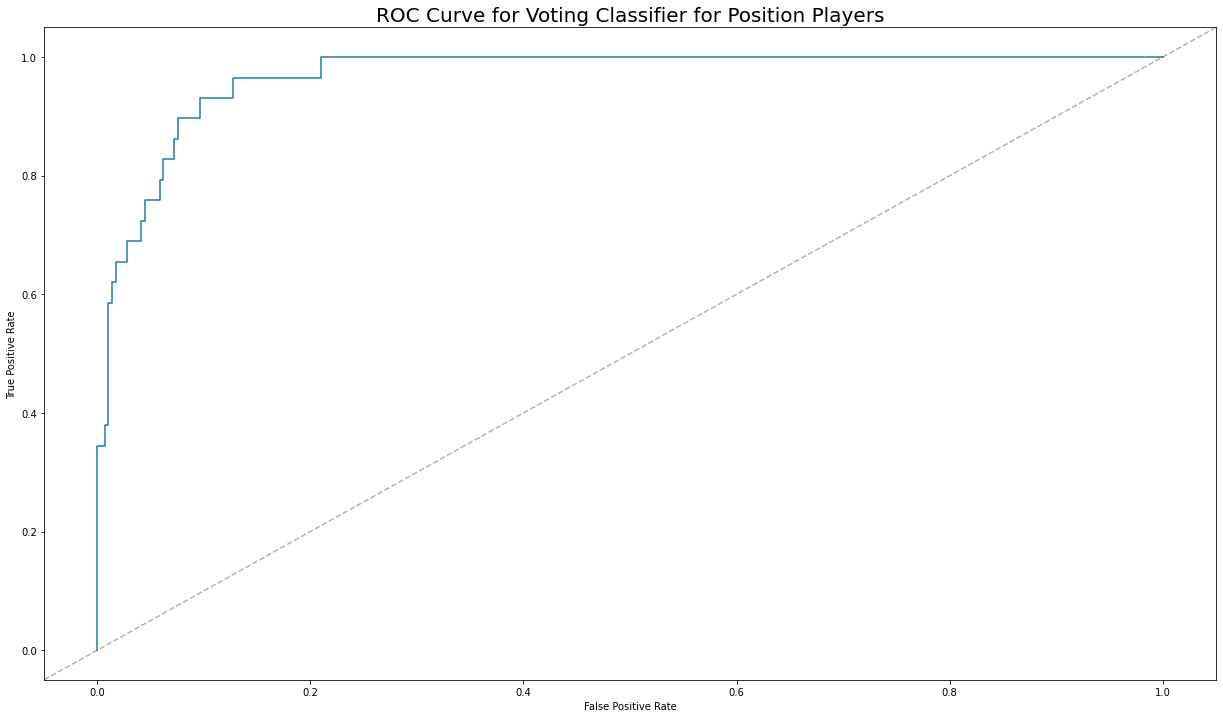

In [1639]:
fpr, tpr, thresholds = get_roc(voting_clf_position, X_position_test, y_position_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Voting Classifier for Position Players')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1640]:
probs = [prob[1] for prob in voting_probs]
predictions = [prob >= best_threshold for prob in probs]
zipped = list(zip(holdout_players, probs, predictions))
for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True):
    player_name = id_to_name_dict.get(player)
    print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
print()

Babe Ruth            0.964 True
Barry Bonds          0.872 True
Derek Jeter          0.857 True
Pete Rose            0.844 True
Rafael Palmeiro      0.812 True
Mark McGwire         0.373 True
Ichiro Suzuki        0.362 True



According to the voting classifier (and all three models within it) all seven of these players should be members of the Hall of Fame.  Though it is worth pointing out that the LDA model has far less confidence in Ichiro Suzuki than the other 6, the random forest model has far less confidence in Mark McGwire than the others, and the logistic regression model has far less confidence in both of them.

### Active Position Players

Next we will take a look at players that are still considered active and see which ones these models determine as likely candidates for the Hall of Fame.

In [1641]:
active_player_ids = active_position_df['playerID']

y_position_active = active_position_df['isHallOfFame'].values
X_position_active = active_position_df.drop(columns=['isHallOfFame', 'playerID']).values

Here is the list of most likely candidates for the Hall of Fame amongst position players, sorted from most likely to least, per the voting classifier.

In [1642]:
voting_probs = voting_clf_position.predict_proba(X_position_active)

probs = [prob[1] for prob in voting_probs]
predictions = [prob >= best_threshold for prob in probs]
zipped = list(zip(active_player_ids, probs, predictions))
for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True)[:22]:
    player_name = id_to_name_dict.get(player)
    print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
print()
for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True)[22:27]:
    player_name = id_to_name_dict.get(player)
    print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
print()

Albert Pujols        0.918 True
Alex Rodriguez       0.882 True
Miguel Cabrera       0.874 True
David Ortiz          0.757 True
Adrian Beltre        0.617 True
Carlos Beltran       0.518 True
Joey Votto           0.505 True
Mike Trout           0.404 True
Robinson Cano        0.393 True
Ichiro Suzuki        0.362 True
Paul Goldschmidt     0.271 True
Joe Mauer            0.239 True
Aramis Ramirez       0.224 True
Matt Holliday        0.222 True
Mark Teixeira        0.201 True
Freddie Freeman      0.200 True
Jimmy Rollins        0.198 True
David Wright         0.179 True
Ryan Braun           0.172 True
Chase Utley          0.164 True
Jose Altuve          0.161 True
Hanley Ramirez       0.152 True

Prince Fielder       0.145 False
Edwin Encarnacion    0.132 False
Jose Reyes           0.132 False
Mookie Betts         0.128 False
Adrian Gonzalez      0.109 False



Based on the output above, there are 22 position players who would make a good candidate for the Hall of Fame according to the voting classifier.  The next 5 best candidates are listed as well.

Fun Fact: There are only 7 players to ever record at least 3,000 hits and 500 homeruns in their career.

Three of them are current Hall of Famers:
- Hank Aaron
- Willie Mays
- Eddie Murray

One of them tested positive for steroid use:
- Rafael Palmeiro

And the other three are at the top of this list:
- Albert Pujols   (1st)
- Alex Rodriguez  (2nd)
- Miguel Cabrera  (3rd)

While David Ortiz (4th) failed to achieve this mark, recording only 2,472 hits, he was the only player to make it into the Hall of Fame on the most recent ballot.  While this is not an objective metric that this model is performing well, it does align with what we might have expected to see.

### Active Catchers

We will repeat this process for catchers.

In [1643]:
active_player_ids = active_catching_df['playerID']

y_catching_active = active_catching_df['isHallOfFame'].values
X_catching_active = active_catching_df.drop(columns=['isHallOfFame', 'playerID']).values

estimator_names = ['LR', 'LDA', 'RF']
voting_clf_catching = VotingClassifier(estimators=list(zip(estimator_names,
                                                           [best_lr_catching, 
                                                            best_lda_catching,
                                                            best_rf_catching])),
                                       voting='soft',
                                       flatten_transform=False)
voting_clf_catching.fit(X_catching_train, y_catching_train.ravel())

VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=1, l1_ratio=0.5,
                                                 max_iter=10000,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.001)),
                             ('LDA',
                              LinearDiscriminantAnalysis(shrinkage=0.3,
                                                         solver='lsqr',
                                                         tol=10)),
                             ('RF',
                              RandomForestClassifier(max_depth=2,
                                                     max_features=6,
                                                     n_estimators=1000,
                                                     random_state=42))],
                 flatten_transform=False, voting='sof

0.01733241818835095


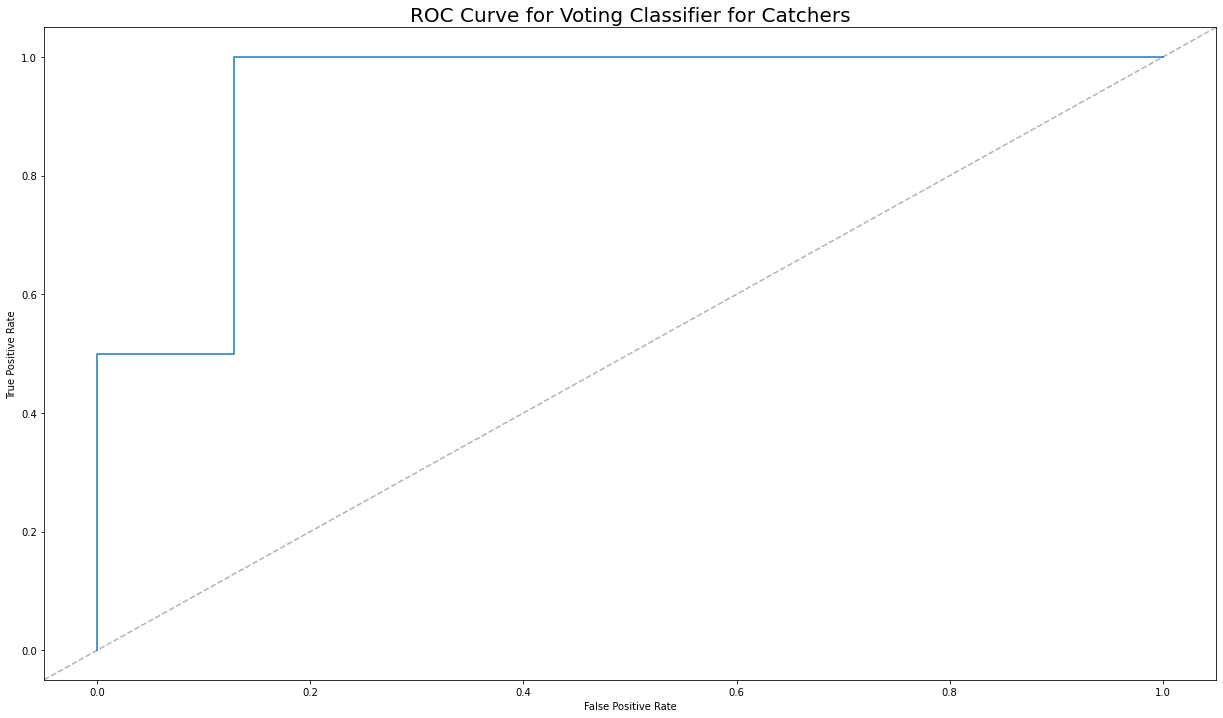

In [1644]:
fpr, tpr, thresholds = get_roc(voting_clf_catching, X_catching_test, y_catching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Voting Classifier for Catchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1645]:
voting_probs = voting_clf_catching.predict_proba(X_catching_active)
probs = [prob[1] for prob in voting_probs]
predictions = [prob >= best_threshold for prob in probs]
zipped = list(zip(active_player_ids, probs, predictions))
for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True)[:7]:
    player_name = id_to_name_dict.get(player)
    print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
print()
for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True)[7:12]:
    player_name = id_to_name_dict.get(player)
    print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
print()

Buster Posey         0.183 True
Yadier Molina        0.146 True
Brian McCann         0.102 True
A. J. Pierzynski     0.072 True
Russell Martin       0.032 True
Yasmani Grandal      0.024 True
J. T. Realmuto       0.023 True

Geovany Soto         0.011 False
Salvador Perez       0.011 False
Jonathan Lucroy      0.010 False
David Ross           0.008 False
Carlos Ruiz          0.008 False



Based on the output above, there are 7 catchers who would make a good candidate for the Hall of Fame according to the voting classifier.  The next 5 best candidates are listed as well.

### Active Pitchers

We will repeat this process for pitchers as well.

In [1646]:
active_player_ids = active_pitcher_df['playerID']

y_pitching_active = active_pitcher_df['isHallOfFame'].values
X_pitching_active = active_pitcher_df.drop(columns=['isHallOfFame', 'playerID']).values

estimator_names = ['LR', 'LDA', 'RF']
voting_clf_pitching = VotingClassifier(estimators=list(zip(estimator_names,
                                                           [best_lr_pitching, 
                                                            best_lda_pitching,
                                                            best_rf_pitching])),
                                       voting='soft',
                                       flatten_transform=False)
voting_clf_pitching.fit(X_pitching_train, y_pitching_train.ravel())

VotingClassifier(estimators=[('LR',
                              LogisticRegression(max_iter=10000, penalty='l1',
                                                 random_state=42,
                                                 solver='liblinear',
                                                 tol=0.001)),
                             ('LDA',
                              LinearDiscriminantAnalysis(shrinkage=1.0,
                                                         solver='lsqr',
                                                         tol=10)),
                             ('RF',
                              RandomForestClassifier(max_depth=6,
                                                     max_features=13,
                                                     n_estimators=500,
                                                     random_state=42))],
                 flatten_transform=False, voting='soft')

0.4313320613702461


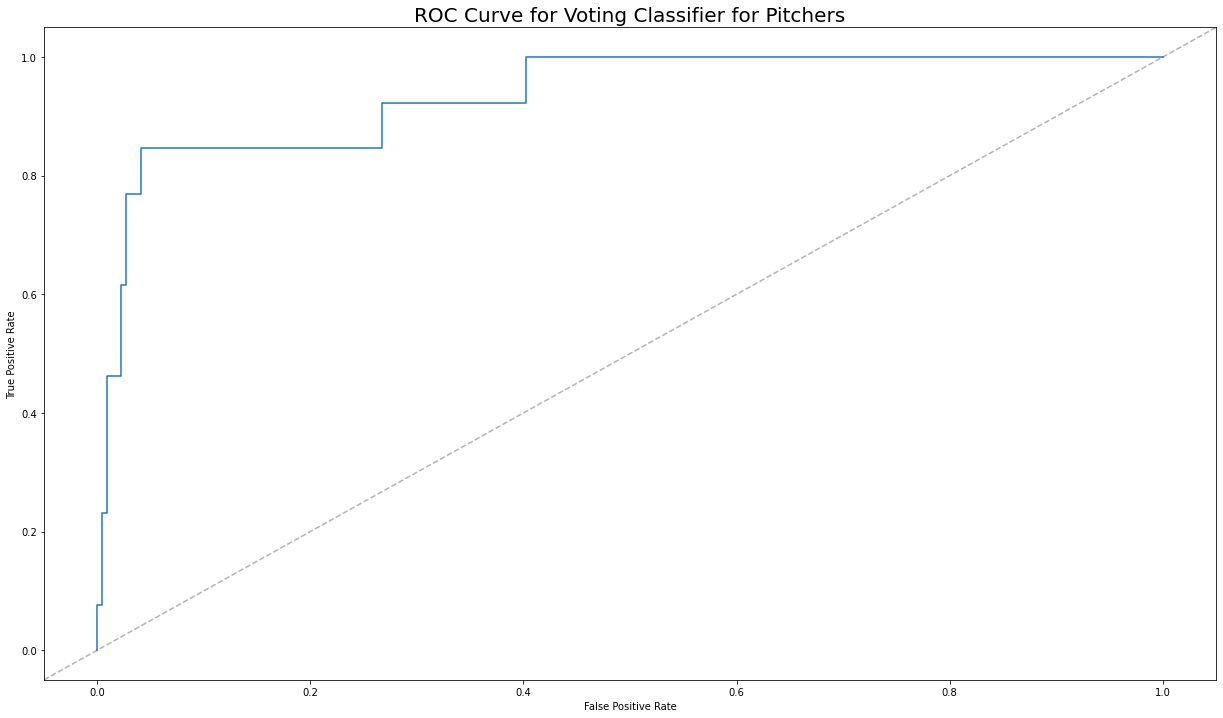

In [1647]:
fpr, tpr, thresholds = get_roc(voting_clf_pitching, X_pitching_test, y_pitching_test)
plot_roc(fpr, tpr, thresholds, 'ROC Curve for Voting Classifier for Pitchers')
best_threshold = get_best_threshold(fpr, tpr, thresholds)
print(best_threshold)

In [1648]:
voting_probs = voting_clf_pitching.predict_proba(X_pitching_active)
probs = [prob[1] for prob in voting_probs]
predictions = [prob >= best_threshold for prob in probs]
zipped = list(zip(active_player_ids, probs, predictions))
for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True)[:14]:
    player_name = id_to_name_dict.get(player)
    print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
print()
for player, prob, prediction in sorted(zipped, key=lambda x: x[1], reverse=True)[14:19]:
    player_name = id_to_name_dict.get(player)
    print(player_name.ljust(20), '{0:.3f}'.format(round(prob, 3)), prediction)
print()

Clayton Kershaw      0.887 True
Kenley Jansen        0.806 True
Craig Kimbrel        0.773 True
Aroldis Chapman      0.770 True
Zack Greinke         0.741 True
Justin Verlander     0.690 True
Sergio Romo          0.664 True
Max Scherzer         0.627 True
Madison Bumgarner    0.607 True
Jonathan Papelbon    0.605 True
Darren O'Day         0.547 True
Mark Melancon        0.487 True
Stephen Strasburg    0.478 True
David Price          0.462 True

Huston Street        0.428 False
Joe Nathan           0.388 False
Pat Neshek           0.385 False
Adam Wainwright      0.373 False
Joakim Soria         0.361 False



Based on the output above, there are 14 pitchers who would make a good candidate for the Hall of Fame according to the voting classifier.  The next 5 best candidates are listed as well.

# Interpretation

## Summary

We've seen here ways to accomplish data preprocessing, including handling missing data, exploratory data analysis, and data transformations.  We've also seen data manipulation techniques such as applying functions to the data and performing joins on the tables.

We have also trained 5 different models using a method that will result in adequate performance.  We have then evaluated the performances of those models using a variety of scoring metrics: confusion matrices, F1 score, precision, accuracy, sensitivity, specificity and the ROC curve were all used. 

We have explored ways to gain insights into which features are most important to the models we've trained and, therefore, which features are most important to the questions at hand.

We've used an ensemble method to build a balanced model that we then used to make predictions that yielded reasonable results.  

We were able to use these predictions to see that some players that are widely accepted as some of the greatest of all time, as well as players that many believe have been unjustly overlooked, are indeed Hall of Fame worthy. Additionally, we were able to use these predictions make a convincing argument for who may soon make it into the Hall of Fame in the future.

## Caveats

Although the results of this project have yielded acceptable results there are a number of ways this process could've been improved. It's important to remember that the results of these findings are just a tool for illuminating what, and who, may be important in the MLB.

- Admission is highly subjective, therefore the data used to train the models is subjective
    - Admission is largely based on votes that have no statistical basis
- Admission is not solely based on on-field performance
    - While Jackie Robinson was likely a deserving member of the Hall of Fame his admission was guaranteed, as well as his number being universally retired, because he stood for something larger than the game
    - While we've seen a strong case for Barry Bonds, he may never be a member due to his PED controversy
- It's not the same game that it was 100 years ago, so admission criteria could have shifted as well as what we would define as a good player
- These models can always be improved
    - More samples improve performance
    - Different baseball statistics could have been considered
    - A larger grid searched area would've yielded better tuning parameters
    - Data manipulation and transformations could be improved
    - Additional models could've been considered (SVC was not included due to time and resource constraints)
    - Sampling Techniques could've been imployed to help with imbalanced data
- While they are better than human opinion, these models are also somewhat subjective
    - They are based off the sample of players that we had. Even if admission were completely objective, our sample might not fully encapsulate what is the most important to the Hall of Fame

## Conclusion

When it comes to which baseball statistics historically have been the most important in terms of to making it into the Hall of Fame, the model's results indicate that a player's fielding largely doesn't matter. 

For pitchers, the most important thing is preventing the batters from reaching base and preventing them from scoring.  This is reflected in a high importance placed on **walks plus hits per inning pitched, home runs allowed per inning pitched, and strikeouts per nine innings pitched**.

For all other players, their batting was the most important aspect.  The most important thing was reaching base and scoring runs for the team.  This is reflected by the value placed on **runs created, batting average, and OPS**.


We also saw that there were several players (Barry Bonds, Mark McGwire, Rafael Palmeiro, and Pete Rose) who had batting statistics that by the BBWAA's standard would make them an extremely strong candidate for the Hall of Fame. However, none of these players will ever be inducted by the BBWAA.  This shows that, strictly in terms of the on field performance evaluated here, the BBWAA is inconsistent in their selection of players to the Hall of Fame.  One way to view this is that the BBWAA is biased and unfair in their selection.  Another way to view this is that the on field performance is not the only thing that the BBWAA values and that a player's character is also an important aspect of the selection process.